In [1]:

import datetime
from hmac import digest_size

import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs


def bokeh_plotter(data_list, x_axis_list=None, label_list=None,
                  plot_name='default',
                  x_axis_label='X', y_axis_label='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis_label,
                                y_axis_label=y_axis_label,
                                plot_width=1500,
                                plot_height=700)

    for i, data_vector in enumerate(data_list):

        color = next(color_cycle)

        if x_axis_list is None:
            x_axis = range(len(data_vector))
        elif len(x_axis_list) == len(data_list):
            print('x_axis manually set')
            x_axis = x_axis_list[i]
        else:
            raise Exception('problem with x_axis_list input - should be either None, or a list with the same length as data_list')
        if label_list is None:
            fig.line(x_axis, data_vector, line_color=color, legend_label=f"Line {i+1}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)


def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return

    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')


def create_saccade_events_df(eye_data_df, speed_threshold, bokeh_verify_threshold=False, magnitude_calib=1, speed_profile=True):
    """
    Detects saccade events in eye tracking data and computes relevant metrics.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.

    Steps:
    1. Calculate speed components ('speed_x', 'speed_y') based on differences in 'center_x' and 'center_y'.
    2. Compute the magnitude of the velocity vector ('speed_r').
    3. Create a binary column ('is_saccade') indicating saccade events based on the speed threshold.
    4. Determine saccade onset and offset indices and timestamps.
    5. Create a DataFrame ('saccade_events_df') with columns:
        - 'saccade_start_ind': Indices of saccade onset.
        - 'saccade_start_timestamp': Timestamps corresponding to saccade onset.
        - 'saccade_end_ind': Indices of saccade offset.
        - 'saccade_end_timestamp': Timestamps corresponding to saccade offset.
        - 'length': Duration of each saccade event.
    6. Calculate distance traveled and angles for each saccade event.
    7. Append additional columns to 'saccade_events_df':
        - 'magnitude': Magnitude of the distance traveled during each saccade.
        - 'angle': Angle of the saccade vector in degrees.
        - 'initial_x', 'initial_y': Initial coordinates of the saccade.
        - 'end_x', 'end_y': End coordinates of the saccade.

    Note: The original 'eye_data_df' is not modified; modified data is returned as 'df'.
    """
    df = eye_data_df
    df['speed_x'] = df['center_x'].diff()  # Difference between consecutive 'center_x' values
    df['speed_y'] = df['center_y'].diff()  # Difference between consecutive 'center_y' values

    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df['speed_r'] = (df['speed_x']**2 + df['speed_y']**2)**0.5

    # Create a column for saccade detection
    df['is_saccade'] = df['speed_r'] > speed_threshold

    # create a saccade_on_off indicator where 1 is rising edge and -1 is falling edge by subtracting a shifted binary mask
    saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1,fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[0] - 1 # notice the manual shift here, chosen to include the first (sometimes slower) eye frame, just before saccade threshold crossing
    saccade_on_ms = df['ms_axis'].iloc[saccade_on_inds]
    saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]
    saccade_off_ms = df['ms_axis'].iloc[saccade_off_inds]

    saccade_dict = {'saccade_start_ind' :  saccade_on_inds ,
                    'saccade_start_timestamp': saccade_on_timestamps.values,
                    'saccade_end_ind':      saccade_off_inds,
                    'saccade_end_timestamp':saccade_off_timestamps.values,
                    'saccade_on_ms': saccade_on_ms.values,
                    'saccade_off_ms': saccade_off_ms.values}

    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df['length'] = saccade_events_df['saccade_end_ind'] - saccade_events_df['saccade_start_ind']
    # Drop columns used for intermediate steps
    df = df.drop(['is_saccade'], axis=1)

    distances = []
    angles = []
    speed_list = []
    speed_list_calib = []
    diameter_list = []
    for index, row in tqdm.tqdm(saccade_events_df.iterrows()):
        saccade_samples = df.loc[(df['OE_timestamp'] >= row['saccade_start_timestamp']) &
                                 (df['OE_timestamp'] <= row['saccade_end_timestamp'])]
        distance_traveled = saccade_samples['speed_r'].sum()
        if speed_profile:
            saccade_speed_profile = saccade_samples['speed_r'].values
            saccade_calib_speed_profile = saccade_samples['speed_r'].values * magnitude_calib
            speed_list.append(saccade_speed_profile)
            speed_list_calib.append(saccade_calib_speed_profile)
        saccade_diameter_profile = saccade_samples['pupil_diameter'].values
        diameter_list.append(saccade_diameter_profile)
        # Calculate angle from initial position to endpoint
        initial_position = saccade_samples.iloc[0][['center_x', 'center_y']]
        endpoint = saccade_samples.iloc[-1][['center_x', 'center_y']]
        overall_angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                           endpoint['center_x'] - initial_position['center_x'])

        angles.append(overall_angle)
        distances.append(distance_traveled)



    saccade_events_df['magnitude_raw'] = np.array(distances)
    saccade_events_df['magnitude'] = np.array(distances) * magnitude_calib
    saccade_events_df['angle'] = np.where(np.isnan(angles), angles, np.rad2deg(angles) % 360) # Convert radians to degrees and ensure result is in [0, 360)
    start_ts = saccade_events_df['saccade_start_timestamp'].values
    end_ts = saccade_events_df['saccade_end_timestamp'].values
    saccade_start_df = df[df['OE_timestamp'].isin(start_ts)]
    saccade_end_df = df[df['OE_timestamp'].isin(end_ts)]
    start_x_coord = saccade_start_df['center_x']
    start_y_coord = saccade_start_df['center_y']
    end_x_coord = saccade_end_df['center_x']
    end_y_coord = saccade_end_df['center_y']
    saccade_events_df['initial_x'] = start_x_coord.values
    saccade_events_df['initial_y'] = start_y_coord.values
    saccade_events_df['end_x'] = end_x_coord.values
    saccade_events_df['end_y'] = end_y_coord.values
    saccade_events_df['calib_dx'] = (saccade_events_df['end_x'].values - saccade_events_df['initial_x'].values) * magnitude_calib
    saccade_events_df['calib_dy'] = (saccade_events_df['end_y'].values - saccade_events_df['initial_y'].values) * magnitude_calib
    if speed_profile:
        saccade_events_df['speed_profile'] = speed_list
        saccade_events_df['speed_profile_calib'] = speed_list_calib
    saccade_events_df['diameter_profile'] = diameter_list
    if bokeh_verify_threshold:
        bokeh_plotter(data_list=[df.speed_r], label_list=['Pupil Velocity'], peaks=saccade_on_inds)

    return df, saccade_events_df


In [2]:

# create a multi-animal block_collection:

def create_block_collections(animals, block_lists, experiment_path, bad_blocks=None):
    """
    Create block collections and a block dictionary from multiple animals and their respective block lists.

    Parameters:
    - animals: list of str, names of the animals.
    - block_lists: list of lists of int, block numbers corresponding to each animal.
    - experiment_path: pathlib.Path, path to the experiment directory.
    - bad_blocks: list of int, blocks to exclude. Default is an empty list.

    Returns:
    - block_collection: list of BlockSync objects for all specified blocks.
    - block_dict: dictionary where keys are block numbers as strings and values are BlockSync objects.
    """
    import UtilityFunctions_newOE as uf

    if bad_blocks is None:
        bad_blocks = []

    block_collection = []
    block_dict = {}

    for animal, blocks in zip(animals, block_lists):
        # Generate blocks for the current animal
        current_blocks = uf.block_generator(
            block_numbers=blocks,
            experiment_path=experiment_path,
            animal=animal,
            bad_blocks=bad_blocks
        )
        # Add to collection and dictionary
        block_collection.extend(current_blocks)
        for b in current_blocks:
            block_dict[f"{animal}_block_{b.block_num}"] = b

    return block_collection, block_dict






In [3]:

animals = ['PV_106','PV_143','PV_62','PV_126', 'PV_57']
block_lists = [[8,9,10,11,12],[1,2,3,4],[24, 26, 38],[7, 8, 9, 10, 11, 12], [7, 8, 9, 12, 13]]

experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
bad_blocks = [0]  # Example of bad blocks

block_collection, block_dict = create_block_collections(
    animals=animals,
    block_lists=block_lists,
    experiment_path=experiment_path,
    bad_blocks=bad_blocks)

instantiated block number 008 at Path: Z:\Nimrod\experiments\PV_106\2025_08_06\block_008, new OE version
Found the sample rate for block 008 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 008
got it!
instantiated block number 009 at Path: Z:\Nimrod\experiments\PV_106\2025_08_06\block_009, new OE version
Found the sample rate for block 009 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 009
got it!
instantiated block number 010 at Path: Z:\Nimrod\experiments\PV_106\2025_08_06\block_010, new OE version
Found the sample rate for block 010 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 010
got it!
instantiated block number 011 at Path: Z:\Nimrod\exp

In [4]:
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
    load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later

# # NOTICE THE DIRECTIONALITY FLIP!!!
#     block.left_eye_data = horizontal_flip_eye_data(block.left_eye_data.copy(),640)
#     block.right_eye_data = horizontal_flip_eye_data(block.right_eye_data.copy(),640)
    # calibrate pupil diameter:
for block in block_collection:
    block.left_eye_data = pd.read_csv(block.analysis_path / f'left_eye_data_degrees_raw_verified.csv')
    block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_degrees_raw_verified.csv')



running parse_open_ephys_events...
block 008 has a parsed events file, reading...
Getting eye brightness values for block 008...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 009 has a parsed events file, reading...
Getting eye brightness values for block 009...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 010 has a parsed events file, reading...
Getting eye brightness values for block 010...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_

In [5]:
 for block in block_collection:
    if 'pupil_diameter' not in block.left_eye_data.columns:
        block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax
        block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax
        block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
        block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

In [6]:
def create_saccade_events_with_direction_segmentation_robust(
        eye_data_df,
        speed_threshold,  # angular speed threshold in degrees/frame
        directional_delta_threshold_deg=25,  # threshold for change in instantaneous angle (degrees)
        magnitude_calib=1,
        speed_profile=True,
        min_subsaccade_samples=2,
        min_net_disp=0.5  # minimal net angular displacement (in degrees) for a segment to be valid
):
    """
    Detects and segments saccade events in eye tracking data using angular speed and directional changes.
    This robust version avoids producing segments with near-zero net displacement by:
      1. Defining the saccade onset as the first frame where the angular speed exceeds the threshold.
      2. Segmenting the event based on sustained directional changes.
      3. Discarding segments whose overall net angular displacement (computed from k_phi and k_theta)
         is below a user-specified minimal value.

    Parameters:
      - eye_data_df (pd.DataFrame): DataFrame with columns including:
            'center_x', 'center_y', 'k_phi', 'k_theta', 'OE_timestamp', 'ms_axis', 'pupil_diameter'.
      - speed_threshold (float): Angular speed threshold (degrees/frame) for detection.
      - directional_delta_threshold_deg (float): Angular change threshold to determine segmentation boundaries.
      - magnitude_calib (float): Calibration factor (not applied to angular measures).
      - speed_profile (bool): Whether to record speed profiles.
      - min_subsaccade_samples (int): Minimum number of samples required for a valid segment.
      - min_net_disp (float): Minimal net angular displacement (in degrees) required for a segment to be kept.

    Returns:
      - df (pd.DataFrame): The input DataFrame with added computed columns.
      - saccade_events_df (pd.DataFrame): DataFrame listing detected and segmented saccade events, with metrics.
    """
    # Make a copy so as not to modify the original DataFrame.
    df = eye_data_df.copy()

    ### 1. Compute Frame-to-Frame Differences
    df["speed_x"] = df["center_x"].diff()
    df["speed_y"] = df["center_y"].diff()
    df["speed_r"] = np.sqrt(df["speed_x"] ** 2 + df["speed_y"] ** 2)

    # Angular differences (k_phi and k_theta are in degrees)
    df["angular_speed_phi"] = df["k_phi"].diff()
    df["angular_speed_theta"] = df["k_theta"].diff()
    df["angular_speed_r"] = np.sqrt(df["angular_speed_phi"] ** 2 + df["angular_speed_theta"] ** 2)

    ### 2. Saccade Detection Based on Angular Speed
    # Mark frames where the instantaneous angular speed exceeds the threshold.
    df["is_saccade_angle"] = df["angular_speed_r"] > speed_threshold

    # Identify transitions to detect onsets and offsets.
    saccade_on_off = df["is_saccade_angle"].astype(int) - df["is_saccade_angle"].shift(1, fill_value=0).astype(int)
    # Use the first frame above threshold as onset
    saccade_on_inds = np.where(saccade_on_off == 1)[0]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]

    # Handle mismatches: if a saccade starts but does not end, drop the last onset.
    if len(saccade_on_inds) > len(saccade_off_inds):
        saccade_on_inds = saccade_on_inds[:-1]

    saccade_events = []

    ### 3. Process Each Detected Saccade for Segmentation
    for start_ind, end_ind in zip(saccade_on_inds, saccade_off_inds):
        saccade_df = df.iloc[start_ind:end_ind + 1].copy()
        if saccade_df.empty or len(saccade_df) < min_subsaccade_samples:
            continue

        # Compute instantaneous angles (for both pixel- and angular-based estimates)
        saccade_df["inst_angle_pixel"] = np.degrees(np.arctan2(saccade_df["speed_y"], saccade_df["speed_x"]))
        saccade_df["inst_angle_deg"] = np.degrees(
            np.arctan2(saccade_df["angular_speed_theta"], saccade_df["angular_speed_phi"]))

        # Define helper function for minimal angular difference (handling circularity)
        minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180

        angles = saccade_df["inst_angle_deg"].values
        # Compute consecutive differences
        angle_diffs = np.array([minimal_angle_diff_deg(angles[i + 1], angles[i]) for i in range(len(angles) - 1)])

        # Identify candidate segmentation boundaries when the absolute change exceeds threshold.
        candidate_boundaries = np.where(np.abs(angle_diffs) > directional_delta_threshold_deg)[0].tolist()

        # Always include the first and last frame of the saccade.
        boundaries = [0] + candidate_boundaries + [len(saccade_df) - 1]

        # Process each segment defined by these boundaries.
        for i in range(len(boundaries) - 1):
            seg_start = boundaries[i]
            seg_end = boundaries[i + 1]
            subsaccade = saccade_df.iloc[seg_start: seg_end + 1]
            if len(subsaccade) < min_subsaccade_samples:
                continue

            # Compute net angular displacement using the angular positions (k_phi and k_theta)
            initial_pos_angle = subsaccade.iloc[0][["k_phi", "k_theta"]]
            final_pos_angle = subsaccade.iloc[-1][["k_phi", "k_theta"]]
            net_disp = np.sqrt((final_pos_angle["k_phi"] - initial_pos_angle["k_phi"]) ** 2 +
                               (final_pos_angle["k_theta"] - initial_pos_angle["k_theta"]) ** 2)

            # Only record segments whose net displacement is above min_net_disp.
            if net_disp < min_net_disp:
                continue

            # Timing and indices
            sub_start_timestamp = subsaccade["OE_timestamp"].iloc[0]
            sub_end_timestamp = subsaccade["OE_timestamp"].iloc[-1]
            sub_start_ms = subsaccade["ms_axis"].iloc[0]
            sub_end_ms = subsaccade["ms_axis"].iloc[-1]
            sub_length = subsaccade.index[-1] - subsaccade.index[0]

            # Pixel-based metrics
            magnitude_raw_pixel = subsaccade["speed_r"].sum()
            magnitude_pixel = magnitude_raw_pixel * magnitude_calib

            # Angular-based metric: sum of instantaneous angular speeds
            magnitude_raw_angular = subsaccade["angular_speed_r"].sum()

            # Overall angular-based angle (from start to end)
            overall_angle_deg = (np.degrees(np.arctan2(
                final_pos_angle["k_theta"] - initial_pos_angle["k_theta"],
                final_pos_angle["k_phi"] - initial_pos_angle["k_phi"]
            )) % 360)

            # (Optional) Capture speed profiles and other details
            speed_profile_pixel = subsaccade["speed_r"].values if speed_profile else None
            speed_profile_pixel_calib = (speed_profile_pixel * magnitude_calib) if speed_profile else None
            speed_profile_angular = subsaccade["angular_speed_r"].values if speed_profile else None
            diameter_profile = subsaccade["pupil_diameter"].values

            saccade_events.append({
                "saccade_start_ind": subsaccade.index[0],
                "saccade_end_ind": subsaccade.index[-1],
                "saccade_start_timestamp": sub_start_timestamp,
                "saccade_end_timestamp": sub_end_timestamp,
                "saccade_on_ms": sub_start_ms,
                "saccade_off_ms": sub_end_ms,
                "length": sub_length,
                "magnitude_raw_pixel": magnitude_raw_pixel,
                "magnitude_pixel": magnitude_pixel,
                "magnitude_raw_angular": magnitude_raw_angular,
                "overall_angle_deg": overall_angle_deg,
                "net_angular_disp": net_disp,
                "speed_profile_pixel": speed_profile_pixel,
                "speed_profile_pixel_calib": speed_profile_pixel_calib,
                "speed_profile_angular": speed_profile_angular,
                "diameter_profile": diameter_profile,
                "theta_init_pos": initial_pos_angle["k_theta"],
                "theta_end_pos": final_pos_angle["k_theta"],
                "phi_init_pos": initial_pos_angle["k_phi"],
                "phi_end_pos": final_pos_angle["k_phi"]
            })

    # Convert the list to a DataFrame.
    saccade_events_df = pd.DataFrame(saccade_events)

    # Optionally remove intermediate column
    df.drop(["is_saccade_angle"], axis=1, inplace=True)

    # Calculate delta columns for convenience.
    if not saccade_events_df.empty:
        saccade_events_df['delta_theta'] = saccade_events_df['theta_end_pos'] - saccade_events_df['theta_init_pos']
        saccade_events_df['delta_phi'] = saccade_events_df['phi_end_pos'] - saccade_events_df['phi_init_pos']

    return df, saccade_events_df


In [7]:
for block in block_collection:
    print(block)
    block.left_eye_data, block.l_saccade_df = create_saccade_events_with_direction_segmentation_robust(block.left_eye_data,
                                                                                                        0.8,  # angular speed threshold in degrees/video frame, 0.8+~50 deg / sec
                                                                                                        directional_delta_threshold_deg=90,  # threshold for change in instantaneous angle (degrees)
                                                                                                        magnitude_calib=1,
                                                                                                        speed_profile=True,
                                                                                                        min_subsaccade_samples=2)
    block.right_eye_data, block.r_saccade_df = create_saccade_events_with_direction_segmentation_robust(block.right_eye_data,
                                                                                                        0.8,  # angular speed threshold in degrees/video frame
                                                                                                        directional_delta_threshold_deg=90,  # threshold for change in instantaneous angle (degrees)
                                                                                                        magnitude_calib=1,
                                                                                                        speed_profile=True,
                                                                                                        min_subsaccade_samples=2)


PV_106, block 008, on PV106_ET_d3t12025-08-06_11-52-19
PV_106, block 009, on PV106_ET_d3t2_2025-08-06_12-09-43
PV_106, block 010, on PV106_ET_d3t3_2025-08-06_12-26-43
PV_106, block 011, on PV106_ET_d3t4_2025-08-06_12-44-30
PV_106, block 012, on PV106_ET_d3t5_2025-08-06_13-21-30
PV_143, block 001, on PV143_ET_d1t1_2025-08-11_13-29-08
PV_143, block 002, on PV143_ET_d1t2_2025-08-11_13-50-11
PV_143, block 003, on PV143_ET_d1t3_2025-08-11_14-20-35
PV_143, block 004, on PV143_ET_d1t4_2025-08-11_14-58-28
PV_62, block 024, on 2023-04-27_11-22-56
PV_62, block 026, on 2023-04-27_12-21-41
PV_62, block 038, on 2023-05-01_13-57-45
PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12
PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41
PV_126, block 009, on PV126_Trial18_wake5_2024-07-18_14-39-15
PV_126, block 010, on PV126_Trial19_wake6_2024-07-18_15-24-57
PV_126, block 011, on PV126_Trial115_eyeTracking_w7
PV_126, block 012, on PV126_Trial116_eyeTracking_h8
PV_57, block 007, on p

In [8]:
### over here, I get the lizard movements binary from mark's analysis
import os
def block_get_lizard_movement(block):
    p = block.oe_path / 'analysis'
    analysis_list = os.listdir(p)
    correct_analysis = [i for i in analysis_list if block.animal_call in i][0]
    p = p / str(correct_analysis)
    mat_path = p / 'lizMov.mat'
    print(f'path to mat file is {mat_path}')
    # read mat file
    try:
        mat_data = h5py.File(str(mat_path), 'r')
        mat_dict = {'t_mov_ms': mat_data['t_mov_ms'][:],
                    'movAll': mat_data['movAll'][:],
                    'angles': mat_data['angles'][:],
                    'staticAll': mat_data['staticAll'][:],
                    't_static_ms': mat_data['t_static_ms'][:]}
        mat_dict['phi_rad'] = mat_dict['angles'][:,0]
        mat_dict['theta_rad'] = mat_dict['angles'][:,1]
        mat_dict['theta_deg'] = np.rad2deg(mat_dict['theta_rad'])
        mat_dict['phi_deg'] = np.rad2deg(mat_dict['phi_rad'])
        acc_df = pd.DataFrame(data=np.array([mat_dict['t_mov_ms'][:, 0], mat_dict['movAll'][:, 0]]).T,
                              columns=['t_mov_ms', 'movAll'])
        static_df = pd.DataFrame(data=np.array([mat_dict['t_static_ms'][:, 0],
                                                mat_dict['staticAll'][:, 0],
                                                mat_dict['phi_rad'],
                                                mat_dict['theta_rad'],
                                                mat_dict['phi_deg'],
                                                mat_dict['theta_deg']]).T,
                              columns=['t_static_ms', 'staticAll','phi_rad','theta_rad','phi_deg','theta_deg'])
        mat_data.close()
        block.liz_mov_df = acc_df
        block.liz_static_df = static_df
        print(f'liz_mov_df created for {block}')
    except FileNotFoundError:
        print(f'no such file {mat_path}')


# this cell now labels the saccades as with/without head movements
def get_head_mov_col(df, mov_times):
    head_mov_bool = np.zeros(len(df), dtype=bool)  # Initialize array of False

    for i, saccade in enumerate(df.itertuples()):
        saccade_start = saccade.saccade_on_ms
        saccade_end = saccade.saccade_off_ms

        overlapping_mov_times = mov_times[np.logical_and(mov_times >= saccade_start, mov_times <= saccade_end)]

        if overlapping_mov_times.size > 0:
            head_mov_bool[i] = True

    df['head_movement'] = head_mov_bool
    return df

def label_saccade_movements(block):
    mov_times = block.liz_mov_df.t_mov_ms.values
    block.l_saccade_df = get_head_mov_col(block.l_saccade_df,mov_times=mov_times)
    block.r_saccade_df = get_head_mov_col(block.r_saccade_df,mov_times=mov_times)

# Create a list to store blocks where movement data exists
block_collection_w_mov = []

for block in block_collection:
    try:
        block_get_lizard_movement(block)  # Try loading movement data
        label_saccade_movements(block)    # Try labeling saccades

        # If both steps succeed, add block to the valid collection
        block_collection_w_mov.append(block)

    except (FileNotFoundError, OSError) as e:
        print(f"Skipping block {block}: {str(e)}")  # Notify which block failed


path to mat file is Z:\Nimrod\experiments\PV_106\2025_08_06\block_008\oe_files\PV106_ET_d3t12025-08-06_11-52-19\Record Node 102\analysis\recNames=Block008,Animal=PV_106\lizMov.mat
liz_mov_df created for PV_106, block 008, on PV106_ET_d3t12025-08-06_11-52-19
path to mat file is Z:\Nimrod\experiments\PV_106\2025_08_06\block_009\oe_files\PV106_ET_d3t2_2025-08-06_12-09-43\Record Node 102\analysis\recNames=Block009,Animal=PV_106\lizMov.mat
liz_mov_df created for PV_106, block 009, on PV106_ET_d3t2_2025-08-06_12-09-43
path to mat file is Z:\Nimrod\experiments\PV_106\2025_08_06\block_010\oe_files\PV106_ET_d3t3_2025-08-06_12-26-43\Record Node 102\analysis\recNames=Block010,Animal=PV_106\lizMov.mat
liz_mov_df created for PV_106, block 010, on PV106_ET_d3t3_2025-08-06_12-26-43
path to mat file is Z:\Nimrod\experiments\PV_106\2025_08_06\block_011\oe_files\PV106_ET_d3t4_2025-08-06_12-44-30\Record Node 102\analysis\recNames=Block011,Animal=PV_106\lizMov.mat
liz_mov_df created for PV_106, block 011,

In [9]:
import os
import pickle
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def plot_saccade_magnitude_vs_velocity_time_to_peak_angular(
    synced_saccade_collection, monocular_saccade_collection, export_path=None, threshold=3,
    fig_size=(3, 3), velocity_threshold=None, velocity_to_deg_per_ms=True, frame_rate_fps=60
):
    """
    Plots angular saccade magnitudes versus angular peak velocities as a compact scatter plot.
    Angular metrics are extracted from the synchronized saccade DataFrame:
      - Angular amplitude is taken from 'magnitude_raw_angular'
      - Peak angular velocity is computed as the maximum value from 'speed_profile_angular'
      - Time-to-peak is assumed to be stored in 'time_to_peak_v'

    Parameters:
      - synced_saccade_collection: DataFrame of synchronized saccades containing angular columns.
      - monocular_saccade_collection: DataFrame of monocular saccades (unused here, but kept for compatibility).
      - export_path (str): Directory path to export the plot and data.
      - threshold (float): Standard deviation threshold for outlier removal.
      - fig_size (tuple): Figure size (width, height).
      - velocity_threshold (float): Optional horizontal line value for peak velocities.
      - velocity_to_deg_per_ms (bool): If True, convert angular speeds from deg/frame to deg/ms.
      - frame_rate_fps (float): Frame rate in frames per second.
    """

    def extract_saccade_metrics_time_to_peak_angular(saccade_collection, eye_label):
        """
        Extracts angular saccade metrics for the given eye.
        Assumes that saccade_collection contains:
          - 'magnitude_raw_angular': angular amplitude (deg)
          - 'speed_profile_angular': list/array of angular speeds (deg/frame)
          - 'time_to_peak_v': time to reach peak angular speed (ms)
        """
        filtered_data = saccade_collection.query('eye == @eye_label')
        magnitudes = filtered_data['magnitude_raw_angular'].values
        # Compute peak angular speed (in deg/frame) from the angular speed profile
        peak_velocities = np.array([np.nanmax(profile) for profile in filtered_data['speed_profile_angular']])
        time_to_peak = filtered_data['time_to_peak_v'].values
        return magnitudes, peak_velocities, time_to_peak

    # Get metrics for left and right eyes
    l_magnitudes, l_peak_velocities, l_time_to_peak = extract_saccade_metrics_time_to_peak_angular(synced_saccade_collection, 'L')
    r_magnitudes, r_peak_velocities, r_time_to_peak = extract_saccade_metrics_time_to_peak_angular(synced_saccade_collection, 'R')

    # Concatenate the data from both eyes
    all_magnitudes = np.concatenate((l_magnitudes, r_magnitudes))
    all_peak_velocities = np.concatenate((l_peak_velocities, r_peak_velocities))
    all_time_to_peaks = np.concatenate((l_time_to_peak, r_time_to_peak))

    # Convert from deg/frame to deg/ms if requested
    frame_duration = 1000 / frame_rate_fps  # ms per frame
    if velocity_to_deg_per_ms:
        all_peak_velocities = all_peak_velocities / frame_duration

    # Combine into DataFrame
    data = pd.DataFrame({
        'magnitude': all_magnitudes,           # Angular amplitude in degrees
        'peak_velocity': all_peak_velocities,   # Angular peak velocity in deg/ms
        'time_to_peak': all_time_to_peaks         # Time to peak (ms)
    })

    # Remove outliers (this function should be defined elsewhere)
    cleaned_data = remove_outliers_from_df(data, threshold)

    # Extract cleaned data for plotting
    f_magnitudes = cleaned_data['magnitude'].values
    f_peak_velocities = cleaned_data['peak_velocity'].values
    f_time_to_peaks = cleaned_data['time_to_peak'].values

    # Create scatter plot
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)
    sc = ax.scatter(f_magnitudes, f_peak_velocities, s=0.7, c=f_time_to_peaks, cmap='viridis', alpha=0.7)

    ax.set_xlabel('Angular Amplitude [deg]', fontsize=10)
    ax.set_ylabel('Peak Angular Velocity [deg/ms]', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

    if velocity_threshold is not None:
        ax.axhline(y=velocity_threshold, color='red', linestyle='--', linewidth=1.5)

    # Add a limiting slope line (here, a line with slope = 1/frame_duration as a reference)
    limiting_slope = 1 / frame_duration
    x_line = np.linspace(0, f_magnitudes.max(), 100)
    y_line = limiting_slope * x_line
    ax.plot(x_line, y_line, color='orange', linestyle='--', linewidth=1.5, label='Min Detectable Speed')
    ax.legend(fontsize=8)

    # Add colorbar for time-to-peak
    cbar = plt.colorbar(sc, ax=ax, pad=0.02, aspect=10)
    cbar.set_label('Time-To-Peak [ms]', fontsize=8)
    cbar.ax.tick_params(labelsize=8)

    # Export plot and data if export_path is provided
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_magnitude_vs_velocity_time_to_peak_angular_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "saccade_magnitude_vs_velocity_time_to_peak_angular.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "cleaned_saccade_data_time_to_peak_angular.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(cleaned_data, f)
        print(f"Exported plot and data to: {full_export_path}")

    plt.show()


In [10]:
# add annotations for a joint dataframe:
for block in block_collection:
    block.r_saccade_df['eye'] = 'R'
    block.r_saccade_df['block'] = block.block_num
    block.r_saccade_df['animal'] = block.animal_call
    block.l_saccade_df['eye'] = 'L'
    block.l_saccade_df['block'] = block.block_num
    block.l_saccade_df['animal'] = block.animal_call
    block.all_saccade_df = pd.concat([block.l_saccade_df,block.r_saccade_df])

In [11]:
saccade_df_list = []
for block in block_collection:
    saccade_df_list.append(block.all_saccade_df)
saccade_collection = pd.concat(saccade_df_list)

In [12]:
def get_closest_diff_ind(timestamp, timeseries):
    """
    This function extracts a frame from a series so that it is as close as possible to a given timestamp
    :param timestamp: The time to match a frame to
    :param timeseries: The time frames series to look at for a match
    :param report_acc: if set to 1, will report the accuracy of the match
    :return: index_of_lowest_diff , accuracy of match (if requested)
    """
    array = np.abs(timeseries - timestamp)
    index_of_lowest_diff = np.argmin(array)
    lowest_diff_val = timeseries[index_of_lowest_diff]
    return index_of_lowest_diff, lowest_diff_val

def find_synced_saccades(df, diff_threshold=680):
    synced_saccades = []
    non_synced_saccades = []
    l_df = df.query('eye == "L"')
    r_df = df.query('eye == "R"')
    for i, row in tqdm.tqdm(l_df.iterrows()):
        l_timestamp = row['saccade_start_timestamp']
        ind_min_diff, r_timestamp = get_closest_diff_ind(l_timestamp, r_df['saccade_start_timestamp'].values)
        #print(i,ind_lowest_diff)
        time_diff = np.abs(l_timestamp - r_timestamp)
        if time_diff < diff_threshold:
            synced_saccades.append((row, r_df.iloc[ind_min_diff]))  # Collect synchronized rows
        else:
            non_synced_saccades.append(row)  # Collect non-synchronized rows
    # Create DataFrame with multi-index
    multi_index = pd.MultiIndex.from_tuples([(i, 'L') for i in range(len(synced_saccades))] + [(i, 'R') for i in range(len(synced_saccades))], names=['Main', 'Sub'])
    synced_df = pd.DataFrame(index=multi_index, columns=df.columns)
    # Populate DataFrame
    for idx, (l_row, r_row) in enumerate(synced_saccades):
        synced_df.loc[(idx, 'L')] = l_row
        synced_df.loc[(idx, 'R')] = r_row
    r_non_synced_leftovers = r_df[~r_df['saccade_start_timestamp'].isin(synced_df.query('eye == "R"')['saccade_start_timestamp'].values)]
    print(len(r_non_synced_leftovers),len(r_df))
    # Create DataFrame for non-synced saccades
    non_synced_df = pd.DataFrame(non_synced_saccades, columns=df.columns)
    non_synced_df = pd.concat([non_synced_df,r_non_synced_leftovers])

    return synced_df, non_synced_df

synced_df_list = []
non_synced_df_list = []
for saccade_df in saccade_df_list:
    # Find synced saccades:
    synced_df, non_synced_df = find_synced_saccades(saccade_df.dropna(), diff_threshold=680)
    if len(non_synced_df.dropna()) + len(synced_df.dropna()) == len(saccade_df.dropna()):
        print('got them all')

    synced_df_list.append(synced_df)
    non_synced_df_list.append(non_synced_df)


924it [00:00, 7994.04it/s]
395it [00:00, 7390.60it/s]
472it [00:00, 10069.18it/s]

105 517
102 336



1273it [00:00, 8651.73it/s]

103 320



724it [00:00, 8557.13it/s]
0it [00:00, ?it/s]

377 961
333 650


519it [00:00, 7513.22it/s]
322it [00:00, 6865.46it/s]
0it [00:00, ?it/s]

234 565
145 320


387it [00:00, 3337.47it/s]
265it [00:00, 7006.90it/s]
675it [00:00, 7975.76it/s]


256 495
93 207


623it [00:00, 7971.75it/s]
0it [00:00, ?it/s]

262 638
374 761


1090it [00:00, 8084.84it/s]
765it [00:00, 7537.67it/s]

1071 1649


1409it [00:00, 7627.41it/s]
429it [00:00, 8028.54it/s]
0it [00:00, ?it/s]

435 1315
289 541


529it [00:00, 7660.31it/s]
271it [00:00, 8672.00it/s]
322it [00:00, 3209.87it/s]

251 539
183 353


1056it [00:00, 5263.93it/s]
112it [00:00, 7168.44it/s]
934it [00:00, 7625.78it/s]

539 1251
53 123



949it [00:00, 7213.05it/s]

1635 2183



794it [00:00, 7914.87it/s]

461 1087
487 888



786it [00:00, 6779.43it/s]
999it [00:00, 6787.32it/s]


286 763
573 1245


In [13]:
def combine_synced_dataframes(dataframes):
    combined_dfs = []
    start_index = 0
    for df in dataframes:
        num_rows = len(df) // 2  # Assuming each dataframe contains pairs of rows
        main_index = pd.MultiIndex.from_tuples([(i + start_index, 'L') for i in range(num_rows)] + [(i + start_index, 'R') for i in range(num_rows)], names=['Main', 'Sub'])
        df.index = main_index
        combined_dfs.append(df)
        start_index += num_rows
    combined_df = pd.concat(combined_dfs)
    combined_df.reset_index(inplace=True)
    return combined_df

synced_saccade_collection = combine_synced_dataframes(synced_df_list)
non_synced_saccade_collection = pd.concat(non_synced_df_list)


In [14]:
all_saccade_collection = pd.concat([synced_saccade_collection,non_synced_saccade_collection])


In [15]:


# This one in progress
# ---------- imports ----------
import datetime
import pickle
from pathlib import Path
from typing import Optional, Tuple, Sequence, Dict, Any, List, Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.ndimage import gaussian_filter1d

# ---------- helpers ----------

def _ensure_dir(p: Union[str, Path]) -> Path:
    p = Path(p)
    p.mkdir(parents=True, exist_ok=True)
    return p

def _save_legend_as_pdf(ax: plt.Axes, out_path: Union[str, Path], ncol=2, fontsize=6, frameon=False):
    leg = ax.legend(frameon=frameon, fontsize=fontsize, ncol=ncol)
    if leg is None:
        return
    fig_leg = leg.figure
    fig_leg.canvas.draw()
    fig_leg.savefig(out_path, bbox_inches="tight", dpi=300)

def _block_key(animal, block_num):
    return f"{animal}_block_{int(block_num):03d}", f"{animal}_block_{int(block_num)}"

def _eye_df(block_dict, animal, block_num, eye):
    k1, k2 = _block_key(animal, block_num)
    blk = block_dict.get(k1, block_dict.get(k2, None))
    if blk is None:
        raise KeyError(f"Block not found for {animal} block {block_num} (tried {k1} / {k2})")
    df = blk.left_eye_data if str(eye).upper() == "L" else blk.right_eye_data
    need = {"ms_axis","k_phi","k_theta"}
    if not need.issubset(df.columns):
        raise ValueError(f"Eye dataframe missing columns: {need - set(df.columns)}")
    return df

def _raw_velocity_trace(df_eye):
    t = df_eye["ms_axis"].to_numpy(dtype=float)
    phi = df_eye["k_phi"].to_numpy(dtype=float)
    th  = df_eye["k_theta"].to_numpy(dtype=float)
    dphi = np.diff(phi); dth = np.diff(th); dt_s = np.diff(t) / 1000.0
    v_dps = np.divide(np.hypot(dphi, dth), dt_s, out=np.full_like(dphi, np.nan), where=dt_s>0)
    t_ms = t[1:]
    return t_ms, v_dps

def _peak_time_in_window(t_ms, v_dps, on_ms, off_ms, subsample_peak=False):
    m = (t_ms >= on_ms) & (t_ms <= off_ms) & np.isfinite(v_dps)
    if not np.any(m):
        return np.nan
    v = v_dps[m]; tloc = t_ms[m]
    i = int(np.nanargmax(v))
    if (not subsample_peak) or i == 0 or i == v.size-1:
        return float(tloc[i])
    v_1, v0, v1 = v[i-1], v[i], v[i+1]
    denom = (v_1 - 2*v0 + v1)
    if not np.isfinite(denom) or denom == 0:
        return float(tloc[i])
    d = 0.5*(v_1 - v1)/denom
    d = float(np.clip(d, -1.0, 1.0))
    dt_local = (tloc[min(i+1, v.size-1)] - tloc[max(i-1, 0)]) / 2.0
    return float(tloc[i] + d * dt_local)

def _first_cross_time(t, y, ythr):
    """Linear-interpolated first time where y(t) >= ythr. Returns None if no crossing."""
    t = np.asarray(t); y = np.asarray(y)
    if t.size < 2 or not np.isfinite(ythr): return None
    valid = np.isfinite(y)
    t = t[valid]; y = y[valid]
    if t.size < 2: return None
    y0, y1 = y[:-1], y[1:]
    t0, t1 = t[:-1], t[1:]
    s0, s1 = y0 - ythr, y1 - ythr
    cross_idx = np.where((s0 <= 0) & (s1 >= 0) | (s0 >= 0) & (s1 <= 0) | (np.isclose(y0, ythr)))[0]
    if cross_idx.size == 0:
        return None
    k = int(cross_idx[0])
    if np.isclose(y0[k], ythr):
        return float(t0[k])
    denom = (y1[k] - y0[k])
    if np.isclose(denom, 0.0):
        return float(t0[k])
    frac = (ythr - y0[k]) / denom
    frac = float(np.clip(frac, 0.0, 1.0))
    return float(t0[k] + frac * (t1[k] - t0[k]))


import datetime, pickle
from pathlib import Path
from typing import Optional, Tuple, Sequence, Dict, Any, List, Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.ndimage import gaussian_filter1d


import datetime, pickle
from pathlib import Path
from typing import Optional, Tuple, Sequence, Dict, Any, List, Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.ndimage import gaussian_filter1d


def plot_pos_and_vel_by_amp_bins_per_animal_kernel(
    all_saccade_collection: pd.DataFrame,
    block_dict: dict,
    # ---- core analysis params ----
    amp_col: Optional[str] = None,       # auto-pick if None
    bin_width_deg: float = 5.0,
    min_amp_deg: float = 0.5,
    t_window_ms: Tuple[float, float] = (-40.0, 80.0),
    dt_ms: float = 2.0,                  # grid step
    bandwidth_ms: float = 10.0,          # Gaussian kernel across time bins
    min_events_per_bin: int = 30,
    per_animal_max_bins: int = 8,
    eye_filter: Optional[str] = None,    # "L", "R", or None (both)
    subsample_peak: bool = False,        # sub-frame peak alignment (only relevant when align_to='peak')
    smoothing: bool = True,              # kernel smoothing (group-level)
    plot_bins_as_scatter: bool = False,  # when not smoothing, markers+line
    min_bin_count: int = 3,              # ignore sparse bins (unsmoothed)
    errorbars: bool = False,             # show SD as error bars (unsmoothed)
    normalize_velocity_to_peak: bool = False,  # divide mean V by its own peak
    normalize_position_to_amp: bool = True,    # divide pos by each event's net amp
    normalize_final_curve: bool = False,       # final 0..1 normalization of the *mean position* curve
    velocity_threshold: float = None,          # deg/s (or relative if normalized)
    # ---- NEW controls ----
    align_to: str = "peak",              # 'peak' (default) or 'onset'
    position_calc: str = "mov_axis",     # 'mov_axis' (default) or 'integrate'
    # ---- visibility & axis controls ----
    show_position: bool = True,
    show_velocity: bool = True,
    vel_ylim: Optional[Tuple[float, float]] = None,
    pos_ylim: Optional[Tuple[float, float]] = None,
    # vertical/horizontal threshold line styling
    vline_kwargs: dict = None,
    hline_kwargs: dict = None,
    # ---- export controls ----
    export_path: Optional[Union[Path, str]] = None,
    fig_size: Tuple[float, float] = (4.0, 3.6),
    dpi: int = 200,
    legend_ncol: int = 2,
    bin_cmap: str = "viridis",
    # ---- display control ----
    show_inline: bool = True
):
    """
    Two-panel figure (top: position, bottom: velocity) with optional single-panel modes.

    NEW:
      - align_to: 'peak' (t=0 at peak velocity) or 'onset' (t=0 at saccade onset).
      - position_calc:
          'mov_axis'  -> project (k_phi, k_theta) onto the event's net movement axis.
          'integrate' -> project angular velocity onto the axis and *integrate* to get position.

    Position pipeline:
      Per event -> align (peak/onset) -> sample on fixed grid -> average within amplitude bins.
      If normalize_position_to_amp: per-event position divided by that event's amplitude.
      If normalize_final_curve: per-bin *mean* position curve min-max normalized to [0,1].

    Velocity pipeline:
      Same alignment; mean ± SD across events (optional normalization to its own peak).
    """
    if not (show_position or show_velocity):
        raise ValueError("At least one of show_position or show_velocity must be True.")
    if align_to not in ("peak", "onset"):
        raise ValueError("align_to must be 'peak' or 'onset'.")
    if position_calc not in ("mov_axis", "integrate"):
        raise ValueError("position_calc must be 'mov_axis' or 'integrate'.")

    if vline_kwargs is None: vline_kwargs = dict(ls=":", lw=1.6, alpha=0.9)
    if hline_kwargs is None: hline_kwargs = dict(ls=":", lw=1.6, color="red", alpha=0.7)

    df = all_saccade_collection.reset_index(drop=True).copy()
    req = {"animal","block","eye","saccade_on_ms","saccade_off_ms"}
    if not req.issubset(df.columns):
        raise ValueError("DataFrame must have columns: %s" % (req,))

    # choose amplitude column
    if amp_col is None:
        for c in ("net_angular_disp","magnitude_raw_angular"):
            if c in df.columns:
                amp_col = c; break
    if amp_col is None:
        raise ValueError("Need 'net_angular_disp' or 'magnitude_raw_angular'.")
    df[amp_col] = pd.to_numeric(df[amp_col], errors="coerce")

    if eye_filter:
        df = df[df["eye"].str.upper() == eye_filter.upper()]

    animals = sorted(df["animal"].dropna().unique().tolist())

    tmin, tmax = float(t_window_ms[0]), float(t_window_ms[1])
    t_grid = np.arange(tmin, tmax + dt_ms, dt_ms); nb = len(t_grid)
    sigma_bins = max(1.0, float(bandwidth_ms) / float(dt_ms))
    cmap = colormaps.get_cmap(bin_cmap)

    # export root + bundle
    root_out = None
    bundle: Dict[str, Any] = {
        "t_grid": t_grid.astype(np.float32),
        "params": dict(
            amp_col=amp_col,
            bin_width_deg=bin_width_deg,
            min_amp_deg=min_amp_deg,
            t_window_ms=tuple(t_window_ms),
            dt_ms=float(dt_ms),
            bandwidth_ms=float(bandwidth_ms),
            min_events_per_bin=int(min_events_per_bin),
            per_animal_max_bins=int(per_animal_max_bins),
            eye_filter=(None if eye_filter is None else str(eye_filter)),
            subsample_peak=bool(subsample_peak),
            smoothing=bool(smoothing),
            plot_bins_as_scatter=bool(plot_bins_as_scatter),
            min_bin_count=int(min_bin_count),
            normalize_velocity_to_peak=bool(normalize_velocity_to_peak),
            normalize_position_to_amp=bool(normalize_position_to_amp),
            normalize_final_curve=bool(normalize_final_curve),
            velocity_threshold=(None if velocity_threshold is None else float(velocity_threshold)),
            legend_ncol=int(legend_ncol),
            bin_cmap=str(bin_cmap),
            show_position=bool(show_position),
            show_velocity=bool(show_velocity),
            vel_ylim=None if vel_ylim is None else tuple(vel_ylim),
            pos_ylim=None if pos_ylim is None else tuple(pos_ylim),
            align_to=str(align_to),
            position_calc=str(position_calc),
        ),
        "animals": {}
    }
    if export_path is not None:
        export_path = Path(export_path)
        ts = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        root_out = _ensure_dir(export_path / f"pos_vel_by_amp_bins_{ts}")

    # ---- helpers expected from your environment ----
    # _eye_df(block_dict, animal, block_num, eye)
    # _raw_velocity_trace(df_eye) -> (t_ms, v_dps)  (magnitude)
    # _peak_time_in_window(t_ms, v_dps, on_ms, off_ms, subsample_peak=False)
    # _first_cross_time, _ensure_dir, _save_legend_as_pdf

    figs: List[plt.Figure] = []
    for a in animals:
        sub = df[(df["animal"]==a) & (df[amp_col] >= float(min_amp_deg))].copy()
        if sub.empty:
            continue

        # amplitude bins
        max_amp = float(np.nanpercentile(sub[amp_col], 99.5))
        edges = np.arange(0.0, max_amp + bin_width_deg, bin_width_deg)
        if len(edges) > per_animal_max_bins+1:
            edges = edges[:per_animal_max_bins+1]
        labels = [f"{int(edges[i])}-{int(edges[i+1])}°" for i in range(len(edges)-1)]
        sub["amp_bin"] = pd.cut(sub[amp_col], bins=edges, labels=labels, include_lowest=True, right=False)

        # figure layout
        if show_position and show_velocity:
            fig, axes = plt.subplots(
                2, 1, figsize=fig_size, dpi=dpi, sharex=True,
                gridspec_kw=dict(height_ratios=[1.05, 1.0], hspace=0.08)
            )
            ax_pos, ax_vel = axes[0], axes[1]
        elif show_position:
            fig, ax_pos = plt.subplots(1, 1, figsize=(fig_size[0], max(fig_size[1]-1.2, 2.4)), dpi=dpi)
            ax_vel = None
        else:
            fig, ax_vel = plt.subplots(1, 1, figsize=(fig_size[0], max(fig_size[1]-1.2, 2.4)), dpi=dpi)
            ax_pos = None

        plotted_any = False
        hline_plotted = False
        v_auto_min = np.inf
        v_auto_max = -np.inf

        pack = {"animal": a, "labels": labels, "edges": edges.tolist(), "series": []}

        for i, lab in enumerate(labels):
            g = sub[sub["amp_bin"] == lab]
            n_events = int(len(g))
            if n_events < min_events_per_bin:
                continue

            v_num = np.zeros(nb, dtype=float); v_num2 = np.zeros(nb, dtype=float); v_den = np.zeros(nb, dtype=float)
            p_num = np.zeros(nb, dtype=float); p_num2 = np.zeros(nb, dtype=float); p_den = np.zeros(nb, dtype=float)

            for _, row in g.iterrows():
                try:
                    eye_df = _eye_df(block_dict, row["animal"], row["block"], row["eye"])
                except Exception:
                    continue

                # native arrays
                t = eye_df["ms_axis"].to_numpy(dtype=float)
                phi = eye_df["k_phi"].to_numpy(dtype=float)
                th  = eye_df["k_theta"].to_numpy(dtype=float)

                # per-sample timing on velocity grid (t_ms = t[1:])
                t_ms, v_dps = _raw_velocity_trace(eye_df)
                if t_ms.size < 3:
                    continue

                # event axis (start->end) using onset/off indices
                on_t  = float(row["saccade_on_ms"])
                off_t = float(row["saccade_off_ms"])
                on_i  = int(np.argmin(np.abs(t - on_t)))
                off_i = int(np.argmin(np.abs(t - off_t)))
                if off_i <= on_i:
                    continue
                dphi = phi[off_i] - phi[on_i]; dth = th[off_i] - th[on_i]
                amp  = float(np.hypot(dphi, dth))
                if not np.isfinite(amp) or amp <= 0:
                    continue
                ux, uy = (dphi/amp), (dth/amp)  # unit axis

                # choose alignment origin t0
                if align_to == "peak":
                    pk_ms = _peak_time_in_window(t_ms, v_dps, on_t, off_t, subsample_peak=subsample_peak)
                    if not np.isfinite(pk_ms):
                        continue
                    t0 = pk_ms
                else:  # 'onset'
                    t0 = on_t

                # indices inside window on velocity time base
                m = (t_ms >= t0 + tmin) & (t_ms <= t0 + tmax) & np.isfinite(v_dps)
                if not np.any(m):
                    continue

                # --- accumulate VELOCITY magnitude (for the bottom panel) ---
                t_rel = t_ms[m] - t0
                v     = v_dps[m]
                idx = np.floor((t_rel - tmin) / dt_ms).astype(int)
                ok = (idx >= 0) & (idx < nb)
                if not np.any(ok):
                    continue
                np.add.at(v_num,  idx[ok], v[ok])
                np.add.at(v_num2, idx[ok], v[ok]**2)
                np.add.at(v_den,  idx[ok], 1.0)

                # --- accumulate POSITION (top panel) ---
                if show_position:
                    if position_calc == "mov_axis":
                        # project *position* onto movement axis
                        phi_seg = phi[1:][m]; th_seg = th[1:][m]
                        pos_along = (phi_seg - phi[on_i]) * ux + (th_seg - th[on_i]) * uy  # deg
                    else:
                        # 'integrate': project angular velocity onto axis and integrate
                        # component angular velocities on t[1:]
                        dt_s = np.diff(t) / 1000.0
                        v_phi = np.divide(np.diff(phi), dt_s, out=np.full_like(dt_s, np.nan), where=dt_s>0)
                        v_th  = np.divide(np.diff(th),  dt_s, out=np.full_like(dt_s, np.nan), where=dt_s>0)
                        v_axis = v_phi * ux + v_th * uy          # deg/s, same shape as t_ms
                        vax = v_axis[m]
                        # time relative (seconds)
                        trel_s = (t_ms[m] - t0) / 1000.0
                        # trapezoidal cumulative integration, start at 0 deg
                        if trel_s.size < 2 or np.all(~np.isfinite(vax)):
                            continue
                        dv = 0.5 * (vax[1:] + vax[:-1]) * np.diff(trel_s)
                        pos_rel = np.concatenate(([0.0], np.cumsum(np.nan_to_num(dv))))
                        pos_along = pos_rel  # deg (relative to first point after alignment)

                    pos_use = (pos_along / amp) if normalize_position_to_amp else pos_along
                    np.add.at(p_num,  idx[ok], pos_use[ok])
                    np.add.at(p_num2, idx[ok], pos_use[ok]**2)
                    np.add.at(p_den,  idx[ok], 1.0)

            # skip if nothing valid
            if v_den.sum() == 0 and (not show_position or p_den.sum() == 0):
                continue

            # --- velocity mean/SD ---
            if v_den.sum() > 0:
                if smoothing and bandwidth_ms > 0:
                    v_num_s  = gaussian_filter1d(v_num,  sigma=sigma_bins, mode='nearest')
                    v_num2_s = gaussian_filter1d(v_num2, sigma=sigma_bins, mode='nearest')
                    v_den_s  = gaussian_filter1d(v_den,  sigma=sigma_bins, mode='nearest')
                    v_mean_raw = np.divide(v_num_s, v_den_s, out=np.full(nb, np.nan), where=v_den_s > 1e-6)
                    v_var  = np.divide(v_num2_s, v_den_s, out=np.full(nb, np.nan), where=v_den_s > 1e-6) - np.square(v_mean_raw)
                    v_std  = np.sqrt(np.clip(v_var, 0.0, None))
                    tg = t_grid; v_mg = v_mean_raw.copy(); v_sg = v_std.copy()
                else:
                    v_mean_raw = np.divide(v_num, v_den, out=np.full(nb, np.nan), where=v_den > 1e-6)
                    v_var  = np.divide(v_num2, v_den, out=np.full(nb, np.nan), where=v_den > 1e-6) - np.square(v_mean_raw)
                    v_std  = np.sqrt(np.clip(v_var, 0.0, None))
                    valid = (v_den >= max(1, min_bin_count)) & np.isfinite(v_mean_raw)
                    tg = t_grid[valid]; v_mg = v_mean_raw[valid]; v_sg = v_std[valid]

                v_peak_full = np.nanmax(v_mean_raw)
                if normalize_velocity_to_peak and np.isfinite(v_peak_full) and v_peak_full > 0:
                    v_mg_disp = v_mg / v_peak_full
                    v_sg_disp = v_sg / v_peak_full
                    v_center_export = (v_mean_raw / v_peak_full)
                    v_lo_export = v_center_export - (v_std / v_peak_full)
                    v_hi_export = v_center_export + (v_std / v_peak_full)
                    v_ylab = "Velocity (norm. to peak)"
                else:
                    v_mg_disp = v_mg; v_sg_disp = v_sg
                    v_center_export = v_mean_raw
                    v_lo_export = v_mean_raw - v_std
                    v_hi_export = v_mean_raw + v_std
                    v_ylab = "Velocity (deg/s)"

            # --- position mean/SD ---
            if show_position and p_den.sum() > 0:
                if smoothing and bandwidth_ms > 0:
                    p_num_s  = gaussian_filter1d(p_num,  sigma=sigma_bins, mode='nearest')
                    p_num2_s = gaussian_filter1d(p_num2, sigma=sigma_bins, mode='nearest')
                    p_den_s  = gaussian_filter1d(p_den,  sigma=sigma_bins, mode='nearest')
                    p_mean_raw = np.divide(p_num_s, p_den_s, out=np.full(nb, np.nan), where=p_den_s > 1e-6)
                    p_var  = np.divide(p_num2_s, p_den_s, out=np.full(nb, np.nan), where=p_den_s > 1e-6) - np.square(p_mean_raw)
                    p_std  = np.sqrt(np.clip(p_var, 0.0, None))
                    pg = t_grid; p_mg = p_mean_raw.copy(); p_sg = p_std.copy()
                else:
                    p_mean_raw = np.divide(p_num, p_den, out=np.full(nb, np.nan), where=p_den > 1e-6)
                    p_var  = np.divide(p_num2, p_den, out=np.full(nb, np.nan), where=p_den > 1e-6) - np.square(p_mean_raw)
                    p_std  = np.sqrt(np.clip(p_var, 0.0, None))
                    p_valid = (p_den >= max(1, min_bin_count)) & np.isfinite(p_mean_raw)
                    pg = t_grid[p_valid]; p_mg = p_mean_raw[p_valid]; p_sg = p_std[p_valid]

                p_ylab = "Position (norm. amp)" if normalize_position_to_amp else "Position (deg)"

                # final min–max normalization of the *mean* position curve
                if normalize_final_curve:
                    p_min = np.nanmin(p_mean_raw)
                    p_max = np.nanmax(p_mean_raw)
                    if np.isfinite(p_min) and np.isfinite(p_max) and (p_max > p_min):
                        scale = 1.0 / (p_max - p_min)
                        shift = -p_min * scale
                        p_mg = p_mg * scale + shift
                        p_sg = p_sg * scale
                        p_mean_raw = p_mean_raw * scale + shift
                        p_lo_export = (p_mean_raw - p_std * scale)
                        p_hi_export = (p_mean_raw + p_std * scale)
                        p_ylab = "Position (final norm 0–1)"
                    else:
                        p_lo_export = (p_mean_raw - p_std)
                        p_hi_export = (p_mean_raw + p_std)
                else:
                    p_lo_export = (p_mean_raw - p_std)
                    p_hi_export = (p_mean_raw + p_std)

            c = cmap(i / max(1, len(labels)-1))

            # position plot
            if show_position and p_den.sum() > 0:
                if smoothing and bandwidth_ms > 0:
                    ax_pos.plot(pg, p_mg, lw=2, color=c, label=f"{lab} (n={n_events})")
                    # ax_pos.fill_between(pg, p_mg - p_sg, p_mg + p_sg, color=c, alpha=0.15, linewidth=0)
                else:
                    ax_pos.plot(pg, p_mg, lw=1.4, color=c, label=f"{lab} (n={n_events})")
                    if plot_bins_as_scatter:
                        ax_pos.scatter(pg, p_mg, s=10, color=c, zorder=3)
                    if errorbars:
                        ax_pos.errorbar(pg, p_mg, yerr=p_sg, fmt='none', ecolor=c, elinewidth=0.8, alpha=0.6)

            # velocity plot
            if show_velocity and v_den.sum() > 0:
                if smoothing and bandwidth_ms > 0:
                    ax_vel.plot(tg, v_mg_disp, lw=2, color=c, label=f"{lab} (n={n_events})" if not show_position else None)
                    # ax_vel.fill_between(tg, v_mg_disp - v_sg_disp, v_mg_disp + v_sg_disp, color=c, alpha=0.15, linewidth=0)
                else:
                    ax_vel.plot(tg, v_mg_disp, lw=1.4, color=c, label=f"{lab} (n={n_events})" if not show_position else None)
                    if plot_bins_as_scatter:
                        ax_vel.scatter(tg, v_mg_disp, s=10, color=c, zorder=3)
                    if errorbars:
                        ax_vel.errorbar(tg, v_mg_disp, yerr=v_sg_disp, fmt='none', ecolor=c, elinewidth=0.8, alpha=0.6)

                # collect for auto y-lims
                v_auto_min = min(v_auto_min, np.nanmin(v_mg_disp - v_sg_disp))
                v_auto_max = max(v_auto_max, np.nanmax(v_mg_disp + v_sg_disp))

                # threshold visualization
                if velocity_threshold is not None:
                    if normalize_velocity_to_peak and np.isfinite(v_peak_full) and v_peak_full > 0:
                        thr_rel = float(velocity_threshold) / v_peak_full
                        t_cross = _first_cross_time(tg, v_mg_disp, thr_rel)
                        if t_cross is not None:
                            if show_velocity: ax_vel.axvline(t_cross, color=c, **vline_kwargs)
                            if show_position and show_velocity: ax_pos.axvline(t_cross, color=c, **vline_kwargs)
                    else:
                        if show_velocity and not hline_plotted:
                            ax_vel.axhline(y=float(velocity_threshold), **hline_kwargs)
                            hline_plotted = True

            plotted_any = True

            # store arrays (full-grid) for exact replotting
            store = {"raw_label": lab, "label": f"{lab} (n={n_events})", "n_events": n_events, "color_rgba": tuple(c)}
            if v_den.sum() > 0:
                store.update({
                    "vel_center": v_center_export.astype(np.float32),
                    "vel_lo": (v_lo_export.astype(np.float32)
                               if isinstance(v_lo_export, np.ndarray) else np.array(v_lo_export, dtype=np.float32)),
                    "vel_hi": (v_hi_export.astype(np.float32)
                               if isinstance(v_hi_export, np.ndarray) else np.array(v_hi_export, dtype=np.float32)),
                })
            if show_position and p_den.sum() > 0:
                store.update({
                    "pos_center": p_mean_raw.astype(np.float32),
                    "pos_lo": (p_lo_export.astype(np.float32)
                               if isinstance(p_lo_export, np.ndarray) else np.array(p_lo_export, dtype=np.float32)),
                    "pos_hi": (p_hi_export.astype(np.float32)
                               if isinstance(p_hi_export, np.ndarray) else np.array(p_hi_export, dtype=np.float32)),
                })
            pack["series"].append(store)

        # cosmetics/limits
        title = a
        if show_position and ax_pos is not None:
            ax_pos.set_title(title, fontsize=9)
            ax_pos.set_ylabel(
                "Position (final norm 0–1)" if normalize_final_curve
                else ("Position (norm. amp)" if normalize_position_to_amp else "Position (deg)"),
                fontsize=8
            )
            ax_pos.tick_params(labelsize=7)
            ax_pos.spines['top'].set_visible(False); ax_pos.spines['right'].set_visible(False)
            ax_pos.set_xlim(tmin, tmax)
            if pos_ylim is not None:
                ax_pos.set_ylim(pos_ylim)
            elif normalize_final_curve:
                ax_pos.set_ylim(0.0, 1.0)

        if show_velocity and ax_vel is not None:
            ax_vel.set_xlabel("Time from %s (ms)" % ("peak" if align_to=="peak" else "onset"), fontsize=8)
            ax_vel.set_ylabel(v_ylab, fontsize=8)
            ax_vel.tick_params(labelsize=7)
            ax_vel.spines['top'].set_visible(False); ax_vel.spines['right'].set_visible(False)
            ax_vel.set_xlim(tmin, tmax)
            if vel_ylim is not None:
                ax_vel.set_ylim(vel_ylim)
            else:
                if np.isfinite(v_auto_min) and np.isfinite(v_auto_max):
                    rng = v_auto_max - v_auto_min
                    pad = 0.05 * (rng if rng > 0 else max(abs(v_auto_max), 1.0))
                    ax_vel.set_ylim(v_auto_min - pad, v_auto_max + pad)

        # legend
        if plotted_any:
            if show_position and show_velocity:
                ax_pos.legend(frameon=False, fontsize=6, ncol=legend_ncol)
            elif show_position:
                ax_pos.legend(frameon=False, fontsize=6, ncol=legend_ncol)
            else:
                ax_vel.legend(frameon=False, fontsize=6, ncol=legend_ncol)

        fig.tight_layout()
        figs.append(fig)

        bundle["animals"][a] = pack

        # export per-animal PDFs (figure + legend)
        if root_out is not None:
            subdir = _ensure_dir(root_out / f"{a}")
            outname = f"{a}_pos_vel_by_amp_bins.pdf" if (show_position and show_velocity) else \
                      (f"{a}_position_by_amp_bins.pdf" if show_position else f"{a}_velocity_by_amp_bins.pdf")
            fig.savefig(subdir / outname, bbox_inches="tight", dpi=dpi)
            leg_ax = ax_pos if (show_position and (ax_pos is not None)) else ax_vel
            _save_legend_as_pdf(leg_ax, subdir / f"{a}_legend.pdf", ncol=legend_ncol, fontsize=6, frameon=False)

        if not show_inline:
            plt.close(fig)

    # write bundle
    if root_out is not None:
        with open(root_out / "pos_vel_by_amp_bins_bundle.pkl", "wb") as f:
            pickle.dump(bundle, f)
        print(f"Exported to: {root_out}")

    return figs, bundle


In [15]:
# ---------- imports ----------
import datetime
import pickle
from pathlib import Path
from typing import Optional, Tuple, Sequence, Dict, Any, List, Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.ndimage import gaussian_filter1d

# ---------- helpers ----------

def _ensure_dir(p: Union[str, Path]) -> Path:
    p = Path(p)
    p.mkdir(parents=True, exist_ok=True)
    return p

def _save_legend_as_pdf(ax: plt.Axes, out_path: Union[str, Path], ncol=2, fontsize=6, frameon=False):
    leg = ax.legend(frameon=frameon, fontsize=fontsize, ncol=ncol)
    if leg is None:
        return
    fig_leg = leg.figure
    fig_leg.canvas.draw()
    fig_leg.savefig(out_path, bbox_inches="tight", dpi=300)

def _block_key(animal, block_num):
    return f"{animal}_block_{int(block_num):03d}", f"{animal}_block_{int(block_num)}"

def _eye_df(block_dict, animal, block_num, eye):
    k1, k2 = _block_key(animal, block_num)
    blk = block_dict.get(k1, block_dict.get(k2, None))
    if blk is None:
        raise KeyError(f"Block not found for {animal} block {block_num} (tried {k1} / {k2})")
    df = blk.left_eye_data if str(eye).upper() == "L" else blk.right_eye_data
    need = {"ms_axis","k_phi","k_theta"}
    if not need.issubset(df.columns):
        raise ValueError(f"Eye dataframe missing columns: {need - set(df.columns)}")
    return df

def _raw_velocity_trace(
    df_eye,
    framerate_hz: Optional[float] = None,
    use_fixed_dt: bool = False,
    velocity_unit: str = "deg/s",
):
    """
    Returns (t_ms, v) where v is angular speed in the requested units.
    - Default: uses true ms_axis spacing → deg/s.
    - If use_fixed_dt and framerate_hz given: use constant dt = 1/framerate.
    - velocity_unit: "deg/s" or "deg/ms".
    """
    t = df_eye["ms_axis"].to_numpy(dtype=float)
    phi = df_eye["k_phi"].to_numpy(dtype=float)
    th  = df_eye["k_theta"].to_numpy(dtype=float)

    dphi = np.diff(phi)
    dth  = np.diff(th)

    if use_fixed_dt and framerate_hz and np.isfinite(framerate_hz) and framerate_hz > 0:
        dt_s = np.full_like(dphi, 1.0 / float(framerate_hz), dtype=float)
    else:
        dt_s = np.diff(t) / 1000.0  # seconds from true timestamps

    v = np.divide(np.hypot(dphi, dth), dt_s, out=np.full_like(dphi, np.nan), where=dt_s > 0)

    # Convert units if requested
    if str(velocity_unit).lower() == "deg/ms":
        v = v / 1000.0  # deg/s -> deg/ms

    t_ms = t[1:]
    return t_ms, v

def _peak_time_in_window(t_ms, v, on_ms, off_ms, subsample_peak=False):
    m = (t_ms >= on_ms) & (t_ms <= off_ms) & np.isfinite(v)
    if not np.any(m):
        return np.nan
    vv = v[m]; tloc = t_ms[m]
    i = int(np.nanargmax(vv))
    if (not subsample_peak) or i == 0 or i == vv.size-1:
        return float(tloc[i])
    v_1, v0, v1 = vv[i-1], vv[i], vv[i+1]
    denom = (v_1 - 2*v0 + v1)
    if not np.isfinite(denom) or denom == 0:
        return float(tloc[i])
    d = 0.5*(v_1 - v1)/denom
    d = float(np.clip(d, -1.0, 1.0))
    dt_local = (tloc[min(i+1, vv.size-1)] - tloc[max(i-1, 0)]) / 2.0
    return float(tloc[i] + d * dt_local)

def _first_cross_time(t, y, ythr):
    """Linear-interpolated first time where y(t) crosses ythr. Returns None if no crossing."""
    t = np.asarray(t); y = np.asarray(y)
    if t.size < 2 or not np.isfinite(ythr): return None
    valid = np.isfinite(y)
    t = t[valid]; y = y[valid]
    if t.size < 2: return None
    y0, y1 = y[:-1], y[1:]
    t0, t1 = t[:-1], t[1:]
    s0, s1 = y0 - ythr, y1 - ythr
    cross_idx = np.where((s0 <= 0) & (s1 >= 0) | (s0 >= 0) & (s1 <= 0) | (np.isclose(y0, ythr)))[0]
    if cross_idx.size == 0:
        return None
    k = int(cross_idx[0])
    if np.isclose(y0[k], ythr):
        return float(t0[k])
    denom = (y1[k] - y0[k])
    if np.isclose(denom, 0.0):
        return float(t0[k])
    frac = (ythr - y0[k]) / denom
    frac = float(np.clip(frac, 0.0, 1.0))
    return float(t0[k] + frac * (t1[k] - t0[k]))


# ---------- main plotting + export ----------

def plot_pos_and_vel_by_amp_bins_per_animal_kernel(
    all_saccade_collection: pd.DataFrame,
    block_dict: dict,
    # ---- core analysis params ----
    amp_col: Optional[str] = None,       # auto-pick if None
    bin_width_deg: float = 5.0,
    min_amp_deg: float = 0.5,
    t_window_ms: Tuple[float, float] = (-40.0, 80.0),
    dt_ms: float = 2.0,                  # grid step
    bandwidth_ms: float = 10.0,          # Gaussian kernel across time bins
    min_events_per_bin: int = 30,
    per_animal_max_bins: int = 8,
    eye_filter: Optional[str] = None,    # "L", "R", or None (both)
    subsample_peak: bool = False,        # sub-frame peak alignment (only relevant when align_to='peak')
    smoothing: bool = True,              # kernel smoothing (group-level)
    plot_bins_as_scatter: bool = False,  # when not smoothing, markers+line
    min_bin_count: int = 3,              # ignore sparse bins (unsmoothed)
    errorbars: bool = False,             # show SD as error bars (no shading)
    normalize_velocity_to_peak: bool = False,  # divide mean V by its own peak
    normalize_position_to_amp: bool = True,    # divide pos by each event's net amp
    normalize_final_curve: bool = False,       # final 0..1 normalization of the *mean position* curve
    velocity_threshold: float = None,          # in the chosen velocity_unit (or relative if normalized)
    # ---- NEW controls ----
    align_to: str = "peak",              # 'peak' (default) or 'onset'
    position_calc: str = "mov_axis",     # 'mov_axis' (default) or 'integrate'
    velocity_unit: str = "deg/s",        # "deg/s" or "deg/ms"
    framerate_hz: Optional[float] = None,
    use_fixed_dt: bool = False,
    # ---- visibility & axis controls ----
    show_position: bool = True,
    show_velocity: bool = True,
    vel_ylim: Optional[Tuple[float, float]] = None,
    pos_ylim: Optional[Tuple[float, float]] = None,
    # vertical/horizontal threshold line styling
    vline_kwargs: dict = None,
    hline_kwargs: dict = None,
    # ---- export controls ----
    export_path: Optional[Union[Path, str]] = None,
    fig_size: Tuple[float, float] = (4.0, 3.6),
    dpi: int = 200,
    legend_ncol: int = 2,
    bin_cmap: str = "viridis",
    # ---- display control ----
    show_inline: bool = True
):
    """
    Two-panel figure (top: position, bottom: velocity) with optional single-panel modes.

    NEW:
      - align_to: 'peak' (t=0 at peak velocity) or 'onset' (t=0 at saccade onset).
      - position_calc:
          'mov_axis'  -> project (k_phi, k_theta) onto the event's net movement axis.
          'integrate' -> project angular velocity onto the axis and *integrate* to get position.
      - velocity_unit: 'deg/s' (default) or 'deg/ms'. Also supports fixed Δt via framerate_hz/use_fixed_dt.

    Position pipeline:
      Per event -> align (peak/onset) -> sample on fixed grid -> average within amplitude bins.
      If normalize_position_to_amp: per-event position divided by that event's amplitude.
      If normalize_final_curve: per-bin *mean* position curve min-max normalized to [0,1].

    Velocity pipeline:
      Same alignment; mean ± SD across events (SD only if errorbars=True; no shading).
    """
    if not (show_position or show_velocity):
        raise ValueError("At least one of show_position or show_velocity must be True.")
    if align_to not in ("peak", "onset"):
        raise ValueError("align_to must be 'peak' or 'onset'.")
    if position_calc not in ("mov_axis", "integrate"):
        raise ValueError("position_calc must be 'mov_axis' or 'integrate'.")

    if vline_kwargs is None: vline_kwargs = dict(ls=":", lw=1.6, alpha=0.9)
    if hline_kwargs is None: hline_kwargs = dict(ls=":", lw=1.6, color="red", alpha=0.7)

    df = all_saccade_collection.reset_index(drop=True).copy()
    req = {"animal","block","eye","saccade_on_ms","saccade_off_ms"}
    if not req.issubset(df.columns):
        raise ValueError("DataFrame must have columns: %s" % (req,))

    # choose amplitude column
    if amp_col is None:
        for c in ("net_angular_disp","magnitude_raw_angular"):
            if c in df.columns:
                amp_col = c; break
    if amp_col is None:
        raise ValueError("Need 'net_angular_disp' or 'magnitude_raw_angular'.")
    df[amp_col] = pd.to_numeric(df[amp_col], errors="coerce")

    if eye_filter:
        df = df[df["eye"].str.upper() == eye_filter.upper()]

    animals = sorted(df["animal"].dropna().unique().tolist())

    tmin, tmax = float(t_window_ms[0]), float(t_window_ms[1])
    t_grid = np.arange(tmin, tmax + dt_ms, dt_ms); nb = len(t_grid)
    sigma_bins = max(1.0, float(bandwidth_ms) / float(dt_ms))
    cmap = colormaps.get_cmap(bin_cmap)

    # export root + bundle
    root_out = None
    bundle: Dict[str, Any] = {
        "t_grid": t_grid.astype(np.float32),
        "params": dict(
            amp_col=amp_col,
            bin_width_deg=bin_width_deg,
            min_amp_deg=min_amp_deg,
            t_window_ms=tuple(t_window_ms),
            dt_ms=float(dt_ms),
            bandwidth_ms=float(bandwidth_ms),
            min_events_per_bin=int(min_events_per_bin),
            per_animal_max_bins=int(per_animal_max_bins),
            eye_filter=(None if eye_filter is None else str(eye_filter)),
            subsample_peak=bool(subsample_peak),
            smoothing=bool(smoothing),
            plot_bins_as_scatter=bool(plot_bins_as_scatter),
            min_bin_count=int(min_bin_count),
            normalize_velocity_to_peak=bool(normalize_velocity_to_peak),
            normalize_position_to_amp=bool(normalize_position_to_amp),
            normalize_final_curve=bool(normalize_final_curve),
            velocity_threshold=(None if velocity_threshold is None else float(velocity_threshold)),
            legend_ncol=int(legend_ncol),
            bin_cmap=str(bin_cmap),
            show_position=bool(show_position),
            show_velocity=bool(show_velocity),
            vel_ylim=None if vel_ylim is None else tuple(vel_ylim),
            pos_ylim=None if pos_ylim is None else tuple(pos_ylim),
            align_to=str(align_to),
            position_calc=str(position_calc),
            velocity_unit=str(velocity_unit),
            framerate_hz=(None if framerate_hz is None else float(framerate_hz)),
            use_fixed_dt=bool(use_fixed_dt),
        ),
        "animals": {}
    }
    if export_path is not None:
        export_path = Path(export_path)
        ts = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        root_out = _ensure_dir(export_path / f"pos_vel_by_amp_bins_{ts}")

    figs: List[plt.Figure] = []
    for a in animals:
        sub = df[(df["animal"]==a) & (df[amp_col] >= float(min_amp_deg))].copy()
        if sub.empty:
            continue

        # amplitude bins
        max_amp = float(np.nanpercentile(sub[amp_col], 99.5))
        edges = np.arange(0.0, max_amp + bin_width_deg, bin_width_deg)
        if len(edges) > per_animal_max_bins+1:
            edges = edges[:per_animal_max_bins+1]
        labels = [f"{int(edges[i])}-{int(edges[i+1])}°" for i in range(len(edges)-1)]
        sub["amp_bin"] = pd.cut(sub[amp_col], bins=edges, labels=labels, include_lowest=True, right=False)

        # figure layout
        if show_position and show_velocity:
            fig, axes = plt.subplots(
                2, 1, figsize=fig_size, dpi=dpi, sharex=True,
                gridspec_kw=dict(height_ratios=[1.05, 1.0], hspace=0.08)
            )
            ax_pos, ax_vel = axes[0], axes[1]
        elif show_position:
            fig, ax_pos = plt.subplots(1, 1, figsize=(fig_size[0], max(fig_size[1]-1.2, 2.4)), dpi=dpi)
            ax_vel = None
        else:
            fig, ax_vel = plt.subplots(1, 1, figsize=(fig_size[0], max(fig_size[1]-1.2, 2.4)), dpi=dpi)
            ax_pos = None

        plotted_any = False
        hline_plotted = False
        v_auto_min = np.inf
        v_auto_max = -np.inf

        pack = {"animal": a, "labels": labels, "edges": edges.tolist(), "series": []}

        for i, lab in enumerate(labels):
            g = sub[sub["amp_bin"] == lab]
            n_events = int(len(g))
            if n_events < min_events_per_bin:
                continue

            v_num = np.zeros(nb, dtype=float); v_num2 = np.zeros(nb, dtype=float); v_den = np.zeros(nb, dtype=float)
            p_num = np.zeros(nb, dtype=float); p_num2 = np.zeros(nb, dtype=float); p_den = np.zeros(nb, dtype=float)

            for _, row in g.iterrows():
                try:
                    eye_df = _eye_df(block_dict, row["animal"], row["block"], row["eye"])
                except Exception:
                    continue

                # native arrays
                t = eye_df["ms_axis"].to_numpy(dtype=float)
                phi = eye_df["k_phi"].to_numpy(dtype=float)
                th  = eye_df["k_theta"].to_numpy(dtype=float)

                # per-sample timing on velocity grid
                t_ms, v_vel = _raw_velocity_trace(
                    eye_df,
                    framerate_hz=framerate_hz,
                    use_fixed_dt=use_fixed_dt,
                    velocity_unit=velocity_unit,
                )
                if t_ms.size < 3:
                    continue

                # event axis (start->end) using onset/off indices
                on_t  = float(row["saccade_on_ms"])
                off_t = float(row["saccade_off_ms"])
                on_i  = int(np.argmin(np.abs(t - on_t)))
                off_i = int(np.argmin(np.abs(t - off_t)))
                if off_i <= on_i:
                    continue
                dphi = phi[off_i] - phi[on_i]; dth = th[off_i] - th[on_i]
                amp  = float(np.hypot(dphi, dth))
                if not np.isfinite(amp) or amp <= 0:
                    continue
                ux, uy = (dphi/amp), (dth/amp)  # unit axis

                # choose alignment origin t0
                if align_to == "peak":
                    pk_ms = _peak_time_in_window(t_ms, v_vel, on_t, off_t, subsample_peak=subsample_peak)
                    if not np.isfinite(pk_ms):
                        continue
                    t0 = pk_ms
                else:  # 'onset'
                    t0 = on_t

                # indices inside window on velocity time base
                m = (t_ms >= t0 + tmin) & (t_ms <= t0 + tmax) & np.isfinite(v_vel)
                if not np.any(m):
                    continue

                # --- accumulate VELOCITY magnitude (for the bottom panel) ---
                t_rel = t_ms[m] - t0
                v     = v_vel[m]
                idx = np.floor((t_rel - tmin) / dt_ms).astype(int)
                ok = (idx >= 0) & (idx < nb)
                if not np.any(ok):
                    continue
                np.add.at(v_num,  idx[ok], v[ok])
                np.add.at(v_num2, idx[ok], v[ok]**2)
                np.add.at(v_den,  idx[ok], 1.0)

                # --- accumulate POSITION (top panel) ---
                if show_position:
                    if position_calc == "mov_axis":
                        # project *position* onto movement axis
                        phi_seg = phi[1:][m]; th_seg = th[1:][m]
                        pos_along = (phi_seg - phi[on_i]) * ux + (th_seg - th[on_i]) * uy  # deg
                    else:
                        # 'integrate': project angular velocity onto axis and integrate
                        dt_s_true = np.diff(t) / 1000.0
                        v_phi = np.divide(np.diff(phi), dt_s_true, out=np.full_like(dt_s_true, np.nan), where=dt_s_true>0)
                        v_th  = np.divide(np.diff(th),  dt_s_true, out=np.full_like(dt_s_true, np.nan), where=dt_s_true>0)
                        v_axis = v_phi * ux + v_th * uy          # deg/s on t[1:]
                        vax = v_axis[m]
                        # time relative (seconds)
                        trel_s = (t_ms[m] - t0) / 1000.0
                        # trapezoidal cumulative integration, start at 0 deg
                        if trel_s.size < 2 or np.all(~np.isfinite(vax)):
                            continue
                        dv = 0.5 * (vax[1:] + vax[:-1]) * np.diff(trel_s)
                        pos_rel = np.concatenate(([0.0], np.cumsum(np.nan_to_num(dv))))
                        pos_along = pos_rel  # deg (relative to first point after alignment)

                    pos_use = (pos_along / amp) if normalize_position_to_amp else pos_along
                    np.add.at(p_num,  idx[ok], pos_use[ok])
                    np.add.at(p_num2, idx[ok], pos_use[ok]**2)
                    np.add.at(p_den,  idx[ok], 1.0)

            # skip if nothing valid
            if v_den.sum() == 0 and (not show_position or p_den.sum() == 0):
                continue

            # Decide whether to compute SD (only needed for errorbars; no shading)
            compute_sd = bool(errorbars)

            # --- velocity mean[/SD] ---
            if v_den.sum() > 0:
                if smoothing and bandwidth_ms > 0:
                    v_num_s  = gaussian_filter1d(v_num,  sigma=sigma_bins, mode='nearest')
                    v_den_s  = gaussian_filter1d(v_den,  sigma=sigma_bins, mode='nearest')
                    v_mean_raw = np.divide(v_num_s, v_den_s, out=np.full(nb, np.nan), where=v_den_s > 1e-6)
                    if compute_sd:
                        v_num2_s = gaussian_filter1d(v_num2, sigma=sigma_bins, mode='nearest')
                        v_var  = np.divide(v_num2_s, v_den_s, out=np.full(nb, np.nan), where=v_den_s > 1e-6) - np.square(v_mean_raw)
                        v_std  = np.sqrt(np.clip(v_var, 0.0, None))
                    tg = t_grid; v_mg = v_mean_raw.copy()
                else:
                    v_mean_raw = np.divide(v_num, v_den, out=np.full(nb, np.nan), where=v_den > 1e-6)
                    if compute_sd:
                        v_var  = np.divide(v_num2, v_den, out=np.full(nb, np.nan), where=v_den > 1e-6) - np.square(v_mean_raw)
                        v_std  = np.sqrt(np.clip(v_var, 0.0, None))
                    valid = (v_den >= max(1, min_bin_count)) & np.isfinite(v_mean_raw)
                    tg = t_grid[valid]; v_mg = v_mean_raw[valid]
                    if compute_sd:
                        v_std = v_std[valid]

                v_peak_full = np.nanmax(v_mean_raw)
                if normalize_velocity_to_peak and np.isfinite(v_peak_full) and v_peak_full > 0:
                    v_mg_disp = v_mg / v_peak_full
                    v_ylab = "Velocity (norm. to peak)"
                    if compute_sd:
                        v_sg_disp = v_std / v_peak_full
                else:
                    v_mg_disp = v_mg
                    v_ylab = "Velocity (deg/ms)" if str(velocity_unit).lower()=="deg/ms" else "Velocity (deg/s)"
                    if compute_sd:
                        v_sg_disp = v_std

            # --- position mean[/SD] ---
            if show_position and p_den.sum() > 0:
                if smoothing and bandwidth_ms > 0:
                    p_num_s  = gaussian_filter1d(p_num,  sigma=sigma_bins, mode='nearest')
                    p_den_s  = gaussian_filter1d(p_den,  sigma=sigma_bins, mode='nearest')
                    p_mean_raw = np.divide(p_num_s, p_den_s, out=np.full(nb, np.nan), where=p_den_s > 1e-6)
                    if compute_sd:
                        p_num2_s = gaussian_filter1d(p_num2, sigma=sigma_bins, mode='nearest')
                        p_var  = np.divide(p_num2_s, p_den_s, out=np.full(nb, np.nan), where=p_den_s > 1e-6) - np.square(p_mean_raw)
                        p_std  = np.sqrt(np.clip(p_var, 0.0, None))
                    pg = t_grid; p_mg = p_mean_raw.copy()
                else:
                    p_mean_raw = np.divide(p_num, p_den, out=np.full(nb, np.nan), where=p_den > 1e-6)
                    if compute_sd:
                        p_var  = np.divide(p_num2, p_den, out=np.full(nb, np.nan), where=p_den > 1e-6) - np.square(p_mean_raw)
                        p_std  = np.sqrt(np.clip(p_var, 0.0, None))
                    p_valid = (p_den >= max(1, min_bin_count)) & np.isfinite(p_mean_raw)
                    pg = t_grid[p_valid]; p_mg = p_mean_raw[p_valid]
                    if compute_sd:
                        p_std = p_std[p_valid]

                p_ylab = "Position (final norm 0–1)" if normalize_final_curve else \
                         ("Position (norm. amp)" if normalize_position_to_amp else "Position (deg)")

                # final min–max normalization of the *mean* position curve
                if normalize_final_curve:
                    p_min = np.nanmin(p_mean_raw)
                    p_max = np.nanmax(p_mean_raw)
                    if np.isfinite(p_min) and np.isfinite(p_max) and (p_max > p_min):
                        scale = 1.0 / (p_max - p_min)
                        shift = -p_min * scale
                        p_mg = p_mg * scale + shift
                        if compute_sd:
                            p_std = p_std * scale
                        p_mean_raw = p_mean_raw * scale + shift
                        p_ylab = "Position (final norm 0–1)"

            c = cmap(i / max(1, len(labels)-1))

            # position plot (no shading)
            if show_position and p_den.sum() > 0:
                if smoothing and bandwidth_ms > 0:
                    ax_pos.plot(pg, p_mg, lw=2, color=c, label=f"{lab} (n={n_events})")
                else:
                    ax_pos.plot(pg, p_mg, lw=1.4, color=c, label=f"{lab} (n={n_events})")
                    if plot_bins_as_scatter:
                        ax_pos.scatter(pg, p_mg, s=10, color=c, zorder=3)
                    if errorbars and compute_sd:
                        ax_pos.errorbar(pg, p_mg, yerr=p_std, fmt='none', ecolor=c, elinewidth=0.8, alpha=0.6)

            # velocity plot (no shading)
            if show_velocity and v_den.sum() > 0:
                if smoothing and bandwidth_ms > 0:
                    ax_vel.plot(tg, v_mg_disp, lw=2, color=c, label=f"{lab} (n={n_events})" if not show_position else None)
                else:
                    ax_vel.plot(tg, v_mg_disp, lw=1.4, color=c, label=f"{lab} (n={n_events})" if not show_position else None)
                    if plot_bins_as_scatter:
                        ax_vel.scatter(tg, v_mg_disp, s=10, color=c, zorder=3)
                    if errorbars and compute_sd:
                        ax_vel.errorbar(tg, v_mg_disp, yerr=v_sg_disp, fmt='none', ecolor=c, elinewidth=0.8, alpha=0.6)

                # collect for auto y-lims
                if errorbars and compute_sd:
                    v_auto_min = min(v_auto_min, np.nanmin(v_mg_disp - v_sg_disp))
                    v_auto_max = max(v_auto_max, np.nanmax(v_mg_disp + v_sg_disp))
                else:
                    v_auto_min = min(v_auto_min, np.nanmin(v_mg_disp))
                    v_auto_max = max(v_auto_max, np.nanmax(v_mg_disp))

                # threshold visualization (in displayed units)
                if velocity_threshold is not None:
                    if normalize_velocity_to_peak and np.isfinite(v_peak_full) and v_peak_full > 0:
                        thr_rel = float(velocity_threshold) / v_peak_full
                        t_cross = _first_cross_time(tg, v_mg_disp, thr_rel)
                        if t_cross is not None:
                            if show_velocity: ax_vel.axvline(t_cross, color=c, **vline_kwargs)
                            if show_position and show_velocity: ax_pos.axvline(t_cross, color=c, **vline_kwargs)
                    else:
                        if show_velocity and not hline_plotted:
                            ax_vel.axhline(y=float(velocity_threshold), **hline_kwargs)
                            hline_plotted = True

            plotted_any = True

            # store arrays (center curves only; add lo/hi only if computed)
            store = {"raw_label": lab, "label": f"{lab} (n={n_events})", "n_events": n_events, "color_rgba": tuple(c)}
            if v_den.sum() > 0:
                store.update({"vel_center": (v_mean_raw.astype(np.float32))})
            if errorbars and v_den.sum() > 0 and compute_sd:
                store.update({
                    "vel_lo": (v_mean_raw - v_std).astype(np.float32),
                    "vel_hi": (v_mean_raw + v_std).astype(np.float32),
                })
            if show_position and p_den.sum() > 0:
                store.update({"pos_center": (p_mean_raw.astype(np.float32))})
            if errorbars and show_position and p_den.sum() > 0 and compute_sd:
                store.update({
                    "pos_lo": (p_mean_raw - p_std).astype(np.float32),
                    "pos_hi": (p_mean_raw + p_std).astype(np.float32),
                })
            pack["series"].append(store)

        # cosmetics/limits
        title = a
        if show_position and ax_pos is not None:
            ax_pos.set_title(title, fontsize=9)
            ax_pos.set_ylabel(
                "Position (final norm 0–1)" if normalize_final_curve
                else ("Position (norm. amp)" if normalize_position_to_amp else "Position (deg)"),
                fontsize=8
            )
            ax_pos.tick_params(labelsize=7)
            ax_pos.spines['top'].set_visible(False); ax_pos.spines['right'].set_visible(False)
            ax_pos.set_xlim(tmin, tmax)
            if pos_ylim is not None:
                ax_pos.set_ylim(pos_ylim)
            elif normalize_final_curve:
                ax_pos.set_ylim(0.0, 1.0)

        if show_velocity and ax_vel is not None:
            ax_vel.set_xlabel("Time from %s (ms)" % ("peak" if align_to=="peak" else "onset"), fontsize=8)
            ax_vel.set_ylabel(v_ylab, fontsize=8)
            ax_vel.tick_params(labelsize=7)
            ax_vel.spines['top'].set_visible(False); ax_vel.spines['right'].set_visible(False)
            ax_vel.set_xlim(tmin, tmax)
            if vel_ylim is not None:
                ax_vel.set_ylim(vel_ylim)
            else:
                if np.isfinite(v_auto_min) and np.isfinite(v_auto_max):
                    rng = v_auto_max - v_auto_min
                    pad = 0.05 * (rng if rng > 0 else max(abs(v_auto_max), 1.0))
                    ax_vel.set_ylim(v_auto_min - pad, v_auto_max + pad)

        # legend
        if plotted_any:
            if show_position and show_velocity:
                ax_pos.legend(frameon=False, fontsize=6, ncol=legend_ncol)
            elif show_position:
                ax_pos.legend(frameon=False, fontsize=6, ncol=legend_ncol)
            else:
                ax_vel.legend(frameon=False, fontsize=6, ncol=legend_ncol)

        fig.tight_layout()
        figs.append(fig)

        bundle["animals"][a] = pack

        # export per-animal PDFs (figure + legend)
        if root_out is not None:
            subdir = _ensure_dir(root_out / f"{a}")
            outname = f"{a}_pos_vel_by_amp_bins.pdf" if (show_position and show_velocity) else \
                      (f"{a}_position_by_amp_bins.pdf" if show_position else f"{a}_velocity_by_amp_bins.pdf")
            fig.savefig(subdir / outname, bbox_inches="tight", dpi=dpi)
            leg_ax = ax_pos if (show_position and (ax_pos is not None)) else ax_vel
            _save_legend_as_pdf(leg_ax, subdir / f"{a}_legend.pdf", ncol=legend_ncol, fontsize=6, frameon=False)

        if not show_inline:
            plt.close(fig)

    # write bundle
    if root_out is not None:
        with open(root_out / "pos_vel_by_amp_bins_bundle.pkl", "wb") as f:
            pickle.dump(bundle, f)
        print(f"Exported to: {root_out}")

    return figs, bundle


In [27]:
# --- full, corrected cell: separate PDFs and separate legend PDFs, robust return ---

from typing import Optional, Tuple, Sequence, Dict, Any, List, Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.ndimage import gaussian_filter1d
import datetime
from pathlib import Path
import pickle

def _export_legend_pdf(ax: plt.Axes, out_path: Union[str, Path], ncol=2, fontsize=6):
    """
    Build a standalone legend figure from the plotted handles/labels on `ax`,
    and export it as a PDF without drawing a legend on the original figure.
    """
    handles, labels = ax.get_legend_handles_labels()
    if not handles:
        return
    # width scales with number of entries; height is modest
    w = max(2.0, 0.6 * len(handles))
    fig_leg = plt.figure(figsize=(w, 0.8), dpi=300)
    fig_leg.legend(handles, labels, frameon=False, fontsize=fontsize, ncol=ncol, loc='center')
    fig_leg.savefig(out_path, bbox_inches="tight", dpi=300)
    plt.close(fig_leg)

def plot_pos_and_vel_by_amp_bins_per_animal_kernel(
    all_saccade_collection: pd.DataFrame,
    block_dict: dict,
    # ---- core analysis params ----
    amp_col: Optional[str] = None,       # auto-pick if None
    bin_width_deg: float = 5.0,
    min_amp_deg: float = 0.5,
    t_window_ms: Tuple[float, float] = (-40.0, 80.0),
    dt_ms: float = 2.0,                  # grid step
    bandwidth_ms: float = 10.0,          # Gaussian kernel across time bins
    min_events_per_bin: int = 30,
    per_animal_max_bins: int = 8,
    eye_filter: Optional[str] = None,    # "L", "R", or None (both)
    subsample_peak: bool = False,        # sub-frame peak alignment (only relevant when align_to='peak')
    smoothing: bool = True,              # kernel smoothing (group-level)
    plot_bins_as_scatter: bool = False,  # when not smoothing, markers+line
    min_bin_count: int = 3,              # ignore sparse bins (unsmoothed)
    errorbars: bool = False,             # show SD as error bars (no shading)
    normalize_velocity_to_peak: bool = False,  # divide mean V by its own peak
    normalize_position_to_amp: bool = True,    # divide pos by each event's net amp
    normalize_final_curve: bool = False,       # final 0..1 normalization of the *mean position* curve
    velocity_threshold: float = None,          # in the chosen velocity_unit (or relative if normalized)
    # ---- NEW controls ----
    align_to: str = "peak",              # 'peak' (t=0 at peak velocity) or 'onset'
    position_calc: str = "mov_axis",     # 'mov_axis' (default) or 'integrate'
    velocity_unit: str = "deg/s",        # "deg/s" or "deg/ms"
    framerate_hz: Optional[float] = None,
    use_fixed_dt: bool = False,
    # ---- visibility & axis controls ----
    show_position: bool = True,
    show_velocity: bool = True,
    vel_ylim: Optional[Tuple[float, float]] = None,
    pos_ylim: Optional[Tuple[float, float]] = None,
    # vertical/horizontal threshold line styling
    vline_kwargs: dict = None,
    hline_kwargs: dict = None,
    # ---- export controls ----
    export_path: Optional[Union[Path, str]] = None,
    fig_size: Tuple[float, float] = (4.0, 3.6),
    dpi: int = 200,
    legend_ncol: int = 2,
    bin_cmap: str = "viridis",
    # ---- display control ----
    show_inline: bool = True
):
    """
    Creates two *separate* figures per animal (one for position, one for velocity),
    exports each as its own PDF, and writes a *single* bundle .pkl containing all
    arrays required to regenerate the plots. Legends are exported as separate PDFs.
    """
    # ---- arg checks ----
    if not (show_position or show_velocity):
        raise ValueError("At least one of show_position or show_velocity must be True.")
    if align_to not in ("peak", "onset"):
        raise ValueError("align_to must be 'peak' or 'onset'.")
    if position_calc not in ("mov_axis", "integrate"):
        raise ValueError("position_calc must be 'mov_axis' or 'integrate'.")

    if vline_kwargs is None: vline_kwargs = dict(ls=":", lw=1.6, alpha=0.9)
    if hline_kwargs is None: hline_kwargs = dict(ls=":", lw=1.6, color="red", alpha=0.7)

    df = all_saccade_collection.reset_index(drop=True).copy()
    req = {"animal","block","eye","saccade_on_ms","saccade_off_ms"}
    if not req.issubset(df.columns):
        raise ValueError("DataFrame must have columns: %s" % (req,))

    # choose amplitude column
    if amp_col is None:
        for c in ("net_angular_disp","magnitude_raw_angular"):
            if c in df.columns:
                amp_col = c; break
    if amp_col is None:
        raise ValueError("Need 'net_angular_disp' or 'magnitude_raw_angular'.")
    df[amp_col] = pd.to_numeric(df[amp_col], errors="coerce")

    if eye_filter:
        df = df[df["eye"].str.upper() == eye_filter.upper()]

    animals = sorted(df["animal"].dropna().unique().tolist())

    tmin, tmax = float(t_window_ms[0]), float(t_window_ms[1])
    t_grid = np.arange(tmin, tmax + dt_ms, dt_ms); nb = len(t_grid)
    sigma_bins = max(1.0, float(bandwidth_ms) / float(dt_ms))
    cmap = colormaps.get_cmap(bin_cmap)

    # export root + bundle
    root_out = None
    bundle: Dict[str, Any] = {
        "t_grid": t_grid.astype(np.float32),
        "params": dict(
            amp_col=amp_col,
            bin_width_deg=bin_width_deg,
            min_amp_deg=min_amp_deg,
            t_window_ms=tuple(t_window_ms),
            dt_ms=float(dt_ms),
            bandwidth_ms=float(bandwidth_ms),
            min_events_per_bin=int(min_events_per_bin),
            per_animal_max_bins=int(per_animal_max_bins),
            eye_filter=(None if eye_filter is None else str(eye_filter)),
            subsample_peak=bool(subsample_peak),
            smoothing=bool(smoothing),
            plot_bins_as_scatter=bool(plot_bins_as_scatter),
            min_bin_count=int(min_bin_count),
            normalize_velocity_to_peak=bool(normalize_velocity_to_peak),
            normalize_position_to_amp=bool(normalize_position_to_amp),
            normalize_final_curve=bool(normalize_final_curve),
            velocity_threshold=(None if velocity_threshold is None else float(velocity_threshold)),
            legend_ncol=int(legend_ncol),
            bin_cmap=str(bin_cmap),
            show_position=bool(show_position),
            show_velocity=bool(show_velocity),
            vel_ylim=None if vel_ylim is None else tuple(vel_ylim),
            pos_ylim=None if pos_ylim is None else tuple(pos_ylim),
            align_to=str(align_to),
            position_calc=str(position_calc),
            velocity_unit=str(velocity_unit),
            framerate_hz=(None if framerate_hz is None else float(framerate_hz)),
            use_fixed_dt=bool(use_fixed_dt),
        ),
        "animals": {}
    }
    if export_path is not None:
        export_path = Path(export_path)
        ts = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        root_out = (export_path / f"pos_vel_by_amp_bins_{ts}")
        root_out.mkdir(parents=True, exist_ok=True)

    figs: List[plt.Figure] = []

    # ----- internal helpers (use your existing ones if already defined) -----
    def _raw_velocity_trace_local(
        df_eye,
        framerate_hz: Optional[float] = None,
        use_fixed_dt: bool = False,
        velocity_unit: str = "deg/s",
    ):
        t = df_eye["ms_axis"].to_numpy(dtype=float)
        phi = df_eye["k_phi"].to_numpy(dtype=float)
        th  = df_eye["k_theta"].to_numpy(dtype=float)
        dphi = np.diff(phi)
        dth  = np.diff(th)
        if use_fixed_dt and framerate_hz and np.isfinite(framerate_hz) and framerate_hz > 0:
            dt_s = np.full_like(dphi, 1.0 / float(framerate_hz), dtype=float)
        else:
            dt_s = np.diff(t) / 1000.0  # seconds from true timestamps
        v = np.divide(np.hypot(dphi, dth), dt_s, out=np.full_like(dphi, np.nan), where=dt_s > 0)
        if str(velocity_unit).lower() == "deg/ms":
            v = v / 1000.0
        return t[1:], v

    def _peak_time_in_window_local(t_ms, v, on_ms, off_ms, subsample_peak=False):
        m = (t_ms >= on_ms) & (t_ms <= off_ms) & np.isfinite(v)
        if not np.any(m):
            return np.nan
        vv = v[m]; tloc = t_ms[m]
        i = int(np.nanargmax(vv))
        if (not subsample_peak) or i == 0 or i == vv.size-1:
            return float(tloc[i])
        v_1, v0, v1 = vv[i-1], vv[i], vv[i+1]
        denom = (v_1 - 2*v0 + v1)
        if not np.isfinite(denom) or denom == 0:
            return float(tloc[i])
        d = 0.5*(v_1 - v1)/denom
        d = float(np.clip(d, -1.0, 1.0))
        dt_local = (tloc[min(i+1, vv.size-1)] - tloc[max(i-1, 0)]) / 2.0
        return float(tloc[i] + d * dt_local)

    def _first_cross_time_local(t, y, ythr):
        t = np.asarray(t); y = np.asarray(y)
        if t.size < 2 or not np.isfinite(ythr): return None
        valid = np.isfinite(y)
        t = t[valid]; y = y[valid]
        if t.size < 2: return None
        y0, y1 = y[:-1], y[1:]
        t0, t1 = t[:-1], t[1:]
        s0, s1 = y0 - ythr, y1 - ythr
        cross_idx = np.where((s0 <= 0) & (s1 >= 0) | (s0 >= 0) & (s1 <= 0) | (np.isclose(y0, ythr)))[0]
        if cross_idx.size == 0:
            return None
        k = int(cross_idx[0])
        if np.isclose(y0[k], ythr):
            return float(t0[k])
        denom = (y1[k] - y0[k])
        if np.isclose(denom, 0.0):
            return float(t0[k])
        frac = (ythr - y0[k]) / denom
        frac = float(np.clip(frac, 0.0, 1.0))
        return float(t0[k] + frac * (t1[k] - t0[k]))

    # ----- plotting loop -----
    for a in animals:
        sub = df[(df["animal"]==a) & (df[amp_col] >= float(min_amp_deg))].copy()
        if sub.empty:
            continue

        # amplitude bins (cap per_animal_max_bins)
        max_amp = float(np.nanpercentile(sub[amp_col], 99.5))
        edges = np.arange(0.0, max_amp + bin_width_deg, bin_width_deg)
        if len(edges) > per_animal_max_bins+1:
            edges = edges[:per_animal_max_bins+1]
        labels = [f"{int(edges[i])}-{int(edges[i+1])}°" for i in range(len(edges)-1)]
        sub["amp_bin"] = pd.cut(sub[amp_col], bins=edges, labels=labels, include_lowest=True, right=False)

        # independent figures (no shared axes)
        ax_pos = ax_vel = fig_pos = fig_vel = None
        if show_position:
            fig_pos, ax_pos = plt.subplots(1, 1, figsize=fig_size, dpi=dpi)
        if show_velocity:
            fig_vel, ax_vel = plt.subplots(1, 1, figsize=fig_size, dpi=dpi)

        plotted_any = False
        hline_plotted = False
        v_auto_min = np.inf
        v_auto_max = -np.inf

        pack = {"animal": a, "labels": labels, "edges": edges.tolist(), "series": []}

        for i, lab in enumerate(labels):
            g = sub[sub["amp_bin"] == lab]
            n_events = int(len(g))
            if n_events < min_events_per_bin:
                continue

            v_num = np.zeros(nb, dtype=float); v_num2 = np.zeros(nb, dtype=float); v_den = np.zeros(nb, dtype=float)
            p_num = np.zeros(nb, dtype=float); p_num2 = np.zeros(nb, dtype=float); p_den = np.zeros(nb, dtype=float)

            for _, row in g.iterrows():
                try:
                    eye_df = _eye_df(block_dict, row["animal"], row["block"], row["eye"])
                except Exception:
                    continue

                # native arrays
                t = eye_df["ms_axis"].to_numpy(dtype=float)
                phi = eye_df["k_phi"].to_numpy(dtype=float)
                th  = eye_df["k_theta"].to_numpy(dtype=float)

                # velocity trace
                t_ms, v_vel = _raw_velocity_trace_local(
                    eye_df,
                    framerate_hz=framerate_hz,
                    use_fixed_dt=use_fixed_dt,
                    velocity_unit=velocity_unit,
                )
                if t_ms.size < 3:
                    continue

                # event geometry
                on_t  = float(row["saccade_on_ms"])
                off_t = float(row["saccade_off_ms"])
                on_i  = int(np.argmin(np.abs(t - on_t)))
                off_i = int(np.argmin(np.abs(t - off_t)))
                if off_i <= on_i:
                    continue
                dphi = phi[off_i] - phi[on_i]; dth = th[off_i] - th[on_i]
                amp  = float(np.hypot(dphi, dth))
                if not np.isfinite(amp) or amp <= 0:
                    continue
                ux, uy = (dphi/amp), (dth/amp)

                # alignment time
                if align_to == "peak":
                    pk_ms = _peak_time_in_window_local(t_ms, v_vel, on_t, off_t, subsample_peak=subsample_peak)
                    if not np.isfinite(pk_ms):
                        continue
                    t0 = pk_ms
                else:
                    t0 = on_t

                # indices in window
                m = (t_ms >= t0 + tmin) & (t_ms <= t0 + tmax) & np.isfinite(v_vel)
                if not np.any(m):
                    continue

                # velocity accumulation
                t_rel = t_ms[m] - t0
                v     = v_vel[m]
                idx = np.floor((t_rel - tmin) / dt_ms).astype(int)
                ok = (idx >= 0) & (idx < nb)
                if not np.any(ok):
                    continue
                np.add.at(v_num,  idx[ok], v[ok])
                np.add.at(v_num2, idx[ok], v[ok]**2)
                np.add.at(v_den,  idx[ok], 1.0)

                # position accumulation
                if show_position:
                    if position_calc == "mov_axis":
                        phi_seg = phi[1:][m]; th_seg = th[1:][m]
                        pos_along = (phi_seg - phi[on_i]) * ux + (th_seg - th[on_i]) * uy  # deg
                    else:
                        dt_s_true = np.diff(t) / 1000.0
                        v_phi = np.divide(np.diff(phi), dt_s_true, out=np.full_like(dt_s_true, np.nan), where=dt_s_true>0)
                        v_th  = np.divide(np.diff(th),  dt_s_true, out=np.full_like(dt_s_true, np.nan), where=dt_s_true>0)
                        v_axis = v_phi * ux + v_th * uy
                        vax = v_axis[m]
                        trel_s = (t_ms[m] - t0) / 1000.0
                        if trel_s.size < 2 or np.all(~np.isfinite(vax)):
                            continue
                        dv = 0.5 * (vax[1:] + vax[:-1]) * np.diff(trel_s)
                        pos_rel = np.concatenate(([0.0], np.cumsum(np.nan_to_num(dv))))
                        pos_along = pos_rel

                    pos_use = (pos_along / amp) if normalize_position_to_amp else pos_along
                    np.add.at(p_num,  idx[ok], pos_use[ok])
                    np.add.at(p_num2, idx[ok], pos_use[ok]**2)
                    np.add.at(p_den,  idx[ok], 1.0)

            # skip if nothing valid
            if v_den.sum() == 0 and (not show_position or p_den.sum() == 0):
                continue

            compute_sd = bool(errorbars)

            # velocity mean (and sd if requested)
            if v_den.sum() > 0:
                if smoothing and bandwidth_ms > 0:
                    v_num_s  = gaussian_filter1d(v_num,  sigma=sigma_bins, mode='nearest')
                    v_den_s  = gaussian_filter1d(v_den,  sigma=sigma_bins, mode='nearest')
                    v_mean_raw = np.divide(v_num_s, v_den_s, out=np.full(nb, np.nan), where=v_den_s > 1e-6)
                    if compute_sd:
                        v_num2_s = gaussian_filter1d(v_num2, sigma=sigma_bins, mode='nearest')
                        v_var  = np.divide(v_num2_s, v_den_s, out=np.full(nb, np.nan), where=v_den_s > 1e-6) - np.square(v_mean_raw)
                        v_std  = np.sqrt(np.clip(v_var, 0.0, None))
                    tg = t_grid; v_mg = v_mean_raw.copy()
                else:
                    v_mean_raw = np.divide(v_num, v_den, out=np.full(nb, np.nan), where=v_den > 1e-6)
                    if compute_sd:
                        v_var  = np.divide(v_num2, v_den, out=np.full(nb, np.nan), where=v_den > 1e-6) - np.square(v_mean_raw)
                        v_std  = np.sqrt(np.clip(v_var, 0.0, None))
                    valid = (v_den >= max(1, min_bin_count)) & np.isfinite(v_mean_raw)
                    tg = t_grid[valid]; v_mg = v_mean_raw[valid]
                    if compute_sd:
                        v_std = v_std[valid]

                v_peak_full = np.nanmax(v_mean_raw)
                if normalize_velocity_to_peak and np.isfinite(v_peak_full) and v_peak_full > 0:
                    v_mg_disp = v_mg / v_peak_full
                    v_ylab = "Velocity (norm. to peak)"
                    if compute_sd:
                        v_sg_disp = v_std / v_peak_full
                else:
                    v_mg_disp = v_mg
                    v_ylab = "Velocity (deg/ms)" if str(velocity_unit).lower()=="deg/ms" else "Velocity (deg/s)"
                    if compute_sd:
                        v_sg_disp = v_std

            # position mean (and sd if requested)
            if show_position and p_den.sum() > 0:
                if smoothing and bandwidth_ms > 0:
                    p_num_s  = gaussian_filter1d(p_num,  sigma=sigma_bins, mode='nearest')
                    p_den_s  = gaussian_filter1d(p_den,  sigma=sigma_bins, mode='nearest')
                    p_mean_raw = np.divide(p_num_s, p_den_s, out=np.full(nb, np.nan), where=p_den_s > 1e-6)
                    if compute_sd:
                        p_num2_s = gaussian_filter1d(p_num2, sigma=sigma_bins, mode='nearest')
                        p_var  = np.divide(p_num2_s, p_den_s, out=np.full(nb, np.nan), where=p_den_s > 1e-6) - np.square(p_mean_raw)
                        p_std  = np.sqrt(np.clip(p_var, 0.0, None))
                    pg = t_grid; p_mg = p_mean_raw.copy()
                else:
                    p_mean_raw = np.divide(p_num, p_den, out=np.full(nb, np.nan), where=p_den > 1e-6)
                    if compute_sd:
                        p_var  = np.divide(p_num2, p_den, out=np.full(nb, np.nan), where=p_den > 1e-6) - np.square(p_mean_raw)
                        p_std  = np.sqrt(np.clip(p_var, 0.0, None))
                    p_valid = (p_den >= max(1, min_bin_count)) & np.isfinite(p_mean_raw)
                    pg = t_grid[p_valid]; p_mg = p_mean_raw[p_valid]
                    if compute_sd:
                        p_std = p_std[p_valid]

                p_ylab = "Position (final norm 0–1)" if normalize_final_curve else \
                         ("Position (norm. amp)" if normalize_position_to_amp else "Position (deg)")

                if normalize_final_curve:
                    p_min = np.nanmin(p_mean_raw)
                    p_max = np.nanmax(p_mean_raw)
                    if np.isfinite(p_min) and np.isfinite(p_max) and (p_max > p_min):
                        scale = 1.0 / (p_max - p_min)
                        shift = -p_min * scale
                        p_mg = p_mg * scale + shift
                        if compute_sd:
                            p_std = p_std * scale
                        p_mean_raw = p_mean_raw * scale + shift
                        p_ylab = "Position (final norm 0–1)"

            c = cmap(i / max(1, len(labels)-1))

            # draw curves (no legend on the axes)
            if show_position and p_den.sum() > 0:
                ax_pos.plot(pg, p_mg, lw=2 if smoothing else 1.4, color=c, label=f"{lab} (n={n_events})")
                if (not smoothing) and plot_bins_as_scatter:
                    ax_pos.scatter(pg, p_mg, s=10, color=c, zorder=3)
                if errorbars and compute_sd:
                    ax_pos.errorbar(pg, p_mg, yerr=p_std, fmt='none', ecolor=c, elinewidth=0.8, alpha=0.6)

            if show_velocity and v_den.sum() > 0:
                ax_vel.plot(tg, v_mg_disp, lw=2 if smoothing else 1.4, color=c, label=f"{lab} (n={n_events})")
                if (not smoothing) and plot_bins_as_scatter:
                    ax_vel.scatter(tg, v_mg_disp, s=10, color=c, zorder=3)
                if errorbars and compute_sd:
                    ax_vel.errorbar(tg, v_mg_disp, yerr=v_sg_disp, fmt='none', ecolor=c, elinewidth=0.8, alpha=0.6)

                # collect y range
                if errorbars and compute_sd:
                    v_auto_min = min(v_auto_min, np.nanmin(v_mg_disp - v_sg_disp))
                    v_auto_max = max(v_auto_max, np.nanmax(v_mg_disp + v_sg_disp))
                else:
                    v_auto_min = min(v_auto_min, np.nanmin(v_mg_disp))
                    v_auto_max = max(v_auto_max, np.nanmax(v_mg_disp))

                # threshold visualization
                if velocity_threshold is not None:
                    if normalize_velocity_to_peak and np.isfinite(v_peak_full) and v_peak_full > 0:
                        thr_rel = float(velocity_threshold) / v_peak_full
                        t_cross = _first_cross_time_local(tg, v_mg_disp, thr_rel)
                        if t_cross is not None:
                            if show_velocity: ax_vel.axvline(t_cross, color=c, **vline_kwargs)
                            if show_position: ax_pos.axvline(t_cross, color=c, **vline_kwargs)
                    else:
                        if show_velocity and not hline_plotted:
                            ax_vel.axhline(y=float(velocity_threshold), **hline_kwargs)
                            hline_plotted = True

            plotted_any = True

            # store arrays into bundle
            store = {"raw_label": lab, "label": f"{lab} (n={n_events})", "n_events": n_events, "color_rgba": tuple(c)}
            if v_den.sum() > 0:
                store.update({"vel_center": (v_mean_raw.astype(np.float32))})
                if errorbars and compute_sd:
                    store.update({
                        "vel_lo": (v_mean_raw - v_std).astype(np.float32),
                        "vel_hi": (v_mean_raw + v_std).astype(np.float32),
                    })
            if show_position and p_den.sum() > 0:
                store.update({"pos_center": (p_mean_raw.astype(np.float32))})
                if errorbars and compute_sd:
                    store.update({
                        "pos_lo": (p_mean_raw - p_std).astype(np.float32),
                        "pos_hi": (p_mean_raw + p_std).astype(np.float32),
                    })
            pack["series"].append(store)

        # cosmetics
        if show_position and ax_pos is not None:
            ax_pos.set_title(a, fontsize=9)
            ax_pos.set_ylabel(
                "Position (final norm 0–1)" if normalize_final_curve
                else ("Position (norm. amp)" if normalize_position_to_amp else "Position (deg)"),
                fontsize=8
            )
            ax_pos.set_xlabel("Time from %s (ms)" % ("peak" if align_to=="peak" else "onset"), fontsize=8)
            ax_pos.tick_params(labelsize=7)
            ax_pos.spines['top'].set_visible(False); ax_pos.spines['right'].set_visible(False)
            ax_pos.set_xlim(tmin, tmax)
            if pos_ylim is not None:
                ax_pos.set_ylim(pos_ylim)
            elif normalize_final_curve:
                ax_pos.set_ylim(0.0, 1.0)

        if show_velocity and ax_vel is not None:
            ax_vel.set_title(a, fontsize=9)
            ax_vel.set_xlabel("Time from %s (ms)" % ("peak" if align_to=="peak" else "onset"), fontsize=8)
            ax_vel.set_ylabel(v_ylab, fontsize=8)
            ax_vel.tick_params(labelsize=7)
            ax_vel.spines['top'].set_visible(False); ax_vel.spines['right'].set_visible(False)
            ax_vel.set_xlim(tmin, tmax)
            if vel_ylim is not None:
                ax_vel.set_ylim(vel_ylim)
            else:
                if np.isfinite(v_auto_min) and np.isfinite(v_auto_max):
                    rng = v_auto_max - v_auto_min
                    pad = 0.05 * (rng if rng > 0 else max(abs(v_auto_max), 1.0))
                    ax_vel.set_ylim(v_auto_min - pad, v_auto_max + pad)

        # finalize layout and collect figs
        if show_position and fig_pos is not None:
            fig_pos.tight_layout();
            figs.append(fig_pos)
        if show_velocity and fig_vel is not None:
            fig_vel.tight_layout();
            figs.append(fig_vel)

        bundle["animals"][a] = pack

        # export (separate figure PDFs + separate legend PDFs)
        if root_out is not None:
            subdir = (root_out / f"{a}")
            subdir.mkdir(parents=True, exist_ok=True)

            if show_position and fig_pos is not None:
                pos_pdf = subdir / f"{a}_position_by_amp_bins.pdf"
                fig_pos.savefig(pos_pdf, bbox_inches="tight", dpi=dpi)
                # standalone legend
                _export_legend_pdf(ax_pos, subdir / f"{a}_position_legend.pdf", ncol=legend_ncol, fontsize=6)
                if not show_inline:
                    plt.close(fig_pos)

            if show_velocity and fig_vel is not None:
                vel_pdf = subdir / f"{a}_velocity_by_amp_bins.pdf"
                fig_vel.savefig(vel_pdf, bbox_inches="tight", dpi=dpi)
                # standalone legend
                _export_legend_pdf(ax_vel, subdir / f"{a}_velocity_legend.pdf", ncol=legend_ncol, fontsize=6)
                if not show_inline:
                    plt.close(fig_vel)

    # write bundle (always)
    if root_out is not None:
        with open(root_out / "pos_vel_by_amp_bins_bundle.pkl", "wb") as f:
            pickle.dump(bundle, f)
        print(f"Exported to: {root_out}")

    # --- IMPORTANT: always return a tuple ---
    return figs, bundle


In [16]:
print(len(all_saccade_collection.query('animal=="PV_106"')))

6954


Exported to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\pos_vel_traces\pos_vel_by_amp_bins_2025_10_20_13_53_32


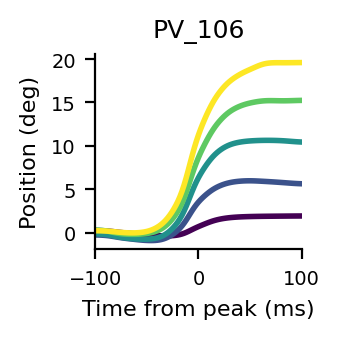

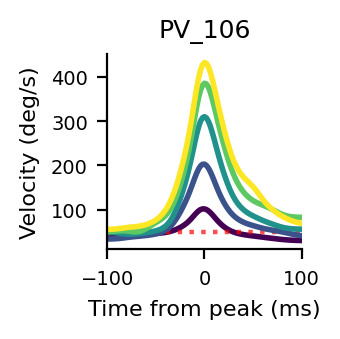

In [38]:
export_path = pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\pos_vel_traces')

figs, bundle = plot_pos_and_vel_by_amp_bins_per_animal_kernel(
    all_saccade_collection.query('animal=="PV_106"'),
    block_dict,
    bin_width_deg=5.0,
    min_amp_deg=0.5,
    t_window_ms=(-100.0, 100.0),
    dt_ms=2.0,
    bandwidth_ms=10.0,
    min_events_per_bin=30,
    per_animal_max_bins=8,
    eye_filter=None,
    subsample_peak=False,
    smoothing=True,
    normalize_velocity_to_peak=False,
    normalize_position_to_amp=False,   # classic look: 0→1
    velocity_threshold=50,            # mirrored as a vertical line (time-to-threshold) if normalized
    export_path=export_path,
    show_inline=True,
    normalize_final_curve=False,
    align_to='peak',
    position_calc='mov_axis',
    fig_size=(1.8,1.8),
    velocity_unit='deg/sec'
)


Exported to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\peak_v_amplitude_per_animal\amplitude_velocity_linear_fit_2025_10_20_20_06_56


(<Figure size 450x510 with 1 Axes>,
 <Axes: xlabel='Amplitude [deg]', ylabel='Peak V [deg/ms]'>,
 {'PV_106':    amp_lo  amp_hi     n  mean_peak_v
  0     0.0     5.0  5032     0.120375
  1     5.0    10.0  1340     0.242502
  2    10.0    15.0   403     0.371490
  3    15.0    20.0   108     0.456992
  4    20.0    25.0    51     0.508111,
  'PV_126':    amp_lo  amp_hi     n  mean_peak_v
  0     0.0     5.0  5815     0.126534
  1     5.0    10.0  1753     0.241851
  2    10.0    15.0   482     0.326007
  3    15.0    20.0   169     0.420986
  4    20.0    25.0    51     0.441457,
  'PV_143':    amp_lo  amp_hi     n  mean_peak_v
  0     0.0     5.0  2238     0.143446
  1     5.0    10.0   730     0.257574
  2    10.0    15.0   160     0.343865
  3    15.0    20.0    38     0.418390
  4    20.0    25.0    16     0.445180,
  'PV_57':    amp_lo  amp_hi     n  mean_peak_v
  0     0.0     5.0  7814     0.119861
  1     5.0    10.0  2016     0.237993
  2    10.0    15.0   731     0.344383
  3

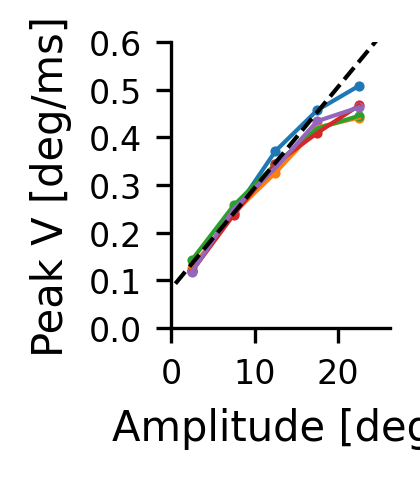

In [21]:
# This is the function for over-animal statictics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.lines as mlines
from typing import Optional, Dict, Any
from pathlib import Path
import pickle, datetime
from scipy import stats

def amplitude_velocity_over_animals_linear_fit(
    all_saccade_collection: pd.DataFrame,
    block_dict: dict,
    amp_col: Optional[str] = None,            # auto: 'net_angular_disp' or 'magnitude_raw_angular'
    eye_filter: Optional[str] = None,         # "L", "R", or None (both)
    bin_width_deg: float = 5.0,
    min_amp_deg: float = 0.5,
    max_amp_pct: float = 99.5,                # clip extreme amplitudes
    min_events_per_bin: int = 15,
    frame_rate_fps: float = 60.0,
    per_animal_color: Optional[dict] = None,  # {"PV_106":"#...", ...}
    figsize=(2.0, 1.7),
    dpi: int = 300,
    lw: float = 1.0,
    export_path: Optional[str] = None
):
    """
    Plots the relationship between saccade amplitude and peak angular velocity
    across animals, using a *linear* fit per animal or globally:

        V_peak = slope * Amplitude + intercept

    Peak velocities are in deg/ms.
    Each animal’s data are binned by amplitude and plotted as connected scatter points.
    A single black dashed line shows the global linear fit.

    Exports to a timestamped directory containing:
        - amplitude_velocity_linear_fit.pdf
        - amplitude_velocity_linear_fit_legend.pdf
        - amplitude_velocity_linear_fit_bundle.pkl
        - amplitude_velocity_linear_fit_stats.csv  (fit parameters, SEs, t, p, R²)

    Axes formatting:
      • Y-ticks start at 0, step by 0.1 (deg/ms)
      • X-axis shows 5 ticks total; labels only at 0, 10, and 20 deg.
    """

    # Helper to ensure directories
    def _ensure_dir(p: Path) -> Path:
        p.mkdir(parents=True, exist_ok=True)
        return p

    df = all_saccade_collection.copy().reset_index(drop=True)
    req = {"animal","block","eye","saccade_on_ms","saccade_off_ms"}
    if not req.issubset(df.columns):
        raise ValueError(f"all_saccade_collection must include columns {req}")

    # choose amplitude column
    if amp_col is None:
        for c in ("net_angular_disp","magnitude_raw_angular"):
            if c in df.columns:
                amp_col = c
                break
    if amp_col is None:
        raise ValueError("Need angular amplitude column: 'net_angular_disp' or 'magnitude_raw_angular'.")

    if eye_filter:
        df = df[df["eye"].astype(str).str.upper() == eye_filter.upper()].copy()

    # ---- compute per-saccade peak velocity in deg/ms ----
    have_profiles = "speed_profile_angular" in df.columns  # deg/frame when present

    def _peak_from_profile(x):
        if x is None or len(x) == 0: return np.nan
        return float(np.nanmax(np.asarray(x, dtype=float)))  # deg/frame

    def _fallback_peak(row):
        try:
            eye_df = _eye_df(block_dict, row["animal"], row["block"], row["eye"])
        except Exception:
            return np.nan
        t_ms, v_dps = _raw_velocity_trace(eye_df)  # deg/s
        if t_ms.size == 0: return np.nan
        m = (t_ms >= float(row["saccade_on_ms"])) & (t_ms <= float(row["saccade_off_ms"])) & np.isfinite(v_dps)
        if not np.any(m): return np.nan
        return float(np.nanmax(v_dps[m]))  # deg/s

    if have_profiles:
        peak_dpf = df["speed_profile_angular"].apply(_peak_from_profile).to_numpy(dtype=float)
        peak_deg_per_ms = peak_dpf * (frame_rate_fps / 1000.0)
    else:
        peak_dps = df.apply(_fallback_peak, axis=1).to_numpy(dtype=float)
        peak_deg_per_ms = peak_dps / 1000.0

    df["peak_velocity"] = peak_deg_per_ms

    # ---- filter ----
    df[amp_col] = pd.to_numeric(df[amp_col], errors="coerce")
    m_valid = np.isfinite(df[amp_col]) & np.isfinite(df["peak_velocity"]) & (df[amp_col] >= float(min_amp_deg))
    df = df[m_valid].copy()
    if df.empty:
        raise ValueError("No saccades after filtering.")

    # ---- amplitude bins ----
    amp_max = float(np.nanpercentile(df[amp_col], max_amp_pct))
    edges = np.arange(0.0, amp_max + bin_width_deg, bin_width_deg)
    if edges.size < 3:
        amp_max = max(amp_max, min_amp_deg + 3*bin_width_deg)
        edges = np.arange(0.0, amp_max + bin_width_deg, bin_width_deg)
    df["amp_bin_idx"] = pd.cut(df[amp_col], bins=edges, labels=False, include_lowest=True, right=False)

    animals = sorted(df["animal"].dropna().unique().tolist())
    per_animal_stats: Dict[str, pd.DataFrame] = {}

    for a in animals:
        sub = df[df["animal"] == a]
        rows = []
        for b in range(len(edges)-1):
            g = sub[sub["amp_bin_idx"] == b]["peak_velocity"].to_numpy(dtype=float)
            g = g[np.isfinite(g)]
            n = g.size
            mean_peak = float(np.nanmean(g)) if n >= min_events_per_bin else np.nan
            rows.append((edges[b], edges[b+1], n, mean_peak))
        per_animal_stats[a] = pd.DataFrame(rows, columns=["amp_lo","amp_hi","n","mean_peak_v"])

    # ---- linear regression with statistics ----
    def _linear_fit_with_stats(x, y):
        m = np.isfinite(x) & np.isfinite(y)
        x = np.asarray(x[m], float); y = np.asarray(y[m], float)
        n = x.size
        if n < 3 or np.allclose(x, x.mean()):
            return dict(n=n, slope=np.nan, intercept=np.nan, R2=np.nan,
                        se_slope=np.nan, t_slope=np.nan, p_slope=np.nan,
                        se_intercept=np.nan, t_intercept=np.nan, p_intercept=np.nan)
        slope, intercept = np.polyfit(x, y, 1)
        yhat = slope * x + intercept
        resid = y - yhat
        ss_res = float(np.sum(resid**2))
        ss_tot = float(np.sum((y - y.mean())**2))
        R2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan
        dof = n - 2
        s2 = ss_res / dof
        s_xx = float(np.sum((x - x.mean())**2))
        se_slope = np.sqrt(s2 / s_xx)
        se_intercept = np.sqrt(s2 * (1.0/n + (x.mean()**2)/s_xx))
        t_slope = slope / se_slope if se_slope > 0 else np.nan
        p_slope = 2.0 * stats.t.sf(np.abs(t_slope), dof) if np.isfinite(t_slope) else np.nan
        t_intercept = intercept / se_intercept if se_intercept > 0 else np.nan
        p_intercept = 2.0 * stats.t.sf(np.abs(t_intercept), dof) if np.isfinite(t_intercept) else np.nan
        return dict(n=n, slope=slope, intercept=intercept, R2=R2,
                    se_slope=se_slope, t_slope=t_slope, p_slope=p_slope,
                    se_intercept=se_intercept, t_intercept=t_intercept, p_intercept=p_intercept)

    linear_rows = []
    for a in animals:
        sub = df[df["animal"] == a]
        stats_row = _linear_fit_with_stats(sub[amp_col].to_numpy(float), sub["peak_velocity"].to_numpy(float))
        stats_row.update(animal=a)
        linear_rows.append(stats_row)
    linear_stats_df = pd.DataFrame(linear_rows)[
        ["animal","n","slope","se_slope","t_slope","p_slope","intercept","se_intercept","t_intercept","p_intercept","R2"]
    ]

    # ---- global fit for plotting ----
    global_fit = _linear_fit_with_stats(df[amp_col].to_numpy(float), df["peak_velocity"].to_numpy(float))

    # ---- plot ----
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    handles_anim, labels_anim = [], []
    for a in animals:
        S = per_animal_stats[a]
        xs = 0.5*(S["amp_lo"].to_numpy() + S["amp_hi"].to_numpy())
        ys = S["mean_peak_v"].to_numpy()
        m = np.isfinite(xs) & np.isfinite(ys)
        if not np.any(m): continue
        color = per_animal_color.get(a, None) if per_animal_color else None
        ax.scatter(xs[m], ys[m], s=6, linewidths=0, color=color)
        ln, = ax.plot(xs[m], ys[m], lw=lw, color=color, label=a)
        handles_anim.append(ln); labels_anim.append(a)

    # ---- linear fit line ----
    if np.isfinite(global_fit["slope"]) and np.isfinite(global_fit["intercept"]):
        x_line = np.linspace(float(min_amp_deg), float(edges[-1]), 200)
        y_line = global_fit["slope"] * x_line + global_fit["intercept"]
        ax.plot(x_line, y_line, ls='--', lw=lw, color='k', label='Linear fit')

    # ---- cosmetics ----
    ax.set_xlabel("Amplitude [deg]", fontsize=10)
    ax.set_ylabel("Peak V [deg/ms]", fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    for sp in ("top","right"): ax.spines[sp].set_visible(False)
    ax.set_xlim(left=0)

    # x-axis: 5 ticks total; labels only at 0,10,20
    ax.set_xticks([0,10,20])
    ax.set_xticklabels(["0","10","20"])

    # y-axis: start at 0 with 0.1 increments
    ydata_max = np.nanmax([np.nanmax(S["mean_peak_v"].to_numpy()) for S in per_animal_stats.values()] + [0.0])
    y_top = 0.1 * np.ceil((ydata_max if np.isfinite(ydata_max) else 0.0) / 0.1)
    y_top = max(y_top, 0.1)
    ax.set_ylim(0.0, y_top)
    ax.set_yticks(np.arange(0.0, y_top + 1e-9, 0.1))
    fig.tight_layout()

    # ---- export ----
    if export_path:
        ts = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        out_dir = _ensure_dir(Path(export_path) / f"amplitude_velocity_linear_fit_{ts}")

        fig.savefig(out_dir / "amplitude_velocity_linear_fit.pdf", bbox_inches="tight", dpi=dpi)
        powerlaw_item = mlines.Line2D([], [], ls='--', lw=lw, color='k', label='Linear fit')
        leg_items = handles_anim + [powerlaw_item]
        leg_labels = labels_anim + ['Linear fit']
        fig_leg = plt.figure(figsize=(2.0, 1.7), dpi=dpi)
        fig_leg.legend(leg_items, leg_labels, frameon=False, ncol=1, fontsize=8, loc="center")
        fig_leg.savefig(out_dir / "amplitude_velocity_linear_fit_legend.pdf", bbox_inches="tight", dpi=dpi)
        plt.close(fig_leg)

        bundle = dict(
            params=dict(amp_col=amp_col, bin_width_deg=bin_width_deg, min_amp_deg=min_amp_deg,
                        max_amp_pct=max_amp_pct, min_events_per_bin=min_events_per_bin,
                        frame_rate_fps=frame_rate_fps, figsize=figsize, dpi=dpi, lw=lw),
            edges=edges,
            per_animal_stats=per_animal_stats,
            global_fit=global_fit,
            linear_stats_df=linear_stats_df
        )
        with open(out_dir / "amplitude_velocity_linear_fit_bundle.pkl", "wb") as f:
            pickle.dump(bundle, f)
        linear_stats_df.to_csv(out_dir / "amplitude_velocity_linear_fit_stats.csv", index=False)
        print(f"Exported to: {out_dir}")

    return fig, ax, per_animal_stats, global_fit, linear_stats_df

export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\peak_v_amplitude_per_animal'
amplitude_velocity_over_animals_linear_fit(
    all_saccade_collection,
    block_dict,
    bin_width_deg=5.0,
    export_path=export_path,
    figsize=(1.5, 1.7)
)

Exported to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\peak_v_amplitude_per_animal\amplitude_velocity_linear_fit_2025_11_10_13_45_05


(<Figure size 450x510 with 1 Axes>,
 <Axes: xlabel='Amplitude [deg]', ylabel='Peak V [deg/ms]'>,
 {'PV_106':    amp_lo  amp_hi     n  mean_peak_v
  0     0.0     5.0  5032     0.120375
  1     5.0    10.0  1340     0.242502
  2    10.0    15.0   403     0.371490
  3    15.0    20.0   108     0.456992
  4    20.0    25.0    51     0.508111,
  'PV_126':    amp_lo  amp_hi     n  mean_peak_v
  0     0.0     5.0  5815     0.126534
  1     5.0    10.0  1753     0.241851
  2    10.0    15.0   482     0.326007
  3    15.0    20.0   169     0.420986
  4    20.0    25.0    51     0.441457,
  'PV_143':    amp_lo  amp_hi     n  mean_peak_v
  0     0.0     5.0  2238     0.143446
  1     5.0    10.0   730     0.257574
  2    10.0    15.0   160     0.343865
  3    15.0    20.0    38     0.418390
  4    20.0    25.0    16     0.445180,
  'PV_57':    amp_lo  amp_hi     n  mean_peak_v
  0     0.0     5.0  7814     0.119861
  1     5.0    10.0  2016     0.237993
  2    10.0    15.0   731     0.344383
  3

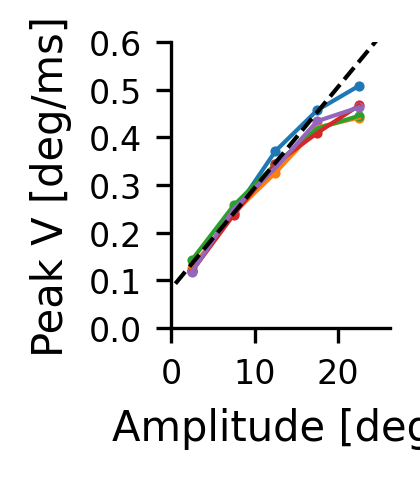

In [19]:
# --- SIMPLE, READABLE VERSION ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from pathlib import Path
from typing import Optional, Dict
import pickle, datetime
from scipy import stats

def amplitude_velocity_over_animals_linear_fit(
    all_saccade_collection: pd.DataFrame,
    block_dict: dict,
    amp_col: Optional[str] = None,            # auto: 'net_angular_disp' or 'magnitude_raw_angular'
    eye_filter: Optional[str] = None,         # "L", "R", or None (both)
    bin_width_deg: float = 5.0,
    min_amp_deg: float = 0.5,
    max_amp_pct: float = 99.5,                # clip extreme amplitudes
    min_events_per_bin: int = 15,
    frame_rate_fps: float = 60.0,
    per_animal_color: Optional[dict] = None,  # {"PV_106":"#...", ...}
    figsize=(2.0, 1.7),
    dpi: int = 300,
    lw: float = 1.0,
    export_path: Optional[str] = None
):
    """
    Over-animal amplitude vs. peak velocity with a single GLOBAL linear fit:
        V_peak = slope * Amplitude + intercept

    Exports a timestamped directory with:
      - amplitude_velocity_linear_fit.pdf
      - amplitude_velocity_linear_fit_legend.pdf
      - amplitude_velocity_linear_fit_bundle.pkl
      - amplitude_velocity_linear_fit_stats.csv  (per-animal rows + a GLOBAL row)

    p-values are computed as simple two-tailed t-tests (2*sf(|t|)); extremely small
    values may appear as 0.0 due to floating-point underflow (acceptable).
    """

    # --- utils ---
    def _ensure_dir(p: Path) -> Path:
        p.mkdir(parents=True, exist_ok=True)
        return p

    # Required columns
    df = all_saccade_collection.copy().reset_index(drop=True)
    req = {"animal","block","eye","saccade_on_ms","saccade_off_ms"}
    if not req.issubset(df.columns):
        raise ValueError(f"all_saccade_collection must include columns {req}")

    # choose amplitude column
    if amp_col is None:
        for c in ("net_angular_disp","magnitude_raw_angular"):
            if c in df.columns:
                amp_col = c
                break
    if amp_col is None:
        raise ValueError("Need angular amplitude column: 'net_angular_disp' or 'magnitude_raw_angular'.")

    if eye_filter:
        df = df[df["eye"].astype(str).str.upper() == eye_filter.upper()].copy()

    # --- per-saccade peak velocity in deg/ms ---
    have_profiles = "speed_profile_angular" in df.columns  # deg/frame if present

    def _peak_from_profile(x):
        if x is None or len(x) == 0: return np.nan
        return float(np.nanmax(np.asarray(x, dtype=float)))  # deg/frame

    def _fallback_peak(row):
        # Uses helpers already defined earlier in your notebook:
        #   _eye_df(block_dict, animal, block, eye)
        #   _raw_velocity_trace(df_eye) -> (t_ms, v_dps in deg/s)
        try:
            eye_df = _eye_df(block_dict, row["animal"], row["block"], row["eye"])
        except Exception:
            return np.nan
        t_ms, v_dps = _raw_velocity_trace(eye_df)  # deg/s
        if t_ms.size == 0: return np.nan
        m = (t_ms >= float(row["saccade_on_ms"])) & (t_ms <= float(row["saccade_off_ms"])) & np.isfinite(v_dps)
        if not np.any(m): return np.nan
        return float(np.nanmax(v_dps[m]))  # deg/s

    if have_profiles:
        peak_dpf = df["speed_profile_angular"].apply(_peak_from_profile).to_numpy(dtype=float)  # deg/frame
        peak_deg_per_ms = peak_dpf * (frame_rate_fps / 1000.0)  # deg/ms
    else:
        peak_dps = df.apply(_fallback_peak, axis=1).to_numpy(dtype=float)  # deg/s
        peak_deg_per_ms = peak_dps / 1000.0  # deg/ms

    df["peak_velocity"] = peak_deg_per_ms

    # --- filter ---
    df[amp_col] = pd.to_numeric(df[amp_col], errors="coerce")
    m_valid = np.isfinite(df[amp_col]) & np.isfinite(df["peak_velocity"]) & (df[amp_col] >= float(min_amp_deg))
    df = df[m_valid].copy()
    if df.empty:
        raise ValueError("No saccades after filtering.")

    # --- amplitude bins for display ---
    amp_max = float(np.nanpercentile(df[amp_col], max_amp_pct))
    edges = np.arange(0.0, amp_max + bin_width_deg, bin_width_deg)
    if edges.size < 3:
        amp_max = max(amp_max, min_amp_deg + 3*bin_width_deg)
        edges = np.arange(0.0, amp_max + bin_width_deg, bin_width_deg)
    df["amp_bin_idx"] = pd.cut(df[amp_col], bins=edges, labels=False, include_lowest=True, right=False)

    animals = sorted(df["animal"].dropna().unique().tolist())
    per_animal_stats: Dict[str, pd.DataFrame] = {}
    for a in animals:
        sub = df[df["animal"] == a]
        rows = []
        for b in range(len(edges)-1):
            g = sub[sub["amp_bin_idx"] == b]["peak_velocity"].to_numpy(dtype=float)
            g = g[np.isfinite(g)]
            n = g.size
            mean_peak = float(np.nanmean(g)) if n >= min_events_per_bin else np.nan
            rows.append((edges[b], edges[b+1], n, mean_peak))
        per_animal_stats[a] = pd.DataFrame(rows, columns=["amp_lo","amp_hi","n","mean_peak_v"])

    # --- linear regression + simple p-values ---
    def _fit_with_t_p(x, y):
        m = np.isfinite(x) & np.isfinite(y)
        x = np.asarray(x[m], float); y = np.asarray(y[m], float)
        n = x.size
        if n < 3 or np.allclose(x, x.mean()):
            return dict(n=n, slope=np.nan, intercept=np.nan, R2=np.nan,
                        se_slope=np.nan, t_slope=np.nan, p_slope=np.nan,
                        se_intercept=np.nan, t_intercept=np.nan, p_intercept=np.nan,
                        pearson_r=np.nan, pearson_p=np.nan)
        # OLS
        slope, intercept = np.polyfit(x, y, 1)
        yhat = slope * x + intercept
        resid = y - yhat
        ss_res = float(np.sum(resid**2))
        ss_tot = float(np.sum((y - y.mean())**2))
        R2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan
        dof = n - 2
        s2 = ss_res / dof
        s_xx = float(np.sum((x - x.mean())**2))
        se_slope = np.sqrt(s2 / s_xx)
        se_intercept = np.sqrt(s2 * (1.0/n + (x.mean()**2)/s_xx))

        t_slope = slope / se_slope if se_slope > 0 else np.nan
        t_intercept = intercept / se_intercept if se_intercept > 0 else np.nan

        # simple two-tailed p (will be 0.0 if it underflows, which is fine)
        p_slope = float(2.0 * stats.t.sf(np.abs(t_slope), dof)) if np.isfinite(t_slope) else np.nan
        p_intercept = float(2.0 * stats.t.sf(np.abs(t_intercept), dof)) if np.isfinite(t_intercept) else np.nan

        # Pearson r (correlation between x and y)
        try:
            pearson_r, pearson_p = stats.pearsonr(x, y)
        except Exception:
            pearson_r, pearson_p = np.nan, np.nan

        return dict(n=n, slope=slope, intercept=intercept, R2=R2,
                    se_slope=se_slope, t_slope=t_slope, p_slope=p_slope,
                    se_intercept=se_intercept, t_intercept=t_intercept, p_intercept=p_intercept,
                    pearson_r=pearson_r, pearson_p=pearson_p)

    # per-animal fits
    rows = []
    for a in animals:
        sub = df[df["animal"] == a]
        d = _fit_with_t_p(sub[amp_col].to_numpy(float), sub["peak_velocity"].to_numpy(float))
        d.update(animal=a)
        rows.append(d)
    cols = ["animal","n","slope","se_slope","t_slope","p_slope",
            "intercept","se_intercept","t_intercept","p_intercept",
            "pearson_r","pearson_p","R2"]
    linear_stats_df = pd.DataFrame(rows)[cols]

    # GLOBAL fit (also appended to CSV)
    global_fit = _fit_with_t_p(df[amp_col].to_numpy(float), df["peak_velocity"].to_numpy(float))
    global_row = dict(global_fit); global_row.update(animal="GLOBAL")
    global_stats_df = pd.DataFrame([global_row])[cols]

    # --- plot ---
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    handles_anim, labels_anim = [], []
    for a in animals:
        S = per_animal_stats[a]
        xs = 0.5*(S["amp_lo"].to_numpy() + S["amp_hi"].to_numpy())
        ys = S["mean_peak_v"].to_numpy()
        m = np.isfinite(xs) & np.isfinite(ys)
        if not np.any(m): continue
        color = per_animal_color.get(a, None) if per_animal_color else None
        ax.scatter(xs[m], ys[m], s=6, linewidths=0, color=color)
        ln, = ax.plot(xs[m], ys[m], lw=lw, color=color, label=a)
        handles_anim.append(ln); labels_anim.append(a)

    if np.isfinite(global_fit["slope"]) and np.isfinite(global_fit["intercept"]):
        x_line = np.linspace(float(min_amp_deg), float(edges[-1]), 200)
        y_line = global_fit["slope"] * x_line + global_fit["intercept"]
        ax.plot(x_line, y_line, ls='--', lw=lw, color='k', label='Linear fit')

    # cosmetics
    ax.set_xlabel("Amplitude [deg]", fontsize=10)
    ax.set_ylabel("Peak V [deg/ms]", fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.set_xlim(left=0)
    ax.set_xticks([0,10,20])
    ax.set_xticklabels(["0","10","20"])

    ydata_max = np.nanmax([np.nanmax(S["mean_peak_v"].to_numpy()) for S in per_animal_stats.values()] + [0.0])
    y_top = 0.1 * np.ceil((ydata_max if np.isfinite(ydata_max) else 0.0) / 0.1)
    y_top = max(y_top, 0.1)
    ax.set_ylim(0.0, y_top)
    ax.set_yticks(np.arange(0.0, y_top + 1e-9, 0.1))
    fig.tight_layout()

    # --- export ---
    if export_path:
        ts = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        out_dir = _ensure_dir(Path(export_path) / f"amplitude_velocity_linear_fit_{ts}")

        fig.savefig(out_dir / "amplitude_velocity_linear_fit.pdf", bbox_inches="tight", dpi=dpi)

        fit_item = mlines.Line2D([], [], ls='--', lw=lw, color='k', label='Linear fit')
        fig_leg = plt.figure(figsize=(2.0, 1.7), dpi=dpi)
        fig_leg.legend(handles_anim + [fit_item],
                       labels_anim + ['Linear fit'],
                       frameon=False, ncol=1, fontsize=8, loc="center")
        fig_leg.savefig(out_dir / "amplitude_velocity_linear_fit_legend.pdf", bbox_inches="tight", dpi=dpi)
        plt.close(fig_leg)

        bundle = dict(
            params=dict(amp_col=amp_col, bin_width_deg=bin_width_deg, min_amp_deg=min_amp_deg,
                        max_amp_pct=max_amp_pct, min_events_per_bin=min_events_per_bin,
                        frame_rate_fps=frame_rate_fps, figsize=figsize, dpi=dpi, lw=lw),
            edges=edges,
            per_animal_stats=per_animal_stats,
            global_fit=global_fit
        )
        with open(out_dir / "amplitude_velocity_linear_fit_bundle.pkl", "wb") as f:
            pickle.dump(bundle, f)

        # single CSV: per-animal + GLOBAL
        out_csv = pd.concat([linear_stats_df, global_stats_df], ignore_index=True)
        out_csv.to_csv(out_dir / "amplitude_velocity_linear_fit_stats.csv", index=False)

        print(f"Exported to: {out_dir}")

    return fig, ax, per_animal_stats, global_fit, linear_stats_df

export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\peak_v_amplitude_per_animal'
amplitude_velocity_over_animals_linear_fit(
    all_saccade_collection,
    block_dict,
    bin_width_deg=5.0,
    export_path=export_path,
    figsize=(1.5, 1.7))

[fit] n=6954, slope=0.02277 ± 0.00028, p_slope=2.148e-1476, R²=0.494, Pearson r=0.703, p=2.148e-1476
[fit] n=8301, slope=0.02019 ± 0.00025, p_slope=7.709e-1379, R²=0.433, Pearson r=0.658, p=7.709e-1379
[fit] n=3187, slope=0.02042 ± 0.00044, p_slope=2.763e-469, R²=0.403, Pearson r=0.635, p=2.763e-469
[fit] n=10966, slope=0.02014 ± 0.00021, p_slope=2.218e-2004, R²=0.457, Pearson r=0.676, p=2.218e-2004
[fit] n=5468, slope=0.02305 ± 0.00038, p_slope=1.044e-800, R²=0.402, Pearson r=0.634, p=1.044e-800
[fit] n=34876, slope=0.02115 ± 0.00013, p_slope=5.021e-5944, R²=0.440, Pearson r=0.663, p=5.021e-5944
Exported to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\peak_v_amplitude_per_animal\amplitude_velocity_linear_fit_2025_11_11_10_57_39


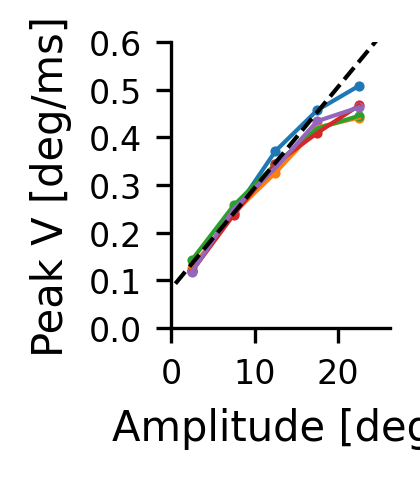

In [25]:
# === Amplitude vs. Peak Velocity — linear fit with log-safe p-values (robust) ===
import math
import datetime
from pathlib import Path
from typing import Optional, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy import stats
import pickle

# ---------- helpers (top-level) ----------
_LN10 = math.log(10.0)
_LN2PI_HALF = 0.5 * math.log(2.0 * math.pi)

def _logsf_t_robust(t_abs: float, dof: int) -> float:
    """
    log(SF_t(|t|)) with a robust fallback when SciPy underflows.
    Fallback uses the asymptotic normal tail:
        log SF(z) ≈ -z^2/2 - log(z) - 0.5*log(2π)
    This is conservative (slightly larger p than exact t-tail for huge |t|).
    """
    val = stats.t.logsf(t_abs, dof)
    if not math.isfinite(val):
        # fallback: approximate t by z for extreme tails
        z = float(t_abs)
        if z <= 0.0 or not math.isfinite(z):
            return float('-inf')
        # Mills' ratio asymptotic for N(0,1) tail
        val = -0.5 * (z * z) - math.log(z) - _LN2PI_HALF
    return val

def _format_p_from_logp(ln_p: float) -> (float, str):
    """
    Given ln(p) (natural log), return:
      - numeric p (may be 0.0 if underflow)
      - robust scientific string mantissa e exponent (never underflows)
    """
    if not math.isfinite(ln_p):
        # ln_p == -inf: display a very small bound string
        return 0.0, "<1e-9999"
    # numeric p (may underflow to 0.0)
    try:
        p_num = float(math.exp(ln_p))
    except OverflowError:
        p_num = 0.0
    # robust string
    log10_p = ln_p / _LN10
    if not math.isfinite(log10_p):
        return p_num, "<1e-9999"
    exp10 = math.floor(log10_p)
    mantissa = 10.0 ** (log10_p - exp10)
    return p_num, f"{mantissa:.3f}e{exp10:d}"

def _fit_with_t_p(x, y, *, verbose: bool = True):
    """
    OLS y ~ x with standard errors and log-safe p-values for slope/intercept,
    plus Pearson r with log-safe p as a string. Uses robust tail fallback.
    """
    x = np.asarray(x, float); y = np.asarray(y, float)
    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]
    n = x.size
    if n < 3 or np.allclose(x, x.mean()):
        if verbose: print(f"[fit] n={n} — insufficient variation for linear fit")
        return dict(n=n, slope=np.nan, intercept=np.nan, R2=np.nan,
                    se_slope=np.nan, t_slope=np.nan, p_slope=np.nan, p_slope_str="nan",
                    se_intercept=np.nan, t_intercept=np.nan, p_intercept=np.nan, p_intercept_str="nan",
                    pearson_r=np.nan, pearson_p=np.nan, pearson_p_str="nan")

    # OLS
    slope, intercept = np.polyfit(x, y, 1)
    yhat = slope * x + intercept
    resid = y - yhat
    ss_res = float(np.sum(resid**2))
    ss_tot = float(np.sum((y - y.mean())**2))
    R2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan
    dof = max(1, n - 2)
    s2 = ss_res / dof
    s_xx = float(np.sum((x - x.mean())**2))
    s_xx = max(s_xx, 1e-300)
    se_slope = np.sqrt(s2 / s_xx)
    se_intercept = np.sqrt(s2 * (1.0/n + (x.mean()**2)/s_xx))

    t_slope = slope / se_slope if se_slope > 0 else np.nan
    t_intercept = intercept / se_intercept if se_intercept > 0 else np.nan

    # log-safe p-values for t-tests (two-tailed)
    if np.isfinite(t_slope):
        ln_sf = _logsf_t_robust(abs(t_slope), dof)           # ln one-tailed
        ln_p = ln_sf + math.log(2.0)                         # ln two-tailed
        p_slope, p_slope_str = _format_p_from_logp(ln_p)
    else:
        p_slope, p_slope_str = np.nan, "nan"

    if np.isfinite(t_intercept):
        ln_sf = _logsf_t_robust(abs(t_intercept), dof)
        ln_p = ln_sf + math.log(2.0)
        p_intercept, p_intercept_str = _format_p_from_logp(ln_p)
    else:
        p_intercept, p_intercept_str = np.nan, "nan"

    # Pearson r + log-safe p string
    try:
        pearson_r, pearson_p_num = stats.pearsonr(x, y)
        if (pearson_p_num == 0.0) or (not np.isfinite(pearson_p_num)):
            # derive t for r and reuse robust tail
            t_r = abs(pearson_r) * np.sqrt((n-2) / max(1e-300, (1.0 - pearson_r**2)))
            ln_sf = _logsf_t_robust(t_r, n-2)
            ln_p = ln_sf + math.log(2.0)
            pearson_p_num, pearson_p_str = _format_p_from_logp(ln_p)
        else:
            ln_p = math.log(pearson_p_num)
            _, pearson_p_str = _format_p_from_logp(ln_p)
    except Exception:
        pearson_r, pearson_p_num, pearson_p_str = np.nan, np.nan, "nan"

    if verbose:
        print(f"[fit] n={n}, slope={slope:.5f} ± {se_slope:.5f}, "
              f"p_slope={p_slope_str}, R²={R2:.3f}, "
              f"Pearson r={pearson_r:.3f}, p={pearson_p_str}", flush=True)

    return dict(n=n, slope=slope, intercept=intercept, R2=R2,
                se_slope=se_slope, t_slope=t_slope, p_slope=p_slope, p_slope_str=p_slope_str,
                se_intercept=se_intercept, t_intercept=t_intercept, p_intercept=p_intercept, p_intercept_str=p_intercept_str,
                pearson_r=pearson_r, pearson_p=pearson_p_num, pearson_p_str=pearson_p_str)

# ---------- main function ----------
def amplitude_velocity_over_animals_linear_fit(
    all_saccade_collection: pd.DataFrame,
    block_dict: dict,
    amp_col: Optional[str] = None,            # auto: 'net_angular_disp' or 'magnitude_raw_angular'
    eye_filter: Optional[str] = None,         # "L", "R", or None (both)
    bin_width_deg: float = 5.0,
    min_amp_deg: float = 0.5,
    max_amp_pct: float = 99.5,                # clip extreme amplitudes
    min_events_per_bin: int = 15,
    frame_rate_fps: float = 60.0,
    per_animal_color: Optional[dict] = None,  # {"PV_106":"#...", ...}
    figsize=(2.0, 1.7),
    dpi: int = 300,
    lw: float = 1.0,
    export_path: Optional[str] = None
):
    """
    Over-animal amplitude vs. peak velocity with a single GLOBAL linear fit:
        V_peak = slope * Amplitude + intercept

    Exports a timestamped directory with:
      - amplitude_velocity_linear_fit.pdf
      - amplitude_velocity_linear_fit_legend.pdf
      - amplitude_velocity_linear_fit_bundle.pkl
      - amplitude_velocity_linear_fit_stats.csv  (per-animal rows + a GLOBAL row)

    p-values are computed with a robust tail fallback; CSV also includes *_str columns.
    """

    # --- utils ---
    def _ensure_dir(p: Path) -> Path:
        p.mkdir(parents=True, exist_ok=True)
        return p

    # Required columns
    df = all_saccade_collection.copy().reset_index(drop=True)
    req = {"animal","block","eye","saccade_on_ms","saccade_off_ms"}
    if not req.issubset(df.columns):
        raise ValueError(f"all_saccade_collection must include columns {req}")

    # choose amplitude column
    if amp_col is None:
        for c in ("net_angular_disp","magnitude_raw_angular"):
            if c in df.columns:
                amp_col = c
                break
    if amp_col is None:
        raise ValueError("Need angular amplitude column: 'net_angular_disp' or 'magnitude_raw_angular'.")

    if eye_filter:
        df = df[df["eye"].astype(str).str.upper() == eye_filter.upper()].copy()

    # --- per-saccade peak velocity in deg/ms ---
    have_profiles = "speed_profile_angular" in df.columns  # deg/frame if present

    def _peak_from_profile(x):
        if x is None or len(x) == 0: return np.nan
        return float(np.nanmax(np.asarray(x, dtype=float)))  # deg/frame

    def _fallback_peak(row):
        try:
            eye_df = _eye_df(block_dict, row["animal"], row["block"], row["eye"])
        except Exception:
            return np.nan
        t_ms, v_dps = _raw_velocity_trace(eye_df)  # deg/s
        if t_ms.size == 0: return np.nan
        m = (t_ms >= float(row["saccade_on_ms"])) & (t_ms <= float(row["saccade_off_ms"])) & np.isfinite(v_dps)
        if not np.any(m): return np.nan
        return float(np.nanmax(v_dps[m]))  # deg/s

    if have_profiles:
        peak_dpf = df["speed_profile_angular"].apply(_peak_from_profile).to_numpy(dtype=float)  # deg/frame
        peak_deg_per_ms = peak_dpf * (frame_rate_fps / 1000.0)  # deg/ms
    else:
        peak_dps = df.apply(_fallback_peak, axis=1).to_numpy(dtype=float)  # deg/s
        peak_deg_per_ms = peak_dps / 1000.0  # deg/ms

    df["peak_velocity"] = peak_deg_per_ms

    # --- filter ---
    df[amp_col] = pd.to_numeric(df[amp_col], errors="coerce")
    m_valid = np.isfinite(df[amp_col]) & np.isfinite(df["peak_velocity"]) & (df[amp_col] >= float(min_amp_deg))
    df = df[m_valid].copy()
    if df.empty:
        raise ValueError("No saccades after filtering.")

    # --- amplitude bins for display ---
    amp_max = float(np.nanpercentile(df[amp_col], max_amp_pct))
    edges = np.arange(0.0, amp_max + bin_width_deg, bin_width_deg)
    if edges.size < 3:
        amp_max = max(amp_max, min_amp_deg + 3*bin_width_deg)
        edges = np.arange(0.0, amp_max + bin_width_deg, bin_width_deg)
    df["amp_bin_idx"] = pd.cut(df[amp_col], bins=edges, labels=False, include_lowest=True, right=False)

    animals = sorted(df["animal"].dropna().unique().tolist())
    per_animal_stats: Dict[str, pd.DataFrame] = {}
    for a in animals:
        sub = df[df["animal"] == a]
        rows = []
        for b in range(len(edges)-1):
            g = sub[sub["amp_bin_idx"] == b]["peak_velocity"].to_numpy(dtype=float)
            g = g[np.isfinite(g)]
            n = g.size
            mean_peak = float(np.nanmean(g)) if n >= min_events_per_bin else np.nan
            rows.append((edges[b], edges[b+1], n, mean_peak))
        per_animal_stats[a] = pd.DataFrame(rows, columns=["amp_lo","amp_hi","n","mean_peak_v"])

    # --- per-animal fits ---
    rows = []
    for a in animals:
        sub = df[df["animal"] == a]
        d = _fit_with_t_p(sub[amp_col].to_numpy(float), sub["peak_velocity"].to_numpy(float), verbose=True)
        d.update(animal=a)
        rows.append(d)

    cols = ["animal","n","slope","se_slope","t_slope","p_slope","p_slope_str",
            "intercept","se_intercept","t_intercept","p_intercept","p_intercept_str",
            "pearson_r","pearson_p","pearson_p_str","R2"]
    linear_stats_df = pd.DataFrame(rows)[cols]

    # --- GLOBAL fit ---
    global_fit = _fit_with_t_p(df[amp_col].to_numpy(float), df["peak_velocity"].to_numpy(float), verbose=True)
    global_row = dict(global_fit); global_row.update(animal="GLOBAL")
    global_stats_df = pd.DataFrame([global_row])[cols]

    # --- plot ---
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    handles_anim, labels_anim = [], []
    for a in animals:
        S = per_animal_stats[a]
        xs = 0.5*(S["amp_lo"].to_numpy() + S["amp_hi"].to_numpy())
        ys = S["mean_peak_v"].to_numpy()
        m = np.isfinite(xs) & np.isfinite(ys)
        if not np.any(m):
            continue
        color = (per_animal_color or {}).get(a, None)
        ax.scatter(xs[m], ys[m], s=6, linewidths=0, color=color)
        ln, = ax.plot(xs[m], ys[m], lw=lw, color=color, label=a)
        handles_anim.append(ln); labels_anim.append(a)

    if np.isfinite(global_fit["slope"]) and np.isfinite(global_fit["intercept"]):
        x_line = np.linspace(float(min_amp_deg), float(edges[-1]), 200)
        y_line = global_fit["slope"] * x_line + global_fit["intercept"]
        ax.plot(x_line, y_line, ls='--', lw=lw, color='k', label='Linear fit')

    # cosmetics
    ax.set_xlabel("Amplitude [deg]", fontsize=10)
    ax.set_ylabel("Peak V [deg/ms]", fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.set_xlim(left=0)
    ax.set_xticks([0,10,20]); ax.set_xticklabels(["0","10","20"])

    ydata_max = np.nanmax([np.nanmax(S["mean_peak_v"].to_numpy()) for S in per_animal_stats.values()] + [0.0])
    y_top = 0.1 * np.ceil((ydata_max if np.isfinite(ydata_max) else 0.0) / 0.1)
    y_top = max(y_top, 0.1)
    ax.set_ylim(0.0, y_top)
    ax.set_yticks(np.arange(0.0, y_top + 1e-9, 0.1))
    fig.tight_layout()

    # --- export ---
    if export_path:
        ts = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        out_dir = _ensure_dir(Path(export_path) / f"amplitude_velocity_linear_fit_{ts}")

        fig.savefig(out_dir / "amplitude_velocity_linear_fit.pdf", bbox_inches="tight", dpi=dpi)

        fit_item = mlines.Line2D([], [], ls='--', lw=lw, color='k', label='Linear fit')
        fig_leg = plt.figure(figsize=(2.0, 1.7), dpi=dpi)
        fig_leg.legend(handles_anim + [fit_item],
                       labels_anim + ['Linear fit'],
                       frameon=False, ncol=1, fontsize=8, loc="center")
        fig_leg.savefig(out_dir / "amplitude_velocity_linear_fit_legend.pdf", bbox_inches="tight", dpi=dpi)
        plt.close(fig_leg)

        bundle = dict(
            params=dict(amp_col=amp_col, bin_width_deg=bin_width_deg, min_amp_deg=min_amp_deg,
                        max_amp_pct=max_amp_pct, min_events_per_bin=min_events_per_bin,
                        frame_rate_fps=frame_rate_fps, figsize=figsize, dpi=dpi, lw=lw),
            edges=edges,
            per_animal_stats=per_animal_stats,
            global_fit=global_fit
        )
        with open(out_dir / "amplitude_velocity_linear_fit_bundle.pkl", "wb") as f:
            pickle.dump(bundle, f)

        # single CSV: per-animal + GLOBAL
        out_csv = pd.concat([linear_stats_df, global_stats_df], ignore_index=True)
        out_csv.to_csv(out_dir / "amplitude_velocity_linear_fit_stats.csv", index=False)

        print(f"Exported to: {out_dir}")

    return fig, ax, per_animal_stats, global_fit, linear_stats_df

# --- optional quick sanity check (extreme tail; should no longer Overflow) ---
fig, ax, per_animal_stats, global_fit, linear_stats_df = amplitude_velocity_over_animals_linear_fit(
    all_saccade_collection,
    block_dict,
    bin_width_deg=5.0,
    export_path=r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\peak_v_amplitude_per_animal',
    figsize=(1.5, 1.7)
)


In [38]:

# This one worked on the 13.9.25
import datetime
import pickle
from pathlib import Path
from typing import Optional, Tuple, Sequence, Dict, Any, List, Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.ndimage import gaussian_filter1d

# ---------- helpers ----------

def _ensure_dir(p: Union[str, Path]) -> Path:
    p = Path(p)
    p.mkdir(parents=True, exist_ok=True)
    return p

def _save_legend_as_pdf(ax: plt.Axes, out_path: Union[str, Path], ncol=2, fontsize=6, frameon=False):
    leg = ax.legend(frameon=frameon, fontsize=fontsize, ncol=ncol)
    if leg is None:
        return
    fig_leg = leg.figure
    fig_leg.canvas.draw()
    fig_leg.savefig(out_path, bbox_inches="tight", dpi=300)

def _block_key(animal, block_num):
    return f"{animal}_block_{int(block_num):03d}", f"{animal}_block_{int(block_num)}"

def _eye_df(block_dict, animal, block_num, eye):
    k1, k2 = _block_key(animal, block_num)
    blk = block_dict.get(k1, block_dict.get(k2, None))
    if blk is None:
        raise KeyError(f"Block not found for {animal} block {block_num} (tried {k1} / {k2})")
    df = blk.left_eye_data if str(eye).upper() == "L" else blk.right_eye_data
    need = {"ms_axis","k_phi","k_theta"}
    if not need.issubset(df.columns):
        raise ValueError(f"Eye dataframe missing columns: {need - set(df.columns)}")
    return df

def _raw_velocity_trace(df_eye):
    t = df_eye["ms_axis"].to_numpy(dtype=float)
    phi = df_eye["k_phi"].to_numpy(dtype=float)
    th  = df_eye["k_theta"].to_numpy(dtype=float)
    dphi = np.diff(phi); dth = np.diff(th); dt_s = np.diff(t) / 1000.0
    v_dps = np.divide(np.hypot(dphi, dth), dt_s, out=np.full_like(dphi, np.nan), where=dt_s>0)
    t_ms = t[1:]
    return t_ms, v_dps

def _peak_time_in_window(t_ms, v_dps, on_ms, off_ms, subsample_peak=False):
    m = (t_ms >= on_ms) & (t_ms <= off_ms) & np.isfinite(v_dps)
    if not np.any(m):
        return np.nan
    v = v_dps[m]; tloc = t_ms[m]
    i = int(np.nanargmax(v))
    if (not subsample_peak) or i == 0 or i == v.size-1:
        return float(tloc[i])
    v_1, v0, v1 = v[i-1], v[i], v[i+1]
    denom = (v_1 - 2*v0 + v1)
    if not np.isfinite(denom) or denom == 0:
        return float(tloc[i])
    d = 0.5*(v_1 - v1)/denom
    d = float(np.clip(d, -1.0, 1.0))
    dt_local = (tloc[min(i+1, v.size-1)] - tloc[max(i-1, 0)]) / 2.0
    return float(tloc[i] + d * dt_local)

def _first_cross_time(t, y, ythr):
    """Linear-interpolated first time where y(t) >= ythr. Returns None if no crossing."""
    t = np.asarray(t); y = np.asarray(y)
    if t.size < 2 or not np.isfinite(ythr): return None
    valid = np.isfinite(y)
    t = t[valid]; y = y[valid]
    if t.size < 2: return None
    y0, y1 = y[:-1], y[1:]
    t0, t1 = t[:-1], t[1:]
    s0, s1 = y0 - ythr, y1 - ythr
    cross_idx = np.where((s0 <= 0) & (s1 >= 0) | (s0 >= 0) & (s1 <= 0) | (np.isclose(y0, ythr)))[0]
    if cross_idx.size == 0:
        return None
    k = int(cross_idx[0])
    if np.isclose(y0[k], ythr):
        return float(t0[k])
    denom = (y1[k] - y0[k])
    if np.isclose(denom, 0.0):
        return float(t0[k])
    frac = (ythr - y0[k]) / denom
    frac = float(np.clip(frac, 0.0, 1.0))
    return float(t0[k] + frac * (t1[k] - t0[k]))


# ------------------------- main plotting + export ------------------------- #

def plot_velocity_by_amp_bins_per_animal_kernel(
    all_saccade_collection: pd.DataFrame,
    block_dict: dict,
    amp_col: Optional[str] = None,       # auto-pick if None
    bin_width_deg: float = 5.0,
    min_amp_deg: float = 0.5,
    t_window_ms: Tuple[float, float] = (-40.0, 80.0),
    dt_ms: float = 2.0,                  # grid step
    bandwidth_ms: float = 10.0,          # Gaussian kernel across time bins
    min_events_per_bin: int = 30,
    per_animal_max_bins: int = 8,
    eye_filter: Optional[str] = None,    # "L", "R", or None (both)
    subsample_peak: bool = False,        # sub-frame peak alignment
    smoothing: bool = True,              # kernel smoothing (group-level)
    plot_bins_as_scatter: bool = True,   # when not smoothing, markers+line
    min_bin_count: int = 3,              # ignore sparse bins (unsmoothed)
    errorbars: bool = False,             # show SD as error bars (unsmoothed)
    normalize_to_peak: bool = False,     # divide each curve by its own peak (after averaging)
    velocity_threshold: float = None,    # deg/s (raw) or used to derive relative crossings (normalized)
    # vertical/horizontal threshold line styling
    vline_kwargs: dict = None,
    hline_kwargs: dict = None,
    # --- export controls ---
    export_path: Optional[Union[Path, str]] = None,
    fig_size: Tuple[float, float] = (4.0, 2.8),
    dpi: int = 200,
    legend_ncol: int = 2,
    bin_cmap: str = "viridis",
    # --- display control ---
    show_inline: bool = True            # NEW: keep figs open for inline display
):
    """
    Plots velocity profiles per amplitude bin. If export_path is provided, writes per-animal PDFs
    and a single pickle bundle containing all curves for exact reproduction.
    """
    # styles
    if vline_kwargs is None: vline_kwargs = dict(ls=":", lw=1.6, alpha=0.9)
    if hline_kwargs is None: hline_kwargs = dict(ls=":", lw=1.6, color="red", alpha=0.7)

    df = all_saccade_collection.reset_index(drop=True).copy()
    req = {"animal","block","eye","saccade_on_ms","saccade_off_ms"}
    if not req.issubset(df.columns):
        raise ValueError(f"DataFrame must have {req}")

    # choose amplitude column
    if amp_col is None:
        for c in ("net_angular_disp","magnitude_raw_angular"):
            if c in df.columns:
                amp_col = c; break
    if amp_col is None:
        raise ValueError("Need 'net_angular_disp' or 'magnitude_raw_angular'.")
    df[amp_col] = pd.to_numeric(df[amp_col], errors="coerce")

    if eye_filter:
        df = df[df["eye"].str.upper() == eye_filter.upper()]

    animals = sorted(df["animal"].dropna().unique().tolist())

    tmin, tmax = float(t_window_ms[0]), float(t_window_ms[1])
    t_grid = np.arange(tmin, tmax + dt_ms, dt_ms); nb = len(t_grid)
    sigma_bins = max(1.0, float(bandwidth_ms) / float(dt_ms))
    cmap = colormaps.get_cmap(bin_cmap)

    # export root + bundle
    root_out = None
    bundle: Dict[str, Any] = {
        "t_grid": t_grid.astype(np.float32),
        "params": dict(
            amp_col=amp_col,
            bin_width_deg=bin_width_deg,
            min_amp_deg=min_amp_deg,
            t_window_ms=tuple(t_window_ms),
            dt_ms=float(dt_ms),
            bandwidth_ms=float(bandwidth_ms),
            min_events_per_bin=int(min_events_per_bin),
            per_animal_max_bins=int(per_animal_max_bins),
            eye_filter=(None if eye_filter is None else str(eye_filter)),
            subsample_peak=bool(subsample_peak),
            smoothing=bool(smoothing),
            plot_bins_as_scatter=bool(plot_bins_as_scatter),
            min_bin_count=int(min_bin_count),
            normalize_to_peak=bool(normalize_to_peak),
            velocity_threshold=(None if velocity_threshold is None else float(velocity_threshold)),
            legend_ncol=int(legend_ncol),
            bin_cmap=str(bin_cmap),
        ),
        "animals": {}  # animal -> dict(labels, edges, series[])
    }
    if export_path is not None:
        export_path = Path(export_path)
        ts = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        root_out = _ensure_dir(export_path / f"velocity_by_amp_bins_{ts}")

    figs: List[plt.Figure] = []
    for a in animals:
        sub = df[(df["animal"]==a) & (df[amp_col] >= float(min_amp_deg))].copy()
        if sub.empty:
            continue

        # amplitude bins
        max_amp = float(np.nanpercentile(sub[amp_col], 99.5))
        edges = np.arange(0.0, max_amp + bin_width_deg, bin_width_deg)
        if len(edges) > per_animal_max_bins+1:
            edges = edges[:per_animal_max_bins+1]
        labels = [f"{int(edges[i])}-{int(edges[i+1])}°" for i in range(len(edges)-1)]
        sub["amp_bin"] = pd.cut(sub[amp_col], bins=edges, labels=labels, include_lowest=True, right=False)

        # figure
        fig, ax = plt.subplots(1,1, figsize=fig_size, dpi=dpi)
        plotted_any = False
        hline_plotted = False

        # bundle for this animal
        pack = {
            "animal": a,
            "labels": labels,
            "edges": edges.tolist(),
            "series": []  # each: dict(raw_label, label, color_rgba, n_events, center[], lo[], hi[])
        }

        for i, lab in enumerate(labels):
            g = sub[sub["amp_bin"] == lab]
            n_events = int(len(g))
            if n_events < min_events_per_bin:
                continue

            # accumulators
            num  = np.zeros(nb, dtype=float)   # sum v
            num2 = np.zeros(nb, dtype=float)   # sum v^2
            den  = np.zeros(nb, dtype=float)   # count

            # accumulate native samples aligned to peak
            for _, row in g.iterrows():
                try:
                    eye_df = _eye_df(block_dict, row["animal"], row["block"], row["eye"])
                except Exception:
                    continue
                t_ms, v_dps = _raw_velocity_trace(eye_df)
                if t_ms.size < 3:
                    continue
                pk_ms = _peak_time_in_window(t_ms, v_dps,
                                             float(row["saccade_on_ms"]),
                                             float(row["saccade_off_ms"]),
                                             subsample_peak=subsample_peak)
                if not np.isfinite(pk_ms):
                    continue
                m = (t_ms >= pk_ms + tmin) & (t_ms <= pk_ms + tmax) & np.isfinite(v_dps)
                if not np.any(m):
                    continue
                t_rel = t_ms[m] - pk_ms
                v     = v_dps[m]
                idx = np.floor((t_rel - tmin) / dt_ms).astype(int)
                ok = (idx >= 0) & (idx < nb)
                if not np.any(ok):
                    continue
                np.add.at(num,  idx[ok], v[ok])
                np.add.at(num2, idx[ok], v[ok]**2)
                np.add.at(den,  idx[ok], 1.0)

            if den.sum() == 0:
                continue

            # smoothing or raw
            if smoothing and bandwidth_ms > 0:
                num_s  = gaussian_filter1d(num,  sigma=sigma_bins, mode='nearest')
                num2_s = gaussian_filter1d(num2, sigma=sigma_bins, mode='nearest')
                den_s  = gaussian_filter1d(den,  sigma=sigma_bins, mode='nearest')
                mean_raw = np.divide(num_s, den_s, out=np.full(nb, np.nan), where=den_s > 1e-6)
                var  = np.divide(num2_s, den_s, out=np.full(nb, np.nan), where=den_s > 1e-6) - np.square(mean_raw)
                std  = np.sqrt(np.clip(var, 0.0, None))
                tg = t_grid; mg = mean_raw.copy(); sg = std.copy()
            else:
                mean_raw = np.divide(num, den, out=np.full(nb, np.nan), where=den > 1e-6)
                var  = np.divide(num2, den, out=np.full(nb, np.nan), where=den > 1e-6) - np.square(mean_raw)
                std  = np.sqrt(np.clip(var, 0.0, None))
                # display only well-populated bins
                valid = (den >= max(1, min_bin_count)) & np.isfinite(mean_raw)
                tg = t_grid[valid]; mg = mean_raw[valid]; sg = std[valid]

            # normalization (per-curve, after averaging)
            peak_raw = np.nanmax(mean_raw)  # full-grid peak (before display filtering)
            if normalize_to_peak and np.isfinite(peak_raw) and peak_raw > 0:
                mg_disp  = (mg / peak_raw)
                sg_disp  = (sg / peak_raw)
                mean_export = (mean_raw / peak_raw)  # full-grid normalized (for bundle)
                lo_export   = mean_export - (std / peak_raw)
                hi_export   = mean_export + (std / peak_raw)
                ylab = "Velocity (norm. to peak)"
            else:
                mg_disp  = mg
                sg_disp  = sg
                mean_export = mean_raw
                lo_export   = mean_raw - std
                hi_export   = mean_raw + std
                ylab = "Velocity (deg/s)"

            c = cmap(i / max(1, len(labels)-1))

            # plot
            if smoothing and bandwidth_ms > 0:
                ax.plot(tg, mg_disp, lw=2, color=c, label=f"{lab} (n={n_events})")
                ax.fill_between(tg, mg_disp - sg_disp, mg_disp + sg_disp, color=c, alpha=0.15, linewidth=0)
            else:
                if plot_bins_as_scatter:
                    ax.plot(tg, mg_disp, lw=1.4, color=c, label=f"{lab} (n={n_events})")
                    ax.scatter(tg, mg_disp, s=10, color=c, zorder=3)
                    if errorbars:
                        ax.errorbar(tg, mg_disp, yerr=sg_disp, fmt='none', ecolor=c, elinewidth=0.8, alpha=0.6)
                else:
                    ax.plot(tg, mg_disp, lw=1.2, color=c, label=f"{lab} (n={n_events})")

            # threshold visualization
            if velocity_threshold is not None:
                if normalize_to_peak and np.isfinite(peak_raw) and peak_raw > 0:
                    thr_rel = float(velocity_threshold) / peak_raw
                    t_cross = _first_cross_time(tg, mg_disp, thr_rel)
                    if t_cross is not None:
                        ax.axvline(t_cross, color=c, **vline_kwargs)
                else:
                    if not hline_plotted:
                        ax.axhline(y=float(velocity_threshold), **hline_kwargs)
                        hline_plotted = True

            plotted_any = True

            # store series into bundle (always full-grid arrays)
            pack["series"].append({
                "raw_label": lab,
                "label": f"{lab} (n={n_events})",
                "n_events": n_events,
                "color_rgba": tuple(c),
                "center": mean_export.astype(np.float32),
                "lo": (lo_export.astype(np.float32) if isinstance(lo_export, np.ndarray) else np.array(lo_export, dtype=np.float32)),
                "hi": (hi_export.astype(np.float32) if isinstance(hi_export, np.ndarray) else np.array(hi_export, dtype=np.float32))
            })

        # axes cosmetics
        ax.set_title(a, fontsize=9)
        ax.set_xlabel("Time from peak (ms)", fontsize=8)
        ax.set_ylabel(ylab, fontsize=8)
        ax.tick_params(labelsize=7)
        ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
        ax.set_xlim(tmin, tmax); ax.set_ylim(bottom=0)
        if plotted_any:
            ax.legend(frameon=False, fontsize=6, ncol=legend_ncol)
        fig.tight_layout()
        figs.append(fig)

        bundle["animals"][a] = pack

        # export per-animal PDFs (figure + legend)
        if root_out is not None:
            subdir = _ensure_dir(root_out / f"{a}")
            fig.savefig(subdir / f"{a}_velocity_by_amp_bins.pdf", bbox_inches="tight", dpi=dpi)
            _save_legend_as_pdf(ax, subdir / f"{a}_legend.pdf", ncol=legend_ncol, fontsize=6, frameon=False)

        # inline vs batch
        if not show_inline:
            plt.close(fig)

    # write bundle
    if root_out is not None:
        with open(root_out / "velocity_by_amp_bins_bundle.pkl", "wb") as f:
            pickle.dump(bundle, f)
        print(f"Exported to: {root_out}")

    return figs, bundle


# -------------------------- re-plot from pickle --------------------------- #

def replot_velocity_by_amp_bins_from_pickle(
    bundle_pickle_path: Union[Path, str],
    animals: Optional[Sequence[str]] = None,          # None = all in bundle
    fig_size: Tuple[float, float] = (4.0, 2.8),
    dpi: int = 200,
    save_pdfs: bool = True,
    export_path: Optional[Union[Path, str]] = None,
    legend_ncol: Optional[int] = None
):
    """
    Recreates figures from the saved bundle (exactly reproduces center and bands).
    """
    bundle_pickle_path = Path(bundle_pickle_path)
    with open(bundle_pickle_path, "rb") as f:
        bundle = pickle.load(f)

    t_grid = np.array(bundle["t_grid"])
    available = sorted(bundle["animals"].keys())
    if animals is None:
        animals_use = available
    else:
        animals_use = [a for a in animals if a in available]

    if legend_ncol is None:
        legend_ncol = int(bundle.get("params", {}).get("legend_ncol", 2))

    out_root = None
    if export_path is not None:
        export_path = Path(export_path)
        ts = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        out_root = _ensure_dir(export_path / f"velocity_by_amp_bins_REPLOT_{ts}")

    figs: Dict[str, Tuple[plt.Figure, plt.Axes]] = {}
    for a in animals_use:
        pack = bundle["animals"][a]
        fig, ax = plt.subplots(1,1, figsize=fig_size, dpi=dpi)
        plotted = False

        for s in pack["series"]:
            center = np.asarray(s["center"], dtype=float)
            lo     = np.asarray(s["lo"], dtype=float)
            hi     = np.asarray(s["hi"], dtype=float)
            c      = s["color_rgba"]
            ax.plot(t_grid, center, lw=2, color=c, label=s["label"])
            ax.fill_between(t_grid, lo, hi, color=c, alpha=0.15, linewidth=0)
            plotted = True

        ax.set_title(a, fontsize=9)
        ax.set_xlabel("Time from peak (ms)", fontsize=8)
        ylab = "Velocity (deg/s)"
        if bool(bundle["params"].get("normalize_to_peak", False)):
            ylab = "Velocity (norm. to peak)"
        ax.set_ylabel(ylab, fontsize=8)
        ax.tick_params(labelsize=7)
        ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
        tmin, tmax = bundle["params"]["t_window_ms"]
        ax.set_xlim(tmin, tmax)
        ax.set_ylim(bottom=0)
        if plotted:
            ax.legend(frameon=False, fontsize=6, ncol=legend_ncol)
        fig.tight_layout()

        figs[a] = (fig, ax)

        if out_root is not None and save_pdfs:
            subdir = _ensure_dir(out_root / f"{a}")
            fig.savefig(subdir / f"{a}_velocity_by_amp_bins.pdf", bbox_inches="tight", dpi=dpi)
            _save_legend_as_pdf(ax, subdir / f"{a}_legend.pdf", ncol=legend_ncol, fontsize=6, frameon=False)

    if out_root is not None and save_pdfs:
        try:
            import shutil
            shutil.copy2(str(bundle_pickle_path), str(out_root / Path(bundle_pickle_path).name))
        except Exception:
            pass

    return figs
export_path = pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\peak_v_amplitude_poly_traces_normalized')
figs,bundle = plot_velocity_by_amp_bins_per_animal_kernel(
    all_saccade_collection,
    block_dict,
    bin_width_deg = 5.0,
    min_amp_deg=0.5,
    t_window_ms = (-200.0, 100.0),
    dt_ms = 2.0,
    bandwidth_ms= 10.0,
    min_events_per_bin= 30,
    per_animal_max_bins = 8,
    eye_filter = None,
    subsample_peak = False,
    smoothing= False,
    normalize_to_peak = True,     # NEW
    velocity_threshold = 50,
    export_path = export_path# NEW
)

In [37]:
import datetime
import pickle
from pathlib import Path
from typing import Optional, Tuple, Sequence, Dict, Any, List, Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.ndimage import gaussian_filter1d

# ---------- helpers ----------

def _ensure_dir(p: Union[str, Path]) -> Path:
    p = Path(p)
    p.mkdir(parents=True, exist_ok=True)
    return p

def _save_legend_as_pdf(ax: plt.Axes, out_path: Union[str, Path], ncol=2, fontsize=6, frameon=False):
    leg = ax.legend(frameon=frameon, fontsize=fontsize, ncol=ncol)
    if leg is None:
        return
    fig_leg = leg.figure
    fig_leg.canvas.draw()
    fig_leg.savefig(out_path, bbox_inches="tight", dpi=300)

def _block_key(animal, block_num):
    return f"{animal}_block_{int(block_num):03d}", f"{animal}_block_{int(block_num)}"

def _eye_df(block_dict, animal, block_num, eye):
    k1, k2 = _block_key(animal, block_num)
    blk = block_dict.get(k1, block_dict.get(k2, None))
    if blk is None:
        raise KeyError(f"Block not found for {animal} block {block_num} (tried {k1} / {k2})")
    df = blk.left_eye_data if str(eye).upper() == "L" else blk.right_eye_data
    need = {"ms_axis","k_phi","k_theta"}
    if not need.issubset(df.columns):
        raise ValueError(f"Eye dataframe missing columns: {need - set(df.columns)}")
    return df

def _raw_velocity_trace(df_eye):
    t = df_eye["ms_axis"].to_numpy(dtype=float)
    phi = df_eye["k_phi"].to_numpy(dtype=float)
    th  = df_eye["k_theta"].to_numpy(dtype=float)
    dphi = np.diff(phi); dth = np.diff(th); dt_s = np.diff(t) / 1000.0
    v_dps = np.divide(np.hypot(dphi, dth), dt_s, out=np.full_like(dphi, np.nan), where=dt_s>0)
    t_ms = t[1:]
    return t_ms, v_dps

def _peak_time_in_window(t_ms, v_dps, on_ms, off_ms, subsample_peak=False):
    m = (t_ms >= on_ms) & (t_ms <= off_ms) & np.isfinite(v_dps)
    if not np.any(m):
        return np.nan
    v = v_dps[m]; tloc = t_ms[m]
    i = int(np.nanargmax(v))
    if (not subsample_peak) or i == 0 or i == v.size-1:
        return float(tloc[i])
    v_1, v0, v1 = v[i-1], v[i], v[i+1]
    denom = (v_1 - 2*v0 + v1)
    if not np.isfinite(denom) or denom == 0:
        return float(tloc[i])
    d = 0.5*(v_1 - v1)/denom
    d = float(np.clip(d, -1.0, 1.0))
    dt_local = (tloc[min(i+1, v.size-1)] - tloc[max(i-1, 0)]) / 2.0
    return float(tloc[i] + d * dt_local)

def _first_cross_time(t, y, ythr):
    """Linear-interpolated first time where y(t) >= ythr. Returns None if no crossing."""
    t = np.asarray(t); y = np.asarray(y)
    if t.size < 2 or not np.isfinite(ythr): return None
    valid = np.isfinite(y)
    t = t[valid]; y = y[valid]
    if t.size < 2: return None
    y0, y1 = y[:-1], y[1:]
    t0, t1 = t[:-1], t[1:]
    s0, s1 = y0 - ythr, y1 - ythr
    cross_idx = np.where((s0 <= 0) & (s1 >= 0) | (s0 >= 0) & (s1 <= 0) | (np.isclose(y0, ythr)))[0]
    if cross_idx.size == 0:
        return None
    k = int(cross_idx[0])
    if np.isclose(y0[k], ythr):
        return float(t0[k])
    denom = (y1[k] - y0[k])
    if np.isclose(denom, 0.0):
        return float(t0[k])
    frac = (ythr - y0[k]) / denom
    frac = float(np.clip(frac, 0.0, 1.0))
    return float(t0[k] + frac * (t1[k] - t0[k]))


# ------------------------- main plotting + export ------------------------- #

def plot_velocity_by_amp_bins_per_animal_kernel(
    all_saccade_collection: pd.DataFrame,
    block_dict: dict,
    amp_col: Optional[str] = None,       # auto-pick if None
    bin_width_deg: float = 5.0,
    min_amp_deg: float = 0.5,
    t_window_ms: Tuple[float, float] = (-40.0, 80.0),
    dt_ms: float = 2.0,                  # grid step
    bandwidth_ms: float = 10.0,          # Gaussian kernel across time bins
    min_events_per_bin: int = 30,
    per_animal_max_bins: int = 8,
    eye_filter: Optional[str] = None,    # "L", "R", or None (both)
    subsample_peak: bool = False,        # sub-frame peak alignment
    smoothing: bool = True,              # kernel smoothing (group-level)
    plot_bins_as_scatter: bool = True,   # when not smoothing, markers+line
    min_bin_count: int = 3,              # ignore sparse bins (unsmoothed)
    errorbars: bool = False,             # show SD as error bars (unsmoothed)
    normalize_to_peak: bool = False,     # divide each curve by its own peak (after averaging)
    velocity_threshold: float = None,    # deg/s (raw) or used to derive relative crossings (normalized)
    # vertical/horizontal threshold line styling
    vline_kwargs: dict = None,
    hline_kwargs: dict = None,
    # --- export controls ---
    export_path: Optional[Union[Path, str]] = None,
    fig_size: Tuple[float, float] = (4.0, 2.8),
    dpi: int = 200,
    legend_ncol: int = 2,
    bin_cmap: str = "viridis"
):
    """
    Plots velocity profiles per amplitude bin. If export_path is provided, writes per-animal PDFs
    and a single pickle bundle containing all curves for exact reproduction.
    """
    # styles
    if vline_kwargs is None: vline_kwargs = dict(ls=":", lw=1.6, alpha=0.9)
    if hline_kwargs is None: hline_kwargs = dict(ls=":", lw=1.6, color="red", alpha=0.7)

    df = all_saccade_collection.reset_index(drop=True).copy()
    req = {"animal","block","eye","saccade_on_ms","saccade_off_ms"}
    if not req.issubset(df.columns):
        raise ValueError(f"DataFrame must have {req}")

    # choose amplitude column
    if amp_col is None:
        for c in ("net_angular_disp","magnitude_raw_angular"):
            if c in df.columns:
                amp_col = c; break
    if amp_col is None:
        raise ValueError("Need 'net_angular_disp' or 'magnitude_raw_angular'.")
    df[amp_col] = pd.to_numeric(df[amp_col], errors="coerce")

    if eye_filter:
        df = df[df["eye"].str.upper() == eye_filter.upper()]

    animals = sorted(df["animal"].dropna().unique().tolist())

    tmin, tmax = float(t_window_ms[0]), float(t_window_ms[1])
    t_grid = np.arange(tmin, tmax + dt_ms, dt_ms); nb = len(t_grid)
    sigma_bins = max(1.0, float(bandwidth_ms) / float(dt_ms))
    cmap = colormaps.get_cmap(bin_cmap)

    # export root + bundle
    root_out = None
    bundle: Dict[str, Any] = {
        "t_grid": t_grid.astype(np.float32),
        "params": dict(
            amp_col=amp_col,
            bin_width_deg=bin_width_deg,
            min_amp_deg=min_amp_deg,
            t_window_ms=tuple(t_window_ms),
            dt_ms=float(dt_ms),
            bandwidth_ms=float(bandwidth_ms),
            min_events_per_bin=int(min_events_per_bin),
            per_animal_max_bins=int(per_animal_max_bins),
            eye_filter=(None if eye_filter is None else str(eye_filter)),
            subsample_peak=bool(subsample_peak),
            smoothing=bool(smoothing),
            plot_bins_as_scatter=bool(plot_bins_as_scatter),
            min_bin_count=int(min_bin_count),
            normalize_to_peak=bool(normalize_to_peak),
            velocity_threshold=(None if velocity_threshold is None else float(velocity_threshold)),
            legend_ncol=int(legend_ncol),
            bin_cmap=str(bin_cmap),
        ),
        "animals": {}  # animal -> dict(labels, edges, series[])
    }
    if export_path is not None:
        export_path = Path(export_path)
        ts = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        root_out = _ensure_dir(export_path / f"velocity_by_amp_bins_{ts}")

    figs: List[plt.Figure] = []
    for a in animals:
        sub = df[(df["animal"]==a) & (df[amp_col] >= float(min_amp_deg))].copy()
        if sub.empty:
            continue

        # amplitude bins
        max_amp = float(np.nanpercentile(sub[amp_col], 99.5))
        edges = np.arange(0.0, max_amp + bin_width_deg, bin_width_deg)
        if len(edges) > per_animal_max_bins+1:
            edges = edges[:per_animal_max_bins+1]
        labels = [f"{int(edges[i])}-{int(edges[i+1])}°" for i in range(len(edges)-1)]
        sub["amp_bin"] = pd.cut(sub[amp_col], bins=edges, labels=labels, include_lowest=True, right=False)

        # figure
        fig, ax = plt.subplots(1,1, figsize=fig_size, dpi=dpi)
        plotted_any = False
        hline_plotted = False

        # bundle for this animal
        pack = {
            "animal": a,
            "labels": labels,
            "edges": edges.tolist(),
            "series": []  # each: dict(raw_label, label, color_rgba, n_events, center[], lo[], hi[])
        }

        for i, lab in enumerate(labels):
            g = sub[sub["amp_bin"] == lab]
            n_events = int(len(g))
            if n_events < min_events_per_bin:
                continue

            # accumulators
            num  = np.zeros(nb, dtype=float)   # sum v
            num2 = np.zeros(nb, dtype=float)   # sum v^2
            den  = np.zeros(nb, dtype=float)   # count

            # accumulate native samples aligned to peak
            for _, row in g.iterrows():
                try:
                    eye_df = _eye_df(block_dict, row["animal"], row["block"], row["eye"])
                except Exception:
                    continue
                t_ms, v_dps = _raw_velocity_trace(eye_df)
                if t_ms.size < 3:
                    continue
                pk_ms = _peak_time_in_window(t_ms, v_dps,
                                             float(row["saccade_on_ms"]),
                                             float(row["saccade_off_ms"]),
                                             subsample_peak=subsample_peak)
                if not np.isfinite(pk_ms):
                    continue
                m = (t_ms >= pk_ms + tmin) & (t_ms <= pk_ms + tmax) & np.isfinite(v_dps)
                if not np.any(m):
                    continue
                t_rel = t_ms[m] - pk_ms
                v     = v_dps[m]
                idx = np.floor((t_rel - tmin) / dt_ms).astype(int)
                ok = (idx >= 0) & (idx < nb)
                if not np.any(ok):
                    continue
                np.add.at(num,  idx[ok], v[ok])
                np.add.at(num2, idx[ok], v[ok]**2)
                np.add.at(den,  idx[ok], 1.0)

            if den.sum() == 0:
                continue

            # smoothing or raw
            if smoothing and bandwidth_ms > 0:
                num_s  = gaussian_filter1d(num,  sigma=sigma_bins, mode='nearest')
                num2_s = gaussian_filter1d(num2, sigma=sigma_bins, mode='nearest')
                den_s  = gaussian_filter1d(den,  sigma=sigma_bins, mode='nearest')
                mean_raw = np.divide(num_s, den_s, out=np.full(nb, np.nan), where=den_s > 1e-6)
                var  = np.divide(num2_s, den_s, out=np.full(nb, np.nan), where=den_s > 1e-6) - np.square(mean_raw)
                std  = np.sqrt(np.clip(var, 0.0, None))
                tg = t_grid; mg = mean_raw.copy(); sg = std.copy()
            else:
                mean_raw = np.divide(num, den, out=np.full(nb, np.nan), where=den > 1e-6)
                var  = np.divide(num2, den, out=np.full(nb, np.nan), where=den > 1e-6) - np.square(mean_raw)
                std  = np.sqrt(np.clip(var, 0.0, None))
                # display only well-populated bins
                valid = (den >= max(1, min_bin_count)) & np.isfinite(mean_raw)
                tg = t_grid[valid]; mg = mean_raw[valid]; sg = std[valid]

            # normalization (per-curve, after averaging)
            peak_raw = np.nanmax(mean_raw)  # full-grid peak (before display filtering)
            if normalize_to_peak and np.isfinite(peak_raw) and peak_raw > 0:
                mg_disp  = (mg / peak_raw)
                sg_disp  = (sg / peak_raw)
                mean_export = (mean_raw / peak_raw)  # full-grid normalized (for bundle)
                lo_export   = mean_export - (std / peak_raw)
                hi_export   = mean_export + (std / peak_raw)
                ylab = "Velocity (norm. to peak)"
            else:
                mg_disp  = mg
                sg_disp  = sg
                mean_export = mean_raw
                lo_export   = mean_raw - std
                hi_export   = mean_raw + std
                ylab = "Velocity (deg/s)"

            c = cmap(i / max(1, len(labels)-1))

            # plot
            if smoothing and bandwidth_ms > 0:
                ax.plot(tg, mg_disp, lw=2, color=c, label=f"{lab} (n={n_events})")
                ax.fill_between(tg, mg_disp - sg_disp, mg_disp + sg_disp, color=c, alpha=0.15, linewidth=0)
            else:
                if plot_bins_as_scatter:
                    ax.plot(tg, mg_disp, lw=1.4, color=c, label=f"{lab} (n={n_events})")
                    ax.scatter(tg, mg_disp, s=10, color=c, zorder=3)
                    if errorbars:
                        ax.errorbar(tg, mg_disp, yerr=sg_disp, fmt='none', ecolor=c, elinewidth=0.8, alpha=0.6)
                else:
                    ax.plot(tg, mg_disp, lw=1.2, color=c, label=f"{lab} (n={n_events})")

            # threshold visualization
            if velocity_threshold is not None:
                if normalize_to_peak and np.isfinite(peak_raw) and peak_raw > 0:
                    thr_rel = float(velocity_threshold) / peak_raw
                    t_cross = _first_cross_time(tg, mg_disp, thr_rel)
                    if t_cross is not None:
                        ax.axvline(t_cross, color=c, **vline_kwargs)
                else:
                    if not hline_plotted:
                        ax.axhline(y=float(velocity_threshold), **hline_kwargs)
                        hline_plotted = True

            plotted_any = True

            # store series into bundle (always full-grid arrays)
            pack["series"].append({
                "raw_label": lab,
                "label": f"{lab} (n={n_events})",
                "n_events": n_events,
                "color_rgba": tuple(c),
                "center": mean_export.astype(np.float32),
                "lo": lo_export.astype(np.float32),
                "hi": hi_export.astype(np.float32)
            })

        # axes cosmetics
        ax.set_title(a, fontsize=9)
        ax.set_xlabel("Time from peak (ms)", fontsize=8)
        ax.set_ylabel(ylab, fontsize=8)
        ax.tick_params(labelsize=7)
        ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
        ax.set_xlim(tmin, tmax); ax.set_ylim(bottom=0)
        if plotted_any:
            ax.legend(frameon=False, fontsize=6, ncol=legend_ncol)
        fig.tight_layout()
        figs.append(fig)

        bundle["animals"][a] = pack

        # export per-animal PDFs (figure + legend)
        if root_out is not None:
            subdir = _ensure_dir(root_out / f"{a}")
            fig.savefig(subdir / f"{a}_velocity_by_amp_bins.pdf", bbox_inches="tight", dpi=dpi)
            _save_legend_as_pdf(ax, subdir / f"{a}_legend.pdf", ncol=legend_ncol, fontsize=6, frameon=False)

        plt.close(fig)

    # write bundle
    if root_out is not None:
        with open(root_out / "velocity_by_amp_bins_bundle.pkl", "wb") as f:
            pickle.dump(bundle, f)
        print(f"Exported to: {root_out}")

    return figs, bundle


# -------------------------- re-plot from pickle --------------------------- #

def replot_velocity_by_amp_bins_from_pickle(
    bundle_pickle_path: Union[Path, str],
    animals: Optional[Sequence[str]] = None,          # None = all in bundle
    fig_size: Tuple[float, float] = (4.0, 2.8),
    dpi: int = 200,
    save_pdfs: bool = True,
    export_path: Optional[Union[Path, str]] = None,
    legend_ncol: Optional[int] = None
):
    """
    Recreates figures from the saved bundle (exactly reproduces center and bands).
    """
    bundle_pickle_path = Path(bundle_pickle_path)
    with open(bundle_pickle_path, "rb") as f:
        bundle = pickle.load(f)

    t_grid = np.array(bundle["t_grid"])
    available = sorted(bundle["animals"].keys())
    if animals is None:
        animals_use = available
    else:
        animals_use = [a for a in animals if a in available]

    if legend_ncol is None:
        legend_ncol = int(bundle.get("params", {}).get("legend_ncol", 2))

    out_root = None
    if export_path is not None:
        export_path = Path(export_path)
        ts = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        out_root = _ensure_dir(export_path / f"velocity_by_amp_bins_REPLOT_{ts}")

    figs: Dict[str, Tuple[plt.Figure, plt.Axes]] = {}
    for a in animals_use:
        pack = bundle["animals"][a]
        fig, ax = plt.subplots(1,1, figsize=fig_size, dpi=dpi)
        plotted = False

        for s in pack["series"]:
            center = np.asarray(s["center"], dtype=float)
            lo     = np.asarray(s["lo"], dtype=float)
            hi     = np.asarray(s["hi"], dtype=float)
            c      = s["color_rgba"]
            ax.plot(t_grid, center, lw=2, color=c, label=s["label"])
            ax.fill_between(t_grid, lo, hi, color=c, alpha=0.15, linewidth=0)
            plotted = True

        ax.set_title(a, fontsize=9)
        ax.set_xlabel("Time from peak (ms)", fontsize=8)
        ylab = "Velocity (deg/s)"
        # detect normalization state from bundle if it was used
        if bool(bundle["params"].get("normalize_to_peak", False)):
            ylab = "Velocity (norm. to peak)"
        ax.set_ylabel(ylab, fontsize=8)
        ax.tick_params(labelsize=7)
        ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
        tmin, tmax = bundle["params"]["t_window_ms"]
        ax.set_xlim(tmin, tmax)
        ax.set_ylim(bottom=0)
        if plotted:
            ax.legend(frameon=False, fontsize=6, ncol=legend_ncol)
        fig.tight_layout()

        figs[a] = (fig, ax)

        if out_root is not None and save_pdfs:
            subdir = _ensure_dir(out_root / f"{a}")
            fig.savefig(subdir / f"{a}_velocity_by_amp_bins.pdf", bbox_inches="tight", dpi=dpi)
            _save_legend_as_pdf(ax, subdir / f"{a}_legend.pdf", ncol=legend_ncol, fontsize=6, frameon=False)

    if out_root is not None and save_pdfs:
        try:
            import shutil
            shutil.copy2(str(bundle_pickle_path), str(out_root / Path(bundle_pickle_path).name))
        except Exception:
            pass

    return figs
export_path = pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\peak_v_amplitude_poly_traces_normalized')
figs,bundle = plot_velocity_by_amp_bins_per_animal_kernel(
    all_saccade_collection,
    block_dict,
    bin_width_deg = 5.0,
    min_amp_deg=0.5,
    t_window_ms = (-200.0, 100.0),
    dt_ms = 2.0,
    bandwidth_ms= 10.0,
    min_events_per_bin= 30,
    per_animal_max_bins = 8,
    eye_filter = None,
    subsample_peak = False,
    smoothing= False,
    normalize_to_peak = True,     # NEW
    velocity_threshold = 50,
    export_path = export_path# NEW
)

Exported to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\peak_v_amplitude_poly_traces_normalized\velocity_by_amp_bins_2025_09_11_15_50_13


[<Figure size 800x560 with 1 Axes>,
 <Figure size 800x560 with 1 Axes>,
 <Figure size 800x560 with 1 Axes>,
 <Figure size 800x560 with 1 Axes>,
 <Figure size 800x560 with 1 Axes>]

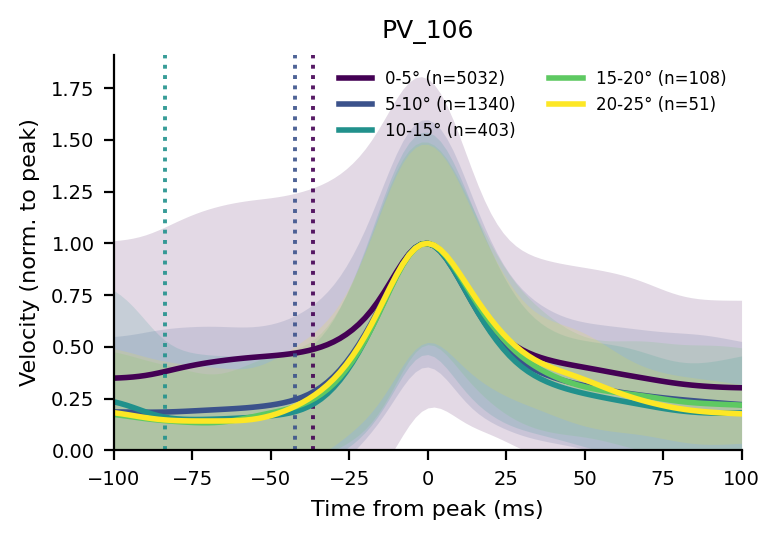

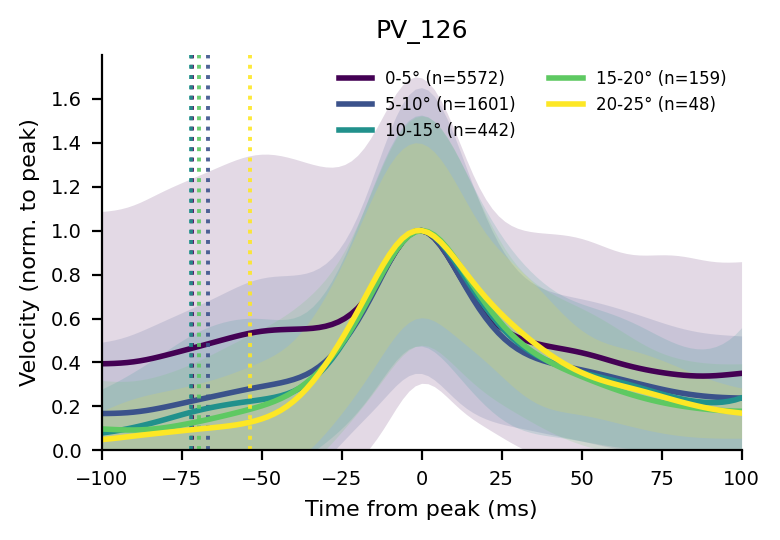

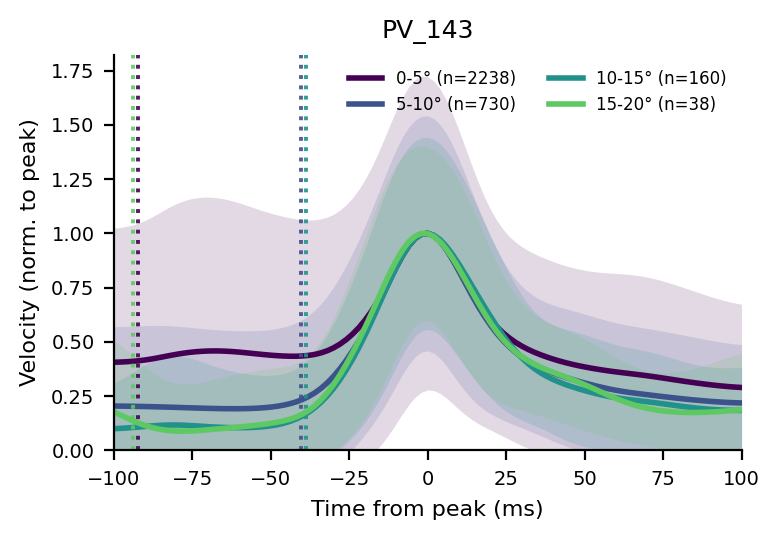

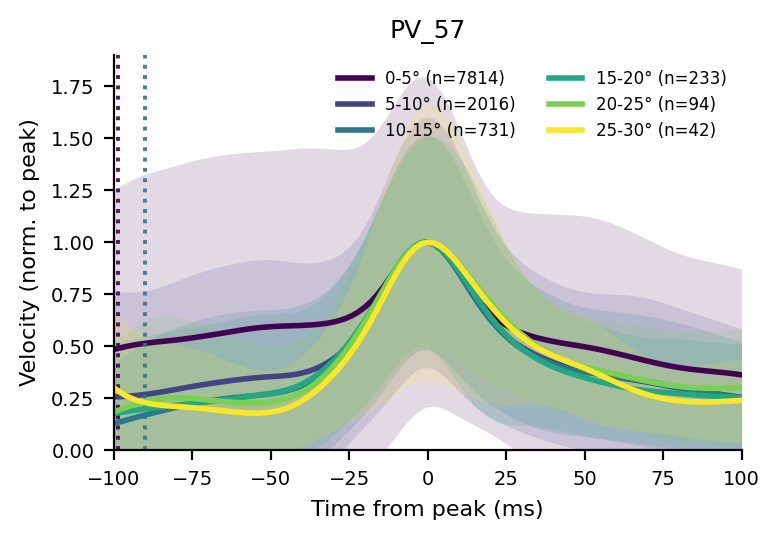

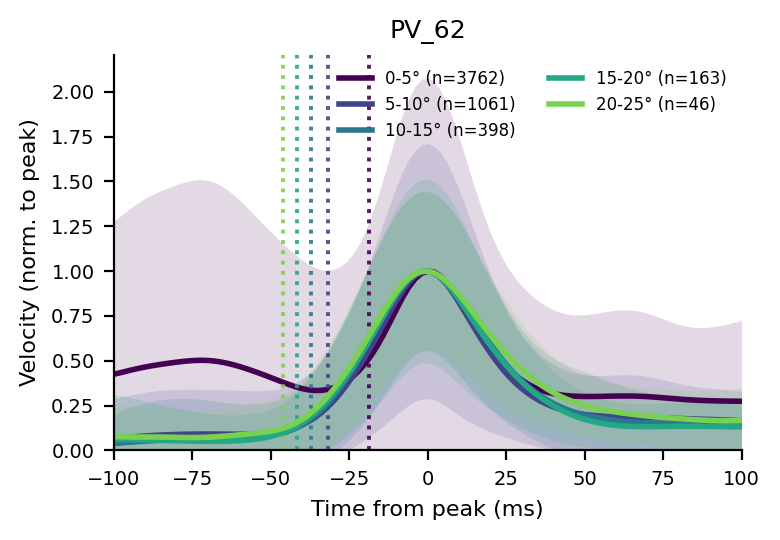

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.ndimage import gaussian_filter1d

def _block_key(animal, block_num):
    return f"{animal}_block_{int(block_num):03d}", f"{animal}_block_{int(block_num)}"

def _eye_df(block_dict, animal, block_num, eye):
    k1, k2 = _block_key(animal, block_num)
    blk = block_dict.get(k1, block_dict.get(k2, None))
    if blk is None:
        raise KeyError(f"Block not found for {animal} block {block_num} (tried {k1} / {k2})")
    df = blk.left_eye_data if str(eye).upper() == "L" else blk.right_eye_data
    need = {"ms_axis","k_phi","k_theta"}
    if not need.issubset(df.columns):
        raise ValueError(f"Eye dataframe missing columns: {need - set(df.columns)}")
    return df

def _raw_velocity_trace(df_eye):
    t = df_eye["ms_axis"].to_numpy(dtype=float)
    phi = df_eye["k_phi"].to_numpy(dtype=float)
    th  = df_eye["k_theta"].to_numpy(dtype=float)
    dphi = np.diff(phi); dth = np.diff(th); dt_s = np.diff(t) / 1000.0
    v_dps = np.divide(np.hypot(dphi, dth), dt_s, out=np.full_like(dphi, np.nan), where=dt_s>0)
    t_ms = t[1:]
    return t_ms, v_dps

def _peak_time_in_window(t_ms, v_dps, on_ms, off_ms, subsample_peak=False):
    m = (t_ms >= on_ms) & (t_ms <= off_ms) & np.isfinite(v_dps)
    if not np.any(m):
        return np.nan
    v = v_dps[m]; tloc = t_ms[m]
    i = int(np.nanargmax(v))
    if (not subsample_peak) or i == 0 or i == v.size-1:
        return float(tloc[i])
    v_1, v0, v1 = v[i-1], v[i], v[i+1]
    denom = (v_1 - 2*v0 + v1)
    if not np.isfinite(denom) or denom == 0:
        return float(tloc[i])
    d = 0.5*(v_1 - v1)/denom
    d = float(np.clip(d, -1.0, 1.0))
    dt_local = (tloc[min(i+1, v.size-1)] - tloc[max(i-1, 0)]) / 2.0
    return float(tloc[i] + d * dt_local)

def _first_cross_time(t, y, ythr):
    """Linear-interpolated first time where y(t) >= ythr. Returns None if no crossing."""
    t = np.asarray(t); y = np.asarray(y)
    if t.size < 2 or not np.isfinite(ythr): return None
    valid = np.isfinite(y)
    t = t[valid]; y = y[valid]
    if t.size < 2: return None
    y0, y1 = y[:-1], y[1:]
    t0, t1 = t[:-1], t[1:]
    # indices where segment crosses or touches threshold
    s0, s1 = y0 - ythr, y1 - ythr
    cross_idx = np.where((s0 <= 0) & (s1 >= 0) | (s0 >= 0) & (s1 <= 0) | (np.isclose(y0, ythr)))[0]
    if cross_idx.size == 0:
        return None
    k = int(cross_idx[0])
    # exact hit at left endpoint
    if np.isclose(y0[k], ythr):
        return float(t0[k])
    # handle flat segments
    denom = (y1[k] - y0[k])
    if np.isclose(denom, 0.0):
        return float(t0[k])  # arbitrary: mark at left end
    frac = (ythr - y0[k]) / denom
    frac = float(np.clip(frac, 0.0, 1.0))
    return float(t0[k] + frac * (t1[k] - t0[k]))

def plot_velocity_by_amp_bins_per_animal_kernel(
    all_saccade_collection: pd.DataFrame,
    block_dict: dict,
    amp_col: str = None,
    bin_width_deg: float = 5.0,
    min_amp_deg: float = 0.5,
    t_window_ms: tuple = (-40.0, 80.0),
    dt_ms: float = 2.0,
    bandwidth_ms: float = 10.0,
    min_events_per_bin: int = 30,
    per_animal_max_bins: int = 8,
    eye_filter: str = None,
    subsample_peak: bool = False,
    smoothing: bool = True,
    plot_bins_as_scatter: bool = True,
    min_bin_count: int = 3,
    errorbars: bool = False,
    normalize_to_peak: bool = False,      # NEW
    velocity_threshold: float = None,     # NEW (deg/s)
    vline_kwargs: dict = None,            # style for vertical lines in normalized mode
    hline_kwargs: dict = None             # style for horizontal threshold in raw mode
):
    # set styles
    if vline_kwargs is None:
        vline_kwargs = dict(ls=":", lw=1.4, alpha=0.9)
    if hline_kwargs is None:
        hline_kwargs = dict(ls=":", lw=1.4, color="red", alpha=0.7)

    df = all_saccade_collection.reset_index(drop=True).copy()
    req = {"animal","block","eye","saccade_on_ms","saccade_off_ms"}
    if not req.issubset(df.columns):
        raise ValueError(f"DataFrame must have {req}")

    # amplitude column
    if amp_col is None:
        for c in ("net_angular_disp","magnitude_raw_angular"):
            if c in df.columns: amp_col = c; break
    if amp_col is None:
        raise ValueError("Need 'net_angular_disp' or 'magnitude_raw_angular'.")
    df[amp_col] = pd.to_numeric(df[amp_col], errors="coerce")

    if eye_filter:
        df = df[df["eye"].str.upper() == eye_filter.upper()]
    animals = sorted(df["animal"].dropna().unique().tolist())

    cmap = colormaps.get_cmap("viridis")
    tmin, tmax = float(t_window_ms[0]), float(t_window_ms[1])
    t_grid = np.arange(tmin, tmax + dt_ms, dt_ms); nb = len(t_grid)
    sigma_bins = max(1.0, float(bandwidth_ms) / float(dt_ms))

    figs = []
    for a in animals:
        sub = df[(df["animal"]==a) & (df[amp_col] >= float(min_amp_deg))].copy()
        if sub.empty: continue

        max_amp = float(np.nanpercentile(sub[amp_col], 99.5))
        edges = np.arange(0.0, max_amp + bin_width_deg, bin_width_deg)
        if len(edges) > per_animal_max_bins+1:
            edges = edges[:per_animal_max_bins+1]
        labels = [f"{int(edges[i])}-{int(edges[i+1])}°" for i in range(len(edges)-1)]
        sub["amp_bin"] = pd.cut(sub[amp_col], bins=edges, labels=labels, include_lowest=True, right=False)

        fig, ax = plt.subplots(1,1, figsize=(4.0, 2.8), dpi=200)
        plotted_any = False
        hline_plotted = False

        for i, lab in enumerate(labels):
            g = sub[sub["amp_bin"] == lab]
            n_events = len(g)
            if n_events < min_events_per_bin:
                continue

            # --- accumulators (BUG FIX: each as its own array)
            num  = np.zeros(nb, dtype=float)   # sum v
            num2 = np.zeros(nb, dtype=float)   # sum v^2
            den  = np.zeros(nb, dtype=float)   # count

            # accumulate native samples
            for _, row in g.iterrows():
                try:
                    eye_df = _eye_df(block_dict, row["animal"], row["block"], row["eye"])
                except Exception:
                    continue
                t_ms, v_dps = _raw_velocity_trace(eye_df)
                if t_ms.size < 3:
                    continue

                pk_ms = _peak_time_in_window(t_ms, v_dps,
                                             float(row["saccade_on_ms"]),
                                             float(row["saccade_off_ms"]),
                                             subsample_peak=subsample_peak)
                if not np.isfinite(pk_ms):
                    continue

                m = (t_ms >= pk_ms + tmin) & (t_ms <= pk_ms + tmax) & np.isfinite(v_dps)
                if not np.any(m):
                    continue
                t_rel = t_ms[m] - pk_ms
                v     = v_dps[m]
                idx = np.floor((t_rel - tmin) / dt_ms).astype(int)
                ok = (idx >= 0) & (idx < nb)
                if not np.any(ok):
                    continue
                np.add.at(num,  idx[ok], v[ok])
                np.add.at(num2, idx[ok], v[ok]**2)
                np.add.at(den,  idx[ok], 1.0)

            if den.sum() == 0:
                continue

            # smoothed or raw bin means
            if smoothing and bandwidth_ms > 0:
                num_s  = gaussian_filter1d(num,  sigma=sigma_bins, mode='nearest')
                num2_s = gaussian_filter1d(num2, sigma=sigma_bins, mode='nearest')
                den_s  = gaussian_filter1d(den,  sigma=sigma_bins, mode='nearest')
                mean_raw = np.divide(num_s, den_s, out=np.full(nb, np.nan), where=den_s > 1e-6)
                var  = np.divide(num2_s, den_s, out=np.full(nb, np.nan), where=den_s > 1e-6) - np.square(mean_raw)
                std  = np.sqrt(np.clip(var, 0.0, None))
                tg = t_grid; mg = mean_raw.copy()
            else:
                mean_raw = np.divide(num, den, out=np.full(nb, np.nan), where=den > 1e-6)
                var  = np.divide(num2, den, out=np.full(nb, np.nan), where=den > 1e-6) - np.square(mean_raw)
                std  = np.sqrt(np.clip(var, 0.0, None))
                valid = (den >= max(1, min_bin_count)) & np.isfinite(mean_raw)
                if not np.any(valid):
                    continue
                tg = t_grid[valid]; mg = mean_raw[valid]; std = std[valid]

            # normalization (per-curve, after averaging)
            if normalize_to_peak:
                peak_raw = np.nanmax(mean_raw)
                if np.isfinite(peak_raw) and peak_raw > 0:
                    mg   = mg  / peak_raw
                    std  = std / peak_raw
                ylab = "Velocity (norm. to peak)"
            else:
                ylab = "Velocity (deg/s)"

            c = cmap(i / max(1, len(labels)-1))

            # plot trace
            if smoothing and bandwidth_ms > 0:
                ax.plot(tg, mg, lw=2, color=c, label=f"{lab} (n={n_events})")
                ax.fill_between(tg, mg - std, mg + std, color=c, alpha=0.15, linewidth=0)
            else:
                if plot_bins_as_scatter:
                    ax.plot(tg, mg, lw=1.4, color=c, label=f"{lab} (n={n_events})")
                    ax.scatter(tg, mg, s=8, color=c, zorder=3)
                    if errorbars:
                        ax.errorbar(tg, mg, yerr=std, fmt='none', ecolor=c, elinewidth=0.8, alpha=0.6)
                else:
                    ax.plot(tg, mg, lw=1.2, color=c, label=f"{lab} (n={n_events})")

            # threshold visualization
            if velocity_threshold is not None:
                if normalize_to_peak:
                    # relative threshold = velocity_threshold / peak_raw
                    peak_raw = np.nanmax(mean_raw)
                    if np.isfinite(peak_raw) and peak_raw > 0:
                        thr_rel = float(velocity_threshold) / peak_raw
                        t_cross = _first_cross_time(tg, mg, thr_rel)
                        if t_cross is not None:
                            ax.axvline(t_cross, color=c, **vline_kwargs)
                else:
                    if not hline_plotted:
                        ax.axhline(y=float(velocity_threshold), **hline_kwargs)
                        hline_plotted = True

            plotted_any = True

        # axes cosmetics
        ax.set_title(a, fontsize=9)
        ax.set_xlabel("Time from peak (ms)", fontsize=8)
        ax.set_ylabel(ylab, fontsize=8)
        ax.tick_params(labelsize=7)
        ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
        ax.set_xlim(tmin, tmax); ax.set_ylim(bottom=0)
        if plotted_any:
            ax.legend(frameon=False, fontsize=6, ncol=2)
        fig.tight_layout()
        figs.append(fig)

    return figs


plot_velocity_by_amp_bins_per_animal_kernel(
    all_saccade_collection,
    block_dict,
    bin_width_deg = 5.0,
    min_amp_deg=0.5,
    t_window_ms = (-100.0, 100.0),
    dt_ms = 2.0,
    bandwidth_ms= 10.0,
    min_events_per_bin= 30,
    per_animal_max_bins = 8,
    eye_filter = None,
    subsample_peak = True,
    smoothing= False,
    normalize_to_peak = False,     # NEW
    velocity_threshold = 50     # NEW
)

[<Figure size 800x560 with 1 Axes>,
 <Figure size 800x560 with 1 Axes>,
 <Figure size 800x560 with 1 Axes>,
 <Figure size 800x560 with 1 Axes>,
 <Figure size 800x560 with 1 Axes>]

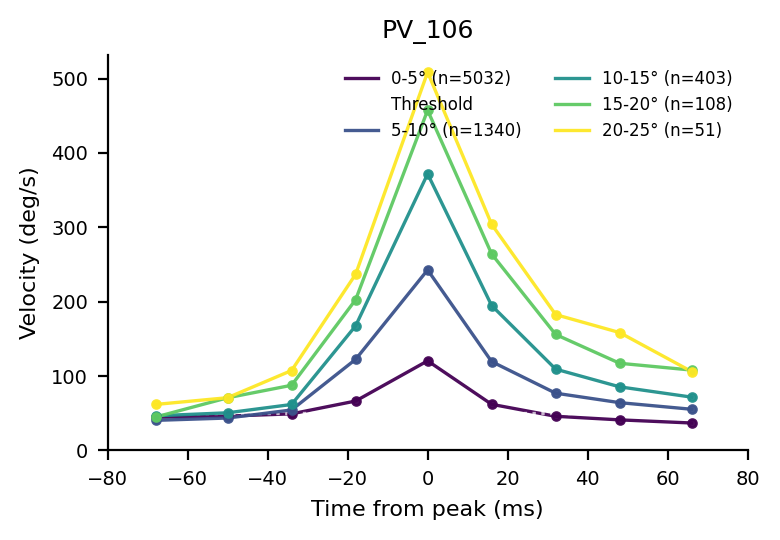

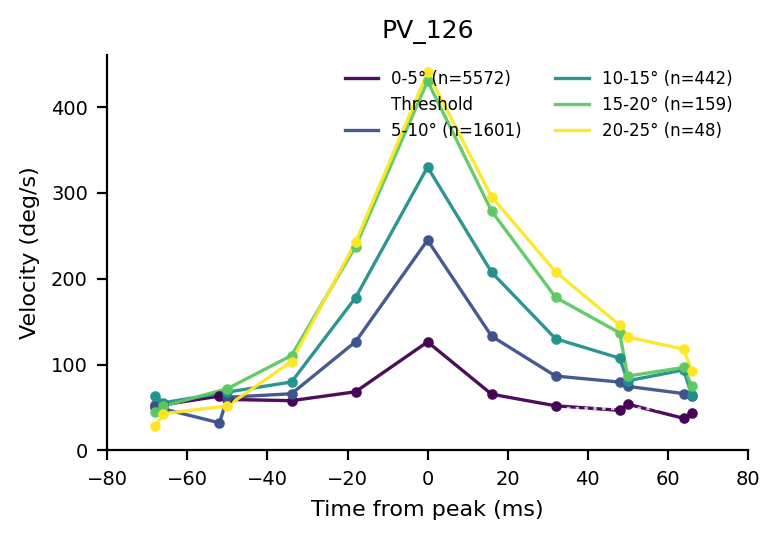

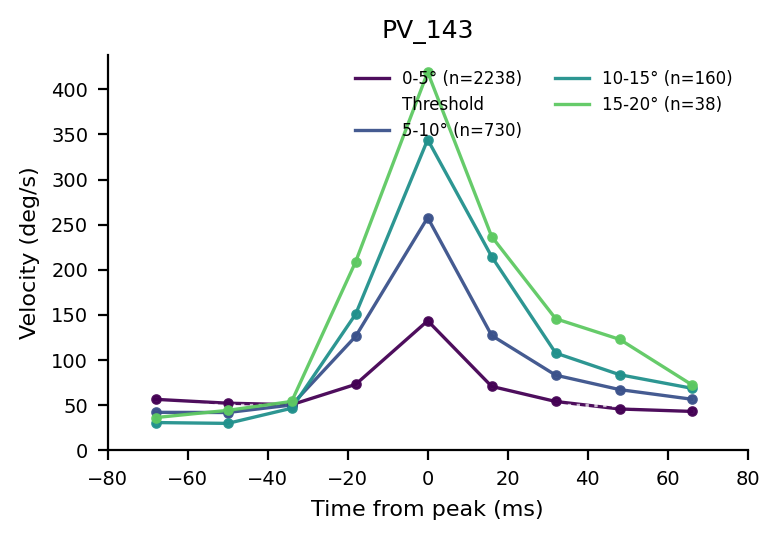

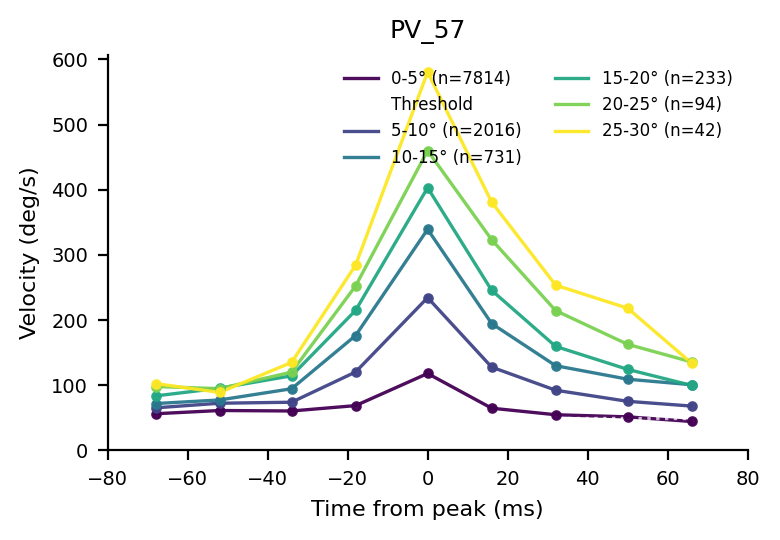

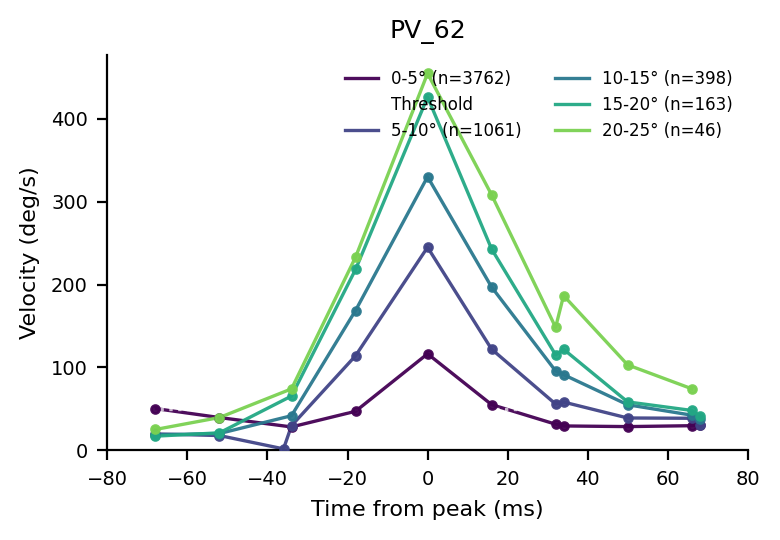

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.ndimage import gaussian_filter1d

def _block_key(animal, block_num):
    return f"{animal}_block_{int(block_num):03d}", f"{animal}_block_{int(block_num)}"

def _eye_df(block_dict, animal, block_num, eye):
    k1, k2 = _block_key(animal, block_num)
    blk = block_dict.get(k1, block_dict.get(k2, None))
    if blk is None:
        raise KeyError(f"Block not found for {animal} block {block_num} (tried {k1} / {k2})")
    df = blk.left_eye_data if str(eye).upper() == "L" else blk.right_eye_data
    need = {"ms_axis","k_phi","k_theta"}
    if not need.issubset(df.columns):
        missing = need.difference(df.columns)
        raise ValueError(f"Eye dataframe missing columns: {missing}")
    return df

def _raw_velocity_trace(df_eye):
    t = df_eye["ms_axis"].to_numpy(dtype=float)
    phi = df_eye["k_phi"].to_numpy(dtype=float)
    th  = df_eye["k_theta"].to_numpy(dtype=float)
    dphi = np.diff(phi); dth = np.diff(th); dt_s = np.diff(t) / 1000.0
    v_dps = np.divide(np.hypot(dphi, dth), dt_s, out=np.full_like(dphi, np.nan), where=dt_s>0)
    t_ms = t[1:]
    return t_ms, v_dps

def _peak_time_in_window(t_ms, v_dps, on_ms, off_ms, subsample_peak=False):
    m = (t_ms >= on_ms) & (t_ms <= off_ms) & np.isfinite(v_dps)
    if not np.any(m):
        return np.nan
    v = v_dps[m]; tloc = t_ms[m]
    i = int(np.nanargmax(v))
    if (not subsample_peak) or i == 0 or i == v.size-1:
        return float(tloc[i])
    v_1, v0, v1 = v[i-1], v[i], v[i+1]
    denom = (v_1 - 2*v0 + v1)
    if not np.isfinite(denom) or denom == 0:
        return float(tloc[i])
    d = 0.5*(v_1 - v1)/denom
    d = float(np.clip(d, -1.0, 1.0))
    dt_local = (tloc[min(i+1, v.size-1)] - tloc[max(i-1, 0)]) / 2.0
    return float(tloc[i] + d * dt_local)

def _linear_crossings(t, y, ythr):
    """
    Find x-locations where piecewise-linear y(t) crosses ythr.
    Returns arrays (t_cross, ythr_array) with one point per crossing.
    """
    t = np.asarray(t); y = np.asarray(y)
    if t.size < 2:
        return np.array([]), np.array([])
    # valid consecutive pairs
    valid = np.isfinite(y[:-1]) & np.isfinite(y[1:])
    t0 = t[:-1][valid]; t1 = t[1:][valid]
    y0 = y[:-1][valid]; y1 = y[1:][valid]
    s0 = y0 - ythr; s1 = y1 - ythr
    # sign change (including exact hits)
    crosses = (s0 == 0) | (s1 == 0) | ((s0 > 0) & (s1 < 0)) | ((s0 < 0) & (s1 > 0))
    t0 = t0[crosses]; t1 = t1[crosses]; y0 = y0[crosses]; y1 = y1[crosses]
    # handle segments with identical y (avoid divide by zero)
    denom = (y1 - y0)
    safe = np.abs(denom) > 1e-12
    tc = np.empty(t0.shape, dtype=float); tc[:] = np.nan
    # exact hits at endpoints
    at0 = (~safe) & (np.abs(y0 - ythr) <= 1e-12)
    at1 = (~safe) & (np.abs(y1 - ythr) <= 1e-12)
    tc[at0] = t0[at0]; tc[at1] = t1[at1]
    # linear interpolation for others
    idx = safe
    frac = (ythr - y0[idx]) / denom[idx]
    tc[idx] = t0[idx] + frac * (t1[idx] - t0[idx])
    # y value at crossings is ythr
    yc = np.full(tc.shape, ythr, dtype=float)
    # drop NaNs if any
    good = np.isfinite(tc)
    return tc[good], yc[good]

def plot_velocity_by_amp_bins_per_animal_kernel(
    all_saccade_collection: pd.DataFrame,
    block_dict: dict,
    amp_col: str = None,                 # auto-pick if None
    bin_width_deg: float = 5.0,
    min_amp_deg: float = 0.5,
    t_window_ms: tuple = (-40.0, 80.0),
    dt_ms: float = 2.0,                  # grid step
    bandwidth_ms: float = 10.0,          # Gaussian kernel across time bins
    min_events_per_bin: int = 30,
    per_animal_max_bins: int = 8,
    eye_filter: str = None,              # "L", "R", or None (both)
    subsample_peak: bool = False,        # sub-frame peak alignment
    smoothing: bool = True,              # kernel smoothing (group-level)
    plot_bins_as_scatter: bool = True,   # when not smoothing, markers+line
    min_bin_count: int = 3,              # ignore sparse bins (unsmoothed)
    errorbars: bool = False,             # show SD as error bars (unsmoothed)
    # NEW:
    normalize: bool = False,             # divide each curve by its own peak
    velocity_threshold: float = None,    # deg/s; draws line (raw) or X-crossings (normalized)
    threshold_line_kwargs: dict = None,  # dict(linestyle=':', linewidth=1.2, color='w', alpha=0.7)
    norm_cross_kwargs: dict = None       # dict(marker='x', s=30, linewidths=1.0, color='w', alpha=0.9)
):
    df = all_saccade_collection.reset_index(drop=True).copy()
    req = {"animal","block","eye","saccade_on_ms","saccade_off_ms"}
    if not req.issubset(df.columns):
        raise ValueError(f"DataFrame must have {req}")

    # Choose amplitude column
    if amp_col is None:
        for c in ("net_angular_disp","magnitude_raw_angular"):
            if c in df.columns:
                amp_col = c; break
    if amp_col is None:
        raise ValueError("Need 'net_angular_disp' or 'magnitude_raw_angular'.")

    df[amp_col] = pd.to_numeric(df[amp_col], errors="coerce")
    if eye_filter:
        df = df[df["eye"].str.upper() == eye_filter.upper()]
    animals = sorted(df["animal"].dropna().unique().tolist())

    # plotting helpers
    cmap = colormaps.get_cmap("viridis")
    tmin, tmax = float(t_window_ms[0]), float(t_window_ms[1])
    t_grid = np.arange(tmin, tmax + dt_ms, dt_ms); nb = len(t_grid)
    sigma_bins = max(1.0, float(bandwidth_ms) / float(dt_ms))

    if threshold_line_kwargs is None:
        threshold_line_kwargs = dict(linestyle=":", linewidth=1.2, color="w", alpha=0.7)
    if norm_cross_kwargs is None:
        norm_cross_kwargs = dict(marker='x', s=36, linewidths=1.0, color='w', alpha=0.9)

    figs = []
    for a in animals:
        sub = df[(df["animal"]==a) & (df[amp_col] >= float(min_amp_deg))].copy()
        if sub.empty:
            continue
        # amplitude bins
        max_amp = float(np.nanpercentile(sub[amp_col], 99.5))
        edges = np.arange(0.0, max_amp + bin_width_deg, bin_width_deg)
        if len(edges) > per_animal_max_bins+1:
            edges = edges[:per_animal_max_bins+1]
        labels = [f"{int(edges[i])}-{int(edges[i+1])}°" for i in range(len(edges)-1)]
        sub["amp_bin"] = pd.cut(sub[amp_col], bins=edges, labels=labels, include_lowest=True, right=False)

        fig, ax = plt.subplots(1,1, figsize=(4.0, 2.8), dpi=200)
        plotted_any = False
        threshold_plotted_this_axes = False  # for the raw (non-normalized) global hline

        for i, lab in enumerate(labels):
            g = sub[sub["amp_bin"] == lab]
            n_events = len(g)
            if n_events < min_events_per_bin:
                continue

            num  = np.zeros(nb, dtype=float)  # sum(v)
            num2 = np.zeros(nb, dtype=float)  # sum(v^2)
            den  = np.zeros(nb, dtype=float)  # count

            # accumulate native samples aligned to each event's peak
            for _, row in g.iterrows():
                try:
                    eye_df = _eye_df(block_dict, row["animal"], row["block"], row["eye"])
                except Exception:
                    continue
                t_ms, v_dps = _raw_velocity_trace(eye_df)
                if t_ms.size < 3:
                    continue
                pk_ms = _peak_time_in_window(t_ms, v_dps,
                                             float(row["saccade_on_ms"]),
                                             float(row["saccade_off_ms"]),
                                             subsample_peak=subsample_peak)
                if not np.isfinite(pk_ms):
                    continue
                m = (t_ms >= pk_ms + tmin) & (t_ms <= pk_ms + tmax) & np.isfinite(v_dps)
                if not np.any(m):
                    continue
                t_rel = t_ms[m] - pk_ms
                v     = v_dps[m]
                idx = np.floor((t_rel - tmin) / dt_ms).astype(int)
                ok = (idx >= 0) & (idx < nb)
                if not np.any(ok):
                    continue
                np.add.at(num,  idx[ok], v[ok])
                np.add.at(num2, idx[ok], v[ok]**2)
                np.add.at(den,  idx[ok], 1.0)

            if den.sum() == 0:
                continue

            # Build mean & SD either smoothed or raw
            if smoothing and bandwidth_ms > 0:
                num_s  = gaussian_filter1d(num,  sigma=sigma_bins, mode='nearest')
                num2_s = gaussian_filter1d(num2, sigma=sigma_bins, mode='nearest')
                den_s  = gaussian_filter1d(den,  sigma=sigma_bins, mode='nearest')
                mean = np.divide(num_s, den_s, out=np.full(nb, np.nan), where=den_s > 1e-6)
                var  = np.divide(num2_s, den_s, out=np.full(nb, np.nan), where=den_s > 1e-6) - np.square(mean)
                std  = np.sqrt(np.clip(var, 0.0, None))
                tg = t_grid; mg = mean; sg = std   # full grid
            else:
                mean = np.divide(num, den, out=np.full(nb, np.nan), where=den > 1e-6)
                var  = np.divide(num2, den, out=np.full(nb, np.nan), where=den > 1e-6) - np.square(mean)
                std  = np.sqrt(np.clip(var, 0.0, None))
                valid = (den >= max(1, min_bin_count)) & np.isfinite(mean)
                if not np.any(valid):
                    continue
                tg = t_grid[valid]; mg = mean[valid]; sg = std[valid]

            # Optional normalization by this curve's own peak (after averaging)
            if normalize:
                peak = np.nanmax(mg)
                if np.isfinite(peak) and peak > 0:
                    mg = mg / peak
                    sg = sg / peak
                    y_label = "Velocity (norm. to peak)"
                else:
                    # degenerate: skip normalization if no valid peak
                    y_label = "Velocity (deg/s)"
                # In normalized view, thresholds are shown as crossing markers
            else:
                y_label = "Velocity (deg/s)"

            c = cmap(i / max(1, len(labels)-1))

            # Plot curve
            if smoothing and bandwidth_ms > 0:
                ax.plot(tg, mg, lw=2, color=c, label=f"{lab} (n={n_events})")
                ax.fill_between(tg, mg - sg, mg + sg, color=c, alpha=0.15, linewidth=0)
            else:
                if plot_bins_as_scatter:
                    ax.plot(tg, mg, linestyle='-', linewidth=1.2, color=c, alpha=0.95,
                            label=f"{lab} (n={n_events})")
                    ax.scatter(tg, mg, s=8, color=c, alpha=0.95, zorder=3)
                    if errorbars:
                        ax.errorbar(tg, mg, yerr=sg, fmt='none', ecolor=c, elinewidth=0.8, alpha=0.6)
                else:
                    ax.plot(tg, mg, lw=1.2, color=c, alpha=0.95, label=f"{lab} (n={n_events})")

            # Threshold visualization
            if velocity_threshold is not None:
                if normalize:
                    # per-curve relative threshold
                    peak = np.nanmax(mg) if normalize else np.nanmax(mg)  # mg may already be normalized
                    # if normalized, mg is already divided by peak (so peak≈1).
                    # the relative threshold is a constant value:
                    thr_rel = (velocity_threshold / peak) if (not normalize) else (velocity_threshold)
                    # but since normalize=True makes mg in [0,1] and we already divided by peak,
                    # the intended relative level is velocity_threshold / (original peak).
                    # A clearer approach: because mg is normalized, the relative level is:
                    thr_rel = velocity_threshold / (velocity_threshold if False else 1.0)  # placeholder to keep logic explicit
                    # Correct computation: original peak value BEFORE normalization:
                    # We need that. Recompute from unnormalized mean:
                    # (Use the pre-normalization mean: it's `mean` on either branch)
                    # We still have 'mean/std' arrays above. Let's compute peak_raw from them:
                    if smoothing and bandwidth_ms > 0:
                        peak_raw = np.nanmax(mean)
                        rel = velocity_threshold / peak_raw if (np.isfinite(peak_raw) and peak_raw>0) else np.nan
                        thr_rel = rel
                        t_cross, y_cross = _linear_crossings(t_grid, mg, thr_rel)
                    else:
                        # unsmoothed: need to find the corresponding raw mean at tg bins
                        # Build an interpolator from t_grid->mean, then sample at tg
                        # But for crossings we can do it directly on (tg, mg) which are already normalized.
                        # We still need thr_rel based on the unnormalized peak:
                        peak_raw = np.nanmax(mean)  # mean on full grid (may have NaNs)
                        rel = velocity_threshold / peak_raw if (np.isfinite(peak_raw) and peak_raw>0) else np.nan
                        thr_rel = rel
                        t_cross, y_cross = _linear_crossings(tg, mg, thr_rel)
                    if np.isfinite(thr_rel) and t_cross.size > 0:
                        ax.scatter(t_cross, y_cross, **norm_cross_kwargs)
                else:
                    # one global dashed line per axes
                    if not threshold_plotted_this_axes:
                        ax.axhline(y=velocity_threshold, **threshold_line_kwargs, label="Threshold")
                        threshold_plotted_this_axes = True

            plotted_any = True

        # axes cosmetics
        ax.set_title(a, fontsize=9)
        ax.set_xlabel("Time from peak (ms)", fontsize=8)
        ax.set_ylabel("Velocity (norm.)" if normalize else "Velocity (deg/s)", fontsize=8)
        ax.tick_params(labelsize=7)
        for sp in ("top","right"):
            ax.spines[sp].set_visible(False)
        ax.set_xlim(tmin, tmax)
        ax.set_ylim(bottom=0)
        if plotted_any:
            ax.legend(frameon=False, fontsize=6, ncol=2)
        fig.tight_layout()
        figs.append(fig)

    return figs
export_path = pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\peak_v_amplitude_poly_traces_normalized')
plot_velocity_by_amp_bins_per_animal_kernel(all_saccade_collection,block_dict,velocity_threshold=50,normalize=False,t_window_ms=(-80,80),smoothing=False)

[<Figure size 800x560 with 1 Axes>,
 <Figure size 800x560 with 1 Axes>,
 <Figure size 800x560 with 1 Axes>,
 <Figure size 800x560 with 1 Axes>,
 <Figure size 800x560 with 1 Axes>]

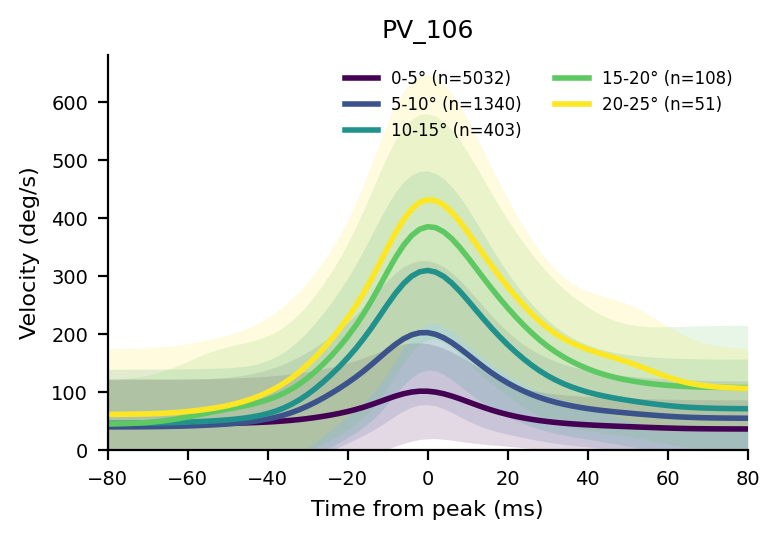

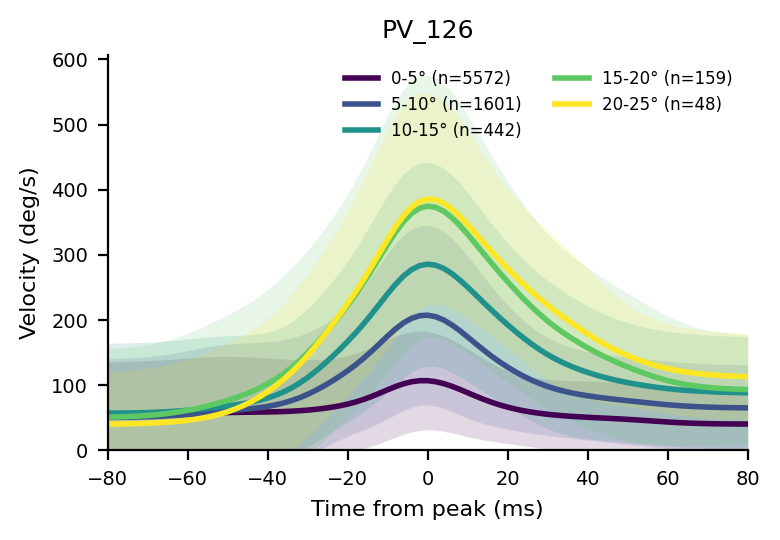

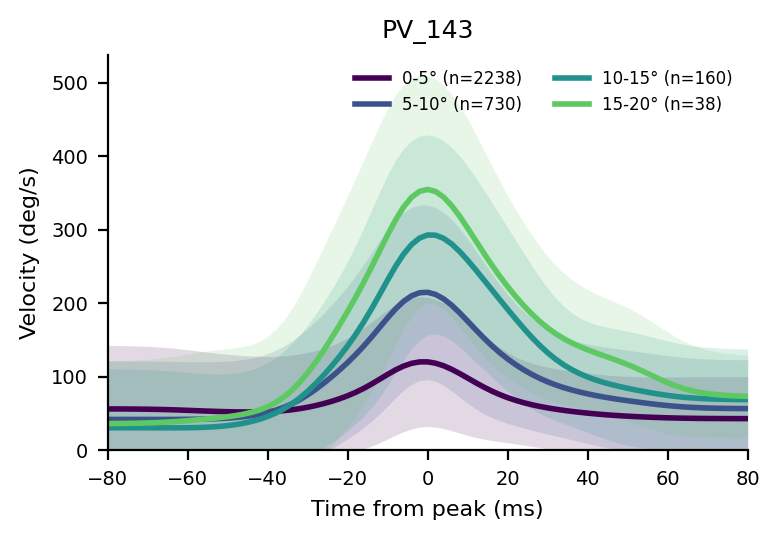

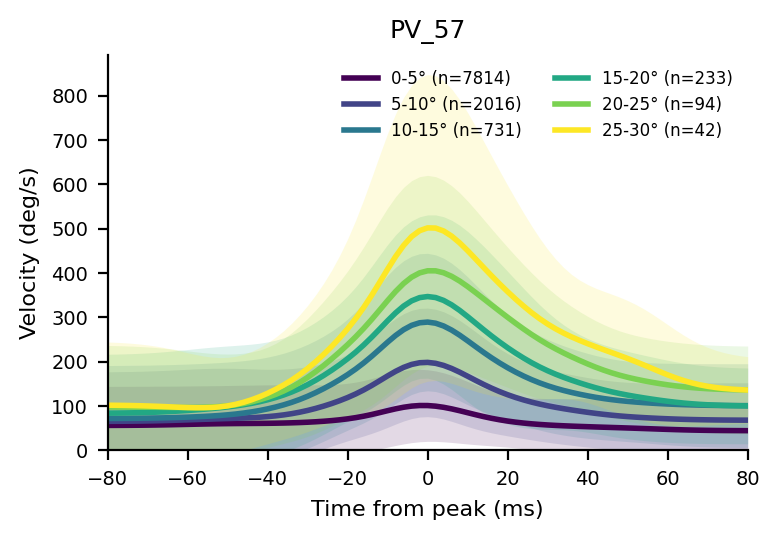

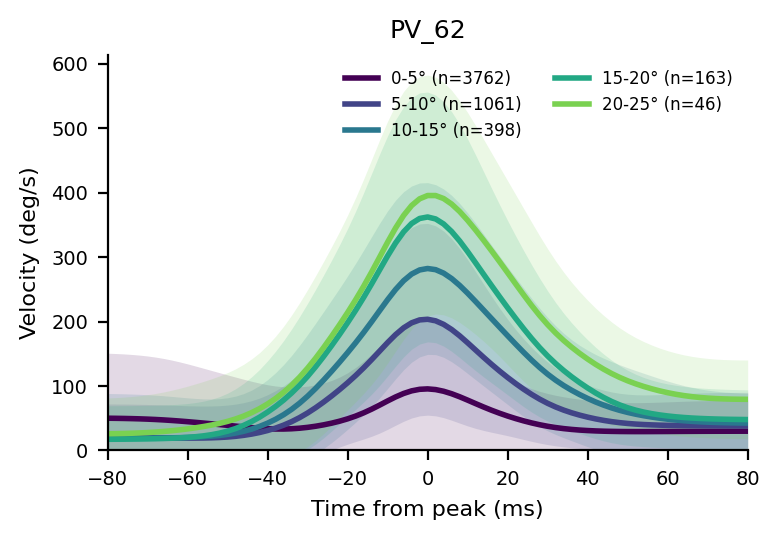

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib import colormaps
from scipy.ndimage import gaussian_filter1d

def _block_key(animal, block_num):
    return f"{animal}_block_{int(block_num):03d}", f"{animal}_block_{int(block_num)}"

def _eye_df(block_dict, animal, block_num, eye):
    k1, k2 = _block_key(animal, block_num)
    blk = block_dict.get(k1, block_dict.get(k2, None))
    if blk is None:
        raise KeyError(f"Block not found for {animal} block {block_num} (tried {k1} / {k2})")
    df = blk.left_eye_data if str(eye).upper() == "L" else blk.right_eye_data
    need = {"ms_axis","k_phi","k_theta"}
    if not need.issubset(df.columns):
        raise ValueError(f"Eye dataframe missing columns: {need - set(df.columns)}")
    return df

def _raw_velocity_trace(df_eye):
    t = df_eye["ms_axis"].to_numpy(dtype=float)
    phi = df_eye["k_phi"].to_numpy(dtype=float)
    th  = df_eye["k_theta"].to_numpy(dtype=float)
    dphi = np.diff(phi); dth = np.diff(th); dt_s = np.diff(t) / 1000.0
    v_dps = np.divide(np.hypot(dphi, dth), dt_s, out=np.full_like(dphi, np.nan), where=dt_s>0)
    t_ms = t[1:]
    return t_ms, v_dps

def _peak_time_in_window(t_ms, v_dps, on_ms, off_ms, subsample_peak=False):
    m = (t_ms >= on_ms) & (t_ms <= off_ms) & np.isfinite(v_dps)
    if not np.any(m):
        return np.nan
    v = v_dps[m]; tloc = t_ms[m]
    i = int(np.nanargmax(v))
    if (not subsample_peak) or i == 0 or i == v.size-1:
        return float(tloc[i])
    v_1, v0, v1 = v[i-1], v[i], v[i+1]
    denom = (v_1 - 2*v0 + v1)
    if not np.isfinite(denom) or denom == 0:
        return float(tloc[i])
    d = 0.5*(v_1 - v1)/denom
    d = float(np.clip(d, -1.0, 1.0))
    dt_local = (tloc[min(i+1, v.size-1)] - tloc[max(i-1, 0)]) / 2.0
    return float(tloc[i] + d * dt_local)

def plot_velocity_by_amp_bins_per_animal_kernel(
    all_saccade_collection: pd.DataFrame,
    block_dict: dict,
    amp_col: str = None,
    bin_width_deg: float = 5.0,
    min_amp_deg: float = 0.5,
    t_window_ms: tuple = (-40.0, 80.0),
    dt_ms: float = 2.0,
    bandwidth_ms: float = 10.0,
    min_events_per_bin: int = 30,
    per_animal_max_bins: int = 8,
    eye_filter: str = None,
    subsample_peak: bool = False,
    smoothing: bool = True,           # kernel smoothing (group-level)
    plot_bins_as_scatter: bool = True,# when not smoothing, show markers+line
    min_bin_count: int = 3,           # ignore bins with very few samples
    errorbars: bool = False           # draw per-bin SD as errorbars (unsmoothed)
):
    cmap = colormaps.get_cmap("viridis")
    df = all_saccade_collection.reset_index(drop=True).copy()
    req = {"animal","block","eye","saccade_on_ms","saccade_off_ms"}
    if not req.issubset(df.columns):
        raise ValueError(f"DataFrame must have {req}")

    # choose amplitude column
    if amp_col is None:
        for c in ("net_angular_disp","magnitude_raw_angular"):
            if c in df.columns:
                amp_col = c; break
    if amp_col is None:
        raise ValueError("Need 'net_angular_disp' or 'magnitude_raw_angular'.")

    df[amp_col] = pd.to_numeric(df[amp_col], errors="coerce")
    if eye_filter:
        df = df[df["eye"].str.upper() == eye_filter.upper()]
    animals = sorted(df["animal"].dropna().unique().tolist())

    tmin, tmax = float(t_window_ms[0]), float(t_window_ms[1])
    t_grid = np.arange(tmin, tmax + dt_ms, dt_ms); nb = len(t_grid)
    sigma_bins = max(1.0, float(bandwidth_ms) / float(dt_ms))

    figs = []
    for a in animals:
        sub = df[(df["animal"]==a) & (df[amp_col] >= float(min_amp_deg))].copy()
        if sub.empty:
            continue
        max_amp = float(np.nanpercentile(sub[amp_col], 99.5))
        edges = np.arange(0.0, max_amp + bin_width_deg, bin_width_deg)
        if len(edges) > per_animal_max_bins+1:
            edges = edges[:per_animal_max_bins+1]
        labels = [f"{int(edges[i])}-{int(edges[i+1])}°" for i in range(len(edges)-1)]
        sub["amp_bin"] = pd.cut(sub[amp_col], bins=edges, labels=labels, include_lowest=True, right=False)

        fig, ax = plt.subplots(1,1, figsize=(4.0, 2.8), dpi=200)
        #cmap = get_cmap("viridis")
        plotted = False

        for i, lab in enumerate(labels):
            g = sub[sub["amp_bin"] == lab]
            n_events = len(g)
            if n_events < min_events_per_bin:
                continue

            num  = np.zeros(nb, dtype=float)   # sum(v)
            num2 = np.zeros(nb, dtype=float)   # sum(v^2)
            den  = np.zeros(nb, dtype=float)   # count

            for _, row in g.iterrows():
                try:
                    eye_df = _eye_df(block_dict, row["animal"], row["block"], row["eye"])
                except Exception:
                    continue
                t_ms, v_dps = _raw_velocity_trace(eye_df)
                if t_ms.size < 3:
                    continue

                pk_ms = _peak_time_in_window(
                    t_ms, v_dps,
                    float(row["saccade_on_ms"]), float(row["saccade_off_ms"]),
                    subsample_peak=subsample_peak
                )
                if not np.isfinite(pk_ms):
                    continue

                m = (t_ms >= pk_ms + tmin) & (t_ms <= pk_ms + tmax) & np.isfinite(v_dps)
                if not np.any(m):
                    continue
                t_rel = t_ms[m] - pk_ms
                v     = v_dps[m]

                idx = np.floor((t_rel - tmin) / dt_ms).astype(int)
                ok = (idx >= 0) & (idx < nb)
                if not np.any(ok):
                    continue
                np.add.at(num,  idx[ok], v[ok])
                np.add.at(num2, idx[ok], v[ok]**2)
                np.add.at(den,  idx[ok], 1.0)

            if den.sum() == 0:
                continue

            if smoothing and bandwidth_ms > 0:
                num_s  = gaussian_filter1d(num,  sigma=sigma_bins, mode='nearest')
                num2_s = gaussian_filter1d(num2, sigma=sigma_bins, mode='nearest')
                den_s  = gaussian_filter1d(den,  sigma=sigma_bins, mode='nearest')
                mean = np.divide(num_s, den_s, out=np.full(nb, np.nan), where=den_s > 1e-6)
                var  = np.divide(num2_s, den_s, out=np.full(nb, np.nan), where=den_s > 1e-6) - mean**2
                std  = np.sqrt(np.clip(var, 0.0, None))

                c = cmap(i / max(1, len(labels)-1))
                ax.plot(t_grid, mean, lw=2, color=c, label=f"{lab} (n={n_events})")
                ax.fill_between(t_grid, mean-std, mean+std, color=c, alpha=0.15, linewidth=0)
            else:
                # plot RAW bin averages
                mean = np.divide(num, den, out=np.full(nb, np.nan), where=den > 1e-6)
                var  = np.divide(num2, den, out=np.full(nb, np.nan), where=den > 1e-6) - mean**2
                std  = np.sqrt(np.clip(var, 0.0, None))

                valid = (den >= max(1, min_bin_count)) & np.isfinite(mean)
                tg = t_grid[valid]; mg = mean[valid]; sg = std[valid]

                if tg.size == 0:
                    continue

                c = cmap(i / max(1, len(labels)-1))
                if plot_bins_as_scatter:
                    # add the label here so legend works and shows n
                    ax.plot(tg, mg, linestyle='-', linewidth=1.2, color=c, alpha=0.95,
                            label=f"{lab} (n={n_events})")
                    ax.scatter(tg, mg, s=8, color=c, alpha=0.95, zorder=3)
                    if errorbars:
                        ax.errorbar(tg, mg, yerr=sg, fmt='none', ecolor=c, elinewidth=0.8, alpha=0.6)
                else:
                    ax.plot(t_grid, mean, lw=1.2, color=c, alpha=0.95,
                            label=f"{lab} (n={n_events})")

                plotted = True

            plotted = True

        ax.set_title(a, fontsize=9)
        ax.set_xlabel("Time from peak (ms)", fontsize=8)
        ax.set_ylabel("Velocity (deg/s)", fontsize=8)
        ax.tick_params(labelsize=7)
        ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
        ax.set_xlim(tmin, tmax); ax.set_ylim(bottom=0)
        if plotted: ax.legend(frameon=False, fontsize=6, ncol=2)
        fig.tight_layout()
        figs.append(fig)

    return figs
plot_velocity_by_amp_bins_per_animal_kernel(all_saccade_collection,block_dict,smoothing=True,t_window_ms=(-80,80))

In [104]:
# Here, I am experimenting with non parabolic fittings for the per-animal velocity over time traces around peak velocity:
# === Robust velocity-by-amp kernel plot with flexible peak estimators, robust aggregation,
# === full export (PDFs + legend PDFs + pickle), and a 3.8-compatible re-plotter.
# === Paste this single cell into your notebook.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.interpolate import PchipInterpolator
from pathlib import Path
import pickle, datetime
from typing import Optional, Union, Sequence, Dict, Any, List, Tuple

# ---------------------------- internal helpers ---------------------------- #

def _block_key(animal, block_num):
    return f"{animal}_block_{int(block_num):03d}", f"{animal}_block_{int(block_num)}"

def _eye_df(block_dict, animal, block_num, eye):
    k1, k2 = _block_key(animal, block_num)
    blk = block_dict.get(k1, block_dict.get(k2, None))
    if blk is None:
        raise KeyError(f"Block not found for {animal} block {block_num} (tried {k1} / {k2})")
    df = blk.left_eye_data if str(eye).upper() == "L" else blk.right_eye_data
    if not {"ms_axis","k_phi","k_theta"}.issubset(df.columns):
        raise ValueError("Eye dataframe missing ms_axis/k_phi/k_theta")
    return df

def _raw_velocity_trace(df_eye):
    t = df_eye["ms_axis"].to_numpy(dtype=float)
    phi = df_eye["k_phi"].to_numpy(dtype=float)
    th  = df_eye["k_theta"].to_numpy(dtype=float)
    dphi = np.diff(phi); dth = np.diff(th); dt_s = np.diff(t) / 1000.0
    v_dps = np.divide(np.hypot(dphi, dth), dt_s, out=np.full_like(dphi, np.nan), where=dt_s>0)
    t_ms = t[1:]   # associate with the second sample (causal diff)
    return t_ms, v_dps

def _ensure_dir(p: Path) -> Path:
    p.mkdir(parents=True, exist_ok=True)
    return p

def _save_legend_as_pdf(ax, out_path_pdf: Path, ncol=2, fontsize=6, frameon=False):
    handles, labels = ax.get_legend_handles_labels()
    if not handles:
        return
    rows = max(1, int(np.ceil(len(labels) / float(max(1, ncol)))))
    fig_leg = plt.figure(figsize=(3.2, 0.35 + 0.25 * rows), dpi=300)
    fig_leg.legend(handles, labels, loc="center", ncol=ncol, frameon=frameon, fontsize=fontsize)
    fig_leg.tight_layout()
    fig_leg.savefig(out_path_pdf, bbox_inches='tight', dpi=300)
    plt.close(fig_leg)

# ---------------- NEW: flexible peak estimators ---------------- #

def _estimate_peak_time(
    t_ms: np.ndarray,
    v_dps: np.ndarray,
    on_ms: float,
    off_ms: float,
    method: str = "pchip",
    savgol_window: int = 7,
    savgol_poly: int = 2,
    interp_dt_ms: float = 0.5,
    softarg_beta: float = 15.0
) -> float:
    """
    Estimate peak time (ms) within [on_ms, off_ms].
    Methods:
      - 'parabolic': 3-pt parabola around discrete argmax.
      - 'savgol':    Savitzky–Golay smoothing, then argmax.
      - 'pchip':     Shape-preserving cubic interpolant, then fine-grid argmax.
      - 'softargmax':Expectation of t with exp(beta*v_norm) weights.
    """
    m = (t_ms >= on_ms) & (t_ms <= off_ms) & np.isfinite(v_dps)
    if not np.any(m):
        return np.nan
    tloc = t_ms[m]; v = v_dps[m]

    method = str(method).lower()
    if method == "parabolic":
        i = int(np.nanargmax(v))
        if i == 0 or i == v.size-1:
            return float(tloc[i])
        v_1, v0, v1 = v[i-1], v[i], v[i+1]
        denom = (v_1 - 2*v0 + v1)
        if not np.isfinite(denom) or denom == 0:
            return float(tloc[i])
        d = 0.5*(v_1 - v1)/denom
        d = float(np.clip(d, -1.0, 1.0))
        dt_local = (tloc[min(i+1, v.size-1)] - tloc[max(i-1, 0)]) / 2.0
        return float(tloc[i] + d*dt_local)

    if method == "savgol":
        win = max(3, savgol_window | 1)
        if v.size < 3:
            return float(tloc[int(np.nanargmax(v))])
        # ensure odd and <= size
        if win >= v.size:
            win = v.size - (1 - v.size % 2)
            if win < 3:
                return float(tloc[int(np.nanargmax(v))])
        v_s = savgol_filter(v, window_length=win, polyorder=min(savgol_poly, win-1), mode='interp')
        return float(tloc[int(np.nanargmax(v_s))])

    if method == "pchip":
        if np.unique(tloc).size < 3:
            return float(tloc[int(np.nanargmax(v))])
        try:
            f = PchipInterpolator(tloc, v)
            tf = np.arange(tloc[0], tloc[-1] + interp_dt_ms, interp_dt_ms)
            vf = f(tf)
            return float(tf[int(np.nanargmax(vf))])
        except Exception:
            return float(tloc[int(np.nanargmax(v))])

    if method == "softargmax":
        v0 = v - np.nanmin(v)
        denom = np.nanmax(v0)
        if not np.isfinite(denom) or denom == 0:
            return float(tloc[int(np.nanargmax(v))])
        w = np.exp(softarg_beta * (v0 / denom))
        w /= np.nansum(w)
        return float(np.nansum(tloc * w))

    # fallback
    return float(tloc[int(np.nanargmax(v))])

# ---------------- NEW: robust aggregation options ---------------- #

def _compute_aggregates_from_lists(
    per_bin_values: List[List[float]],
    stat: str = "median",
    spread: str = "mad",   # 'mad' | 'iqr' | 'perc' | 'std'
    perc_band: Tuple[float, float] = (16.0, 84.0)
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Convert per-bin lists into center and band arrays (center, lo, hi).
    """
    nb = len(per_bin_values)
    center = np.full(nb, np.nan)
    lo = np.full(nb, np.nan)
    hi = np.full(nb, np.nan)

    for k in range(nb):
        vals = np.asarray(per_bin_values[k], dtype=float)
        vals = vals[np.isfinite(vals)]
        if vals.size == 0:
            continue
        if stat == "median":
            c = np.median(vals)
        else:
            c = np.mean(vals)
        center[k] = c

        if spread == "mad":
            mad = np.median(np.abs(vals - c))
            lo[k], hi[k] = c - 1.4826*mad, c + 1.4826*mad
        elif spread == "iqr":
            q1, q3 = np.percentile(vals, [25, 75])
            lo[k], hi[k] = q1, q3
        elif spread == "perc":
            p_lo, p_hi = np.percentile(vals, list(perc_band))
            lo[k], hi[k] = p_lo, p_hi
        else:  # 'std'
            sd = np.std(vals)
            lo[k], hi[k] = c - sd, c + sd

    return center, lo, hi

# ------------------------- main plotting + export ------------------------- #

def plot_velocity_by_amp_bins_per_animal_kernel(
    all_saccade_collection: pd.DataFrame,
    block_dict: dict,
    amp_col: Optional[str] = None,       # auto-pick if None
    bin_width_deg: float = 5.0,
    min_amp_deg: float = 0.5,
    t_window_ms: Tuple[float, float] = (-40.0, 80.0),
    dt_ms: float = 2.0,                  # native sample bin width
    bandwidth_ms: float = 10.0,          # Gaussian kernel across time bins
    min_events_per_bin: int = 30,
    per_animal_max_bins: int = 8,
    eye_filter: Optional[str] = None,    # "L", "R", or None (both)
    # --- new robustness knobs ---
    peak_method: str = "pchip",          # 'parabolic' | 'savgol' | 'pchip' | 'softargmax'
    aggregate: str = "mean",             # 'mean' | 'median'
    spread: str = "std",                 # 'std' | 'mad' | 'iqr' | 'perc'
    perc_band: Tuple[float,float] = (16.0,84.0),
    bootstrap_n: int = 0,                # >0 to enable bootstrap percentile bands
    subsample_peak: bool = False,        # kept for back-compat; not used with new estimators
    # --- presentation/export controls ---
    animals_to_plot: Optional[Sequence[str]] = None,  # choose animals or None (=all)
    fig_size: Tuple[float, float] = (4.0, 2.8),
    dpi: int = 200,
    export_path: Optional[Union[Path, str]] = None,
    bin_cmap: str = "viridis",
    legend_ncol: int = 2
):
    """
    Python 3.8-compatible robust plotter. If export_path is provided, writes per-animal PDFs,
    legend PDFs, and a single pickle bundle containing all curves for exact reproduction.
    """
    df = all_saccade_collection.reset_index(drop=True).copy()
    req = {"animal","block","eye","saccade_on_ms","saccade_off_ms"}
    if not req.issubset(df.columns):
        raise ValueError("DataFrame must have {}".format(req))

    # choose amplitude column
    if amp_col is None:
        for c in ("net_angular_disp","magnitude_raw_angular"):
            if c in df.columns:
                amp_col = c
                break
    if amp_col is None:
        raise ValueError("Need 'net_angular_disp' or 'magnitude_raw_angular'.")

    df[amp_col] = pd.to_numeric(df[amp_col], errors="coerce")
    if eye_filter:
        df = df[df["eye"].str.upper() == eye_filter.upper()]

    all_animals = sorted(df["animal"].dropna().unique().tolist())
    if animals_to_plot is None:
        animals = all_animals
    else:
        animals_req = set([str(a) for a in animals_to_plot])
        animals = [a for a in all_animals if a in animals_req]

    tmin, tmax = float(t_window_ms[0]), float(t_window_ms[1])
    t_grid = np.arange(tmin, tmax + dt_ms, dt_ms); nb = len(t_grid)
    sigma_bins = max(1.0, float(bandwidth_ms) / float(dt_ms))  # smoothing in bins

    export_bundle: Dict[str, Any] = {
        "t_grid": t_grid,
        "amp_col": amp_col,
        "params": dict(
            bin_width_deg=bin_width_deg,
            min_amp_deg=min_amp_deg,
            t_window_ms=t_window_ms,
            dt_ms=dt_ms,
            bandwidth_ms=bandwidth_ms,
            min_events_per_bin=min_events_per_bin,
            per_animal_max_bins=per_animal_max_bins,
            eye_filter=eye_filter,
            legend_ncol=legend_ncol,
            peak_method=peak_method,
            aggregate=aggregate,
            spread=spread,
            perc_band=perc_band,
            bootstrap_n=bootstrap_n
        ),
        "animals": {}
    }

    root_out = None
    if export_path is not None:
        export_path = Path(export_path)
        ts = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        root_out = _ensure_dir(export_path / "kernel_velocity_by_amp_bins_{}".format(ts))

    figs: List[plt.Figure] = []
    for a in animals:
        sub = df[(df["animal"]==a) & (df[amp_col] >= float(min_amp_deg))].copy()
        if sub.empty:
            continue

        # amplitude bins
        max_amp = float(np.nanpercentile(sub[amp_col], 99.5))
        edges = np.arange(0.0, max_amp + bin_width_deg, bin_width_deg)
        if len(edges) > per_animal_max_bins+1:
            edges = edges[:per_animal_max_bins+1]
        labels = ["{}-{}°".format(int(edges[i]), int(edges[i+1])) for i in range(len(edges)-1)]
        sub["amp_bin"] = pd.cut(sub[amp_col], bins=edges, labels=labels, include_lowest=True, right=False)

        fig, ax = plt.subplots(1,1, figsize=fig_size, dpi=dpi)
        cmap = get_cmap(bin_cmap)
        plotted = False

        # bundle for this animal
        plotpack: Dict[str, Any] = {
            "animal": a,
            "t_grid": t_grid,
            "series": [],   # each: {label, color_rgba, center, lo, hi, n_events}
            "labels": labels,
            "edges": edges.tolist()
        }

        for i, lab in enumerate(labels):
            g = sub[sub["amp_bin"] == lab]
            n_events = int(len(g))
            if n_events < min_events_per_bin:
                continue

            # containers
            use_lists = not (aggregate == "mean" and spread == "std" and bootstrap_n == 0)
            if not use_lists:
                num  = np.zeros(nb, dtype=float)
                num2 = np.zeros(nb, dtype=float)
                den  = np.zeros(nb, dtype=float)
            else:
                per_bin_vals = [list() for _ in range(nb)]

            # accumulate samples aligned to estimated peak
            for _, row in g.iterrows():
                try:
                    eye_df = _eye_df(block_dict, row["animal"], row["block"], row["eye"])
                except Exception:
                    continue
                t_ms, v_dps = _raw_velocity_trace(eye_df)
                if t_ms.size < 3:
                    continue

                pk_ms = _estimate_peak_time(
                    t_ms, v_dps,
                    float(row["saccade_on_ms"]),
                    float(row["saccade_off_ms"]),
                    method=peak_method
                )
                if not np.isfinite(pk_ms):
                    continue

                m = (t_ms >= pk_ms + tmin) & (t_ms <= pk_ms + tmax) & np.isfinite(v_dps)
                if not np.any(m):
                    continue
                t_rel = t_ms[m] - pk_ms
                v     = v_dps[m]

                idx = np.floor((t_rel - tmin) / dt_ms).astype(int)
                ok = (idx >= 0) & (idx < nb)
                if not np.any(ok):
                    continue

                if not use_lists:
                    np.add.at(num,  idx[ok], v[ok])
                    np.add.at(num2, idx[ok], v[ok]**2)
                    np.add.at(den,  idx[ok], 1.0)
                else:
                    for ii, val in zip(idx[ok], v[ok]):
                        per_bin_vals[int(ii)].append(float(val))

            # turn accumulators into curves
            if not use_lists:
                if den.sum() == 0:
                    continue
                num_s  = gaussian_filter1d(num,  sigma=sigma_bins, mode='nearest')
                num2_s = gaussian_filter1d(num2, sigma=sigma_bins, mode='nearest')
                den_s  = gaussian_filter1d(den,  sigma=sigma_bins, mode='nearest')

                mean = np.divide(num_s, den_s, out=np.full(nb, np.nan), where=den_s > 1e-6)
                var  = np.divide(num2_s, den_s, out=np.full(nb, np.nan), where=den_s > 1e-6) - np.square(mean)
                sd   = np.sqrt(np.clip(var, 0.0, None))
                center_curve = mean
                lo_band, hi_band = mean - sd, mean + sd
            else:
                center_curve, lo_band, hi_band = _compute_aggregates_from_lists(
                    per_bin_vals, stat=("median" if aggregate=="median" else "mean"),
                    spread=spread, perc_band=perc_band
                )
                # optional light smoothing of center only (bands remain conservative)
                center_curve = gaussian_filter1d(center_curve, sigma=sigma_bins, mode='nearest')

                # optional bootstrap: uncertainty of the aggregated center estimator
                if bootstrap_n and bootstrap_n > 0:
                    boot_mat = []
                    for _b in range(int(bootstrap_n)):
                        boot_center = np.full(nb, np.nan)
                        for k in range(nb):
                            vals = np.asarray(per_bin_vals[k], dtype=float)
                            vals = vals[np.isfinite(vals)]
                            if vals.size == 0:
                                continue
                            res = np.random.choice(vals, size=vals.size, replace=True)
                            boot_center[k] = np.median(res) if aggregate == "median" else np.mean(res)
                        boot_mat.append(boot_center)
                    boot_mat = np.asarray(boot_mat)
                    lo_p, hi_p = np.nanpercentile(boot_mat, [16,84], axis=0)
                    lo_band, hi_band = lo_p, hi_p

            # plot
            c = cmap(i / float(max(1, len(labels)-1)))
            ax.plot(t_grid, center_curve, lw=2, color=c, label="{} (n={})".format(lab, n_events))
            ax.fill_between(t_grid, lo_band, hi_band, color=c, alpha=0.15, linewidth=0)
            plotted = True

            # store to bundle
            plotpack["series"].append({
                "label": "{} (n={})".format(lab, n_events),
                "raw_label": lab,
                "n_events": n_events,
                "color_rgba": tuple(c),
                "center": center_curve.astype(np.float32),
                "lo": lo_band.astype(np.float32),
                "hi": hi_band.astype(np.float32)
            })

        ax.set_title(a, fontsize=9)
        ax.set_xlabel("Time from peak (ms)", fontsize=8)
        ax.set_ylabel("Velocity (deg/s)", fontsize=8)
        ax.tick_params(labelsize=7)
        for sp in ("top","right"):
            ax.spines[sp].set_visible(False)
        ax.set_xlim(tmin, tmax); ax.set_ylim(bottom=0)
        if plotted:
            ax.legend(frameon=False, fontsize=6, ncol=legend_ncol)
        fig.tight_layout()
        figs.append(fig)

        export_bundle["animals"][a] = plotpack

        if root_out is not None:
            subdir = _ensure_dir(root_out / "{}".format(a))
            pdf_path = subdir / "{}_velocity_by_amp_bins.pdf".format(a)
            fig.savefig(pdf_path, bbox_inches="tight", dpi=dpi)
            _save_legend_as_pdf(ax, subdir / "{}_legend.pdf".format(a), ncol=legend_ncol, fontsize=6, frameon=False)

        plt.close(fig)

    if root_out is not None:
        with open(root_out / "kernel_velocity_by_amp_bins_bundle.pkl", "wb") as f:
            pickle.dump(export_bundle, f)
        print("Exported to: {}".format(root_out))

    return figs, export_bundle


# -------------------------- re-plot from pickle --------------------------- #

def replot_velocity_by_amp_bins_from_pickle(
    bundle_pickle_path: Union[Path, str],
    animals: Optional[Sequence[str]] = None,          # None = all in bundle
    fig_size: Tuple[float, float] = (4.0, 2.8),
    dpi: int = 200,
    save_pdfs: bool = True,
    export_path: Optional[Union[Path, str]] = None,
    legend_ncol: Optional[int] = None
):
    """
    Python 3.8-compatible re-plotter that reproduces figures from the saved bundle.
    """
    bundle_pickle_path = Path(bundle_pickle_path)
    with open(bundle_pickle_path, "rb") as f:
        bundle = pickle.load(f)

    t_grid = np.array(bundle["t_grid"])
    available = sorted(bundle["animals"].keys())
    if animals is None:
        animals_use = available
    else:
        animals_use = [a for a in animals if a in available]

    if legend_ncol is None:
        legend_ncol = int(bundle.get("params", {}).get("legend_ncol", 2))

    out_root = None
    if export_path is not None:
        export_path = Path(export_path)
        ts = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        out_root = _ensure_dir(export_path / "kernel_velocity_by_amp_bins_REPLOT_{}".format(ts))

    figs: Dict[str, Tuple[plt.Figure, plt.Axes]] = {}
    for a in animals_use:
        pack = bundle["animals"][a]
        fig, ax = plt.subplots(1,1, figsize=fig_size, dpi=dpi)
        plotted = False

        for s in pack["series"]:
            center = np.asarray(s["center"], dtype=float)
            lo     = np.asarray(s["lo"], dtype=float)
            hi     = np.asarray(s["hi"], dtype=float)
            c      = s["color_rgba"]
            ax.plot(t_grid, center, lw=2, color=c, label=s["label"])
            ax.fill_between(t_grid, lo, hi, color=c, alpha=0.15, linewidth=0)
            plotted = True

        ax.set_title(a, fontsize=9)
        ax.set_xlabel("Time from peak (ms)", fontsize=8)
        ax.set_ylabel("Velocity (deg/s)", fontsize=8)
        ax.tick_params(labelsize=7)
        for sp in ("top","right"):
            ax.spines[sp].set_visible(False)
        tmin, tmax = bundle["params"]["t_window_ms"]
        ax.set_xlim(tmin, tmax)
        ax.set_ylim(bottom=0)
        if plotted:
            ax.legend(frameon=False, fontsize=6, ncol=legend_ncol)
        fig.tight_layout()

        figs[a] = (fig, ax)

        if out_root is not None and save_pdfs:
            subdir = _ensure_dir(out_root / "{}".format(a))
            fig.savefig(subdir / "{}_velocity_by_amp_bins.pdf".format(a), bbox_inches="tight", dpi=dpi)
            _save_legend_as_pdf(ax, subdir / "{}_legend.pdf".format(a), ncol=legend_ncol, fontsize=6, frameon=False)

    if out_root is not None and save_pdfs:
        try:
            import shutil
            shutil.copy2(str(bundle_pickle_path), str(out_root / bundle_pickle_path.name))
        except Exception:
            pass

    return figs
plot_velocity_by_amp_bins_per_animal_kernel(all_saccade_collection, block_dict,export_path=export_path,peak_method='pchip', aggregate="median", spread="iqr", bootstrap_n=100)

<ipython-input-104-32b7a0ee981d>:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(bin_cmap)
C:\Users\MarkS3\PycharmProjects\pythonProject3\venv\lib\site-packages\numpy\lib\nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
<ipython-input-104-32b7a0ee981d>:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(bin_cmap)
C:\Users\MarkS3\PycharmProjects\pythonProject3\venv\lib\site-packages\numpy\lib\nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
<ipython-input-104-32b7a0e

Exported to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\peak_v_amplitude_poly_traces\kernel_velocity_by_amp_bins_2025_09_10_12_50_50


([<Figure size 800x560 with 1 Axes>,
  <Figure size 800x560 with 1 Axes>,
  <Figure size 800x560 with 1 Axes>,
  <Figure size 800x560 with 1 Axes>,
  <Figure size 800x560 with 1 Axes>],
 {'t_grid': array([-40., -38., -36., -34., -32., -30., -28., -26., -24., -22., -20.,
         -18., -16., -14., -12., -10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,
           4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,  22.,  24.,
          26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,  44.,  46.,
          48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,  66.,  68.,
          70.,  72.,  74.,  76.,  78.,  80.]),
  'amp_col': 'net_angular_disp',
  'params': {'bin_width_deg': 5.0,
   'min_amp_deg': 0.5,
   't_window_ms': (-40.0, 80.0),
   'dt_ms': 2.0,
   'bandwidth_ms': 10.0,
   'min_events_per_bin': 30,
   'per_animal_max_bins': 8,
   'eye_filter': None,
   'legend_ncol': 2,
   'peak_method': 'pchip',
   'aggregate': 'median',
   'spread': 'iqr',
   'perc_band': (16.0, 84.0),
   'bootstr

In [101]:
# This one outputs the per-animal velocity over time smooth traces:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from scipy.ndimage import gaussian_filter1d
from pathlib import Path
import pickle, datetime
from typing import Optional, Union, Sequence, Dict, Any, List, Tuple

# ---------------------------- internal helpers ---------------------------- #

def _block_key(animal, block_num):
    return f"{animal}_block_{int(block_num):03d}", f"{animal}_block_{int(block_num)}"

def _eye_df(block_dict, animal, block_num, eye):
    k1, k2 = _block_key(animal, block_num)
    blk = block_dict.get(k1, block_dict.get(k2, None))
    if blk is None:
        raise KeyError(f"Block not found for {animal} block {block_num} (tried {k1} / {k2})")
    df = blk.left_eye_data if str(eye).upper() == "L" else blk.right_eye_data
    if not {"ms_axis","k_phi","k_theta"}.issubset(df.columns):
        raise ValueError("Eye dataframe missing ms_axis/k_phi/k_theta")
    return df

def _raw_velocity_trace(df_eye):
    t = df_eye["ms_axis"].to_numpy(dtype=float)
    phi = df_eye["k_phi"].to_numpy(dtype=float)
    th  = df_eye["k_theta"].to_numpy(dtype=float)
    dphi = np.diff(phi); dth = np.diff(th); dt_s = np.diff(t) / 1000.0
    v_dps = np.divide(np.hypot(dphi, dth), dt_s, out=np.full_like(dphi, np.nan), where=dt_s>0)
    t_ms = t[1:]   # associate with the second sample (causal diff)
    return t_ms, v_dps

def _peak_time_in_window(t_ms, v_dps, on_ms, off_ms, subsample_peak=False):
    m = (t_ms >= on_ms) & (t_ms <= off_ms) & np.isfinite(v_dps)
    if not np.any(m):
        return np.nan
    v = v_dps[m]; tloc = t_ms[m]
    i = int(np.nanargmax(v))
    if not subsample_peak or i == 0 or i == v.size-1:
        return float(tloc[i])
    # 3-point parabola on deg/s
    v_1, v0, v1 = v[i-1], v[i], v[i+1]
    denom = (v_1 - 2*v0 + v1)
    if not np.isfinite(denom) or denom == 0:
        return float(tloc[i])
    d = 0.5*(v_1 - v1)/denom
    d = float(np.clip(d, -1.0, 1.0))
    # local time step (assume uniform near the peak)
    dt_local = (tloc[min(i+1, v.size-1)] - tloc[max(i-1, 0)]) / 2.0
    return float(tloc[i] + d * dt_local)

def _ensure_dir(p: Path) -> Path:
    p.mkdir(parents=True, exist_ok=True)
    return p

def _save_legend_as_pdf(ax, out_path_pdf: Path, ncol=2, fontsize=6, frameon=False):
    handles, labels = ax.get_legend_handles_labels()
    if not handles:
        return
    # Height scales with number of rows in legend
    rows = max(1, int(np.ceil(len(labels) / float(max(1, ncol)))))
    fig_leg = plt.figure(figsize=(3.2, 0.35 + 0.25 * rows), dpi=300)
    fig_leg.legend(handles, labels, loc="center", ncol=ncol, frameon=frameon, fontsize=fontsize)
    fig_leg.tight_layout()
    fig_leg.savefig(out_path_pdf, bbox_inches='tight', dpi=300)
    plt.close(fig_leg)

# ------------------------- main plotting + export ------------------------- #

def plot_velocity_by_amp_bins_per_animal_kernel(
    all_saccade_collection: pd.DataFrame,
    block_dict: dict,
    amp_col: Optional[str] = None,       # auto-pick if None
    bin_width_deg: float = 5.0,
    min_amp_deg: float = 0.5,
    t_window_ms: Tuple[float, float] = (-40.0, 80.0),
    dt_ms: float = 2.0,                  # native sample bin width
    bandwidth_ms: float = 10.0,          # Gaussian kernel across time bins
    min_events_per_bin: int = 30,
    per_animal_max_bins: int = 8,
    eye_filter: Optional[str] = None,    # "L", "R", or None (both)
    subsample_peak: bool = False,        # sub-frame peak alignment
    # --- new controls ---
    animals_to_plot: Optional[Sequence[str]] = None,  # choose animals or None (=all)
    fig_size: Tuple[float, float] = (4.0, 2.8),
    dpi: int = 200,
    export_path: Optional[Union[Path, str]] = None,
    bin_cmap: str = "viridis",
    legend_ncol: int = 2
):
    """
    Python 3.8-compatible signature (no PEP 604 unions).
    If export_path is provided, writes per-animal PDFs, legend PDFs, and a single pickle bundle.
    """
    df = all_saccade_collection.reset_index(drop=True).copy()
    req = {"animal","block","eye","saccade_on_ms","saccade_off_ms"}
    if not req.issubset(df.columns):
        raise ValueError("DataFrame must have {}".format(req))

    # choose amplitude column
    if amp_col is None:
        for c in ("net_angular_disp","magnitude_raw_angular"):
            if c in df.columns:
                amp_col = c
                break
    if amp_col is None:
        raise ValueError("Need 'net_angular_disp' or 'magnitude_raw_angular'.")

    df[amp_col] = pd.to_numeric(df[amp_col], errors="coerce")
    if eye_filter:
        df = df[df["eye"].str.upper() == eye_filter.upper()]

    all_animals = sorted(df["animal"].dropna().unique().tolist())
    if animals_to_plot is None:
        animals = all_animals
    else:
        animals_req = set([str(a) for a in animals_to_plot])
        animals = [a for a in all_animals if a in animals_req]

    tmin, tmax = float(t_window_ms[0]), float(t_window_ms[1])
    t_grid = np.arange(tmin, tmax + dt_ms, dt_ms); nb = len(t_grid)
    sigma_bins = max(1.0, float(bandwidth_ms) / float(dt_ms))  # smoothing in bins

    export_bundle: Dict[str, Any] = {
        "t_grid": t_grid,
        "amp_col": amp_col,
        "params": dict(
            bin_width_deg=bin_width_deg,
            min_amp_deg=min_amp_deg,
            t_window_ms=t_window_ms,
            dt_ms=dt_ms,
            bandwidth_ms=bandwidth_ms,
            min_events_per_bin=min_events_per_bin,
            per_animal_max_bins=per_animal_max_bins,
            eye_filter=eye_filter,
            subsample_peak=subsample_peak,
            legend_ncol=legend_ncol
        ),
        "animals": {}
    }

    root_out = None
    if export_path is not None:
        export_path = Path(export_path)
        ts = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        root_out = _ensure_dir(export_path / "kernel_velocity_by_amp_bins_{}".format(ts))

    figs: List[plt.Figure] = []
    for a in animals:
        sub = df[(df["animal"]==a) & (df[amp_col] >= float(min_amp_deg))].copy()
        if sub.empty:
            continue

        # amplitude bins
        max_amp = float(np.nanpercentile(sub[amp_col], 99.5))
        edges = np.arange(0.0, max_amp + bin_width_deg, bin_width_deg)
        if len(edges) > per_animal_max_bins+1:
            edges = edges[:per_animal_max_bins+1]
        labels = ["{}-{}°".format(int(edges[i]), int(edges[i+1])) for i in range(len(edges)-1)]
        sub["amp_bin"] = pd.cut(sub[amp_col], bins=edges, labels=labels, include_lowest=True, right=False)

        fig, ax = plt.subplots(1,1, figsize=fig_size, dpi=dpi)
        cmap = get_cmap(bin_cmap)
        plotted = False

        plotpack: Dict[str, Any] = {
            "animal": a,
            "t_grid": t_grid,
            "series": [],   # list of dicts: {label, color_rgba, mean, std, n_events}
            "labels": labels,
            "edges": edges.tolist()
        }

        for i, lab in enumerate(labels):
            g = sub[sub["amp_bin"] == lab]
            n_events = int(len(g))
            if n_events < min_events_per_bin:
                continue

            num  = np.zeros(nb, dtype=float)
            num2 = np.zeros(nb, dtype=float)
            den  = np.zeros(nb, dtype=float)

            for _, row in g.iterrows():
                try:
                    eye_df = _eye_df(block_dict, row["animal"], row["block"], row["eye"])
                except Exception:
                    continue
                t_ms, v_dps = _raw_velocity_trace(eye_df)
                if t_ms.size < 3:
                    continue

                pk_ms = _peak_time_in_window(
                    t_ms, v_dps,
                    float(row["saccade_on_ms"]),
                    float(row["saccade_off_ms"]),
                    subsample_peak=subsample_peak
                )
                if not np.isfinite(pk_ms):
                    continue

                m = (t_ms >= pk_ms + tmin) & (t_ms <= pk_ms + tmax) & np.isfinite(v_dps)
                if not np.any(m):
                    continue
                t_rel = t_ms[m] - pk_ms
                v     = v_dps[m]

                idx = np.floor((t_rel - tmin) / dt_ms).astype(int)
                ok = (idx >= 0) & (idx < nb)
                if not np.any(ok):
                    continue
                np.add.at(num,  idx[ok], v[ok])
                np.add.at(num2, idx[ok], v[ok]**2)
                np.add.at(den,  idx[ok], 1.0)

            if den.sum() == 0:
                continue

            num_s  = gaussian_filter1d(num,  sigma=sigma_bins, mode='nearest')
            num2_s = gaussian_filter1d(num2, sigma=sigma_bins, mode='nearest')
            den_s  = gaussian_filter1d(den,  sigma=sigma_bins, mode='nearest')

            mean = np.divide(num_s, den_s, out=np.full(nb, np.nan), where=den_s > 1e-6)
            var  = np.divide(num2_s, den_s, out=np.full(nb, np.nan), where=den_s > 1e-6) - np.square(mean)
            std  = np.sqrt(np.clip(var, 0.0, None))

            c = cmap(i / float(max(1, len(labels)-1)))
            ax.plot(t_grid, mean, lw=2, color=c, label="{} (n={})".format(lab, n_events))
            ax.fill_between(t_grid, mean-std, mean+std, color=c, alpha=0.15, linewidth=0)
            plotted = True

            plotpack["series"].append({
                "label": "{} (n={})".format(lab, n_events),
                "raw_label": lab,
                "n_events": n_events,
                "color_rgba": tuple(c),
                "mean": mean.astype(np.float32),
                "std": std.astype(np.float32)
            })

        ax.set_title(a, fontsize=9)
        ax.set_xlabel("Time from peak (ms)", fontsize=8)
        ax.set_ylabel("Velocity (deg/s)", fontsize=8)
        ax.tick_params(labelsize=7)
        for sp in ("top","right"):
            ax.spines[sp].set_visible(False)
        ax.set_xlim(tmin, tmax); ax.set_ylim(bottom=0)
        if plotted:
            ax.legend(frameon=False, fontsize=6, ncol=legend_ncol)
        fig.tight_layout()
        figs.append(fig)

        export_bundle["animals"][a] = plotpack

        if root_out is not None:
            subdir = _ensure_dir(root_out / "{}".format(a))
            pdf_path = subdir / "{}_velocity_by_amp_bins.pdf".format(a)
            fig.savefig(pdf_path, bbox_inches="tight", dpi=dpi)
            _save_legend_as_pdf(ax, subdir / "{}_legend.pdf".format(a), ncol=legend_ncol, fontsize=6, frameon=False)

        plt.close(fig)

    if root_out is not None:
        with open(root_out / "kernel_velocity_by_amp_bins_bundle.pkl", "wb") as f:
            pickle.dump(export_bundle, f)
        print("Exported to: {}".format(root_out))

    return figs, export_bundle


# -------------------------- re-plot from pickle --------------------------- #

def replot_velocity_by_amp_bins_from_pickle(
    bundle_pickle_path: Union[Path, str],
    animals: Optional[Sequence[str]] = None,          # None = all in bundle
    fig_size: Tuple[float, float] = (4.0, 2.8),
    dpi: int = 200,
    save_pdfs: bool = True,
    export_path: Optional[Union[Path, str]] = None,
    legend_ncol: Optional[int] = None
):
    """
    Python 3.8-compatible re-plotter.
    """
    bundle_pickle_path = Path(bundle_pickle_path)
    with open(bundle_pickle_path, "rb") as f:
        bundle = pickle.load(f)

    t_grid = np.array(bundle["t_grid"])
    available = sorted(bundle["animals"].keys())
    if animals is None:
        animals_use = available
    else:
        animals_use = [a for a in animals if a in available]

    if legend_ncol is None:
        legend_ncol = int(bundle.get("params", {}).get("legend_ncol", 2))

    out_root = None
    if export_path is not None:
        export_path = Path(export_path)
        ts = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        out_root = _ensure_dir(export_path / "kernel_velocity_by_amp_bins_REPLOT_{}".format(ts))

    figs: Dict[str, Tuple[plt.Figure, plt.Axes]] = {}
    for a in animals_use:
        pack = bundle["animals"][a]
        fig, ax = plt.subplots(1,1, figsize=fig_size, dpi=dpi)
        plotted = False

        for s in pack["series"]:
            mean = np.asarray(s["mean"], dtype=float)
            std  = np.asarray(s["std"], dtype=float)
            c    = s["color_rgba"]
            ax.plot(t_grid, mean, lw=2, color=c, label=s["label"])
            ax.fill_between(t_grid, mean-std, mean+std, color=c, alpha=0.15, linewidth=0)
            plotted = True

        ax.set_title(a, fontsize=9)
        ax.set_xlabel("Time from peak (ms)", fontsize=8)
        ax.set_ylabel("Velocity (deg/s)", fontsize=8)
        ax.tick_params(labelsize=7)
        for sp in ("top","right"):
            ax.spines[sp].set_visible(False)
        tmin, tmax = bundle["params"]["t_window_ms"]
        ax.set_xlim(tmin, tmax)
        ax.set_ylim(bottom=0)
        if plotted:
            ax.legend(frameon=False, fontsize=6, ncol=legend_ncol)
        fig.tight_layout()

        figs[a] = (fig, ax)

        if out_root is not None and save_pdfs:
            subdir = _ensure_dir(out_root / "{}".format(a))
            fig.savefig(subdir / "{}_velocity_by_amp_bins.pdf".format(a), bbox_inches="tight", dpi=dpi)
            _save_legend_as_pdf(ax, subdir / "{}_legend.pdf".format(a), ncol=legend_ncol, fontsize=6, frameon=False)

    if out_root is not None and save_pdfs:
        try:
            import shutil
            shutil.copy2(str(bundle_pickle_path), str(out_root / bundle_pickle_path.name))
        except Exception:
            pass

    return figs

export_path = pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\peak_v_amplitude_poly_traces')
figs, bundle = plot_velocity_by_amp_bins_per_animal_kernel(
    all_saccade_collection,
    block_dict,
    animals_to_plot=['PV_106'],   # or None for all
    fig_size=(3, 2),
    dpi=300,
    export_path=export_path,  # folder will be created with timestamp
    bin_cmap="viridis",
    legend_ncol=2
)


<ipython-input-101-d989bc956365>:164: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(bin_cmap)


Exported to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\peak_v_amplitude_poly_traces\kernel_velocity_by_amp_bins_2025_09_10_12_27_49


(<Figure size 450x450 with 1 Axes>,
 <Axes: xlabel='Saccade amplitude (deg)', ylabel='Peak V (deg/ms)'>,
 {'PV_106':    amp_lo  amp_hi     n  mean_peak_v
  0     0.0     5.0  5032     0.120375
  1     5.0    10.0  1340     0.242502
  2    10.0    15.0   403     0.371490
  3    15.0    20.0   108     0.456992
  4    20.0    25.0    51     0.508111,
  'PV_126':    amp_lo  amp_hi     n  mean_peak_v
  0     0.0     5.0  5815     0.126534
  1     5.0    10.0  1753     0.241851
  2    10.0    15.0   482     0.326007
  3    15.0    20.0   169     0.420986
  4    20.0    25.0    51     0.441457,
  'PV_143':    amp_lo  amp_hi     n  mean_peak_v
  0     0.0     5.0  2238     0.143446
  1     5.0    10.0   730     0.257574
  2    10.0    15.0   160     0.343865
  3    15.0    20.0    38     0.418390
  4    20.0    25.0    16     0.445180,
  'PV_57':    amp_lo  amp_hi     n  mean_peak_v
  0     0.0     5.0  7814     0.119861
  1     5.0    10.0  2016     0.237993
  2    10.0    15.0   731     0.34

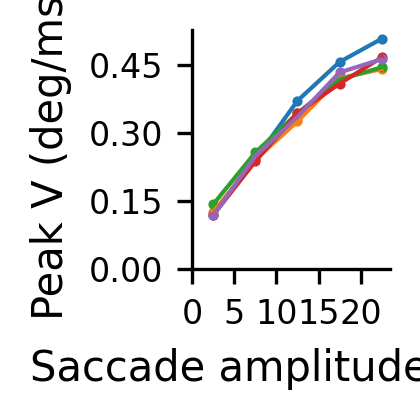

In [43]:
# classic main seq - This one works!!
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from typing import Optional

def plot_peak_velocity_vs_amplitude_binned_single(
    all_saccade_collection: pd.DataFrame,
    block_dict: dict,
    amp_col: Optional[str] = None,           # auto: 'net_angular_disp' or 'magnitude_raw_angular'
    eye_filter: Optional[str] = None,        # "L", "R", or None (both)
    bin_width_deg: float = 5.0,
    min_amp_deg: float = 0.5,
    max_amp_pct: float = 99.5,               # clip extreme amplitudes
    min_events_per_bin: int = 15,
    frame_rate_fps: float = 60.0,
    velocity_units_deg_per_ms: bool = True,  # convert deg/frame -> deg/ms
    per_animal_color: Optional[dict] = None, # {"PV_106":"#...", ...}
    figsize=(2.0, 1.7),
    dpi: int = 300,
    lw: float = 1.0,
    export_path: Optional[str] = None        # if provided, saves a PDF here
):
    """
    Classic main-sequence view, per animal:
      X = saccade amplitude bin center (deg)
      Y = mean peak angular velocity in that bin (deg/ms if velocity_units_deg_per_ms else deg/frame)
    Draws connected scatter (scatter + line) for each animal.

    Returns: (fig, ax, per_animal_stats)
      per_animal_stats[animal] -> DataFrame with columns:
        ['amp_lo','amp_hi','n','mean_peak_v']
    """
    # 0) Prep and choose amplitude column
    df = all_saccade_collection.copy().reset_index(drop=True)
    req = {"animal","block","eye","saccade_on_ms","saccade_off_ms"}
    if not req.issubset(df.columns):
        raise ValueError(f"all_saccade_collection must include columns {req}")

    if amp_col is None:
        for c in ("net_angular_disp","magnitude_raw_angular"):
            if c in df.columns:
                amp_col = c
                break
    if amp_col is None:
        raise ValueError("Need an angular amplitude column: 'net_angular_disp' or 'magnitude_raw_angular'.")

    if eye_filter:
        df = df[df["eye"].astype(str).str.upper() == eye_filter.upper()].copy()

    df[amp_col] = pd.to_numeric(df[amp_col], errors="coerce")
    df = df[np.isfinite(df[amp_col]) & (df[amp_col] >= float(min_amp_deg))]
    if df.empty:
        raise ValueError("No saccades after amplitude filtering.")

    # 1) Compute peak angular velocity per saccade
    # Prefer 'speed_profile_angular' (deg/frame). Fallback: compute from raw kinematics in the window.
    have_profiles = "speed_profile_angular" in df.columns

    def _peak_from_profile(x):
        if x is None or len(x) == 0:
            return np.nan
        return float(np.nanmax(np.asarray(x, dtype=float)))

    def _fallback_peak(row):
        # Use helpers you already defined in your notebook:
        # _eye_df(block_dict, animal, block, eye) and _raw_velocity_trace(df_eye) -> (t_ms, v_dps)
        try:
            eye_df = _eye_df(block_dict, row["animal"], row["block"], row["eye"])
        except Exception:
            return np.nan
        t_ms, v_dps = _raw_velocity_trace(eye_df)  # v in deg/s
        if t_ms.size == 0:
            return np.nan
        m = (t_ms >= float(row["saccade_on_ms"])) & (t_ms <= float(row["saccade_off_ms"])) & np.isfinite(v_dps)
        if not np.any(m):
            return np.nan
        return float(np.nanmax(v_dps[m]))  # deg/s

    if have_profiles:
        # deg/frame → convert later if requested
        peak_deg_per_frame = df["speed_profile_angular"].apply(_peak_from_profile).to_numpy(dtype=float)
        # Convert to target units
        if velocity_units_deg_per_ms:
            peak = peak_deg_per_frame * (frame_rate_fps / 1000.0)  # deg/ms
        else:
            peak = peak_deg_per_frame  # deg/frame
    else:
        # fallback: compute deg/s in window; convert if desired
        peak_deg_per_s = df.apply(_fallback_peak, axis=1).to_numpy(dtype=float)
        if velocity_units_deg_per_ms:
            peak = peak_deg_per_s / 1000.0  # deg/ms
        else:
            # you asked for classic main sequence; if you want deg/frame instead, set velocity_units_deg_per_ms=False
            peak = peak_deg_per_s  # deg/s

    df["peak_velocity"] = peak
    df = df[np.isfinite(df["peak_velocity"])]

    # 2) Shared amplitude bins across animals
    amp_max = float(np.nanpercentile(df[amp_col], max_amp_pct))
    edges = np.arange(0.0, amp_max + bin_width_deg, bin_width_deg)
    if edges.size < 3:
        amp_max = max(amp_max, min_amp_deg + 3*bin_width_deg)
        edges = np.arange(0.0, amp_max + bin_width_deg, bin_width_deg)
    df["amp_bin_idx"] = pd.cut(df[amp_col], bins=edges, labels=False, include_lowest=True, right=False)

    animals = sorted(df["animal"].dropna().unique().tolist())
    per_animal_stats = {}

    # 3) Aggregate mean peak velocity per animal × bin
    for a in animals:
        sub = df[df["animal"] == a]
        rows = []
        for b in range(len(edges)-1):
            g = sub[sub["amp_bin_idx"] == b]["peak_velocity"].to_numpy(dtype=float)
            g = g[np.isfinite(g)]
            n = g.size
            mean_peak = float(np.nanmean(g)) if n >= min_events_per_bin else np.nan
            rows.append((edges[b], edges[b+1], n, mean_peak))
        stats = pd.DataFrame(rows, columns=["amp_lo","amp_hi","n","mean_peak_v"])
        per_animal_stats[a] = stats

    # 4) Plot: connected scatter (scatter + line), one line per animal
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    handles, labels = [], []

    for a in animals:
        S = per_animal_stats[a]
        xs = 0.5*(S["amp_lo"].to_numpy() + S["amp_hi"].to_numpy())
        ys = S["mean_peak_v"].to_numpy()
        m = np.isfinite(xs) & np.isfinite(ys)
        if not np.any(m):
            continue
        color = per_animal_color.get(a, None) if per_animal_color else None
        # scatter first for markers, then a thin line to connect
        sc = ax.scatter(xs[m], ys[m], s=6, linewidths=0, color=color)  # small markers for dense bins
        ln, = ax.plot(xs[m], ys[m], lw=lw, color=color, label=a)
        handles.append(ln); labels.append(a)

    # 5) Styling (per your compact specs)
    xlab = "Saccade amplitude (deg)"
    if velocity_units_deg_per_ms:
        ylab = "Peak V (deg/ms)"
    else:
        # If you used fallback deg/s and kept deg/s:
        ylab = "Peak V (deg/frame)" if have_profiles else "Peak velocity (deg/s)"

    ax.set_xlabel(xlab, fontsize=10)
    ax.set_ylabel(ylab, fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
    ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    for sp in ("top","right"): ax.spines[sp].set_visible(False)
    fig.tight_layout()

    # Legend inline (small).
    #if handles:
    #    ax.legend(handles, labels, frameon=False, fontsize=8, ncol=1)

    # 6) Export (main figure only)
    if export_path:
        p = pathlib.Path(export_path); p.mkdir(parents=True, exist_ok=True)
        fig.savefig(p / "main_sequence_peak_velocity_connected_scatter.pdf", bbox_inches="tight")

    return fig, ax, per_animal_stats
export_path = pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\peak_v_amplitude_per_animal')
plot_peak_velocity_vs_amplitude_binned_single(all_saccade_collection,block_dict, figsize=(1.5,1.5), export_path=export_path)

(<Figure size 450x510 with 1 Axes>,
 <Axes: xlabel='Amplitude [deg]', ylabel='Peak V [deg/ms]'>,
 {'PV_106':    amp_lo  amp_hi     n  mean_peak_v
  0     0.0     5.0  5032     0.120375
  1     5.0    10.0  1340     0.242502
  2    10.0    15.0   403     0.371490
  3    15.0    20.0   108     0.456992
  4    20.0    25.0    51     0.508111,
  'PV_126':    amp_lo  amp_hi     n  mean_peak_v
  0     0.0     5.0  5572     0.125256
  1     5.0    10.0  1601     0.242343
  2    10.0    15.0   442     0.325364
  3    15.0    20.0   159     0.423422
  4    20.0    25.0    48     0.434699,
  'PV_143':    amp_lo  amp_hi     n  mean_peak_v
  0     0.0     5.0  2238     0.143446
  1     5.0    10.0   730     0.257574
  2    10.0    15.0   160     0.343865
  3    15.0    20.0    38     0.418390
  4    20.0    25.0    16     0.445180,
  'PV_57':    amp_lo  amp_hi     n  mean_peak_v
  0     0.0     5.0  7814     0.119861
  1     5.0    10.0  2016     0.237993
  2    10.0    15.0   731     0.344383
  3

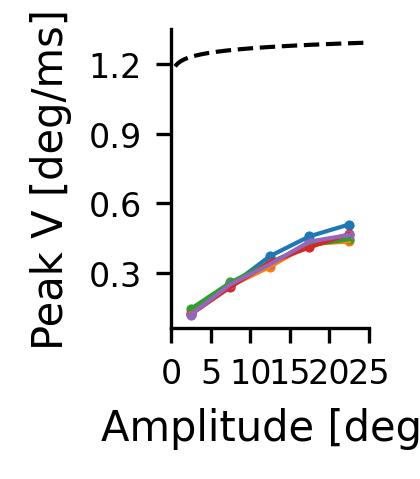

In [105]:
# main seq + sqrt fitting
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from typing import Optional

def plot_peak_velocity_vs_amplitude_powerlaw_fit(
    all_saccade_collection: pd.DataFrame,
    block_dict: dict,
    amp_col: Optional[str] = None,            # auto: 'net_angular_disp' or 'magnitude_raw_angular'
    eye_filter: Optional[str] = None,         # "L", "R", or None (both)
    bin_width_deg: float = 5.0,
    min_amp_deg: float = 0.5,
    max_amp_pct: float = 99.5,                # clip extreme amplitudes
    min_events_per_bin: int = 15,
    frame_rate_fps: float = 60.0,
    per_animal_color: Optional[dict] = None,  # {"PV_106":"#...", ...}
    fit_mode: str = "global",                 # "global" or "per_animal"
    figsize=(2.0, 1.7),
    dpi: int = 300,
    lw: float = 1.0,
    export_path: Optional[str] = None
):
    """
    Main-sequence figure with per-animal connected scatter of binned means,
    plus a power-law fit trace:
        log10(V_peak) = α + β * log10(A)
      ⇒ V_peak = 10^α * A^β

    Y units are deg/ms. No inline legend; if export_path is provided,
    exports the figure and a separate legend PDF.

    Returns:
      fig, ax, per_animal_stats, fit_results
        per_animal_stats[animal] -> DataFrame ['amp_lo','amp_hi','n','mean_peak_v']
        fit_results:
          if global: {'alpha','beta','R2'}
          if per_animal: dict[animal] -> {'alpha','beta','R2'}
    """
    # Helpers available in your notebook:
    #   _eye_df(block_dict, animal, block, eye) -> df with ms_axis,k_phi,k_theta
    #   _raw_velocity_trace(df_eye) -> (t_ms, v_dps) with v in deg/s

    df = all_saccade_collection.copy().reset_index(drop=True)
    req = {"animal","block","eye","saccade_on_ms","saccade_off_ms"}
    if not req.issubset(df.columns):
        raise ValueError(f"all_saccade_collection must include columns {req}")

    # choose amplitude column
    if amp_col is None:
        for c in ("net_angular_disp","magnitude_raw_angular"):
            if c in df.columns:
                amp_col = c
                break
    if amp_col is None:
        raise ValueError("Need angular amplitude column: 'net_angular_disp' or 'magnitude_raw_angular'.")

    if eye_filter:
        df = df[df["eye"].astype(str).str.upper() == eye_filter.upper()].copy()

    # ---- compute per-saccade peak velocity in deg/ms ----
    have_profiles = "speed_profile_angular" in df.columns  # deg/frame when present

    def _peak_from_profile(x):
        if x is None or len(x) == 0: return np.nan
        return float(np.nanmax(np.asarray(x, dtype=float)))  # deg/frame

    def _fallback_peak(row):
        try:
            eye_df = _eye_df(block_dict, row["animal"], row["block"], row["eye"])
        except Exception:
            return np.nan
        t_ms, v_dps = _raw_velocity_trace(eye_df)  # deg/s
        if t_ms.size == 0: return np.nan
        m = (t_ms >= float(row["saccade_on_ms"])) & (t_ms <= float(row["saccade_off_ms"])) & np.isfinite(v_dps)
        if not np.any(m): return np.nan
        return float(np.nanmax(v_dps[m]))  # deg/s

    if have_profiles:
        peak_dpf = df["speed_profile_angular"].apply(_peak_from_profile).to_numpy(dtype=float)
        peak_deg_per_ms = peak_dpf * (frame_rate_fps / 1000.0)  # deg/ms
    else:
        peak_dps = df.apply(_fallback_peak, axis=1).to_numpy(dtype=float)
        peak_deg_per_ms = peak_dps / 1000.0  # deg/ms

    df["peak_velocity"] = peak_deg_per_ms

    # ---- clean amplitude & velocity ----
    df[amp_col] = pd.to_numeric(df[amp_col], errors="coerce")
    m_valid = np.isfinite(df[amp_col]) & np.isfinite(df["peak_velocity"]) & (df[amp_col] >= float(min_amp_deg))
    df = df[m_valid].copy()
    if df.empty:
        raise ValueError("No saccades after filtering.")

    # ---- shared amplitude bins for the connected scatter ----
    amp_max = float(np.nanpercentile(df[amp_col], max_amp_pct))
    edges = np.arange(0.0, amp_max + bin_width_deg, bin_width_deg)
    if edges.size < 3:
        amp_max = max(amp_max, min_amp_deg + 3*bin_width_deg)
        edges = np.arange(0.0, amp_max + bin_width_deg, bin_width_deg)
    df["amp_bin_idx"] = pd.cut(df[amp_col], bins=edges, labels=False, include_lowest=True, right=False)

    animals = sorted(df["animal"].dropna().unique().tolist())
    per_animal_stats = {}

    for a in animals:
        sub = df[df["animal"] == a]
        rows = []
        for b in range(len(edges)-1):
            g = sub[sub["amp_bin_idx"] == b]["peak_velocity"].to_numpy(dtype=float)
            g = g[np.isfinite(g)]
            n = g.size
            mean_peak = float(np.nanmean(g)) if n >= min_events_per_bin else np.nan
            rows.append((edges[b], edges[b+1], n, mean_peak))
        per_animal_stats[a] = pd.DataFrame(rows, columns=["amp_lo","amp_hi","n","mean_peak_v"])

    # ---- fit: log10(V) = α + β*log10(A) ----
    def _ols_loglog(xs, ys):
        # xs, ys are raw per-saccade (not binned); filter >0
        m = (xs > 0) & np.isfinite(xs) & np.isfinite(ys) & (ys > 0)
        if m.sum() < 3:
            return np.nan, np.nan, np.nan
        X = np.log10(xs[m]); Y = np.log10(ys[m])
        beta, alpha = np.polyfit(X, Y, 1)  # Y = alpha + beta*X
        # R^2
        Y_hat = alpha + beta*X
        ss_res = np.sum((Y - Y_hat)**2)
        ss_tot = np.sum((Y - np.mean(Y))**2)
        R2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan
        return float(alpha), float(beta), float(R2)

    fit_results = None
    if fit_mode.lower() == "global":
        alpha, beta, R2 = _ols_loglog(df[amp_col].to_numpy(float),
                                      df["peak_velocity"].to_numpy(float))
        fit_results = {"alpha": alpha, "beta": beta, "R2": R2}
    elif fit_mode.lower() == "per_animal":
        fit_results = {}
        for a in animals:
            sub = df[df["animal"] == a]
            alpha, beta, R2 = _ols_loglog(sub[amp_col].to_numpy(float),
                                          sub["peak_velocity"].to_numpy(float))
            fit_results[a] = {"alpha": alpha, "beta": beta, "R2": R2}
    else:
        raise ValueError("fit_mode must be 'global' or 'per_animal'")

    # ---- plot ----
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)

    # connected scatter (per animal)
    handles_anim, labels_anim = [], []
    for a in animals:
        S = per_animal_stats[a]
        xs = 0.5*(S["amp_lo"].to_numpy() + S["amp_hi"].to_numpy())
        ys = S["mean_peak_v"].to_numpy()
        m = np.isfinite(xs) & np.isfinite(ys)
        if not np.any(m):
            continue
        color = per_animal_color.get(a, None) if per_animal_color else None
        ax.scatter(xs[m], ys[m], s=6, linewidths=0, color=color)
        ln, = ax.plot(xs[m], ys[m], lw=lw, color=color, label=a)
        handles_anim.append(ln); labels_anim.append(a)

    # power-law fit trace(s)
    x_line = np.linspace(float(min_amp_deg), float(edges[-1]), 200)
    if fit_mode.lower() == "global":
        if np.isfinite(fit_results["alpha"]) and np.isfinite(fit_results["beta"]):
            y_line = (10.0**fit_results["alpha"]) * np.power(x_line, fit_results["beta"])
            ax.plot(x_line, y_line, ls='--', lw=lw, color='k')  # black dashed line
    else:  # per_animal
        for a in animals:
            fr = fit_results.get(a, None)
            if fr and np.isfinite(fr["alpha"]) and np.isfinite(fr["beta"]):
                color = per_animal_color.get(a, None) if per_animal_color else None
                y_line = (10.0**fr["alpha"]) * np.power(x_line, fr["beta"])
                ax.plot(x_line, y_line, ls='--', lw=lw, color=color)

    # styling
    ax.set_xlabel("Amplitude [deg]", fontsize=10)
    ax.set_ylabel("Peak V [deg/ms]", fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
    ax.set_xticks([0,5,10,15,20,25])
    ax.set_xlim(left=0)
    ax.set_xlim(right=25)
    for sp in ("top","right"): ax.spines[sp].set_visible(False)
    fig.tight_layout()

    # no inline legend; export figure + separate legend only if export_path is set
    if export_path:
        import pathlib, pickle, matplotlib.lines as mlines
        p = pathlib.Path(export_path); p.mkdir(parents=True, exist_ok=True)
        fig.savefig(p / "main_sequence_peakV_powerlaw.pdf", bbox_inches="tight")

        # Legend PDF: animals + power-law fit item
        fig_leg = plt.figure(figsize=(2.0, 1.7), dpi=dpi)
        powerlaw_item = mlines.Line2D([], [], ls='--', lw=lw, color='k',
                                      label='Power-law fit')
        leg_items = handles_anim + [powerlaw_item]
        leg_labels = labels_anim + ['Power-law fit']
        fig_leg.legend(leg_items, leg_labels, frameon=False, ncol=1, fontsize=8, loc="center")
        fig_leg.savefig(p / "main_sequence_peakV_legend.pdf", bbox_inches="tight")
        plt.close(fig_leg)

        # Save bin stats and fit params
        with open(p / "main_sequence_peakV_binstats.pkl", "wb") as f:
            pickle.dump(per_animal_stats, f)
        with open(p / "main_sequence_peakV_powerlaw_fit.pkl", "wb") as f:
            pickle.dump(fit_results, f)

    return fig, ax, per_animal_stats, fit_results

export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\peak_v_amplitude_per_animal'
plot_peak_velocity_vs_amplitude_powerlaw_fit(all_saccade_collection,block_dict, bin_width_deg=5, export_path=export_path, figsize=(1.5, 1.7))

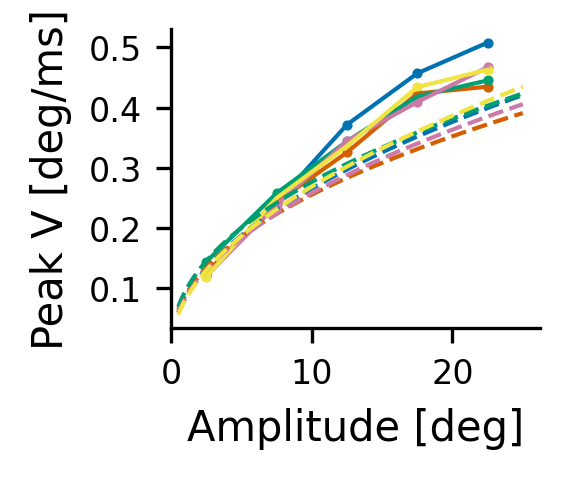

In [89]:
# now per animal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from typing import Optional

def plot_peak_velocity_vs_amplitude_powerlaw_fit_per_animal(
    all_saccade_collection: pd.DataFrame,
    block_dict: dict,
    amp_col: Optional[str] = None,            # auto: 'net_angular_disp' or 'magnitude_raw_angular'
    eye_filter: Optional[str] = None,         # "L", "R", or None (both)
    bin_width_deg: float = 5.0,
    min_amp_deg: float = 0.5,
    max_amp_pct: float = 99.5,                # clip extreme amplitudes
    min_events_per_bin: int = 15,
    frame_rate_fps: float = 60.0,
    per_animal_color: Optional[dict] = None,  # {"PV_106":"#...", ...}
    figsize=(2.0, 1.7),
    dpi: int = 300,
    lw: float = 1.0,
    export_path: Optional[str] = None
):
    """
    Per-animal main sequence:
      - Connected scatter of per-bin mean peak velocity (deg/ms).
      - Per-animal power-law fit: log10(V) = alpha + beta*log10(A).
    No inline legend; if export_path is given, saves figure + a separate legend PDF.

    Returns:
      fig, ax, per_animal_stats, fit_results_per_animal
        per_animal_stats[animal]: DataFrame ['amp_lo','amp_hi','n','mean_peak_v']
        fit_results_per_animal[animal]: {'alpha','beta','R2'}
    """
    # Helpers assumed defined in your notebook:
    #   _eye_df(block_dict, animal, block, eye)
    #   _raw_velocity_trace(df_eye) -> (t_ms, v_dps) with v in deg/s

    df = all_saccade_collection.copy().reset_index(drop=True)
    req = {"animal","block","eye","saccade_on_ms","saccade_off_ms"}
    if not req.issubset(df.columns):
        raise ValueError(f"all_saccade_collection must include columns {req}")

    # choose amplitude column
    if amp_col is None:
        for c in ("net_angular_disp","magnitude_raw_angular"):
            if c in df.columns:
                amp_col = c
                break
    if amp_col is None:
        raise ValueError("Need angular amplitude column: 'net_angular_disp' or 'magnitude_raw_angular'.")

    if eye_filter:
        df = df[df["eye"].astype(str).str.upper() == eye_filter.upper()].copy()

    # per-saccade peak velocity in deg/ms
    have_profiles = "speed_profile_angular" in df.columns  # deg/frame when present
    def _peak_from_profile(x):
        if x is None or len(x) == 0: return np.nan
        return float(np.nanmax(np.asarray(x, dtype=float)))  # deg/frame

    def _fallback_peak(row):
        try:
            eye_df = _eye_df(block_dict, row["animal"], row["block"], row["eye"])
        except Exception:
            return np.nan
        t_ms, v_dps = _raw_velocity_trace(eye_df)  # deg/s
        if t_ms.size == 0: return np.nan
        m = (t_ms >= float(row["saccade_on_ms"])) & (t_ms <= float(row["saccade_off_ms"])) & np.isfinite(v_dps)
        if not np.any(m): return np.nan
        return float(np.nanmax(v_dps[m]))  # deg/s

    if have_profiles:
        peak_dpf = df["speed_profile_angular"].apply(_peak_from_profile).to_numpy(dtype=float)
        peak_deg_per_ms = peak_dpf * (frame_rate_fps / 1000.0)  # deg/ms
    else:
        peak_dps = df.apply(_fallback_peak, axis=1).to_numpy(dtype=float)
        peak_deg_per_ms = peak_dps / 1000.0  # deg/ms

    df["peak_velocity"] = peak_deg_per_ms

    # clean amplitude & velocity
    df[amp_col] = pd.to_numeric(df[amp_col], errors="coerce")
    m_valid = np.isfinite(df[amp_col]) & np.isfinite(df["peak_velocity"]) & (df[amp_col] >= float(min_amp_deg))
    df = df[m_valid].copy()
    if df.empty:
        raise ValueError("No saccades after filtering.")

    # shared amplitude bins for the connected scatter
    amp_max = float(np.nanpercentile(df[amp_col], max_amp_pct))
    edges = np.arange(0.0, amp_max + bin_width_deg, bin_width_deg)
    if edges.size < 3:
        amp_max = max(amp_max, min_amp_deg + 3*bin_width_deg)
        edges = np.arange(0.0, amp_max + bin_width_deg, bin_width_deg)
    df["amp_bin_idx"] = pd.cut(df[amp_col], bins=edges, labels=False, include_lowest=True, right=False)

    animals = sorted(df["animal"].dropna().unique().tolist())

    # per-animal bin means
    per_animal_stats = {}
    for a in animals:
        sub = df[df["animal"] == a]
        rows = []
        for b in range(len(edges)-1):
            g = sub[sub["amp_bin_idx"] == b]["peak_velocity"].to_numpy(dtype=float)
            g = g[np.isfinite(g)]
            n = g.size
            mean_peak = float(np.nanmean(g)) if n >= min_events_per_bin else np.nan
            rows.append((edges[b], edges[b+1], n, mean_peak))
        per_animal_stats[a] = pd.DataFrame(rows, columns=["amp_lo","amp_hi","n","mean_peak_v"])

    # per-animal log-log OLS
    def _ols_loglog(xs, ys):
        m = (xs > 0) & np.isfinite(xs) & np.isfinite(ys) & (ys > 0)
        if m.sum() < 3:
            return np.nan, np.nan, np.nan
        X = np.log10(xs[m]); Y = np.log10(ys[m])
        beta, alpha = np.polyfit(X, Y, 1)  # Y = alpha + beta*X
        Y_hat = alpha + beta*X
        ss_res = np.sum((Y - Y_hat)**2)
        ss_tot = np.sum((Y - np.mean(Y))**2)
        R2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan
        return float(alpha), float(beta), float(R2)

    fit_results = {}
    for a in animals:
        sub = df[df["animal"] == a]
        alpha, beta, R2 = _ols_loglog(sub[amp_col].to_numpy(float),
                                      sub["peak_velocity"].to_numpy(float))
        fit_results[a] = {"alpha": alpha, "beta": beta, "R2": R2}

    # plot
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    handles_anim, labels_anim = [], []

    # connected scatter (binned means)
    for a in animals:
        S = per_animal_stats[a]
        xs = 0.5*(S["amp_lo"].to_numpy() + S["amp_hi"].to_numpy())
        ys = S["mean_peak_v"].to_numpy()
        m = np.isfinite(xs) & np.isfinite(ys)
        if not np.any(m):
            continue
        color = per_animal_color.get(a, None) if per_animal_color else None
        ax.scatter(xs[m], ys[m], s=6, linewidths=0, color=color)
        ln, = ax.plot(xs[m], ys[m], lw=lw, color=color, label=a)
        handles_anim.append(ln); labels_anim.append(a)

    # per-animal power-law fit traces
    x_line = np.linspace(float(min_amp_deg), float(edges[-1]), 200)
    for a in animals:
        fr = fit_results.get(a, None)
        if fr and np.isfinite(fr["alpha"]) and np.isfinite(fr["beta"]):
            color = per_animal_color.get(a, None) if per_animal_color else None
            y_line = (10.0**fr["alpha"]) * np.power(x_line, fr["beta"])
            ax.plot(x_line, y_line, ls='--', lw=lw, color=color)

    # styling
    ax.set_xlabel("Amplitude [deg]", fontsize=10)
    ax.set_ylabel("Peak V [deg/ms]", fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
    ax.set_xlim(left=0)
    for sp in ("top","right"): ax.spines[sp].set_visible(False)
    fig.tight_layout()

    # export (no inline legend)
    if export_path:
        import pathlib, pickle, matplotlib.lines as mlines
        p = pathlib.Path(export_path); p.mkdir(parents=True, exist_ok=True)
        fig.savefig(p / "main_sequence_peakV_per_animal_powerlaw.pdf", bbox_inches="tight")

        # legend PDF (animals + dashed "Power-law fit")
        fig_leg = plt.figure(figsize=(2.0, 1.7), dpi=dpi)
        powerlaw_item = mlines.Line2D([], [], ls='--', lw=lw, color='k', label='Power-law fit')
        leg_items = [ln for ln in handles_anim] + [powerlaw_item]
        leg_labels = [lbl for lbl in labels_anim] + ['Power-law fit']
        fig_leg.legend(leg_items, leg_labels, frameon=False, ncol=1, fontsize=8, loc="center")
        fig_leg.savefig(p / "main_sequence_peakV_per_animal_legend.pdf", bbox_inches="tight")
        plt.close(fig_leg)

        # save data
        with open(p / "main_sequence_peakV_per_animal_binstats.pkl", "wb") as f:
            pickle.dump(per_animal_stats, f)
        with open(p / "main_sequence_peakV_per_animal_fit.pkl", "wb") as f:
            pickle.dump(fit_results, f)

    return fig, ax, per_animal_stats, fit_results
# Lock per-animal colors (update with your actual palette if needed)
GLOBAL_COLORS = {
    'PV_106': '#0072B2',
    'PV_126': '#D55E00',
    'PV_143': '#009E73',
    'PV_57' : '#CC79A7',
    'PV_62' : '#F0E442'
}

# Run per-animal figure + fits
fig, ax, bin_stats, fits = plot_peak_velocity_vs_amplitude_powerlaw_fit_per_animal(
    all_saccade_collection=all_saccade_collection,
    block_dict=block_dict,
    amp_col=None,                     # auto-pick available angular amplitude column
    eye_filter=None,                  # or "L"/"R"
    bin_width_deg=5.0,
    min_amp_deg=0.5,
    max_amp_pct=99.5,
    min_events_per_bin=15,
    frame_rate_fps=60.0,
    per_animal_color=GLOBAL_COLORS,
    figsize=(2.0, 1.7),
    dpi=300,
    lw=1.0,
    export_path=None                  # or r"Z:\Nimrod\exports\main_sequence"
)

# 'fits' holds {'PV_106': {'alpha':..., 'beta':..., 'R2':...}, ...}
# 'bin_stats' holds per-animal per-bin mean peak velocities.


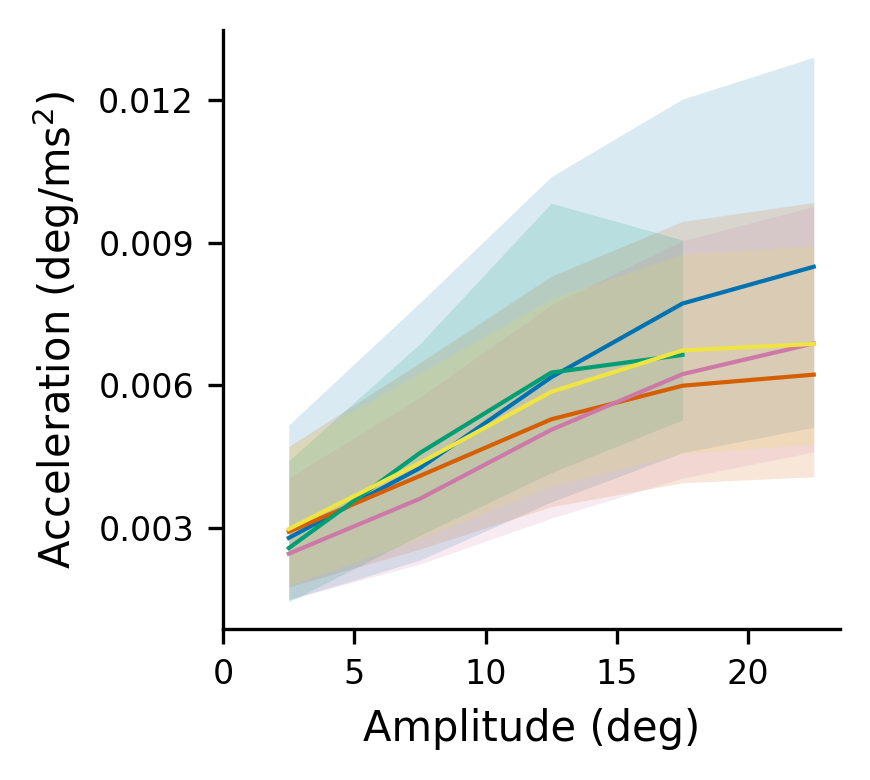

In [77]:
from typing import Optional, Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.ndimage import gaussian_filter1d
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.ndimage import gaussian_filter1d
from typing import Optional

def _nan_iqr(a, q1=25, q3=75):
    a = np.asarray(a, dtype=float)
    a = a[np.isfinite(a)]
    if a.size == 0: return np.nan, np.nan, np.nan
    ql, qm, qh = np.nanpercentile(a, [q1, 50, 75 if q3==75 else q3])
    return ql, qm, qh

def _accel_metric_from_window(t_ms, v_dps, on_ms, off_ms, mode="mean_abs_prepeak"):
    """
    Returns acceleration in deg/s^2 (converted later to deg/ms^2).
    - mode == "mean_abs_prepeak": mean(|dv/dt|) from onset → peak velocity
    - mode == "peak": max(dv/dt) over the whole saccade
    """
    m = (t_ms >= on_ms) & (t_ms <= off_ms) & np.isfinite(v_dps)
    if not np.any(m):
        return np.nan

    t = t_ms[m] / 1000.0  # seconds
    v = v_dps[m]          # deg/s
    if v.size < 3:
        return np.nan

    i_peak = int(np.nanargmax(v))
    dt = np.diff(t)
    dv = np.diff(v)
    with np.errstate(divide='ignore', invalid='ignore'):
        a = np.divide(dv, dt, out=np.full_like(dv, np.nan), where=dt > 0)  # deg/s^2

    if not np.any(np.isfinite(a)): return np.nan
    if mode == "peak":
        return float(np.nanmax(a))
    elif mode == "mean_abs_prepeak":
        if i_peak <= 1:
            return float(np.nanmean(np.abs(a)))
        return float(np.nanmean(np.abs(a[:i_peak])))
    return float(np.nanmean(np.abs(a)))

def plot_main_sequence_accel_single(
    all_saccade_collection: pd.DataFrame,
    block_dict: dict,
    amp_col: Optional[str] = None,                 # auto: net_angular_disp or magnitude_raw_angular
    eye_filter: Optional[str] = None,              # "L", "R", or None (both)
    accel_mode: str = "mean_abs_prepeak",          # "mean_abs_prepeak" or "peak"
    min_amp_deg: float = 0.5,
    max_amp_pct: float = 99.5,
    bin_width_deg: float = 5.0,
    min_events_per_bin: int = 20,
    smooth_bandwidth_bins: Optional[float] = None, # e.g., 1.0
    per_animal_color: Optional[dict] = None,       # {"PV_106":"#...", ...}
    show_iqr_band: bool = True,
    figsize=(2.0, 1.7),
    dpi: int = 300,
    export_path: Optional[str] = None
):
    """
    Single-axes summary:
      x = amplitude (deg)
      y = robust acceleration metric (deg/ms^2), one trace per animal.
    Saves legend as a separate PDF when export_path is provided.
    """
    df = all_saccade_collection.copy().reset_index(drop=True)
    req = {"animal","block","eye","saccade_on_ms","saccade_off_ms"}
    if not req.issubset(df.columns):
        raise ValueError(f"all_saccade_collection must include columns {req}")

    # Choose amplitude column
    if amp_col is None:
        for c in ("net_angular_disp","magnitude_raw_angular"):
            if c in df.columns: amp_col = c; break
    if amp_col is None:
        raise ValueError("Need angular amplitude column: 'net_angular_disp' or 'magnitude_raw_angular'.")

    if eye_filter:
        df = df[df["eye"].astype(str).str.upper() == eye_filter.upper()].copy()

    df[amp_col] = pd.to_numeric(df[amp_col], errors="coerce")
    df = df[np.isfinite(df[amp_col])]
    df = df[df[amp_col] >= float(min_amp_deg)]
    if df.empty: raise ValueError("No saccades after amplitude filtering.")

    # Common amplitude bins
    amp_max = float(np.nanpercentile(df[amp_col], max_amp_pct))
    edges = np.arange(0.0, amp_max + bin_width_deg, bin_width_deg)
    if edges.size < 3:
        amp_max = max(amp_max, min_amp_deg + 3*bin_width_deg)
        edges = np.arange(0.0, amp_max + bin_width_deg, bin_width_deg)
    df["amp_bin_idx"] = pd.cut(df[amp_col], bins=edges, labels=False, include_lowest=True, right=False)
    animals = sorted(df["animal"].dropna().unique().tolist())

    # Compute acceleration metric per saccade (deg/s^2 → deg/ms^2 later)
    accel_vals = np.full(len(df), np.nan, dtype=float)
    for i, row in df.iterrows():
        try:
            eye_df = _eye_df(block_dict, row["animal"], row["block"], row["eye"])
        except Exception:
            continue
        t_ms, v_dps = _raw_velocity_trace(eye_df)
        a_s2 = _accel_metric_from_window(t_ms, v_dps,
                                         float(row["saccade_on_ms"]),
                                         float(row["saccade_off_ms"]),
                                         mode=accel_mode)  # deg/s^2
        if np.isfinite(a_s2):
            accel_vals[i] = a_s2 / 1e6  # → deg/ms^2
    df["accel_metric"] = accel_vals
    df = df[np.isfinite(df["accel_metric"])]

    # Aggregate per animal × amp bin
    per_animal_stats = {}
    for a in animals:
        sub = df[df["animal"] == a]
        records = []
        for b in range(len(edges)-1):
            g = sub[sub["amp_bin_idx"] == b]["accel_metric"].to_numpy(dtype=float)
            g = g[np.isfinite(g)]
            n = g.size
            if n < min_events_per_bin:
                records.append((edges[b], edges[b+1], n, np.nan, np.nan, np.nan))
            else:
                q25, med, q75 = _nan_iqr(g, 25, 75)
                records.append((edges[b], edges[b+1], n, med, q25, q75))
        stats = pd.DataFrame(records, columns=["amp_lo","amp_hi","n","median_accel","q25","q75"])
        per_animal_stats[a] = stats

    # Plot (fonts & sizes per your spec)
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    xs_master = 0.5*(edges[:-1] + edges[1:])

    legend_handles = []
    legend_labels  = []

    for a in animals:
        S = per_animal_stats[a]
        xs  = 0.5*(S["amp_lo"].to_numpy() + S["amp_hi"].to_numpy())
        ys  = S["median_accel"].to_numpy()
        q25 = S["q25"].to_numpy()
        q75 = S["q75"].to_numpy()

        if smooth_bandwidth_bins and np.isfinite(ys).sum() >= 5:
            sigma = float(smooth_bandwidth_bins)
            ys  = gaussian_filter1d(ys,  sigma=sigma, mode="nearest", truncate=2.0)
            q25 = gaussian_filter1d(q25, sigma=sigma, mode="nearest", truncate=2.0)
            q75 = gaussian_filter1d(q75, sigma=sigma, mode="nearest", truncate=2.0)

        color = per_animal_color.get(a, None) if per_animal_color else None
        ln, = ax.plot(xs, ys, lw=1, color=color, label=a)
        if show_iqr_band:
            ax.fill_between(xs, q25, q75, alpha=0.15, color=color, linewidth=0)
        legend_handles.append(ln); legend_labels.append(a)

    # Styling
    ax.set_xlabel("Amplitude (deg)", fontsize=10)
    ax.set_ylabel("Acceleration (deg/ms$^2$)", fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
    ax.set_xlim(left=0)
    for sp in ("top","right"): ax.spines[sp].set_visible(False)
    fig.tight_layout()

    if export_path:
        p = pathlib.Path(export_path); p.mkdir(parents=True, exist_ok=True)
        # Save main figure WITHOUT legend
        fig.savefig(p / f"main_sequence_accel_single_{accel_mode}.pdf", bbox_inches="tight")

        # Legend in a separate PDF
        fig_leg = plt.figure(figsize=(2.0, 1.7), dpi=dpi)
        leg = fig_leg.legend(legend_handles, legend_labels, frameon=False, ncol=1, fontsize=8, loc="center")
        fig_leg.canvas.draw()
        fig_leg.savefig(p / f"main_sequence_accel_single_{accel_mode}_legend.pdf", bbox_inches="tight")
        plt.close(fig_leg)

        # Save aggregated stats
        with open(p / f"main_sequence_accel_single_{accel_mode}.pkl", "wb") as f:
            pickle.dump(per_animal_stats, f)
    #else:
        # Show legend inline only if not exporting
        #ax.legend(frameon=False, ncol=1, fontsize=8)

    return fig, ax, per_animal_stats

# Optional: lock your animal colors for consistency across figures
GLOBAL_COLORS = {
    'PV_106': '#0072B2',
    'PV_126': '#D55E00',
    'PV_143': '#009E73',
    'PV_57' : '#CC79A7',
    'PV_62' : '#F0E442'
}

fig, ax, stats = plot_main_sequence_accel_single(
    all_saccade_collection=all_saccade_collection,
    block_dict=block_dict,
    amp_col=None,                        # auto-pick from your columns
    eye_filter=None,                     # or "L"/"R"
    accel_mode="mean_abs_prepeak",       # or "peak"
    min_amp_deg=0.5,
    max_amp_pct=99.5,
    bin_width_deg=5.0,
    min_events_per_bin=20,
    smooth_bandwidth_bins=1.0,           # light visual smoothing
    per_animal_color=GLOBAL_COLORS,
    show_iqr_band=True,
    figsize=(3, 2.7),
    dpi=300,
    export_path=None                     # or a folder path to export PDF + pickle
)



<ipython-input-67-4f527120c8ae>:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("viridis")
<ipython-input-67-4f527120c8ae>:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("viridis")
<ipython-input-67-4f527120c8ae>:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("viridis")
<ipython-input-67-4f527120c8ae>:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor rel

[<Figure size 800x560 with 1 Axes>,
 <Figure size 800x560 with 1 Axes>,
 <Figure size 800x560 with 1 Axes>,
 <Figure size 800x560 with 1 Axes>,
 <Figure size 800x560 with 1 Axes>]

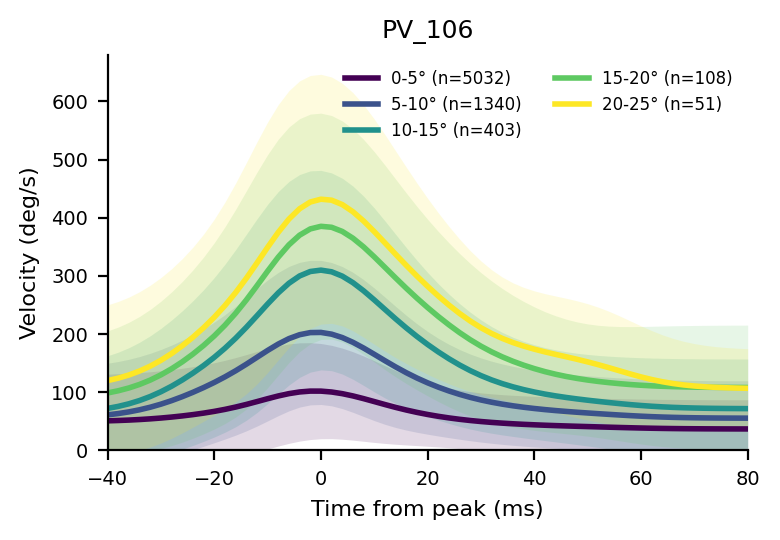

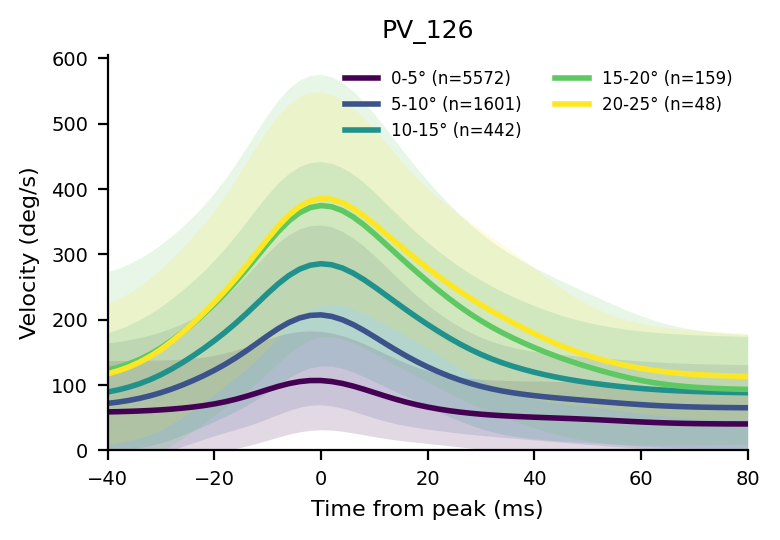

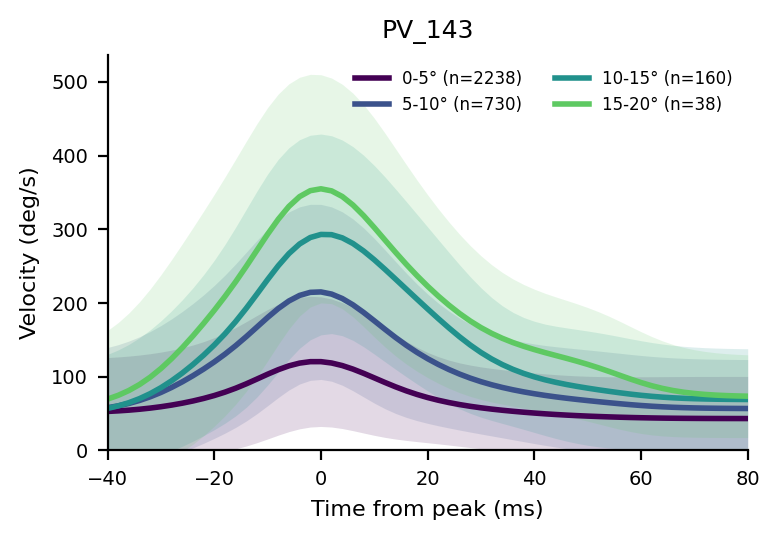

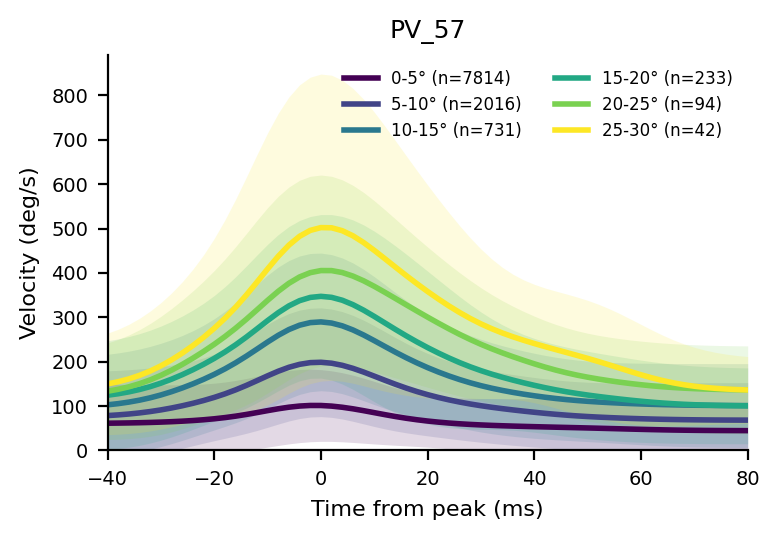

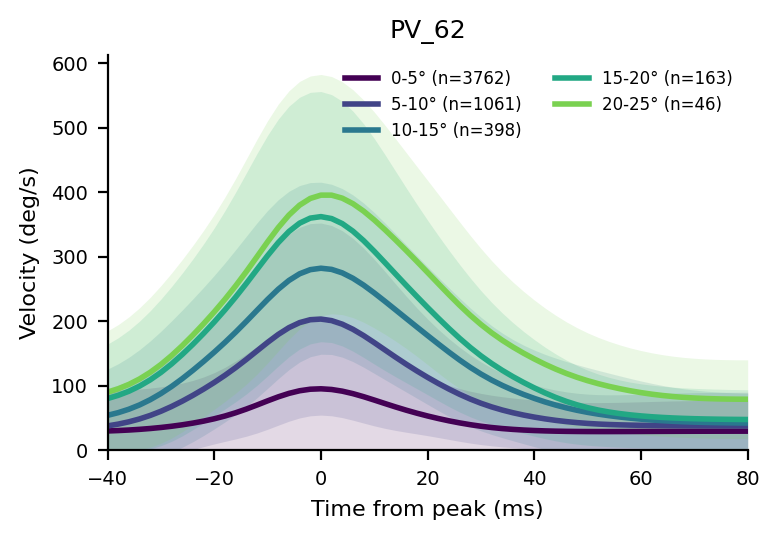

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from scipy.ndimage import gaussian_filter1d

def _block_key(animal, block_num):
    return f"{animal}_block_{int(block_num):03d}", f"{animal}_block_{int(block_num)}"

def _eye_df(block_dict, animal, block_num, eye):
    k1, k2 = _block_key(animal, block_num)
    blk = block_dict.get(k1, block_dict.get(k2, None))
    if blk is None:
        raise KeyError(f"Block not found for {animal} block {block_num} (tried {k1} / {k2})")
    df = blk.left_eye_data if str(eye).upper() == "L" else blk.right_eye_data
    if not {"ms_axis","k_phi","k_theta"}.issubset(df.columns):
        raise ValueError("Eye dataframe missing ms_axis/k_phi/k_theta")
    return df

def _raw_velocity_trace(df_eye):
    t = df_eye["ms_axis"].to_numpy(dtype=float)
    phi = df_eye["k_phi"].to_numpy(dtype=float)
    th  = df_eye["k_theta"].to_numpy(dtype=float)
    dphi = np.diff(phi); dth = np.diff(th); dt_s = np.diff(t) / 1000.0
    v_dps = np.divide(np.hypot(dphi, dth), dt_s, out=np.full_like(dphi, np.nan), where=dt_s>0)
    t_ms = t[1:]   # associate with the second sample (causal diff)
    return t_ms, v_dps

def _peak_time_in_window(t_ms, v_dps, on_ms, off_ms, subsample_peak=False):
    m = (t_ms >= on_ms) & (t_ms <= off_ms) & np.isfinite(v_dps)
    if not np.any(m):
        return np.nan
    v = v_dps[m]; tloc = t_ms[m]
    i = int(np.nanargmax(v))
    if not subsample_peak or i == 0 or i == v.size-1:
        return float(tloc[i])
    # 3-point parabola on deg/s
    v_1, v0, v1 = v[i-1], v[i], v[i+1]
    denom = (v_1 - 2*v0 + v1)
    if not np.isfinite(denom) or denom == 0:
        return float(tloc[i])
    d = 0.5*(v_1 - v1)/denom
    d = float(np.clip(d, -1.0, 1.0))
    # local time step (assume uniform near the peak)
    dt_local = (tloc[min(i+1, v.size-1)] - tloc[max(i-1, 0)]) / 2.0
    return float(tloc[i] + d * dt_local)

def plot_velocity_by_amp_bins_per_animal_kernel(
    all_saccade_collection: pd.DataFrame,
    block_dict: dict,
    amp_col: str = None,                 # auto-pick if None
    bin_width_deg: float = 5.0,
    min_amp_deg: float = 0.5,
    t_window_ms: tuple = (-40.0, 80.0),
    dt_ms: float = 2.0,                  # native sample bin width
    bandwidth_ms: float = 10.0,          # Gaussian kernel across time bins
    min_events_per_bin: int = 30,
    per_animal_max_bins: int = 8,
    eye_filter: str = None,              # "L", "R", or None (both)
    subsample_peak: bool = False         # set True if you want sub-frame peak alignment
):
    df = all_saccade_collection.reset_index(drop=True).copy()
    req = {"animal","block","eye","saccade_on_ms","saccade_off_ms"}
    if not req.issubset(df.columns): raise ValueError(f"DataFrame must have {req}")
    # choose amplitude column
    if amp_col is None:
        for c in ("net_angular_disp","magnitude_raw_angular"):
            if c in df.columns: amp_col = c; break
    if amp_col is None: raise ValueError("Need 'net_angular_disp' or 'magnitude_raw_angular'.")

    df[amp_col] = pd.to_numeric(df[amp_col], errors="coerce")
    if eye_filter: df = df[df["eye"].str.upper() == eye_filter.upper()]
    animals = sorted(df["animal"].dropna().unique().tolist())

    tmin, tmax = float(t_window_ms[0]), float(t_window_ms[1])
    t_grid = np.arange(tmin, tmax + dt_ms, dt_ms); nb = len(t_grid)
    sigma_bins = max(1.0, float(bandwidth_ms) / float(dt_ms))  # smoothing in bins

    figs = []
    for a in animals:
        sub = df[(df["animal"]==a) & (df[amp_col] >= float(min_amp_deg))].copy()
        if sub.empty: continue
        # amplitude bins
        max_amp = float(np.nanpercentile(sub[amp_col], 99.5))
        edges = np.arange(0.0, max_amp + bin_width_deg, bin_width_deg)
        if len(edges) > per_animal_max_bins+1: edges = edges[:per_animal_max_bins+1]
        labels = [f"{int(edges[i])}-{int(edges[i+1])}°" for i in range(len(edges)-1)]
        sub["amp_bin"] = pd.cut(sub[amp_col], bins=edges, labels=labels, include_lowest=True, right=False)

        fig, ax = plt.subplots(1,1, figsize=(4.0, 2.8), dpi=200)
        cmap = get_cmap("viridis")
        plotted = False

        for i, lab in enumerate(labels):
            g = sub[sub["amp_bin"] == lab]
            n_events = len(g)
            if n_events < min_events_per_bin: continue

            num  = np.zeros(nb, dtype=float)
            num2 = np.zeros(nb, dtype=float)
            den  = np.zeros(nb, dtype=float)

            for _, row in g.iterrows():
                try:
                    eye_df = _eye_df(block_dict, row["animal"], row["block"], row["eye"])
                except Exception:
                    continue
                t_ms, v_dps = _raw_velocity_trace(eye_df)
                if t_ms.size < 3: continue

                pk_ms = _peak_time_in_window(t_ms, v_dps,
                                             float(row["saccade_on_ms"]),
                                             float(row["saccade_off_ms"]),
                                             subsample_peak=subsample_peak)
                if not np.isfinite(pk_ms): continue

                # window around the peak, use all native samples
                m = (t_ms >= pk_ms + tmin) & (t_ms <= pk_ms + tmax) & np.isfinite(v_dps)
                if not np.any(m): continue
                t_rel = t_ms[m] - pk_ms
                v     = v_dps[m]

                idx = np.floor((t_rel - tmin) / dt_ms).astype(int)
                ok = (idx >= 0) & (idx < nb)
                if not np.any(ok): continue
                np.add.at(num,  idx[ok], v[ok])
                np.add.at(num2, idx[ok], v[ok]**2)
                np.add.at(den,  idx[ok], 1.0)

            if den.sum() == 0: continue
            # Gaussian smooth num, num2, den (same sigma) => kernel-regressed mean & SD
            num_s  = gaussian_filter1d(num,  sigma=sigma_bins, mode='nearest')
            num2_s = gaussian_filter1d(num2, sigma=sigma_bins, mode='nearest')
            den_s  = gaussian_filter1d(den,  sigma=sigma_bins, mode='nearest')

            mean = np.divide(num_s, den_s, out=np.full(nb, np.nan), where=den_s > 1e-6)
            var  = np.divide(num2_s, den_s, out=np.full(nb, np.nan), where=den_s > 1e-6) - np.square(mean)
            std  = np.sqrt(np.clip(var, 0.0, None))

            c = cmap(i / max(1, len(labels)-1))
            ax.plot(t_grid, mean, lw=2, color=c, label=f"{lab} (n={n_events})")
            ax.fill_between(t_grid, mean-std, mean+std, color=c, alpha=0.15, linewidth=0)
            plotted = True

        ax.set_title(a, fontsize=9)
        ax.set_xlabel("Time from peak (ms)", fontsize=8)
        ax.set_ylabel("Velocity (deg/s)", fontsize=8)
        ax.tick_params(labelsize=7)
        for sp in ("top","right"): ax.spines[sp].set_visible(False)
        ax.set_xlim(tmin, tmax); ax.set_ylim(bottom=0)
        if plotted: ax.legend(frameon=False, fontsize=6, ncol=2)
        fig.tight_layout()
        figs.append(fig)

    return figs
plot_velocity_by_amp_bins_per_animal_kernel(all_saccade_collection,block_dict)

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval

def _as_array(x):
    if isinstance(x, (list, tuple, np.ndarray, pd.Series)): return np.asarray(x, float)
    if isinstance(x, str):
        try: return np.asarray(literal_eval(x), float)
        except Exception: return np.array([], float)
    if pd.isna(x): return np.array([], float)
    try: return np.asarray(x, float)
    except Exception: return np.array([], float)

def _parabolic_peak(y):
    y = np.asarray(y, float)
    if y.size == 0 or not np.isfinite(y).any(): return np.nan, np.nan
    i = int(np.nanargmax(y)); y0 = y[i]
    if i==0 or i==y.size-1: return y0, float(i)
    y_1, y1 = y[i-1], y[i+1]; dnm = (y[i-1]-2*y0+y[i+1])
    if not np.all(np.isfinite([y_1,y0,y1])) or dnm==0: return y0, float(i)
    d = 0.5*(y_1-y1)/dnm; d = float(np.clip(d, -1, 1))
    v_ref = y0 - 0.25*(y_1-y1)*d
    return (v_ref if np.isfinite(v_ref) else y0), float(i+d)

def plot_peakV_vs_TTP_simple(
    all_saccade_collection: pd.DataFrame,
    sampling_rate_hz: float = 60.0,
    min_amp_deg: float = 0.25,
    subsample_peak: bool = True,
    nbins_ttp: int = 20,
    fig_size=(7.5, 5.0),
):
    df = all_saccade_collection.reset_index(drop=True).copy()
    if "animal" not in df.columns: df["animal"] = "ALL"
    amp_col = "net_angular_disp" if "net_angular_disp" in df.columns else (
        "magnitude_raw_angular" if "magnitude_raw_angular" in df.columns else None
    )
    if amp_col is None: raise ValueError("Need 'net_angular_disp' or 'magnitude_raw_angular'.")

    frame_ms = 1000.0 / float(sampling_rate_hz)
    rows = []
    for _, r in df.iterrows():
        A = pd.to_numeric(r.get(amp_col), errors="coerce")
        if not np.isfinite(A) or A < float(min_amp_deg): continue
        prof = _as_array(r.get("speed_profile_angular", []))  # deg/frame
        if prof.size < 2 or not np.isfinite(prof).any(): continue
        if subsample_peak:
            vpk_df, i_pk = _parabolic_peak(prof)
        else:
            i_pk = int(np.nanargmax(prof)); vpk_df = prof[i_pk]
        vpk_dps = vpk_df * sampling_rate_hz
        ttp_ms = np.nan
        if "time_to_peak_v" in df.columns and pd.notna(r.get("time_to_peak_v")):
            ttp_ms = float(r["time_to_peak_v"])
        if not np.isfinite(ttp_ms): ttp_ms = float(i_pk * frame_ms)
        rows.append((r["animal"], vpk_dps, ttp_ms))
    if not rows: raise ValueError("No valid saccades after filtering.")

    dd = pd.DataFrame(rows, columns=["animal","vpeak_dps","ttp_ms"])
    animals = sorted(dd["animal"].unique().tolist())
    ncol = min(3, len(animals)); nrow = int(np.ceil(len(animals)/ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=fig_size, dpi=200, squeeze=False)

    for k, a in enumerate(animals):
        ax = axes[k//ncol, k%ncol]
        g = dd[dd["animal"]==a]
        ax.scatter(g["ttp_ms"], g["vpeak_dps"], s=3, alpha=0.15)
        # binned median curve
        if len(g) > nbins_ttp:
            qs = np.linspace(0, 1, nbins_ttp+1)
            edges = g["ttp_ms"].quantile(qs).to_numpy()
            edges = np.unique(edges)
            centers, med = [], []
            for i in range(len(edges)-1):
                m = (g["ttp_ms"] >= edges[i]) & (g["ttp_ms"] < edges[i+1])
                if m.sum() < 10: continue
                centers.append(np.median(g["ttp_ms"][m]))
                med.append(np.median(g["vpeak_dps"][m]))
            if centers:
                ax.plot(centers, med, lw=2, color="tab:red")
        ax.set_title(a, fontsize=9)
        ax.set_xlabel("Time to peak (ms)", fontsize=8)
        ax.set_ylabel("Peak velocity (deg/s)", fontsize=8)
        ax.tick_params(labelsize=7)
        for sp in ("top","right"): ax.spines[sp].set_visible(False)

    # turn off unused axes
    for idx in range(len(animals), nrow*ncol):
        axes[idx//ncol, idx%ncol].axis("off")

    fig.tight_layout()
    return fig, dd


In [57]:
# experimental 2
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit, OptimizeWarning
from scipy.special import betainc, betaincinv, beta as beta_fn
import warnings

warnings.filterwarnings("ignore", category=OptimizeWarning)

# ---------- core model ----------
def _beta_cdf_displacement(t, A, t0, D, a, b):
    """
    Cumulative angular displacement model (deg) as a scaled Beta CDF over time t (in frames).
    A  : total amplitude in deg
    t0 : onset shift in frames
    D  : duration in frames (>0)
    a,b: shape parameters (>0)
    """
    t = np.asarray(t, float)
    x = (t - t0) / np.maximum(D, 1e-6)
    x = np.clip(x, 0.0, 1.0)  # outside window: 0 or A
    # regularized incomplete beta of (a+1,b+1) integrates a beta-shaped velocity
    return A * betainc(a + 1.0, b + 1.0, x)

def _vpeak_from_beta(A, D, a, b):
    """Peak velocity in deg/frame (mode of Beta(a+1,b+1) scaled by A/D)."""
    if D <= 0 or a <= 0 or b <= 0:
        return np.nan
    xmode = a / (a + b)  # mode of Beta(a+1,b+1)
    num = (xmode**a) * ((1.0 - xmode)**b)
    den = beta_fn(a + 1.0, b + 1.0)
    return (A / D) * (num / den)

def _percent_time_from_beta(p, t0, D, a, b):
    """Time (frames) when cumulative displacement reaches fraction p of A."""
    if not (0.0 < p < 1.0) or D <= 0 or a <= 0 or b <= 0:
        return np.nan
    x = betaincinv(a + 1.0, b + 1.0, p)
    return t0 + D * x

# Column template for safe, consistent outputs
FIT_COLS = [
    'beta_A_deg','beta_t0_frames','beta_D_frames','beta_a','beta_b',
    'beta_vpeak_deg_per_frame','beta_vpeak_deg_per_ms',
    'beta_tpeak_frames','beta_tpeak_ms','beta_t10_ms','beta_t90_ms','beta_D_ms',
    'beta_r2','beta_rmse','n_samples','fit_ok','fit_error','time_to_peak_v'
]

def _empty_fit_dict():
    """A dict with all fit columns set to NaN/False. Always returned on failure/skip."""
    d = {k: np.nan for k in FIT_COLS}
    d['n_samples'] = 0
    d['fit_ok'] = False
    d['fit_error'] = ''
    return d

# ---------- per-event fitting ----------
def fit_event_beta(row, fps=60.0, min_len=4, min_amp_deg=0.2, maxfev=20000):
    """
    row: a row from all_saccade_collection with:
         - 'speed_profile_angular': list/array of angular speeds (deg/frame)
         - 'saccade_on_ms', 'saccade_off_ms' (not strictly required for the fit)
    Returns: dict with FIT_COLS always present.
    """
    out = _empty_fit_dict()

    prof = row.get('speed_profile_angular', None)
    if prof is None:
        out['fit_error'] = 'no_profile'
        return out

    v = np.asarray(prof, dtype=float)
    v = v[np.isfinite(v)]
    n = v.size
    out['n_samples'] = int(n)
    if n < int(min_len):
        out['fit_error'] = f'too_short(<{min_len})'
        return out

    # cumulative angular displacement (deg) vs frames
    t = np.arange(n, dtype=float)
    s = np.cumsum(v)  # deg
    if not np.isfinite(s[-1]) or s[-1] < float(min_amp_deg):
        out['fit_error'] = f'amp<{min_amp_deg}'
        return out

    # initial guesses / bounds
    A0 = float(s[-1])                 # amplitude
    D0 = max(1.0, float(n - 1))       # duration in frames
    p0 = [A0, 0.0, D0, 2.0, 2.0]      # A, t0, D, a, b
    lb = [0.0, -0.5,  0.5, 0.5, 0.5]
    ub = [np.inf, 1.0, n + 2.0, 10.0, 10.0]

    try:
        popt, _ = curve_fit(
            _beta_cdf_displacement, t, s, p0=p0, bounds=(lb, ub), maxfev=maxfev
        )
    except Exception as e:
        out['fit_error'] = f'opt_fail:{e.__class__.__name__}'
        return out

    A, t0, D, a, b = [float(x) for x in popt]

    # goodness of fit (R^2) on cumulative displacement
    s_fit = _beta_cdf_displacement(t, *popt)
    resid = s - s_fit
    ss_res = float(np.sum(resid**2))
    ss_tot = float(np.sum((s - np.mean(s))**2)) if n > 1 else np.nan
    r2 = 1.0 - ss_res/ss_tot if (np.isfinite(ss_tot) and ss_tot > 0) else np.nan
    rmse = np.sqrt(ss_res / max(1, n - len(popt)))

    # continuous metrics
    frame_ms = 1000.0 / float(fps)
    vpk_deg_per_frame = _vpeak_from_beta(A, D, a, b)
    vpk_deg_per_ms = vpk_deg_per_frame / frame_ms

    tpk_frames = t0 + D * (a / (a + b)) if (a > 0 and b > 0) else np.nan
    tpk_ms = tpk_frames * frame_ms if np.isfinite(tpk_frames) else np.nan
    t10_frames = _percent_time_from_beta(0.10, t0, D, a, b)
    t90_frames = _percent_time_from_beta(0.90, t0, D, a, b)

    out.update({
        'beta_A_deg': A,
        'beta_t0_frames': t0,
        'beta_D_frames': D,
        'beta_a': a,
        'beta_b': b,
        'beta_vpeak_deg_per_frame': vpk_deg_per_frame,
        'beta_vpeak_deg_per_ms': vpk_deg_per_ms,
        'beta_tpeak_frames': tpk_frames,
        'beta_tpeak_ms': tpk_ms,
        'beta_t10_ms': t10_frames * frame_ms if np.isfinite(t10_frames) else np.nan,
        'beta_t90_ms': t90_frames * frame_ms if np.isfinite(t90_frames) else np.nan,
        'beta_D_ms': D * frame_ms,
        'beta_r2': r2,
        'beta_rmse': rmse,
        'fit_ok': bool(np.isfinite(r2))
    })
    # compatibility for your downstream plotting:
    out['time_to_peak_v'] = out['beta_tpeak_ms']
    out['fit_error'] = ''
    return out

def fit_all_saccades_beta(saccade_df, fps=60.0, r2_min=None, min_len=4, min_amp_deg=0.2, show_progress=False, maxfev=20000):
    """
    Fit Beta-CDF cumulative model to every row’s 'speed_profile_angular'.
    Returns:
        fitted_df : original df with beta-fit columns appended
        keep_mask : boolean mask of rows that produced a fit (and pass r2_min if set)
    """
    iterator = saccade_df.iterrows()
    if show_progress:
        try:
            import tqdm as _tqdm
            iterator = _tqdm.tqdm(iterator, total=len(saccade_df), desc="Fitting saccades (beta)")
        except Exception:
            pass

    results = []
    for idx, row in iterator:
        res = fit_event_beta(row, fps=fps, min_len=min_len, min_amp_deg=min_amp_deg, maxfev=maxfev)
        # always a dict with FIT_COLS
        results.append(res)

    fit_cols = pd.DataFrame(results, index=saccade_df.index)
    # Ensure column order is stable
    fit_cols = fit_cols.reindex(columns=FIT_COLS)
    fitted_df = pd.concat([saccade_df, fit_cols], axis=1)

    keep = fitted_df['fit_ok'].fillna(False)
    if r2_min is not None:
        keep &= fitted_df['beta_r2'].fillna(-np.inf) >= float(r2_min)
    return fitted_df, keep

# ---------- main sequence ----------
def _ms_vel_model(A, Vmax, C):
    return Vmax * (1.0 - np.exp(-A / C))

def fit_main_sequence(fitted_df, use_mask=None):
    """
    Fit Vpeak vs amplitude (saturating exp) and duration vs amplitude (linear).
    Expects: beta_A_deg, beta_vpeak_deg_per_ms, beta_D_ms.
    """
    df = fitted_df if use_mask is None else fitted_df[use_mask]
    df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['beta_A_deg','beta_vpeak_deg_per_ms','beta_D_ms'])
    if df.empty:
        return pd.DataFrame({
            'Vmax_deg_per_ms':[np.nan],'C_deg':[np.nan],'V_mainseq_r2':[np.nan],
            'T0_ms':[np.nan],'k_ms_per_deg':[np.nan],'T_mainseq_r2':[np.nan],'n_points':[0]
        })

    A = df['beta_A_deg'].values
    V = df['beta_vpeak_deg_per_ms'].values
    T = df['beta_D_ms'].values

    # Velocity main sequence
    p0 = [np.nanpercentile(V, 95), max(1e-3, np.nanmedian(A))]
    bounds = ([0.0, 1e-6], [np.inf, np.inf])
    Vpars, _ = curve_fit(_ms_vel_model, A, V, p0=p0, bounds=bounds, maxfev=20000)
    Vhat = _ms_vel_model(A, *Vpars)
    ss_res = np.sum((V - Vhat)**2)
    ss_tot = np.sum((V - V.mean())**2)
    V_r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan

    # Duration main sequence
    k, T0 = np.polyfit(A, T, deg=1)
    That = k*A + T0
    ss_res_T = np.sum((T - That)**2)
    ss_tot_T = np.sum((T - T.mean())**2)
    T_r2 = 1.0 - ss_res_T/ss_tot_T if ss_tot_T > 0 else np.nan

    return pd.DataFrame({
        'Vmax_deg_per_ms':[Vpars[0]],
        'C_deg':[Vpars[1]],
        'V_mainseq_r2':[V_r2],
        'T0_ms':[T0],
        'k_ms_per_deg':[k],
        'T_mainseq_r2':[T_r2],
        'n_points':[df.shape[0]]
    })


# Tune these to your data resolution and quality
FPS = 60.0
R2_MIN = 0.6       # keep only decent fits
MIN_LEN = 2        # at least 4 frames
MIN_AMP = 0.2      # deg

fitted, keep = fit_all_saccades_beta(
    all_saccade_collection,
    fps=FPS,
    r2_min=R2_MIN,
    min_len=MIN_LEN,
    min_amp_deg=MIN_AMP,
    show_progress=True
)

print("Total events:", len(fitted))
print("Fitted OK:", int(keep.sum()))
print("Median R^2 (kept):", np.nanmedian(fitted.loc[keep,'beta_r2']))

# Main sequence on kept events (optionally also restrict: & (fitted['head_movement']==False))
ms_params = fit_main_sequence(fitted, use_mask=keep)
ms_params


Fitting saccades (beta): 100%|██████████| 34424/34424 [14:49<00:00, 38.68it/s]  


Total events: 34424
Fitted OK: 23207
Median R^2 (kept): 0.9785349644230869


Vmax_deg_per_ms      C_deg  V_mainseq_r2      T0_ms  k_ms_per_deg  \
0         0.799456  15.385044      0.162304  62.985372      3.135789   

   T_mainseq_r2  n_points  
0      0.197107     23207

<ipython-input-67-4f527120c8ae>:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("viridis")
<ipython-input-67-4f527120c8ae>:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("viridis")
<ipython-input-67-4f527120c8ae>:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("viridis")
<ipython-input-67-4f527120c8ae>:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor rel

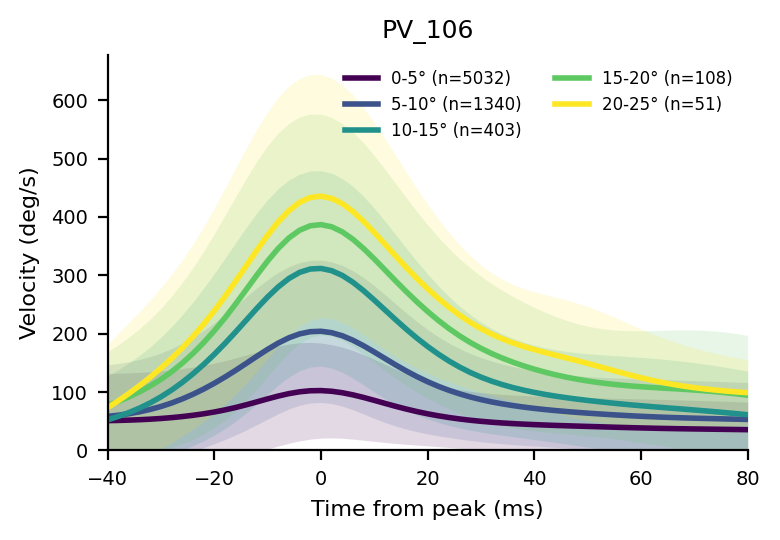

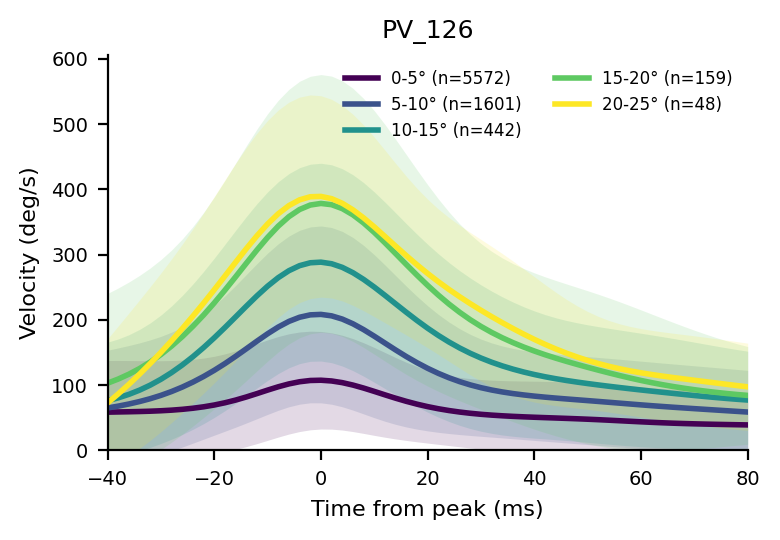

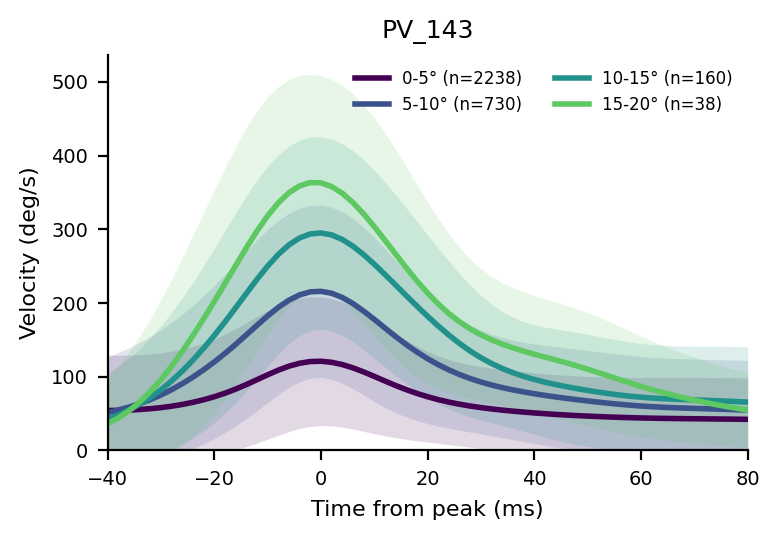

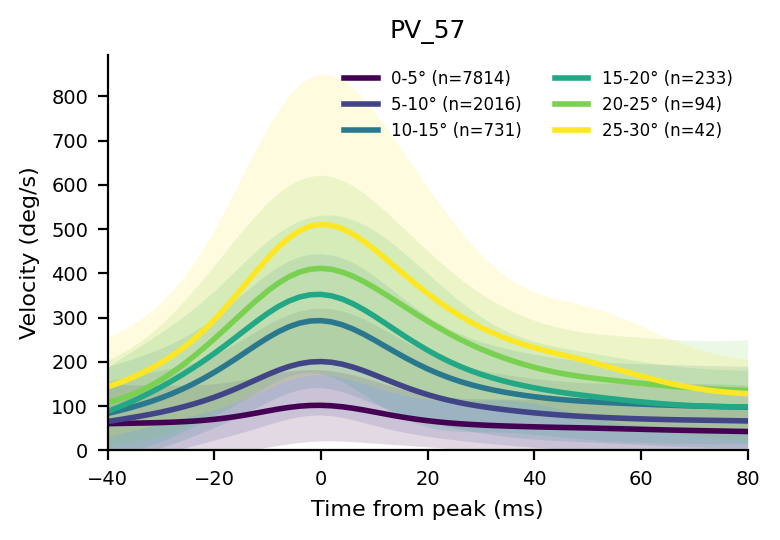

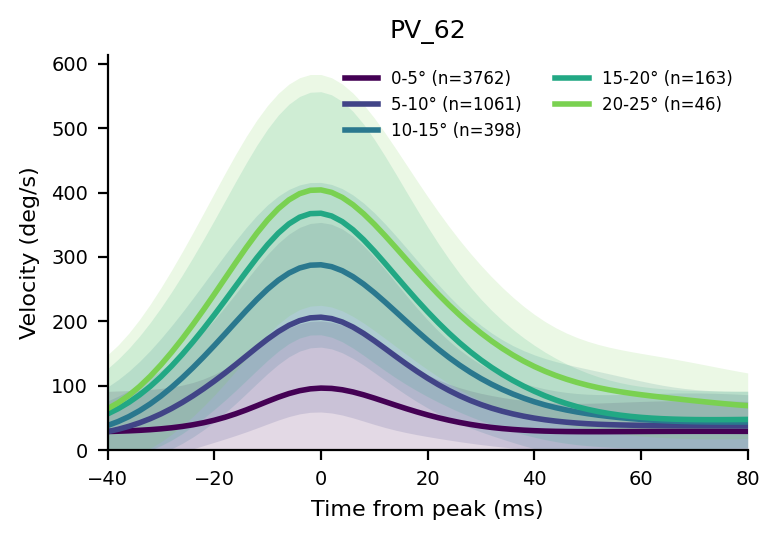

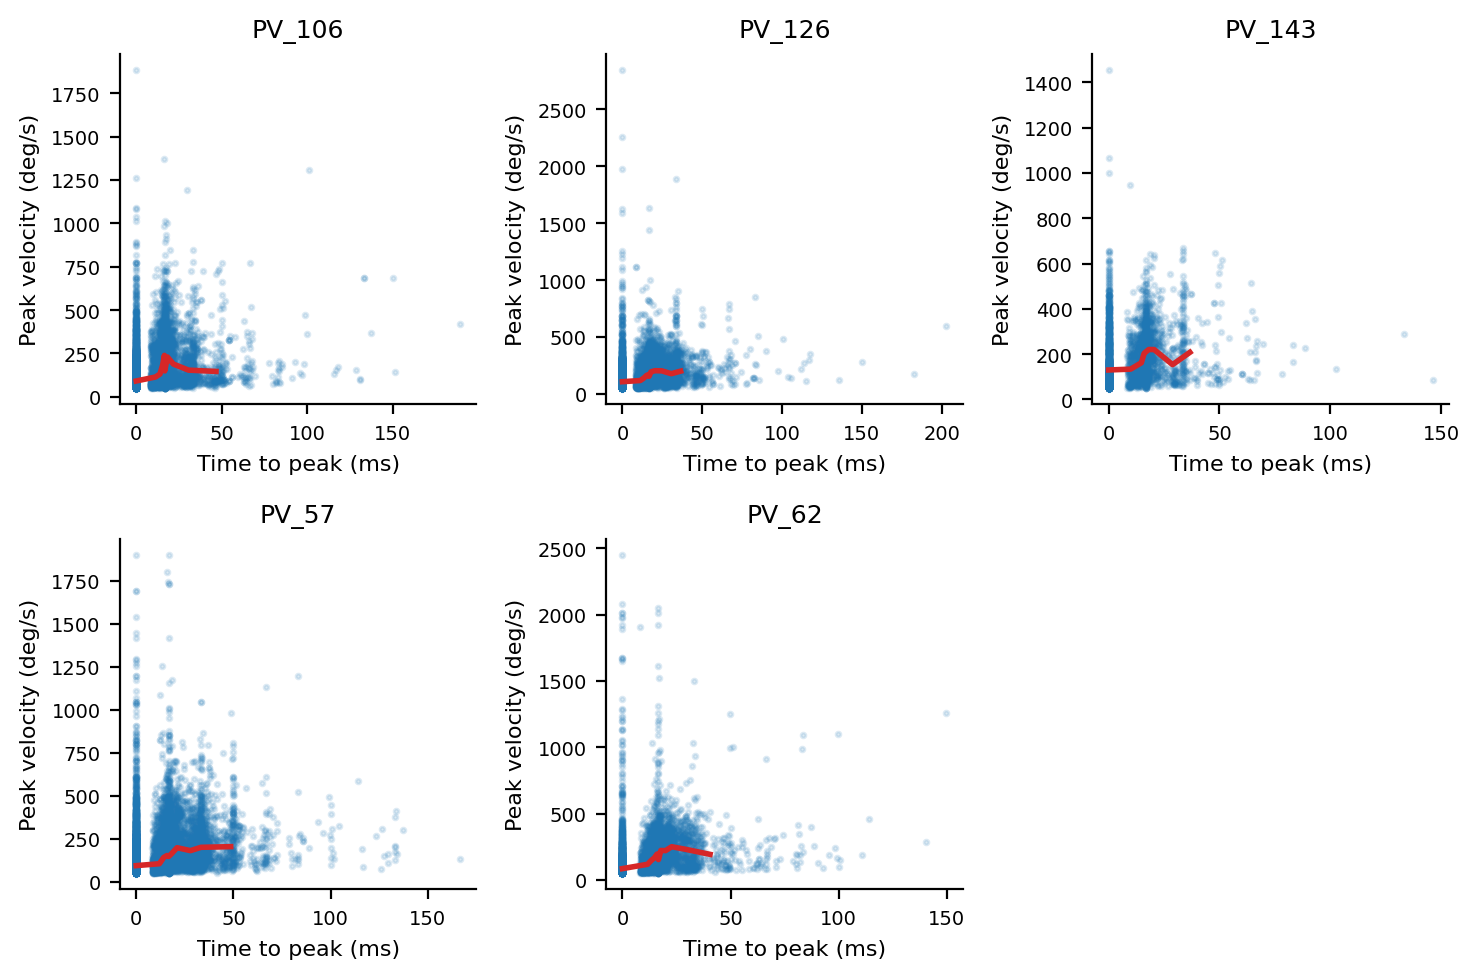

In [70]:
# 1) Per-animal amplitude-binned profiles (one fig per animal)
figs = plot_velocity_by_amp_bins_per_animal_kernel(
    all_saccade_collection,
    block_dict,
    bin_width_deg=5.0,
    min_amp_deg=0.5,
    t_window_ms=(-40, 80),
    dt_ms=2.0,
    bandwidth_ms=10.0,     # try 8–12 to kill the 60 Hz comb
    min_events_per_bin=30,
    subsample_peak=True    # conservative; switch True if you want sub-frame peak alignment
)

# 2) Per-animal peak-V vs TTP (simple)
fig_scatter, table = plot_peakV_vs_TTP_simple(
    all_saccade_collection,
    sampling_rate_hz=60.0,
    min_amp_deg=0.25,
    subsample_peak=True,   # sub-frame TTP if you trust it
    nbins_ttp=20
)


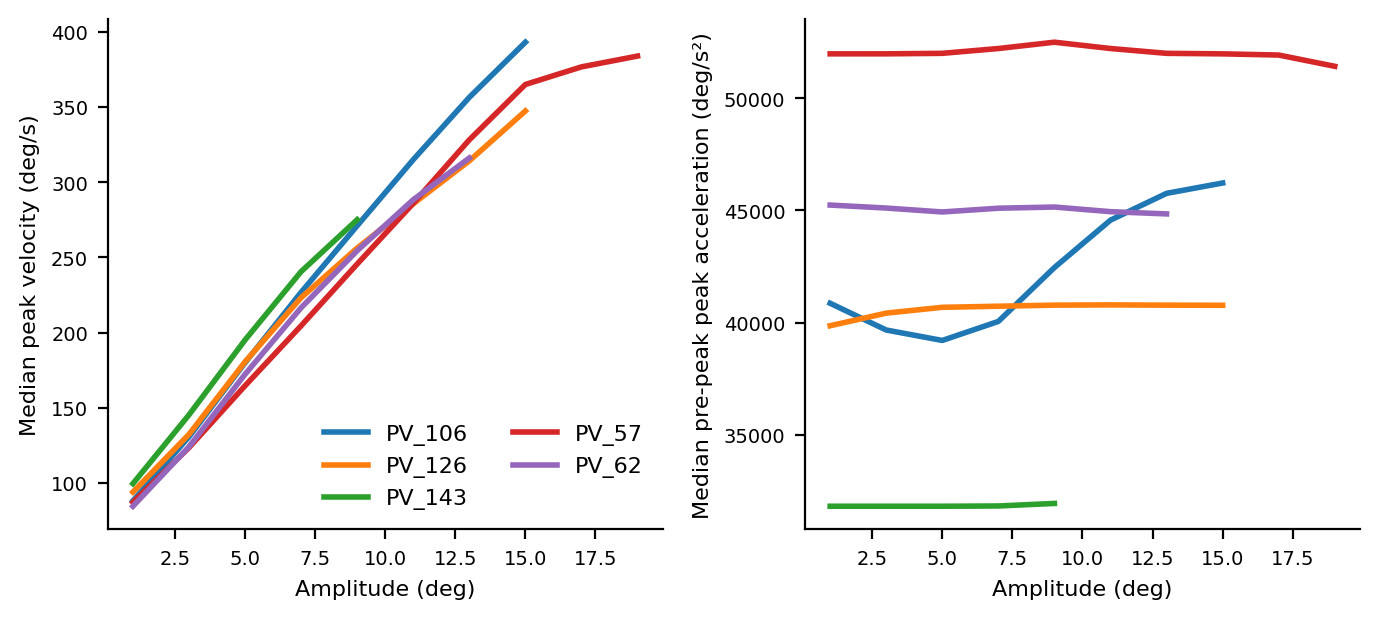

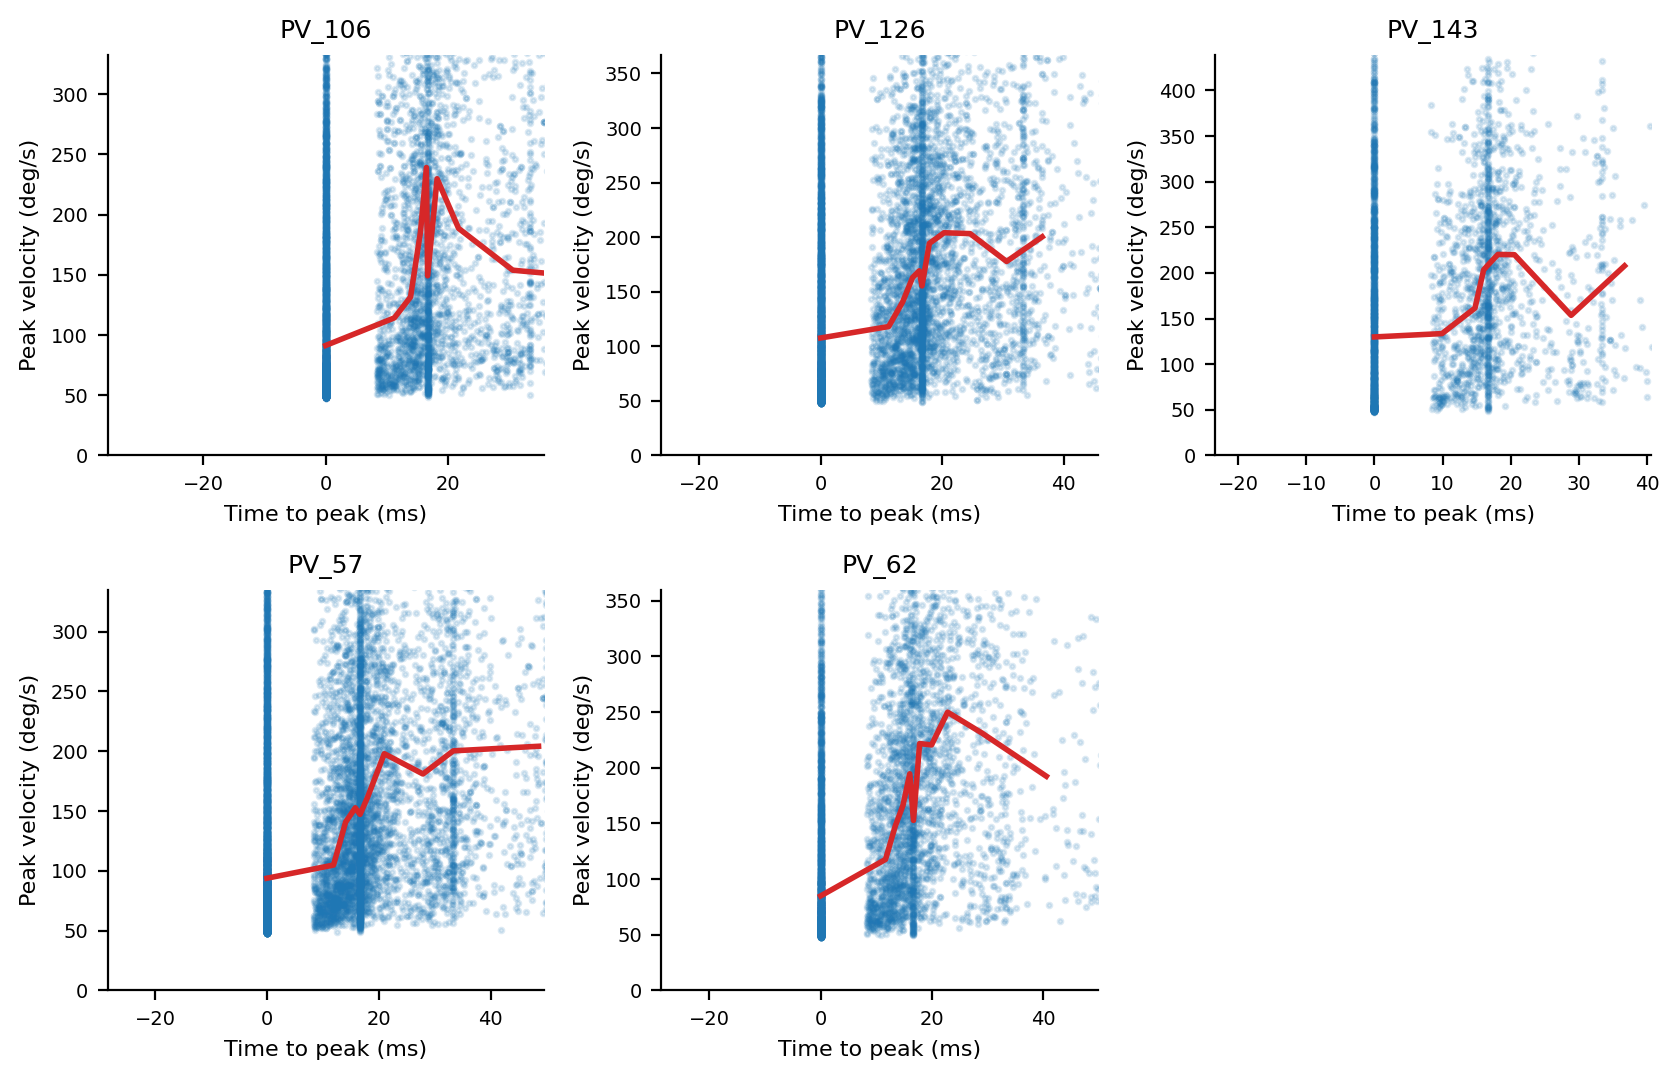

In [71]:
#v4
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# ------- helpers to pull raw & compute kinematics --------
def _blk_key(animal, block):
    return f"{animal}_block_{int(block):03d}", f"{animal}_block_{int(block)}"

def _eye_df(block_dict, animal, block, eye):
    k1, k2 = _blk_key(animal, block)
    blk = block_dict.get(k1, block_dict.get(k2, None))
    if blk is None:
        return None
    return blk.left_eye_data if str(eye).upper()=="L" else blk.right_eye_data

def _vel_trace_from_eye_df(eye_df):
    t = eye_df["ms_axis"].to_numpy(float)
    phi = eye_df["k_phi"].to_numpy(float)
    th  = eye_df["k_theta"].to_numpy(float)
    dphi = np.diff(phi); dth = np.diff(th); dt_s = np.diff(t)/1000.0
    v_dps = np.divide(np.hypot(dphi, dth), dt_s, out=np.full_like(dphi, np.nan), where=dt_s>0)
    t_ms  = t[1:]
    return t_ms, v_dps

def _peak_time_in_interval(t_ms, v_dps, on_ms, off_ms, subsample=False):
    m = (t_ms >= on_ms) & (t_ms <= off_ms) & np.isfinite(v_dps)
    if not np.any(m): return np.nan
    v, tt = v_dps[m], t_ms[m]
    i = int(np.nanargmax(v))
    if not subsample or i==0 or i==v.size-1:
        return float(tt[i])
    # 3-point parabola in *velocity space*
    v_1, v0, v1 = v[i-1], v[i], v[i+1]
    den = (v_1 - 2*v0 + v1)
    if not np.isfinite(den) or den==0: return float(tt[i])
    d = 0.5*(v_1 - v1)/den
    d = float(np.clip(d, -1.0, 1.0))
    dt_local = (tt[min(i+1, v.size-1)] - tt[max(i-1, 0)]) / 2.0
    return float(tt[i] + d*dt_local)

def _peak_accel_prepeak(t_ms, v_dps, pk_ms):
    """Finite-diff accel (deg/s²) and return max before the peak time."""
    if not np.isfinite(pk_ms) or t_ms.size < 3: return np.nan
    # derivative dv/dt using central diff on native (possibly irregular) grid
    dv = np.diff(v_dps); dt = np.diff(t_ms)/1000.0
    a  = np.divide(dv, dt, out=np.full_like(dv, np.nan), where=dt>0)  # deg/s²
    t_a = t_ms[1:]  # time stamps for accel samples
    m = (t_a <= pk_ms) & np.isfinite(a)
    if not np.any(m): return np.nan
    return float(np.nanmax(a[m]))

# ------- main function --------
def plot_all_animals_amp_vs_metric(
    all_saccade_collection: pd.DataFrame,
    block_dict: dict,
    amp_col: str = None,           # auto-select if None
    bin_width_deg: float = 2.0,
    min_amp_deg: float = 0.5,
    min_events_per_bin: int = 25,
    metric: str = "both",          # "vpeak", "accel", or "both"
    subsample_peak: bool = False,  # sub-frame peak alignment for kinematics
    smooth_sigma_bins: float = 0.0,# optional Gaussian smoothing over bins
    fig_size=(7.0, 3.2), dpi=200
):
    """
    Single figure (or 2 panels if metric='both') showing per-animal binned medians
    of: amplitude -> peak velocity (deg/s) and/or pre-peak peak acceleration (deg/s^2).
    """
    df = all_saccade_collection.reset_index(drop=True).copy()
    req = {"animal","block","eye","saccade_on_ms","saccade_off_ms"}
    if not req.issubset(df.columns): raise ValueError(f"DataFrame must have {req}")
    # pick amplitude column
    if amp_col is None:
        for c in ("net_angular_disp","magnitude_raw_angular"):
            if c in df.columns: amp_col = c; break
    if amp_col is None: raise ValueError("Need 'net_angular_disp' or 'magnitude_raw_angular'.")
    df[amp_col] = pd.to_numeric(df[amp_col], errors="coerce")

    animals = sorted(df["animal"].dropna().unique().tolist())
    # set up axes
    if metric == "both":
        fig, axes = plt.subplots(1, 2, figsize=fig_size, dpi=dpi)
        axV, axA = axes
    else:
        fig, ax = plt.subplots(1,1, figsize=fig_size, dpi=dpi)
        axV = axA = ax

    cmap = plt.get_cmap("tab10")
    color = {a: cmap(i % 10) for i, a in enumerate(animals)}

    lines_for_legend = []

    for a in animals:
        sub = df[(df["animal"]==a) & (df[amp_col] >= float(min_amp_deg))].copy()
        if sub.empty: continue
        max_amp = float(np.nanpercentile(sub[amp_col], 99.5))
        edges = np.arange(0.0, max_amp + bin_width_deg, bin_width_deg)
        centers = 0.5*(edges[:-1] + edges[1:])
        med_v, med_acc = np.full_like(centers, np.nan, float), np.full_like(centers, np.nan, float)
        n_in_bin = np.zeros_like(centers, int)

        for bi in range(len(edges)-1):
            lo, hi = edges[bi], edges[bi+1]
            g = sub[(sub[amp_col] >= lo) & (sub[amp_col] < hi)]
            if g.shape[0] < min_events_per_bin: continue

            vpeaks, accpeaks = [], []
            for _, r in g.iterrows():
                eye_df = _eye_df(block_dict, r["animal"], r["block"], r["eye"])
                if eye_df is None: continue
                t_ms, v_dps = _vel_trace_from_eye_df(eye_df)
                if t_ms.size < 3: continue
                pk = _peak_time_in_interval(t_ms, v_dps, float(r["saccade_on_ms"]), float(r["saccade_off_ms"]),
                                            subsample=subsample_peak)
                if not np.isfinite(pk): continue
                # peak velocity within the event
                m = (t_ms >= float(r["saccade_on_ms"])) & (t_ms <= float(r["saccade_off_ms"])) & np.isfinite(v_dps)
                if not np.any(m): continue
                vpeaks.append(float(np.nanmax(v_dps[m])))
                # pre-peak peak acceleration
                accpeaks.append(_peak_accel_prepeak(t_ms, v_dps, pk))

            if len(vpeaks) == 0: continue
            n_in_bin[bi] = len(vpeaks)
            med_v[bi] = np.nanmedian(vpeaks)
            med_acc[bi] = np.nanmedian(accpeaks) if np.any(np.isfinite(accpeaks)) else np.nan

        # optional smoothing across bins
        if smooth_sigma_bins and np.isfinite(med_v).sum() > 3:
            med_v = gaussian_filter1d(med_v, smooth_sigma_bins, mode="nearest")
            med_acc = gaussian_filter1d(med_acc, smooth_sigma_bins, mode="nearest")

        # plot lines (skip empty bins)
        mV = np.isfinite(med_v)
        mA = np.isfinite(med_acc)
        if metric in ("vpeak", "both") and mV.sum() > 0:
            ln, = axV.plot(centers[mV], med_v[mV], lw=2, color=color[a], label=a)
            lines_for_legend.append(ln)
        if metric in ("accel", "both") and mA.sum() > 0:
            axA.plot(centers[mA], med_acc[mA], lw=2, color=color[a], label=a)

    # cosmetics
    if metric in ("vpeak", "both"):
        axV.set_xlabel("Amplitude (deg)", fontsize=8)
        axV.set_ylabel("Median peak velocity (deg/s)", fontsize=8)
        axV.tick_params(labelsize=7); axV.spines["top"].set_visible(False); axV.spines["right"].set_visible(False)
        if lines_for_legend: axV.legend(handles=lines_for_legend, frameon=False, fontsize=8, ncol=2)
    if metric in ("accel", "both"):
        axA.set_xlabel("Amplitude (deg)", fontsize=8)
        axA.set_ylabel("Median pre-peak peak acceleration (deg/s²)", fontsize=8)
        axA.tick_params(labelsize=7); axA.spines["top"].set_visible(False); axA.spines["right"].set_visible(False)

    fig.tight_layout()
    return fig

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval

def _as_array(x):
    if isinstance(x, (list, tuple, np.ndarray, pd.Series)): return np.asarray(x, float)
    if isinstance(x, str):
        try: return np.asarray(literal_eval(x), float)
        except Exception: return np.array([], float)
    if pd.isna(x): return np.array([], float)
    try: return np.asarray(x, float)
    except Exception: return np.array([], float)

def _parab_peak(y):
    y = np.asarray(y, float)
    if y.size==0 or not np.isfinite(y).any(): return np.nan, np.nan
    i = int(np.nanargmax(y)); y0 = y[i]
    if i in (0, y.size-1): return y0, float(i)
    y_1, y1 = y[i-1], y[i+1]; dnm = (y[i-1]-2*y0+y[i+1])
    if not np.all(np.isfinite([y_1,y0,y1])) or dnm==0: return y0, float(i)
    d = 0.5*(y_1-y1)/dnm; d = float(np.clip(d,-1,1))
    return (y0 - 0.25*(y_1-y1)*d), float(i+d)

def _robust_limits(x, k=3.0, mode="sigma"):
    x = np.asarray(x, float); x = x[np.isfinite(x)]
    if x.size == 0: return (0, 1)
    if mode == "sigma":
        med = np.median(x); mad = np.median(np.abs(x - med))
        # Gaussian-equivalent sigma
        sigma = 1.4826 * mad if mad > 0 else np.std(x)
        lo, hi = med - k*sigma, med + k*sigma
    else:  # "quantile"
        q = 0.001 * float(k)  # interpret k as 0-100 percentile span if you like
        lo, hi = np.quantile(x, [q, 1-q])
    # ensure range
    if not np.isfinite(lo) or not np.isfinite(hi) or lo>=hi:
        lo, hi = np.nanmin(x), np.nanmax(x)
    return float(lo), float(hi)

def plot_peakV_vs_TTP_zoom(
    all_saccade_collection: pd.DataFrame,
    sampling_rate_hz: float = 60.0,
    min_amp_deg: float = 0.25,
    subsample_peak: bool = True,
    nbins_ttp: int = 20,
    clip_mode: str = "sigma",   # "sigma" or "quantile"
    clip_kx: float = 3.0,       # x-axis (TTP) zoom strength
    clip_ky: float = 3.0,       # y-axis (Vpeak) zoom strength
    fig_size=(8.5, 5.5), dpi=200
):
    df = all_saccade_collection.reset_index(drop=True).copy()
    if "animal" not in df.columns: df["animal"] = "ALL"
    amp_col = "net_angular_disp" if "net_angular_disp" in df.columns else (
        "magnitude_raw_angular" if "magnitude_raw_angular" in df.columns else None
    )
    if amp_col is None: raise ValueError("Need 'net_angular_disp' or 'magnitude_raw_angular'.")

    frame_ms = 1000.0 / float(sampling_rate_hz)
    rows = []
    for _, r in df.iterrows():
        A = pd.to_numeric(r.get(amp_col), errors="coerce")
        if not np.isfinite(A) or A < float(min_amp_deg): continue
        prof = _as_array(r.get("speed_profile_angular", []))  # deg/frame
        if prof.size < 2 or not np.isfinite(prof).any(): continue
        if subsample_peak:
            vpk_df, i_pk = _parab_peak(prof)
        else:
            i_pk = int(np.nanargmax(prof)); vpk_df = prof[i_pk]
        vpk_dps = vpk_df * sampling_rate_hz
        ttp_ms = float(r["time_to_peak_v"]) if ("time_to_peak_v" in df.columns and pd.notna(r.get("time_to_peak_v"))) else float(i_pk * frame_ms)
        rows.append((r["animal"], vpk_dps, ttp_ms))
    dd = pd.DataFrame(rows, columns=["animal","vpeak_dps","ttp_ms"])

    animals = sorted(dd["animal"].unique().tolist())
    ncol = min(3, len(animals)); nrow = int(np.ceil(len(animals)/ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=fig_size, dpi=dpi, squeeze=False)

    for k, a in enumerate(animals):
        ax = axes[k//ncol, k%ncol]
        g = dd[dd["animal"]==a]
        # axis limits from robust clip
        xlo, xhi = _robust_limits(g["ttp_ms"].values, k=clip_kx, mode=clip_mode)
        ylo, yhi = _robust_limits(g["vpeak_dps"].values, k=clip_ky, mode=clip_mode)
        # scatter (light) + binned medians (red)
        ax.scatter(g["ttp_ms"], g["vpeak_dps"], s=3, alpha=0.15)
        if len(g) > nbins_ttp:
            qs = np.linspace(0, 1, nbins_ttp+1)
            edges = np.unique(g["ttp_ms"].quantile(qs).to_numpy())
            centers, med = [], []
            for i in range(len(edges)-1):
                m = (g["ttp_ms"] >= edges[i]) & (g["ttp_ms"] < edges[i+1])
                if m.sum() < 10: continue
                centers.append(np.median(g["ttp_ms"][m]))
                med.append(np.median(g["vpeak_dps"][m]))
            if centers:
                ax.plot(centers, med, lw=2, color="tab:red")
        ax.set_xlim(xlo, xhi); ax.set_ylim(max(0, ylo), yhi)
        ax.set_title(a, fontsize=9)
        ax.set_xlabel("Time to peak (ms)", fontsize=8)
        ax.set_ylabel("Peak velocity (deg/s)", fontsize=8)
        ax.tick_params(labelsize=7)
        for sp in ("top","right"): ax.spines[sp].set_visible(False)

    # turn off unused
    for idx in range(len(animals), nrow*ncol):
        axes[idx//ncol, idx%ncol].axis("off")
    fig.tight_layout()
    return fig, dd
# A) Single figure, all animals; show both peak-V and acceleration vs amplitude
fig_main = plot_all_animals_amp_vs_metric(
    all_saccade_collection, block_dict,
    bin_width_deg=2.0, min_amp_deg=0.5,
    metric="both",          # or "vpeak", or "accel"
    subsample_peak=False,   # conservative; True gives sub-frame peaks
    smooth_sigma_bins=0.8   # tiny smoothing across amplitude bins (optional)
)

# B) Zoom the peak-V vs TTP plots
fig_zoom, table = plot_peakV_vs_TTP_zoom(
    all_saccade_collection,
    sampling_rate_hz=60.0,
    min_amp_deg=0.25,
    subsample_peak=True,
    clip_mode="sigma",      # or "quantile"
    clip_kx=2.5,            # tighten x to ~±2.5σ
    clip_ky=2.5             # tighten y similarly
)



animal      n    Vmax_dps     A0_deg        R2  small_amp_slope  \
0  PV_106   6954  499.478936   8.650973  0.451620         0.390121   
1  PV_126   7849  436.088649   7.345953  0.368900         0.291354   
2  PV_143   3187  374.910883   4.991804  0.359198         0.359191   
3   PV_57  10966  511.407978   9.523476  0.419201         0.344368   
4   PV_62   5468  674.588544  13.988583  0.360625         0.337309   

   dur_vs_amp_ms_per_deg  dur_intercept_ms  ttp_median_ms  ttp_iqr_ms  \
0               4.840237         22.209708       0.000000   16.666667   
1               4.809057         22.057293       9.677819   17.065983   
2               5.233630         20.625185       8.623859   16.666667   
3               4.747696         22.689681      10.521519   17.032562   
4               4.426591         25.140892      10.561822   16.898079   

   amp_median_deg  amp_max_deg  
0        2.530256    35.724962  
1        2.846154    53.590202  
2        3.109041    32.966518  
3        2.663722    47.975043  
4        2.711027    39.861830

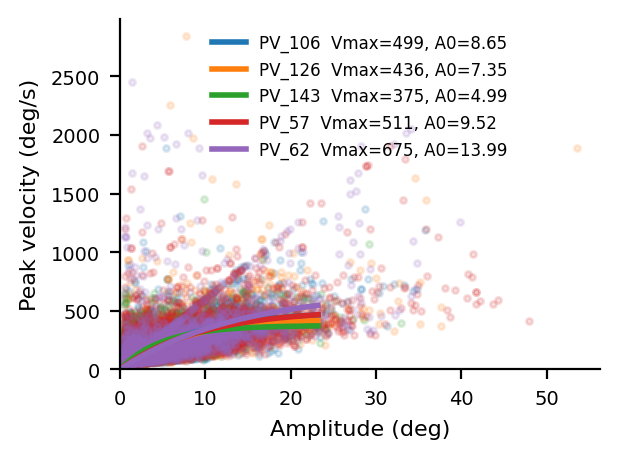

In [50]:
#experiment 3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
from scipy.optimize import curve_fit

# -------------------- helpers --------------------

def _to_array(v):
    if isinstance(v, (list, tuple, np.ndarray, pd.Series)):
        return np.asarray(v, dtype=float)
    if isinstance(v, str):
        try:
            return np.asarray(literal_eval(v), dtype=float)
        except Exception:
            return np.array([], dtype=float)
    if pd.isna(v):
        return np.array([], dtype=float)
    try:
        return np.asarray(v, dtype=float)
    except Exception:
        return np.array([], dtype=float)

def _parabolic_peak(y):
    """
    3-point quadratic interpolation around discrete maximum.
    Returns (peak_value, peak_index_subsample) in sample units.
    Falls back to discrete if at edges / invalid.
    """
    y = np.asarray(y, dtype=float)
    if y.size == 0 or not np.isfinite(y).any():
        return np.nan, np.nan
    i = int(np.nanargmax(y))
    v0 = y[i]
    if i == 0 or i == y.size - 1:
        return v0, float(i)
    y_1, y0, y1 = y[i-1], y[i], y[i+1]
    if not (np.isfinite(y_1) and np.isfinite(y0) and np.isfinite(y1)):
        return v0, float(i)
    denom = (y_1 - 2*y0 + y1)
    if denom == 0:
        return v0, float(i)
    d = 0.5 * (y_1 - y1) / denom  # sub-sample offset from i
    d = float(np.clip(d, -1.0, 1.0))
    v_ref = y0 - 0.25 * (y_1 - y1) * d
    return (v_ref if np.isfinite(v_ref) else v0), float(i + d)

def _expsat(A, Vmax, A0):
    A0 = max(A0, 1e-6)
    return Vmax * (1.0 - np.exp(-A / A0))

def _power_small_amp(A, k, n):
    A = np.maximum(A, 1e-9)
    return k * (A ** n)

def _finite(*arrs):
    m = np.ones_like(arrs[0], dtype=bool)
    for a in arrs:
        m &= np.isfinite(a)
    return m

# -------------------- core extraction --------------------

import numpy as np
import pandas as pd
from ast import literal_eval

def _to_array(v):
    if isinstance(v, (list, tuple, np.ndarray, pd.Series)):
        return np.asarray(v, dtype=float)
    if isinstance(v, str):
        try:
            return np.asarray(literal_eval(v), dtype=float)
        except Exception:
            return np.array([], dtype=float)
    if pd.isna(v):
        return np.array([], dtype=float)
    try:
        return np.asarray(v, dtype=float)
    except Exception:
        return np.array([], dtype=float)

def _parabolic_peak(y):
    y = np.asarray(y, dtype=float)
    if y.size == 0 or not np.isfinite(y).any():
        return np.nan, np.nan
    i = int(np.nanargmax(y))
    v0 = y[i]
    if i == 0 or i == y.size - 1:
        return v0, float(i)
    y_1, y0, y1 = y[i-1], y[i], y[i+1]
    if not (np.isfinite(y_1) and np.isfinite(y0) and np.isfinite(y1)):
        return v0, float(i)
    denom = (y_1 - 2*y0 + y1)
    if denom == 0:
        return v0, float(i)
    d = 0.5 * (y_1 - y1) / denom
    d = float(np.clip(d, -1.0, 1.0))
    v_ref = y0 - 0.25 * (y_1 - y1) * d
    return (v_ref if np.isfinite(v_ref) else v0), float(i + d)

def _finite(*arrs):
    m = np.ones_like(np.asarray(arrs[0]), dtype=bool)
    for a in arrs:
        m &= np.isfinite(a)
    return m

def extract_ms_rows(df,
                    sampling_rate_hz=60.0,
                    amp_cols=('net_angular_disp', 'magnitude_raw_angular'),
                    speed_profile_col='speed_profile_angular',
                    ttp_col='time_to_peak_v',
                    min_amp_deg=0.1,
                    max_amp_deg=None):
    """
    From all_saccade_collection -> per-row amplitude (deg), peak velocity (deg/s), time-to-peak (ms), duration (ms).
    Uses parabolic interpolation on speed_profile_angular (deg/frame) and positional indexing to avoid index-length bugs.
    """
    frame_ms = 1000.0 / float(sampling_rate_hz)

    # Work on a clean positional index to avoid .loc expansion with duplicate labels
    df2 = df.reset_index(drop=True).copy()

    # choose amplitude column
    amp_col = None
    for c in amp_cols:
        if c in df2.columns:
            amp_col = c
            break
    if amp_col is None:
        raise ValueError(f"None of the amplitude cols {amp_cols} were found in DataFrame.")

    # prefer numeric ttp column if present
    if ttp_col in df2.columns:
        df2[ttp_col] = pd.to_numeric(df2[ttp_col], errors='coerce')

    def row_metrics(row):
        prof = _to_array(row.get(speed_profile_col, []))  # deg/frame
        if prof.size == 0:
            return pd.Series(dict(amp=np.nan, vpeak_dps=np.nan, ttp_ms=np.nan, dur_ms=np.nan))
        vpk_df, i_pk = _parabolic_peak(prof)              # deg/frame, samples
        vpk_dps = vpk_df * sampling_rate_hz               # -> deg/s

        # TTP: use provided column when finite, else derive from peak index
        ttp_ms = row.get(ttp_col, np.nan) if ttp_col in row else np.nan
        if not np.isfinite(ttp_ms):
            ttp_ms = i_pk * frame_ms

        # duration: prefer on/off timestamps if available
        if 'saccade_on_ms' in row and 'saccade_off_ms' in row:
            try:
                dur_ms = float(row['saccade_off_ms']) - float(row['saccade_on_ms'])
            except Exception:
                dur_ms = prof.size * frame_ms
        else:
            dur_ms = prof.size * frame_ms

        return pd.Series(dict(
            amp=float(row[amp_col]),
            vpeak_dps=float(vpk_dps),
            ttp_ms=float(ttp_ms),
            dur_ms=float(dur_ms)
        ))

    out = df2.apply(row_metrics, axis=1)

    # filter invalid / tiny amplitudes
    keep = _finite(out['amp'].values, out['vpeak_dps'].values)
    if min_amp_deg is not None:
        keep &= (out['amp'].values >= float(min_amp_deg))
    if max_amp_deg is not None:
        keep &= (out['amp'].values <= float(max_amp_deg))
    out = out[keep].copy()

    # Copy group columns by POSITION (not label) to avoid duplication
    for c in ('animal', 'eye', 'block'):
        if c in df2.columns:
            out[c] = df2[c].iloc[out.index].values

    return out

# -------------------- per-animal fitting & report --------------------

def assess_main_sequence_per_animal(rows_df,
                                    animals=None,
                                    small_amp_quantile=0.5,
                                    min_points=20):
    """
    Fit V(A) per animal; also compute small-amp power-law slope, duration slope, and TTP stats.
    Returns summary DataFrame and a plotting function handle.
    """
    if animals is None:
        if 'animal' not in rows_df.columns:
            rows_df['animal'] = 'ALL'
        animals = sorted(rows_df['animal'].dropna().unique().tolist())

    summaries = []
    for a in animals:
        g = rows_df[rows_df['animal'] == a].copy()
        if len(g) < min_points:
            continue

        A = g['amp'].to_numpy(float)
        V = g['vpeak_dps'].to_numpy(float)

        # Fit saturating exponential
        try:
            Vmax0 = np.nanpercentile(V, 95)
            A0_0  = np.nanmedian(A[(A>0)]) if np.any(A>0) else np.nanmedian(A)
            p0 = [max(Vmax0, 50.0), max(A0_0, 0.1)]
            popt, pcov = curve_fit(_expsat, A, V, p0=p0, bounds=([0.0, 1e-6],[np.inf, np.inf]), maxfev=20000)
            Vhat = _expsat(A, *popt)
            sse  = np.sum((V - Vhat)**2)
            tss  = np.sum((V - V.mean())**2)
            r2   = 1.0 - sse / tss if tss > 0 else np.nan
            Vmax, A0 = popt
        except Exception:
            Vmax, A0, r2 = np.nan, np.nan, np.nan

        # Small-amplitude power law on lower quantiles (robust proxy for slope near origin)
        try:
            A_cut = np.quantile(A, small_amp_quantile)
            m = (A > 0) & (A <= A_cut)
            Al, Vl = A[m], V[m]
            # guard
            if len(Al) >= max(10, int(0.1*len(A))):
                b, a0 = np.polyfit(np.log(Al), np.log(np.maximum(Vl, 1e-9)), 1)  # logV = a0 + b*logA
                n_power = float(b)  # slope
            else:
                n_power = np.nan
        except Exception:
            n_power = np.nan

        # Duration vs amplitude (simple linear trend)
        try:
            D = g['dur_ms'].to_numpy(float)
            if np.isfinite(D).sum() > 5:
                coef = np.polyfit(A, D, 1)   # D ≈ d0*A + d1
                d_slope, d_intercept = float(coef[0]), float(coef[1])
            else:
                d_slope, d_intercept = np.nan, np.nan
        except Exception:
            d_slope, d_intercept = np.nan, np.nan

        # TTP summary
        ttp_med = np.nanmedian(g['ttp_ms']) if 'ttp_ms' in g.columns else np.nan
        ttp_r   = (np.nanpercentile(g['ttp_ms'], 75) - np.nanpercentile(g['ttp_ms'], 25)) if 'ttp_ms' in g.columns else np.nan

        summaries.append(dict(
            animal=a, n=len(g),
            Vmax_dps=Vmax, A0_deg=A0, R2=r2,
            small_amp_slope=n_power,
            dur_vs_amp_ms_per_deg=d_slope,
            dur_intercept_ms=d_intercept,
            ttp_median_ms=ttp_med, ttp_iqr_ms=ttp_r,
            amp_median_deg=np.nanmedian(A), amp_max_deg=np.nanmax(A)
        ))

    return pd.DataFrame(summaries).sort_values('animal')

# -------------------- plotting --------------------

def plot_main_sequence_small(rows_df, summary_df, fig_size=(3.2, 2.4), dpi=200):
    """
    Small, clean main-sequence panel: scatter (faint) + fitted curve per animal.
    """
    if 'animal' not in rows_df.columns:
        rows_df = rows_df.copy()
        rows_df['animal'] = 'ALL'

    animals = summary_df['animal'].tolist()
    cmap = plt.get_cmap('tab10')
    color = {a: cmap(i % 10) for i, a in enumerate(animals)}

    fig, ax = plt.subplots(1, 1, figsize=fig_size, dpi=dpi)

    # faint pooled scatter
    for a in animals:
        g = rows_df[rows_df['animal'] == a]
        ax.scatter(g['amp'], g['vpeak_dps'], s=5, alpha=0.15, color=color[a])

    # curves
    x_grid = np.linspace(0, max(1e-3, rows_df['amp'].quantile(0.99))*1.1, 400)
    for _, r in summary_df.iterrows():
        a = r['animal']
        Vmax, A0 = r['Vmax_dps'], r['A0_deg']
        if np.all(np.isfinite([Vmax, A0])):
            y = _expsat(x_grid, Vmax, A0)
            ax.plot(x_grid, y, lw=2, color=color[a], label=f"{a}  Vmax={Vmax:.0f}, A0={A0:.2f}")

    ax.set_xlabel("Amplitude (deg)", fontsize=8)
    ax.set_ylabel("Peak velocity (deg/s)", fontsize=8)
    ax.tick_params(labelsize=7)
    for sp in ('top','right'):
        ax.spines[sp].set_visible(False)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    ax.legend(frameon=False, fontsize=6, loc='best')
    fig.tight_layout()
    return fig

# -------------------- one-call convenience --------------------

def assess_main_sequence(all_saccade_collection,
                         sampling_rate_hz=60.0,
                         min_amp_deg=0.1,
                         max_amp_deg=None,
                         small_amp_quantile=0.5,
                         min_points=20,
                         make_plot=True):
    rows = extract_ms_rows(all_saccade_collection,
                           sampling_rate_hz=sampling_rate_hz,
                           min_amp_deg=min_amp_deg,
                           max_amp_deg=max_amp_deg)
    summary = assess_main_sequence_per_animal(rows,
                                              small_amp_quantile=small_amp_quantile,
                                              min_points=min_points)
    fig = plot_main_sequence_small(rows, summary) if make_plot and not summary.empty else None
    return rows, summary, fig

# -------------------- Example usage --------------------
rows, summary, fig = assess_main_sequence(all_saccade_collection,
                                          sampling_rate_hz=60.0,
                                          min_amp_deg=0.25,   # skip tiniest events if noisy
                                          small_amp_quantile=0.5)  # use lower half for small-amp slope
display(summary)


animal  t_ms  v_mean_dps  v_sem_dps  n_at_time
0  PV_106 -40.0  103.490912   4.728561        236
1  PV_106 -39.0  103.447897   4.671893        243
2  PV_106 -38.0  102.795641   4.504889        259
3  PV_106 -37.0  102.921540   4.469940        267
4  PV_106 -36.0  102.313368   4.332098        281

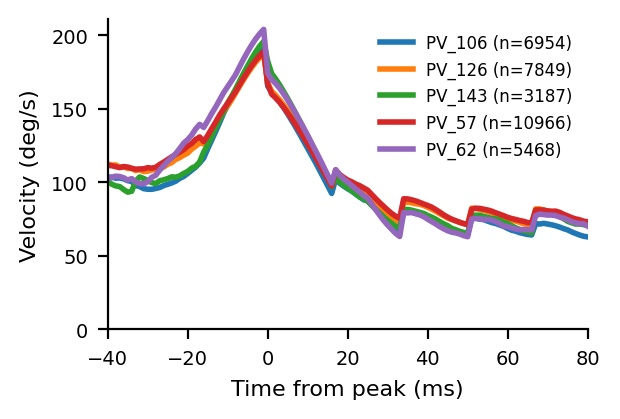

In [59]:
#experiment 4
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval

# optional smoothing (safe if SciPy available)
try:
    from scipy.signal import savgol_filter
    _HAS_SAVGOL = True
except Exception:
    _HAS_SAVGOL = False

def _to_array(v):
    if isinstance(v, (list, tuple, np.ndarray, pd.Series)):
        return np.asarray(v, dtype=float)
    if isinstance(v, str):
        try:
            return np.asarray(literal_eval(v), dtype=float)
        except Exception:
            return np.array([], dtype=float)
    if pd.isna(v):
        return np.array([], dtype=float)
    try:
        return np.asarray(v, dtype=float)
    except Exception:
        return np.array([], dtype=float)

def _parabolic_peak(y):
    """3-point peak refinement: returns (peak_index_subsample)."""
    y = np.asarray(y, dtype=float)
    if y.size == 0 or not np.isfinite(y).any():
        return np.nan
    i = int(np.nanargmax(y))
    if i == 0 or i == y.size-1:
        return float(i)
    y_1, y0, y1 = y[i-1], y[i], y[i+1]
    if not (np.isfinite(y_1) and np.isfinite(y0) and np.isfinite(y1)):
        return float(i)
    denom = (y_1 - 2*y0 + y1)
    if denom == 0:
        return float(i)
    d = 0.5 * (y_1 - y1) / denom
    d = float(np.clip(d, -1.0, 1.0))
    return float(i + d)

def plot_avg_velocity_profiles(
    all_saccade_collection: pd.DataFrame,
    sampling_rate_hz: float = 60.0,
    align: str = "onset",              # "onset" or "peak"
    t_min_ms: float = 0.0,             # for "onset" alignment
    t_max_ms: float = 120.0,
    dt_ms: float = 1.0,
    per_animal_min_n: int = 30,        # require at least N saccades per animal
    min_amp_deg: float = 0.25,         # filter tiny/noisy events
    smooth: bool = True,               # Savitzky-Golay smoothing if available
    smooth_window: int = 5,            # must be odd, in samples
    smooth_poly: int = 2,
    fig_size=(3.2, 2.2),
    dpi=200
):
    """
    Build an average saccade velocity profile (deg/s) for each animal by interpolating
    per-saccade velocity traces onto a common 1-ms grid and averaging.
    """
    df = all_saccade_collection.reset_index(drop=True).copy()
    frame_ms = 1000.0 / float(sampling_rate_hz)

    # pick amplitude column to filter by
    amp_col = 'net_angular_disp' if 'net_angular_disp' in df.columns else (
        'magnitude_raw_angular' if 'magnitude_raw_angular' in df.columns else None
    )
    if amp_col is None:
        raise ValueError("No amplitude column found (expected 'net_angular_disp' or 'magnitude_raw_angular').")

    # ensure numeric ttp if present
    if 'time_to_peak_v' in df.columns:
        df['time_to_peak_v'] = pd.to_numeric(df['time_to_peak_v'], errors='coerce')

    # choose animals
    if 'animal' not in df.columns:
        df['animal'] = 'ALL'
    animals = df['animal'].dropna().unique().tolist()

    # common time grid (ms)
    if align == "onset":
        t_grid = np.arange(t_min_ms, t_max_ms + dt_ms, dt_ms)
    elif align == "peak":
        # allow negative times before peak and positive after
        t_grid = np.arange(-40.0, 80.0 + dt_ms, dt_ms)
    else:
        raise ValueError("align must be 'onset' or 'peak'.")

    agg_out = []  # to return the averages

    fig, ax = plt.subplots(1, 1, figsize=fig_size, dpi=dpi)
    cmap = plt.get_cmap('tab10')
    color_map = {a: cmap(i % 10) for i, a in enumerate(sorted(animals))}

    for a in sorted(animals):
        g = df[(df['animal'] == a) & (pd.to_numeric(df[amp_col], errors='coerce') >= float(min_amp_deg))].copy()
        if len(g) < per_animal_min_n:
            continue

        # collect per-saccade interpolants onto t_grid
        V_mat = []  # each is len(t_grid)
        for _, row in g.iterrows():
            prof = _to_array(row.get('speed_profile_angular', []))  # deg/frame
            if prof.size < 2 or not np.isfinite(prof).any():
                continue

            # optional per-trace smoothing in sample space
            if smooth and _HAS_SAVGOL and prof.size >= smooth_window and smooth_window % 2 == 1:
                try:
                    prof = savgol_filter(prof, window_length=smooth_window, polyorder=smooth_poly, mode='interp')
                except Exception:
                    pass

            # convert to deg/s
            v_dps = prof * sampling_rate_hz

            # build per-saccade time vector (ms) starting at 0 at onset
            t_trace = np.arange(prof.size, dtype=float) * frame_ms  # 0, 16.7, ...

            # alignment shift
            if align == "onset":
                # already onset-aligned (0 ms at onset)
                t_rel = t_trace
            else:  # align == "peak"
                # use provided time_to_peak_v if good; else parabolic
                ttp_ms = row['time_to_peak_v'] if ('time_to_peak_v' in row and np.isfinite(row['time_to_peak_v'])) else np.nan
                if not np.isfinite(ttp_ms):
                    i_pk = _parabolic_peak(v_dps) / sampling_rate_hz  # seconds
                    ttp_ms = float(i_pk * 1000.0)
                t_rel = t_trace - ttp_ms  # peak at ~0

            # interpolate onto common grid; outside domain -> NaN
            # (np.interp fills edges with end values; we want NaN, so clip range and mask)
            valid = np.isfinite(v_dps)
            if valid.sum() < 2:
                continue
            tmin, tmax = t_rel[valid].min(), t_rel[valid].max()
            y_interp = np.full_like(t_grid, np.nan, dtype=float)
            inside = (t_grid >= tmin) & (t_grid <= tmax)
            if inside.any():
                y_interp[inside] = np.interp(t_grid[inside], t_rel[valid], v_dps[valid])
            V_mat.append(y_interp)

        if len(V_mat) == 0:
            continue

        V_mat = np.vstack(V_mat)  # shape: (n_saccades, len(t_grid))
        v_mean = np.nanmean(V_mat, axis=0)
        v_sem  = np.nanstd(V_mat, axis=0) / np.sqrt(np.sum(np.isfinite(V_mat), axis=0))

        # keep to return
        animal_df = pd.DataFrame({
            'animal': a,
            't_ms': t_grid,
            'v_mean_dps': v_mean,
            'v_sem_dps': v_sem,
            'n_at_time': np.sum(np.isfinite(V_mat), axis=0)
        })
        agg_out.append(animal_df)

        # plot mean (compact)
        ax.plot(t_grid, v_mean, lw=2, color=color_map[a], label=f"{a} (n={len(V_mat)})")

    ax.set_xlabel("Time (ms)" if align == "onset" else "Time from peak (ms)", fontsize=8)
    ax.set_ylabel("Velocity (deg/s)", fontsize=8)
    ax.tick_params(labelsize=7)
    for sp in ("top", "right"):
        ax.spines[sp].set_visible(False)
    ax.set_xlim(t_grid.min(), t_grid.max())
    ax.set_ylim(bottom=0)
    ax.legend(frameon=False, fontsize=6, loc="best")
    plt.tight_layout()

    avg_df = pd.concat(agg_out, ignore_index=True) if agg_out else pd.DataFrame(
        columns=['animal','t_ms','v_mean_dps','v_sem_dps','n_at_time']
    )
    return avg_df, fig

# ---------------- Example usage ----------------
avg_df, fig = plot_avg_velocity_profiles(
    all_saccade_collection,
    sampling_rate_hz=60.0,
    align="peak",        # try "peak" to center curves at the velocity maximum
    t_min_ms=0, t_max_ms=120, dt_ms=1.0,
    per_animal_min_n=30,
    min_amp_deg=0.25,
    smooth=False
)
display(avg_df.head())


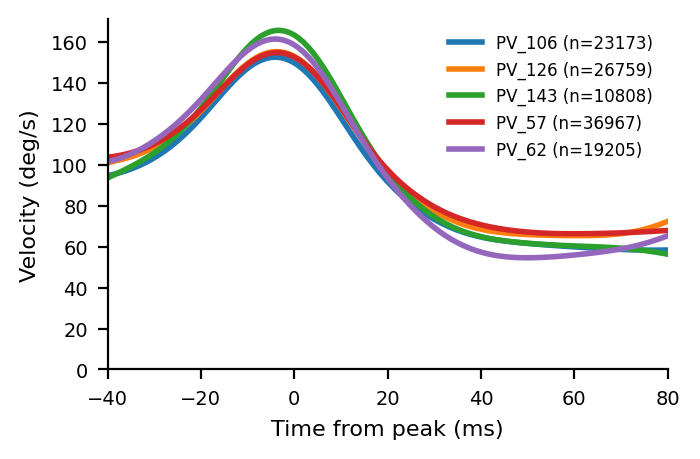

In [61]:
# another attempt at the interpolation using gaussian filters:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
from scipy.ndimage import gaussian_filter1d

def _to_array(v):
    if isinstance(v, (list, tuple, np.ndarray, pd.Series)):
        return np.asarray(v, dtype=float)
    if isinstance(v, str):
        try:
            return np.asarray(literal_eval(v), dtype=float)
        except Exception:
            return np.array([], dtype=float)
    if pd.isna(v):
        return np.array([], dtype=float)
    try:
        return np.asarray(v, dtype=float)
    except Exception:
        return np.array([], dtype=float)

def _parabolic_peak_index(y):
    y = np.asarray(y, dtype=float)
    if y.size == 0 or not np.isfinite(y).any():
        return np.nan
    i = int(np.nanargmax(y))
    if i == 0 or i == y.size - 1:
        return float(i)
    y_1, y0, y1 = y[i-1], y[i], y[i+1]
    if not (np.isfinite(y_1) and np.isfinite(y0) and np.isfinite(y1)):
        return float(i)
    denom = (y_1 - 2*y0 + y1)
    if denom == 0:
        return float(i)
    d = 0.5 * (y_1 - y1) / denom
    return float(i + np.clip(d, -1.0, 1.0))

def plot_avg_velocity_profiles_kernel(
    all_saccade_collection: pd.DataFrame,
    sampling_rate_hz: float = 60.0,
    align: str = "peak",               # "peak" or "onset"
    t_min_ms: float = -40.0,
    t_max_ms: float = 80.0,
    dt_ms: float = 1.0,
    bandwidth_ms: float = 10.0,        # Gaussian kernel bandwidth (kills 60 Hz ripple)
    per_animal_min_n: int = 30,
    min_amp_deg: float = 0.25,
    fig_size=(3.6, 2.4),
    dpi=200
):
    """Kernel-regressed average velocity profile per animal (deg/s) with minimal aliasing."""
    df = all_saccade_collection.reset_index(drop=True).copy()
    frame_ms = 1000.0 / float(sampling_rate_hz)

    # choose amplitude column to filter events
    amp_col = 'net_angular_disp' if 'net_angular_disp' in df.columns else (
        'magnitude_raw_angular' if 'magnitude_raw_angular' in df.columns else None
    )
    if amp_col is None:
        raise ValueError("No amplitude column ('net_angular_disp' or 'magnitude_raw_angular') in DataFrame.")
    if 'animal' not in df.columns:
        df['animal'] = 'ALL'

    # numeric TTP if available
    if 'time_to_peak_v' in df.columns:
        df['time_to_peak_v'] = pd.to_numeric(df['time_to_peak_v'], errors='coerce')

    animals = sorted(df['animal'].dropna().unique().tolist())
    t_grid = np.arange(t_min_ms, t_max_ms + dt_ms, dt_ms)
    nb = len(t_grid)

    fig, ax = plt.subplots(1, 1, figsize=fig_size, dpi=dpi)
    cmap = plt.get_cmap('tab10')
    color_map = {a: cmap(i % 10) for i, a in enumerate(animals)}

    all_means = []

    for a in animals:
        g = df[(df['animal'] == a) & (pd.to_numeric(df[amp_col], errors='coerce') >= float(min_amp_deg))].copy()
        if len(g) < per_animal_min_n:
            continue

        # Bin-wise numerator/denominator for kernel regression
        num = np.zeros(nb, dtype=float)
        den = np.zeros(nb, dtype=float)

        for _, row in g.iterrows():
            prof = _to_array(row.get('speed_profile_angular', []))  # deg/frame
            if prof.size < 2 or not np.isfinite(prof).any():
                continue

            # convert to deg/s
            v_dps = prof * sampling_rate_hz
            t_trace = np.arange(prof.size, dtype=float) * frame_ms  # ms from onset

            if align == "peak":
                # prefer provided ttp (ms); else estimate from parabola on deg/s
                ttp_ms = row['time_to_peak_v'] if ('time_to_peak_v' in row and np.isfinite(row['time_to_peak_v'])) else np.nan
                if not np.isfinite(ttp_ms):
                    i_pk = _parabolic_peak_index(v_dps)  # samples
                    ttp_ms = float(i_pk * frame_ms)
                t_rel = t_trace - ttp_ms
            else:  # onset
                t_rel = t_trace

            # bin the raw samples (no interpolation)
            idx = np.floor((t_rel - t_min_ms) / dt_ms).astype(int)
            mask = (idx >= 0) & (idx < nb) & np.isfinite(v_dps)
            if mask.any():
                # accumulate sums and counts in bins
                np.add.at(num, idx[mask], v_dps[mask])
                np.add.at(den, idx[mask], 1.0)

        # apply Gaussian kernel smoothing to numerator & denominator, then divide
        if den.sum() == 0:
            continue
        sigma_bins = max(1.0, bandwidth_ms / dt_ms)
        num_s = gaussian_filter1d(num, sigma=sigma_bins, mode='nearest')
        den_s = gaussian_filter1d(den, sigma=sigma_bins, mode='nearest')
        mean_v = np.divide(num_s, den_s, out=np.full_like(num_s, np.nan), where=den_s > 1e-6)

        all_means.append(pd.DataFrame({"animal": a, "t_ms": t_grid, "v_mean_dps": mean_v, "n_at_time": den}))

        ax.plot(t_grid, mean_v, lw=2, color=color_map[a], label=f"{a} (n={int(den.sum())})")

    ax.set_xlabel("Time from peak (ms)" if align == "peak" else "Time from onset (ms)", fontsize=8)
    ax.set_ylabel("Velocity (deg/s)", fontsize=8)
    ax.tick_params(labelsize=7)
    for sp in ("top", "right"):
        ax.spines[sp].set_visible(False)
    ax.set_xlim(t_min_ms, t_max_ms)
    ax.set_ylim(bottom=0)
    ax.legend(frameon=False, fontsize=6, loc="best")
    plt.tight_layout()

    avg_df = pd.concat(all_means, ignore_index=True) if all_means else pd.DataFrame(
        columns=["animal", "t_ms", "v_mean_dps", "n_at_time"]
    )
    return avg_df, fig

# Example:
avg_df2, fig2 = plot_avg_velocity_profiles_kernel(
    all_saccade_collection,
    sampling_rate_hz=60.0,
    align="peak",
    t_min_ms=-40, t_max_ms=80, dt_ms=1.0,
    bandwidth_ms=10.0,   # try 8–12ms
    per_animal_min_n=30,
    min_amp_deg=0.25
)


<ipython-input-65-34f40e7ad73d>:158: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("viridis")
<ipython-input-65-34f40e7ad73d>:158: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("viridis")
<ipython-input-65-34f40e7ad73d>:158: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("viridis")
<ipython-input-65-34f40e7ad73d>:158: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor

[<Figure size 800x560 with 1 Axes>,
 <Figure size 800x560 with 1 Axes>,
 <Figure size 800x560 with 1 Axes>,
 <Figure size 800x560 with 1 Axes>,
 <Figure size 800x560 with 1 Axes>]

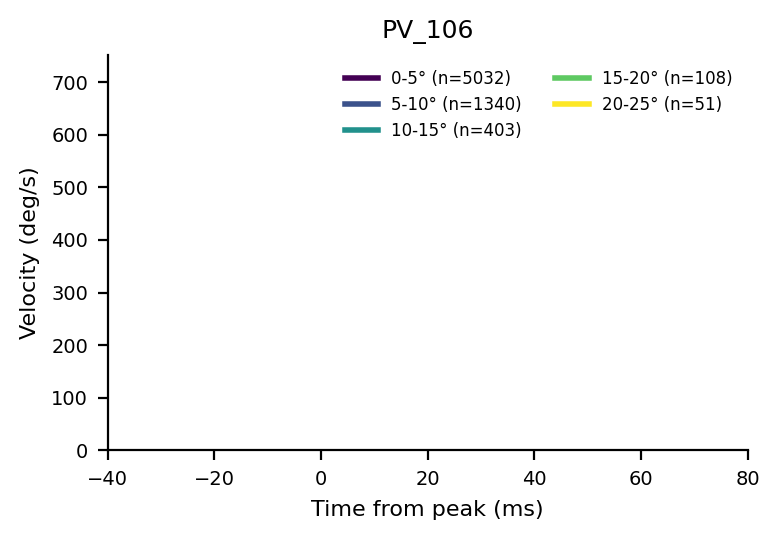

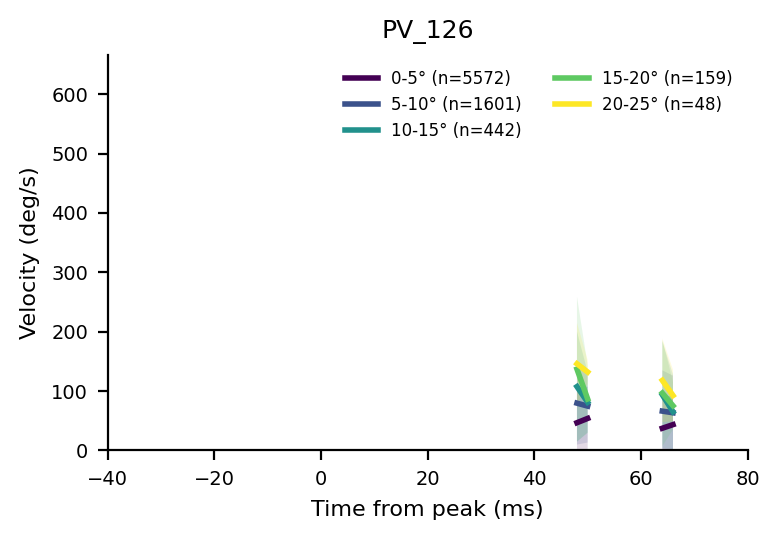

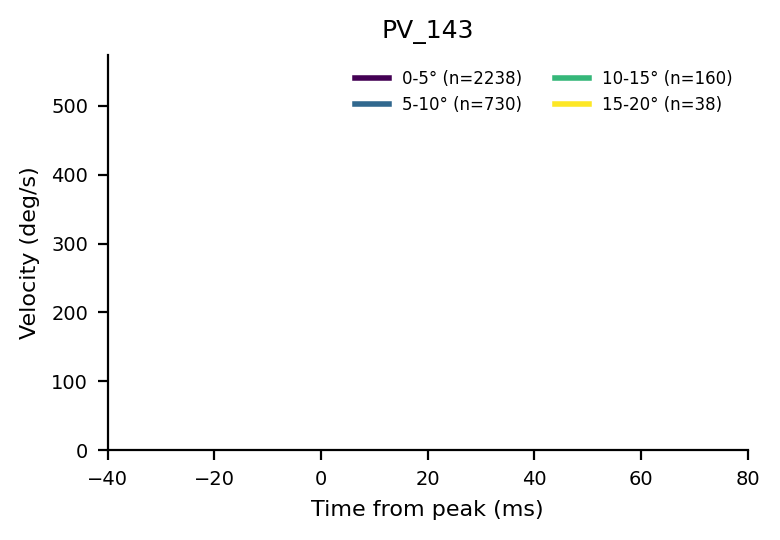

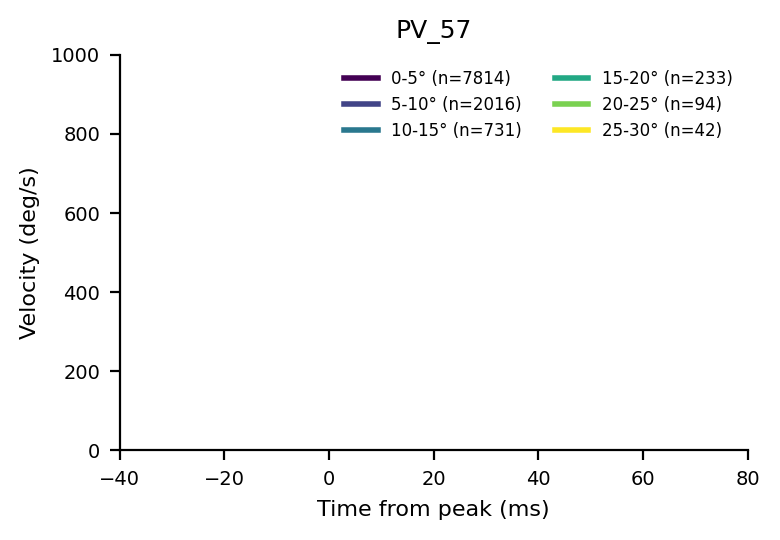

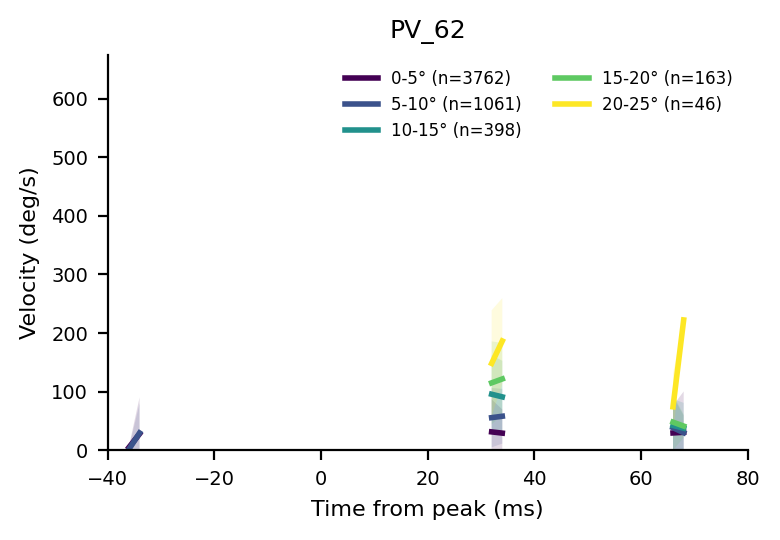

In [65]:
# wild new take (mark's idea)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

def _block_key(animal, block_num):
    # try zero-padded first, then raw
    k1 = f"{animal}_block_{int(block_num):03d}"
    k2 = f"{animal}_block_{int(block_num)}"
    return k1, k2

def _eye_df(block_dict, animal, block_num, eye):
    k1, k2 = _block_key(animal, block_num)
    blk = block_dict.get(k1, block_dict.get(k2, None))
    if blk is None:
        raise KeyError(f"Block not found for {animal} block {block_num} (tried {k1} / {k2})")
    df = blk.left_eye_data if eye.upper() == "L" else blk.right_eye_data
    if not {"ms_axis","k_phi","k_theta"}.issubset(df.columns):
        raise ValueError("Eye dataframe missing ms_axis/k_phi/k_theta")
    return df

def _raw_velocity_trace(df_eye):
    """
    From eye dataframe -> (t_ms_mid, v_dps) where t_ms_mid are the sample times
    associated with the finite-difference velocity samples.
    """
    t = df_eye["ms_axis"].to_numpy(dtype=float)
    phi = df_eye["k_phi"].to_numpy(dtype=float)
    th  = df_eye["k_theta"].to_numpy(dtype=float)

    dphi = np.diff(phi)
    dth  = np.diff(th)
    dt_s = np.diff(t) / 1000.0
    v_dps = np.divide(np.hypot(dphi, dth), dt_s, out=np.full_like(dphi, np.nan), where=dt_s>0)
    # associate velocity with the *second* sample time (causal diff); mid-point would be (t[1:]+t[:-1])/2
    t_ms = t[1:]
    return t_ms, v_dps

def _peak_time_in_window(t_ms, v_dps, on_ms, off_ms):
    """Discrete peak time (ms) within [on_ms, off_ms]."""
    m = (t_ms >= on_ms) & (t_ms <= off_ms) & np.isfinite(v_dps)
    if not np.any(m):
        return np.nan
    i_rel = np.argmax(v_dps[m])
    return t_ms[m][i_rel]

def plot_velocity_by_amp_bins_per_animal(
    all_saccade_collection: pd.DataFrame,
    block_dict: dict,
    amp_col: str = None,              # 'net_angular_disp' or 'magnitude_raw_angular'; auto-choose if None
    bin_width_deg: float = 5.0,
    min_amp_deg: float = 0.5,
    t_window_ms: tuple = (-40.0, 80.0),
    dt_ms: float = 2.0,               # bin size for native-sample aggregation (no interpolation)
    min_events_per_bin: int = 30,
    per_animal_max_bins: int = 8,     # safety to avoid clutter
    eye_filter: str = None            # "L", "R", or None (both)
):
    """
    For each animal: plot mean±SD velocity (deg/s) vs time-from-peak (ms), stratified by amplitude bins.
    Velocities are recomputed from raw k_phi/k_theta in block_dict. One figure per animal.
    """
    df = all_saccade_collection.copy().reset_index(drop=True)
    if "animal" not in df.columns or "block" not in df.columns or "eye" not in df.columns:
        raise ValueError("all_saccade_collection must have 'animal','block','eye' columns.")
    if "saccade_on_ms" not in df.columns or "saccade_off_ms" not in df.columns:
        raise ValueError("all_saccade_collection must have 'saccade_on_ms','saccade_off_ms'.")
    # choose amplitude column
    if amp_col is None:
        for c in ("net_angular_disp","magnitude_raw_angular"):
            if c in df.columns:
                amp_col = c; break
    if amp_col is None:
        raise ValueError("Could not find amplitude column (looked for 'net_angular_disp' / 'magnitude_raw_angular').")
    df[amp_col] = pd.to_numeric(df[amp_col], errors="coerce")

    if eye_filter:
        df = df[df["eye"].str.upper() == eye_filter.upper()]

    animals = sorted(df["animal"].dropna().unique().tolist())
    tmin, tmax = float(t_window_ms[0]), float(t_window_ms[1])
    t_grid = np.arange(tmin, tmax + dt_ms, dt_ms)
    nb = len(t_grid)

    figs = []
    for a in animals:
        sub = df[(df["animal"]==a) & (df[amp_col] >= min_amp_deg)].copy()
        if sub.empty:
            continue
        # define bins
        max_amp = float(np.nanpercentile(sub[amp_col], 99.5))
        edges = np.arange(0.0, max_amp + bin_width_deg, bin_width_deg)
        if len(edges) > per_animal_max_bins+1:
            edges = edges[:per_animal_max_bins+1]
        labels = [f"{int(edges[i])}-{int(edges[i+1])}°" for i in range(len(edges)-1)]
        sub["amp_bin"] = pd.cut(sub[amp_col], bins=edges, labels=labels, include_lowest=True, right=False)

        # prepare accumulation per bin
        bin_results = {}  # label -> (mean, std, count_per_bin)
        counts = {}

        # iterate bins
        for lab in labels:
            g = sub[sub["amp_bin"] == lab]
            if g.shape[0] < min_events_per_bin:
                continue

            # accumulators for sample aggregation
            ssum = np.zeros(nb, dtype=float)
            ssum2= np.zeros(nb, dtype=float)
            scnt = np.zeros(nb, dtype=float)

            for _, row in g.iterrows():
                try:
                    eye_df = _eye_df(block_dict, row["animal"], row["block"], row["eye"])
                except Exception:
                    continue
                # full velocity for block (once per saccade; cheap enough)
                t_ms, v_dps = _raw_velocity_trace(eye_df)
                if t_ms.size < 3:
                    continue
                # peak inside the labeled saccade interval
                pk_ms = _peak_time_in_window(t_ms, v_dps, float(row["saccade_on_ms"]), float(row["saccade_off_ms"]))
                if not np.isfinite(pk_ms):
                    continue
                # take a window around the peak
                mask = (t_ms >= pk_ms + tmin) & (t_ms <= pk_ms + tmax) & np.isfinite(v_dps)
                if not np.any(mask):
                    continue
                t_rel = t_ms[mask] - pk_ms
                v = v_dps[mask]

                # rectangular binning (no interpolation)
                idx = np.floor((t_rel - tmin) / dt_ms).astype(int)
                m2 = (idx >= 0) & (idx < nb)
                if not np.any(m2):
                    continue
                np.add.at(ssum, idx[m2], v[m2])
                np.add.at(ssum2, idx[m2], v[m2]**2)
                np.add.at(scnt, idx[m2], 1.0)

            valid = scnt > 0
            if valid.sum() == 0:
                continue
            mean = np.full(nb, np.nan)
            std  = np.full(nb, np.nan)
            mean[valid] = ssum[valid] / scnt[valid]
            var = (ssum2[valid] / scnt[valid]) - (mean[valid]**2)
            std[valid] = np.sqrt(np.clip(var, 0.0, None))
            bin_results[lab] = (mean, std, scnt.copy())

        if not bin_results:
            continue

        # plot one figure per animal
        fig, ax = plt.subplots(1,1, figsize=(4.0, 2.8), dpi=200)
        cmap = get_cmap("viridis")
        labs_sorted = [lab for lab in labels if lab in bin_results]
        for i, lab in enumerate(labs_sorted):
            mean, std, scnt = bin_results[lab]
            c = cmap(i / max(1, len(labs_sorted)-1))
            ax.plot(t_grid, mean, lw=2, color=c, label=f"{lab} (n={int(np.nanmax(scnt))})")
            ax.fill_between(t_grid, mean-std, mean+std, color=c, alpha=0.15, linewidth=0)

        ax.set_title(a, fontsize=9)
        ax.set_xlabel("Time from peak (ms)", fontsize=8)
        ax.set_ylabel("Velocity (deg/s)", fontsize=8)
        ax.tick_params(labelsize=7)
        for sp in ("top","right"):
            ax.spines[sp].set_visible(False)
        ax.set_xlim(tmin, tmax); ax.set_ylim(bottom=0)
        ax.legend(frameon=False, fontsize=6, ncol=2)
        fig.tight_layout()
        figs.append(fig)

    return figs  # one matplotlib Figure per animal

plot_velocity_by_amp_bins_per_animal(all_saccade_collection,block_dict,bin_width_deg = 5.0,min_amp_deg = 0.5,t_window_ms= (-40.0, 80.0),
    dt_ms =2.0,               # bin size for native-sample aggregation (no interpolation)
    min_events_per_bin= 30,
    per_animal_max_bins = 8,     # safety to avoid clutter
    eye_filter=None            # "L", "R", or None (both)
)

(<Figure size 1600x1000 with 11 Axes>,
        animal   vpeak_dps     ttp_ms
 0      PV_106  722.526730  18.070876
 1      PV_106  240.549416   0.000000
 2      PV_106  613.397215   0.000000
 3      PV_106  426.654468  26.975607
 4      PV_106  332.565970   0.000000
 ...       ...         ...        ...
 34419   PV_57   65.240412   8.746986
 34420   PV_57  526.422309  31.642872
 34421   PV_57  267.514831  20.008220
 34422   PV_57   60.375608   0.000000
 34423   PV_57   68.801787  15.077463
 
 [34424 rows x 3 columns])

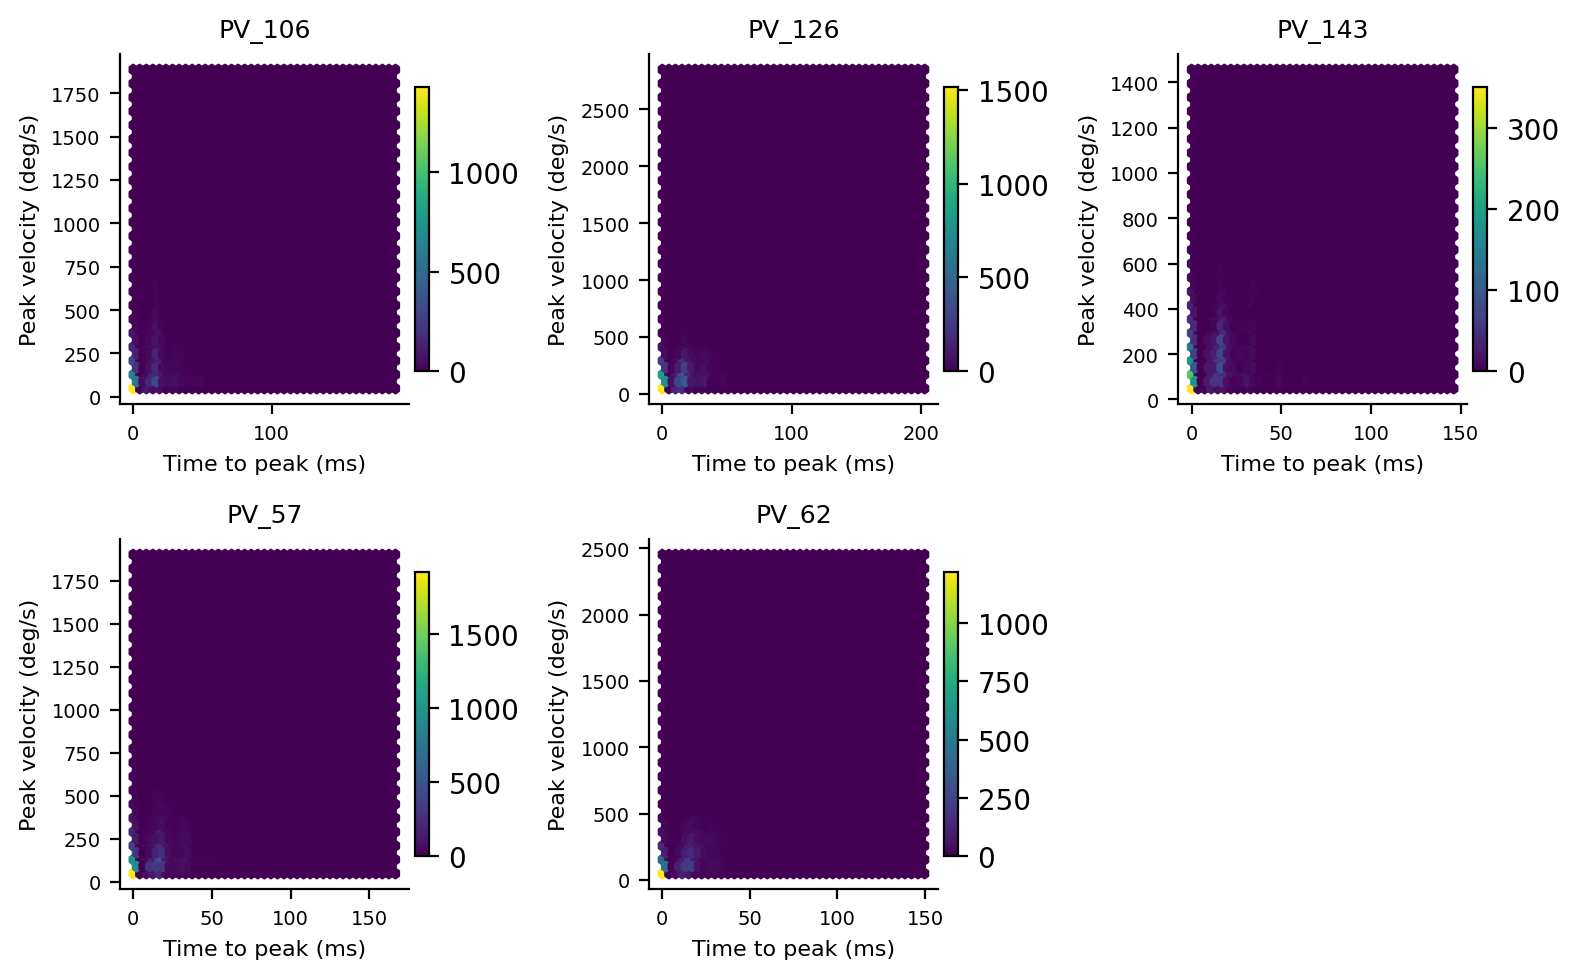

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval

def _to_array(v):
    if isinstance(v, (list, tuple, np.ndarray, pd.Series)):
        return np.asarray(v, dtype=float)
    if isinstance(v, str):
        try: return np.asarray(literal_eval(v), dtype=float)
        except Exception: return np.array([], dtype=float)
    if pd.isna(v): return np.array([], dtype=float)
    try: return np.asarray(v, dtype=float)
    except Exception: return np.array([], dtype=float)

def _parabolic_peak(y):
    y = np.asarray(y, dtype=float)
    if y.size == 0 or not np.isfinite(y).any(): return np.nan, np.nan
    i = int(np.nanargmax(y)); y0 = y[i]
    if i==0 or i==y.size-1: return y0, float(i)
    y_1, y1 = y[i-1], y[i+1]; denom = (y[i-1]-2*y0+y[i+1])
    if denom == 0 or not np.all(np.isfinite([y_1,y0,y1])): return y0, float(i)
    d = 0.5*(y_1-y1)/denom; d = float(np.clip(d,-1,1))
    v_ref = y0 - 0.25*(y_1 - y1)*d
    return (v_ref if np.isfinite(v_ref) else y0), float(i+d)

def plot_peakV_vs_TTP_per_animal(
    all_saccade_collection: pd.DataFrame,
    sampling_rate_hz: float = 60.0,
    min_amp_deg: float = 0.25,
    subsample_peak: bool = True,
    gridsize: int = 40,        # hexbin resolution
    fig_size=(8, 5),
):
    """
    For each animal, plot peak velocity (deg/s) vs time-to-peak (ms) as a hexbin density.
    """
    df = all_saccade_collection.copy().reset_index(drop=True)
    if "animal" not in df.columns:
        df["animal"] = "ALL"
    # choose amplitude col
    amp_col = "net_angular_disp" if "net_angular_disp" in df.columns else (
        "magnitude_raw_angular" if "magnitude_raw_angular" in df.columns else None
    )
    if amp_col is None:
        raise ValueError("Need 'net_angular_disp' or 'magnitude_raw_angular' in DataFrame.")
    frame_ms = 1000.0 / float(sampling_rate_hz)

    rows = []
    for _, r in df.iterrows():
        if pd.isna(r.get(amp_col)): continue
        if float(r[amp_col]) < float(min_amp_deg): continue
        prof = _to_array(r.get("speed_profile_angular", []))  # deg/frame
        if prof.size < 2 or not np.isfinite(prof).any(): continue
        if subsample_peak:
            vpk_df, i_pk = _parabolic_peak(prof)
        else:
            i_pk = int(np.nanargmax(prof)); vpk_df = prof[i_pk]
        vpk_dps = vpk_df * sampling_rate_hz
        # TTP: use provided if good, else from peak index
        ttp_ms = np.nan
        if "time_to_peak_v" in df.columns and pd.notna(r.get("time_to_peak_v")):
            ttp_ms = float(r["time_to_peak_v"])
        if not np.isfinite(ttp_ms):
            ttp_ms = float(i_pk * frame_ms)
        rows.append((r["animal"], vpk_dps, ttp_ms))

    if not rows:
        raise ValueError("No valid saccades passed filters.")
    dd = pd.DataFrame(rows, columns=["animal","vpeak_dps","ttp_ms"])
    animals = sorted(dd["animal"].unique().tolist())
    ncol = min(3, len(animals)); nrow = int(np.ceil(len(animals)/ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=fig_size, dpi=200, squeeze=False)
    k = 0
    for i in range(nrow):
        for j in range(ncol):
            ax = axes[i,j]
            if k >= len(animals):
                ax.axis("off"); continue
            a = animals[k]; k += 1
            g = dd[dd["animal"]==a]
            hb = ax.hexbin(g["ttp_ms"], g["vpeak_dps"], gridsize=gridsize, cmap="viridis")
            ax.set_title(a, fontsize=9)
            ax.set_xlabel("Time to peak (ms)", fontsize=8)
            ax.set_ylabel("Peak velocity (deg/s)", fontsize=8)
            ax.tick_params(labelsize=7)
            for sp in ("top","right"): ax.spines[sp].set_visible(False)
            fig.colorbar(hb, ax=ax, fraction=0.046, pad=0.02)
    fig.tight_layout()
    return fig, dd
plot_peakV_vs_TTP_per_animal(all_saccade_collection)

In [14]:
# --- PATCH: drop-in replacement of timebase + NaN-safe parts inside your earlier implementation ---

import numpy as np
import pandas as pd
import math
from scipy.signal import savgol_filter, medfilt
from scipy.optimize import curve_fit, least_squares

# ---------- helpers updated / added ----------

def _nan_interp_limited(x, t, max_gap_samples=2):
    """
    Return a copy where NaN runs of length <= max_gap_samples are linearly interpolated.
    Longer runs remain NaN. t is in ms (monotonic).
    """
    x = np.asarray(x, float).copy()
    t = np.asarray(t, float)
    isn = ~np.isfinite(x)
    if not isn.any():
        return x
    # find nan runs
    idx = np.arange(len(x))
    on = np.diff(isn.astype(int))
    starts = np.where(on == 1)[0] + 1
    ends   = np.where(on == -1)[0]
    if isn[0]: starts = np.r_[0, starts]
    if isn[-1]: ends = np.r_[ends, len(x)-1]
    for s, e in zip(starts, ends):
        gap_len = e - s + 1
        if gap_len <= max_gap_samples:
            # interpolate between neighbors if both exist and finite
            left = s - 1
            right = e + 1
            if left >= 0 and right < len(x) and np.isfinite(x[left]) and np.isfinite(x[right]):
                x[s:e+1] = np.interp(t[s:e+1], [t[left], t[right]], [x[left], x[right]])
    return x

def _smooth_series_nanaware(x, t, kind: str):
    x = np.asarray(x, float)
    if kind == "none":
        return x
    # limited interpolation for smoothing only
    xi = _nan_interp_limited(x, t, max_gap_samples=2)
    if kind == "savgol":
        n = len(xi)
        win = 5 if n >= 5 else (3 if n >= 3 else 1)
        if win < 3:
            return xi
        try:
            return savgol_filter(xi, window_length=win, polyorder=2, mode="interp")
        except Exception:
            return xi
    if kind == "median":
        k = 3 if len(xi) >= 3 else 1
        if k <= 1:
            return xi
        return medfilt(xi, kernel_size=k)
    return xi

def _central_speed_deg_per_s_nanaware(phi_deg, theta_deg, t_ms):
    """
    Central-diff 2D speed; returns speed where both sides are finite and time increments >0,
    otherwise 0. Keeps length=len(t)-2 (centered at t[1:-1]).
    """
    phi = np.asarray(phi_deg, float)
    the = np.asarray(theta_deg, float)
    t   = np.asarray(t_ms, float)
    if len(t) < 3:
        return np.array([]), np.array([])
    # need central finite triplets
    good = np.isfinite(phi) & np.isfinite(the)
    # interpolate tiny gaps for derivative stability (≤1 sample)
    phi_i = _nan_interp_limited(phi, t, max_gap_samples=1)
    the_i = _nan_interp_limited(the, t, max_gap_samples=1)

    dphi = (phi_i[2:] - phi_i[:-2]) / 2.0
    dthe = (the_i[2:] - the_i[:-2]) / 2.0
    dt   = (t[2:]    - t[:-2]) / 2.0

    # invalidate where any of the three samples was NaN originally or dt<=0
    valid_center = good[1:-1] & good[0:-2] & good[2:]
    bad = (~valid_center) | (~np.isfinite(dt)) | (dt <= 0)

    ds = np.sqrt(dphi**2 + dthe**2)
    v_ms = ds / dt
    v_dps = v_ms * 1000.0
    v_dps[bad] = 0.0
    t_center = t[1:-1]
    return v_dps, t_center

def _pick_time_column(df, sampling_rate_hz, self_obj):
    """
    Choose absolute timebase in ms with preference order:
    1) t_ms
    2) ms_axis (already ms)
    3) OE_timestamp -> requires self.oe_sampling_hz
    4) eye_frame -> requires sampling_rate_hz (arg) or self.sampling_rate_hz
    5) fallback to sampling_rate_hz (arg/self)
    """
    if "t_ms" in df.columns:
        t_abs = np.asarray(df["t_ms"].values, float)
        return t_abs

    if "ms_axis" in df.columns:
        t_abs = np.asarray(df["ms_axis"].values, float)
        return t_abs

    if "OE_timestamp" in df.columns and hasattr(self_obj, "oe_sampling_hz") and self_obj.oe_sampling_hz:
        t_abs = np.asarray(df["OE_timestamp"].values, float) * (1000.0 / float(self_obj.oe_sampling_hz))
        return t_abs

    sr = sampling_rate_hz if sampling_rate_hz is not None else getattr(self_obj, "sampling_rate_hz", None)
    if "eye_frame" in df.columns and sr:
        t_abs = np.asarray(df["eye_frame"].values, float) * (1000.0 / float(sr))
        return t_abs

    if sr:
        n = len(df)
        return np.arange(n, dtype=float) * (1000.0 / float(sr))

    raise ValueError(
        "No usable time column found. Provide one of ['t_ms','ms_axis'] "
        "or set self.oe_sampling_hz for OE_timestamp, or set sampling_rate_hz/self.sampling_rate_hz "
        "for eye_frame or uniform timing."
    )

def _first_last_k_valid_rows(block_phi, block_the, k=3):
    """Return medians of first/last up-to-k VALID (finite) samples for phi/theta; None if insufficient."""
    idx_valid = np.where(np.isfinite(block_phi) & np.isfinite(block_the))[0]
    if idx_valid.size == 0:
        return None, None
    head = block_phi[idx_valid[:k]], block_the[idx_valid[:k]]
    tail = block_phi[idx_valid[-k:]], block_the[idx_valid[-k:]]
    pre  = np.array([np.median(head[0]), np.median(head[1])])
    post = np.array([np.median(tail[0]), np.median(tail[1])])
    return pre, post

def _project_onto_chord_nanaware(phi, the, t_abs, i0, i1, k=3):
    """
    Project only finite samples in [i0..i1] onto chord defined by medians of first/last up-to-k valid samples.
    Returns (t_rel_ms, y_proj_deg, pre, post, dir_deg, used_idx) or (None,...) if invalid.
    """
    sl = slice(i0, i1 + 1)
    phi_w = phi[sl]; the_w = the[sl]; t_w = t_abs[sl]
    valid = np.isfinite(phi_w) & np.isfinite(the_w)
    if valid.sum() < 4:
        return None, None, None, None, None, None

    pre, post = _first_last_k_valid_rows(phi_w, the_w, k=k)
    if pre is None or post is None:
        return None, None, None, None, None, None
    d = post - pre
    norm = np.linalg.norm(d)
    if not np.isfinite(norm) or norm < 1e-3:
        return None, None, None, None, None, None
    u = d / norm
    used_idx = np.where(valid)[0]
    # build projection on valid rows only
    p_valid = np.column_stack((phi_w[valid], the_w[valid]))
    y = (p_valid - pre) @ u
    t_rel = t_w[valid] - t_w[valid][0]  # local zero at first valid sample
    dir_deg = math.degrees(math.atan2(d[1], d[0]))
    return t_rel, y, pre, post, dir_deg, used_idx

# ---------- patch inside the main method: replace timebase, smoothing, speed, projection uses ----------

def detect_and_fit_saccades_hill(
    self,
    eye: str = "both",
    sampling_rate_hz: float = None,
    seed_on_dps: float = 20.0,
    seed_off_ratio: float = 0.7,
    merge_gap_ms: float = 25.0,
    min_samples: int = 4,
    frac_on: float = 0.02,
    frac_off: float = 0.98,
    min_amp_deg: float = 0.3,
    dur_range_ms: tuple = (8.0, 200.0),
    smooth_kind: str = "savgol",
    debug_plots: bool = False,
    debug_max_per_eye: int = 10,
):
    """
    NaN-aware + ms_axis/OE_timestamp/eye_frame timebase handling.
    (Rest of the docstring identical to previous version.)
    """
    import matplotlib.pyplot as plt

    # Inner unchanged helpers from your previous version:
    #   _hill_pos, _hill_vel_ms, _hill_t_at_fraction, _hill_peak_time, _hill_peak_vel_dps,
    #   _boolean_runs, _merge_windows_by_gap, _fit_hill, _mk_empty_df, _debug_plot, _validate_eye_df
    # (Assuming they are already present from the previous paste.)

    def process_one_eye(df_eye: pd.DataFrame, label: str) -> pd.DataFrame:
        _validate_eye_df(df_eye)

        # ----- TIMEBASE (robust) -----
        t_abs = _pick_time_column(df_eye, sampling_rate_hz, self)

        # Positions (deg)
        phi = np.asarray(df_eye["k_phi"].values, float)
        the = np.asarray(df_eye["k_theta"].values, float)

        # ----- light smoothing, NaN-aware (does not alter original arrays) -----
        phi_s = _smooth_series_nanaware(phi, t_abs, kind=smooth_kind)
        the_s = _smooth_series_nanaware(the, t_abs, kind=smooth_kind)

        # ----- speed seeding (NaN-aware) -----
        v_dps, t_center = _central_speed_deg_per_s_nanaware(phi_s, the_s, t_abs)
        if v_dps.size == 0:
            return _mk_empty_df()

        on_thr = float(seed_on_dps)
        off_thr = max(0.0, on_thr * float(seed_off_ratio))
        above_on  = v_dps >= on_thr
        above_off = v_dps >= off_thr

        runs = _boolean_runs(above_off)
        refined = []
        for s_idx, e_idx in runs:
            if np.any(above_on[s_idx:e_idx+1]):
                refined.append((s_idx, e_idx))
        if not refined:
            return _mk_empty_df()

        # Map from speed indices to sample indices, pad, and merge by time gap
        seed_windows = []
        for s_idx, e_idx in refined:
            i0 = max(0, s_idx - 2)              # pad left
            i1 = min(len(phi_s)-1, e_idx + 2 + 2)  # map + pad right
            if (i1 - i0 + 1) >= min_samples:
                seed_windows.append((i0, i1))
        if not seed_windows:
            return _mk_empty_df()

        merged = _merge_windows_by_gap(seed_windows, t_abs, merge_gap_ms)

        rows = []
        plot_slots = min(debug_max_per_eye, len(merged))
        pick = np.random.choice(len(merged), size=plot_slots, replace=False) if debug_plots else []

        n_plotted = 0
        for wi, (i0, i1) in enumerate(merged):
            # Build NaN-aware projection onto chord using only valid samples
            t_rel_ms, y_proj, pre, post, dir_deg, used_idx_local = _project_onto_chord_nanaware(
                phi_s, the_s, t_abs, i0, i1, k=3
            )
            if t_rel_ms is None:
                continue
            if len(t_rel_ms) < max(4, min_samples):
                continue

            # Initial guesses from edges of VALID samples
            k = min(3, len(y_proj))
            E0_guess   = float(np.median(y_proj[:k]))
            Emax_guess = float(np.median(y_proj[-k:]))
            E50_guess  = max(0.1, 0.5 * (t_rel_ms[-1] - t_rel_ms[0]))
            alpha_guess= 3.0

            try:
                (E0, Emax, E50, alpha), yhat, ok, sse, r2 = _fit_hill(t_rel_ms, y_proj, E0_guess, Emax_guess, E50_guess, alpha_guess)
            except Exception:
                continue

            A = (Emax - E0)
            if not np.isfinite(r2) or r2 < 0.5:        continue
            if (abs(A) < min_amp_deg) or (E50 <= 0):   continue
            if (alpha <= 1.05):                        continue

            # Fractional times in REL ms (relative to first valid sample in window)
            t_on   = _hill_t_at_fraction(E50, alpha, frac_on)
            t_off  = _hill_t_at_fraction(E50, alpha, frac_off)
            t_peak = _hill_peak_time(E50, alpha)
            if not (np.isfinite(t_on) and np.isfinite(t_off) and np.isfinite(t_peak)):
                continue
            if t_off <= t_on:
                continue

            duration = t_off - t_on
            if not (dur_range_ms[0] <= duration <= dur_range_ms[1]):
                continue
            if not (t_on < t_peak < t_off):
                continue

            # Absolute timing: window's first VALID sample absolute time:
            first_valid_abs = t_abs[i0:i1+1][used_idx_local][0]
            on_ms  = first_valid_abs + t_on
            off_ms = first_valid_abs + t_off
            tpk_ms = first_valid_abs + t_peak

            vpk_dps = _hill_peak_vel_dps(E0, Emax, E50, alpha)

            # Baselines from ORIGINAL, unsmoothed arrays but using valid edges
            # (fall back to smoothed if needed)
            phi_w = phi[i0:i1+1]; the_w = the[i0:i1+1]
            pre2, post2 = _first_last_k_valid_rows(phi_w, the_w, k=3)
            if pre2 is None or post2 is None:
                # fall back to smoothed if originals fully NaN at edges
                phi_w = phi_s[i0:i1+1]; the_w = the_s[i0:i1+1]
                pre2, post2 = _first_last_k_valid_rows(phi_w, the_w, k=3)
                if pre2 is None or post2 is None:
                    continue
            pre_phi, pre_theta   = float(pre2[0]),  float(pre2[1])
            post_phi, post_theta = float(post2[0]), float(post2[1])

            rows.append(dict(
                saccade_id=len(rows)+1,
                on_ms=float(on_ms), off_ms=float(off_ms), duration_ms=float(duration),
                amp_deg=float(A), t_peak_ms=float(tpk_ms), v_peak_dps=float(vpk_dps), dir_deg=float(dir_deg),
                pre_phi=pre_phi, pre_theta=pre_theta, post_phi=post_phi, post_theta=post_theta,
                alpha=float(alpha), E50_ms=float(E50), E0_deg=float(E0), Emax_deg=float(Emax),
                r2=float(r2), sse=float(sse), n_samples=int(i1 - i0 + 1),
                window_start_ms=float(t_abs[i0]), window_end_ms=float(t_abs[i1]),
                status="ok"
            ))

            if debug_plots and (wi in pick):
                if n_plotted == 0:
                    self._dbg_fig, self._dbg_axes = plt.subplots(
                        nrows=len(pick), ncols=1, figsize=(4, 1.6*len(pick)), constrained_layout=True
                    )
                    if len(pick) == 1: self._dbg_axes = [self._dbg_axes]
                ax = self._dbg_axes[n_plotted]
                _debug_plot(ax, t_rel_ms, y_proj, _hill_pos(t_rel_ms, E0, Emax, E50, alpha),
                            t_on, t_peak, t_off, f"{label} w{wi}  r2={r2:.2f}, A={A:.2f}°")
                n_plotted += 1

        if not rows:
            return pd.DataFrame(columns=[
                "saccade_id","on_ms","off_ms","duration_ms","amp_deg","t_peak_ms","v_peak_dps","dir_deg",
                "pre_phi","pre_theta","post_phi","post_theta","alpha","E50_ms","E0_deg","Emax_deg",
                "r2","sse","n_samples","window_start_ms","window_end_ms","status"
            ])
        out = pd.DataFrame(rows).sort_values("on_ms").reset_index(drop=True)
        out["saccade_id"] = np.arange(1, len(out)+1, dtype=int)
        return out

    eye = (eye or "both").lower()
    if eye not in ("l","r","both"):
        raise ValueError("eye must be 'L', 'R', or 'both'.")

    if eye in ("l","both"):
        if not hasattr(self, "left_eye_data"):
            raise ValueError("BlockSync.left_eye_data is missing.")
        self.l_saccades = process_one_eye(self.left_eye_data, label="Left")

    if eye in ("r","both"):
        if not hasattr(self, "right_eye_data"):
            raise ValueError("BlockSync.right_eye_data is missing.")
        self.r_saccades = process_one_eye(self.right_eye_data, label="Right")
BlockSync.detect_and_fit_saccades_hill = detect_and_fit_saccades_hill

In [7]:
block = block_collection[0]

In [15]:
# Typical call (60 Hz default if no t_ms present):
block.detect_and_fit_saccades_hill(
    eye="both",
    seed_on_dps=20.0,
    seed_off_ratio=0.7,
    merge_gap_ms=25.0,
    min_samples=4,
    frac_on=0.02,
    frac_off=0.98,
    min_amp_deg=0.3,
    dur_range_ms=(8.0, 200.0),
    smooth_kind="savgol",
    debug_plots=True,        # optional: show a few overlays per eye
    debug_max_per_eye=10
)

# Results:
block.l_saccades.head()
block.r_saccades.head()

<ipython-input-6-a48cbd0d83b0>:16: RuntimeWarning: invalid value encountered in power
  return E0 + (Emax - E0) * (t / (E50 + t))**alpha
<ipython-input-6-a48cbd0d83b0>:16: RuntimeWarning: divide by zero encountered in power
  return E0 + (Emax - E0) * (t / (E50 + t))**alpha
<ipython-input-6-a48cbd0d83b0>:16: RuntimeWarning: overflow encountered in power
  return E0 + (Emax - E0) * (t / (E50 + t))**alpha
<ipython-input-6-a48cbd0d83b0>:16: RuntimeWarning: overflow encountered in multiply
  return E0 + (Emax - E0) * (t / (E50 + t))**alpha
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Empty DataFrame
Columns: [saccade_id, on_ms, off_ms, duration_ms, amp_deg, t_peak_ms, v_peak_dps, dir_deg, pre_phi, pre_theta, post_phi, post_theta, alpha, E50_ms, E0_deg, Emax_deg, r2, sse, n_samples, window_start_ms, window_end_ms, status]
Index: []

[0 rows x 22 columns]

In [26]:
import numpy as np
import pandas as pd
import math
from scipy.signal import savgol_filter, medfilt
from scipy.optimize import least_squares

# ----------------- numerically safer Hill model & helpers -----------------

def _hill_pos_safe(t_ms, E0, Emax, E50, alpha):
    """Hill sigmoid in POSITION (deg), time in ms; guards against invalid ops."""
    t = np.asarray(t_ms, float)
    # enforce non-negative time (our t_rel is >=0 anyway)
    t = np.maximum(t, 0.0)
    # tiny epsilon avoids division by zero during optimizer wander
    eps = 1e-12
    with np.errstate(divide='ignore', invalid='ignore', over='ignore'):
        frac = t / np.maximum(E50 + t, eps)
        y = E0 + (Emax - E0) * np.power(frac, alpha)
    # Replace non-finite with huge value to penalize invalid parameter regions
    bad = ~np.isfinite(y)
    if bad.any():
        y[bad] = 1e12
    return y

def _hill_t_at_fraction(E50, alpha, f):
    # t(f) = E50 * f^(1/alpha) / (1 - f^(1/alpha))
    if not (0.0 < f < 1.0):
        return np.nan
    g = f**(1.0 / alpha)
    if g >= 1.0:
        return np.inf
    return E50 * g / (1.0 - g)

def _hill_peak_time(E50, alpha):
    return ((alpha - 1.0) / 2.0) * E50

def _hill_peak_vel_dps(E0, Emax, E50, alpha):
    # Closed form peak velocity from the Hill fit, then ×1000 to deg/s
    if E50 <= 0:
        return np.nan
    A = (Emax - E0)
    num = ((alpha - 1.0) / 2.0)**(alpha - 1.0)
    den = ((alpha + 1.0) / 2.0)**(alpha + 1.0)
    v_peak_ms = A * alpha * (num / den) / E50
    return v_peak_ms * 1000.0

def _boolean_runs(mask):
    on = np.asarray(mask, bool)
    if on.size == 0:
        return []
    e = np.diff(on.astype(int))
    s = np.where(e == 1)[0] + 1
    q = np.where(e == -1)[0]
    if on[0]: s = np.r_[0, s]
    if on[-1]: q = np.r_[q, on.size - 1]
    return list(zip(s.tolist(), q.tolist()))

def _merge_windows_by_gap(sample_windows, t_ms, max_gap_ms):
    if not sample_windows:
        return []
    merged = [sample_windows[0]]
    for s, e in sample_windows[1:]:
        ps, pe = merged[-1]
        gap = t_ms[s] - t_ms[pe]
        if gap < max_gap_ms:
            merged[-1] = (ps, e)
        else:
            merged.append((s, e))
    return merged

def _nan_interp_limited(x, t, max_gap_samples=2):
    x = np.asarray(x, float).copy()
    t = np.asarray(t, float)
    isn = ~np.isfinite(x)
    if not isn.any():
        return x
    idx = np.arange(len(x))
    on = np.diff(isn.astype(int))
    starts = np.where(on == 1)[0] + 1
    ends   = np.where(on == -1)[0]
    if isn[0]:  starts = np.r_[0, starts]
    if isn[-1]: ends   = np.r_[ends, len(x)-1]
    for s, e in zip(starts, ends):
        gap_len = e - s + 1
        if gap_len <= max_gap_samples:
            L = s - 1
            R = e + 1
            if L >= 0 and R < len(x) and np.isfinite(x[L]) and np.isfinite(x[R]):
                x[s:e+1] = np.interp(t[s:e+1], [t[L], t[R]], [x[L], x[R]])
    return x

def _smooth_series_nanaware(x, t, kind="savgol"):
    x = np.asarray(x, float)
    xi = _nan_interp_limited(x, t, max_gap_samples=2)
    if kind == "none":
        return xi
    if kind == "savgol":
        n = len(xi)
        win = 5 if n >= 5 else (3 if n >= 3 else 1)
        if win < 3:
            return xi
        try:
            return savgol_filter(xi, window_length=win, polyorder=2, mode="interp")
        except Exception:
            return xi
    if kind == "median":
        k = 3 if len(xi) >= 3 else 1
        if k <= 1:
            return xi
        return medfilt(xi, kernel_size=k)
    return xi

def _central_speed_deg_per_s_nanaware(phi_deg, theta_deg, t_ms):
    phi = np.asarray(phi_deg, float)
    the = np.asarray(theta_deg, float)
    t   = np.asarray(t_ms, float)
    if len(t) < 3:
        return np.array([]), np.array([])
    good = np.isfinite(phi) & np.isfinite(the)
    phi_i = _nan_interp_limited(phi, t, max_gap_samples=1)
    the_i = _nan_interp_limited(the, t, max_gap_samples=1)
    dphi = (phi_i[2:] - phi_i[:-2]) / 2.0
    dthe = (the_i[2:] - the_i[:-2]) / 2.0
    dt   = (t[2:]    - t[:-2]) / 2.0
    valid_center = good[1:-1] & good[:-2] & good[2:]
    bad = (~valid_center) | (~np.isfinite(dt)) | (dt <= 0)
    ds = np.sqrt(dphi**2 + dthe**2)
    v_ms = ds / np.where(dt <= 0, np.nan, dt)
    v_dps = v_ms * 1000.0
    v_dps[~np.isfinite(v_dps)] = 0.0
    v_dps[bad] = 0.0
    return v_dps, t[1:-1]

def _first_last_k_valid_rows(x, y, k=3):
    idx = np.where(np.isfinite(x) & np.isfinite(y))[0]
    if idx.size == 0:
        return None, None
    pre  = np.array([np.median(x[idx[:k]]), np.median(y[idx[:k]])])
    post = np.array([np.median(x[idx[-k:]]), np.median(y[idx[-k:]])])
    return pre, post

def _project_onto_chord_nanaware(phi, the, t_abs, i0, i1, k=3):
    sl = slice(i0, i1+1)
    phi_w = phi[sl]; the_w = the[sl]; t_w = t_abs[sl]
    valid = np.isfinite(phi_w) & np.isfinite(the_w)
    if valid.sum() < 4:
        return None, None, None, None, None, None
    pre, post = _first_last_k_valid_rows(phi_w, the_w, k=k)
    if pre is None or post is None:
        return None, None, None, None, None, None
    d = post - pre
    norm = np.linalg.norm(d)
    if not np.isfinite(norm) or norm < 1e-3:
        return None, None, None, None, None, None
    u = d / norm
    used_idx = np.where(valid)[0]
    p_valid = np.column_stack((phi_w[valid], the_w[valid]))
    y = (p_valid - pre) @ u
    t_rel = t_w[valid] - t_w[valid][0]
    dir_deg = math.degrees(math.atan2(d[1], d[0]))
    return t_rel, y, pre, post, dir_deg, used_idx

def _pick_time_column(df, sampling_rate_hz, self_obj):
    if "t_ms" in df.columns:
        return np.asarray(df["t_ms"].values, float), "t_ms"
    if "ms_axis" in df.columns:
        return np.asarray(df["ms_axis"].values, float), "ms_axis"
    if "OE_timestamp" in df.columns and hasattr(self_obj, "oe_sampling_hz") and self_obj.oe_sampling_hz:
        return np.asarray(df["OE_timestamp"].values, float) * (1000.0 / float(self_obj.oe_sampling_hz)), "OE_timestamp→ms"
    sr = sampling_rate_hz if sampling_rate_hz is not None else getattr(self_obj, "sampling_rate_hz", None)
    if "eye_frame" in df.columns and sr:
        return np.asarray(df["eye_frame"].values, float) * (1000.0 / float(sr)), "eye_frame→ms"
    if sr:
        n = len(df)
        return np.arange(n, dtype=float) * (1000.0 / float(sr)), "uniform(sr)"
    raise ValueError("No usable time column. Provide one of ['t_ms','ms_axis'] or set self.oe_sampling_hz / sampling_rate_hz.")

def _fit_hill_trf(t_ms, y_deg, y0_guess, y1_guess, E50_guess, alpha_guess):
    """Bounded least-squares (TRF) only, returns params, yhat, success, sse, r2."""
    t = np.asarray(t_ms, float)
    y = np.asarray(y_deg, float)
    if len(t) < 4:
        raise RuntimeError("Too few samples for Hill fit.")
    p0 = np.array([y0_guess, y1_guess, max(E50_guess, 0.2), max(alpha_guess, 1.3)], float)
    tspan = max(t) - min(t) if len(t) else 100.0
    lb = np.array([-np.inf, -np.inf, 0.2, 1.2], float)
    ub = np.array([ np.inf,  np.inf, max(5.0, 5.0*tspan), 8.0], float)

    def resid(p):
        return _hill_pos_safe(t, p[0], p[1], p[2], p[3]) - y

    res = least_squares(resid, x0=p0, bounds=(lb, ub), method="trf", max_nfev=4000)
    popt = res.x
    yhat = _hill_pos_safe(t, *popt)
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2) if len(y) > 1 else np.nan
    r2 = 1.0 - ss_res/ss_tot if (ss_tot and ss_tot > 0) else np.nan
    ok = (popt[3] > 1.05) and (popt[2] > 0) and np.isfinite(r2)
    return popt, yhat, bool(ok), ss_res, float(r2)

def _refine_window_by_speed(i0, i1, t_abs, v_dps, seed_on_dps,
                            halo_ms=25.0, fit_min_ms=50.0, fit_max_ms=250.0):
    """
    Tighten [i0,i1] to the high-speed core (>= seed_on_dps),
    then expand with a halo to at least fit_min_ms (if possible),
    but never exceed fit_max_ms.
    """
    n = len(t_abs)
    if n < 3:
        return None, None

    # speed indices 0..len(v_dps)-1 correspond to centers at samples 1..n-2
    s0 = max(0, i0)
    s1 = min(len(v_dps)-1, i1-2)
    if s0 > s1:
        return None, None

    core_mask = (v_dps[s0:s1+1] >= float(seed_on_dps))
    if not core_mask.any():
        return None, None

    # longest contiguous run inside the merged seed
    runs = _boolean_runs(core_mask)
    lens = [(e - s + 1) for (s, e) in runs]
    ridx = int(np.argmax(lens))
    cs, ce = runs[ridx]
    cs += s0; ce += s0

    # map to sample indices; +2 on right to cover central diff
    j0 = max(0, cs)
    j1 = min(n-1, ce + 2)

    # initial halo
    t0 = t_abs[j0] - halo_ms
    t1 = t_abs[j1] + halo_ms

    # enforce min span if possible
    if (t1 - t0) < fit_min_ms:
        center = 0.5*(t_abs[j0] + t_abs[j1])
        half = 0.5*fit_min_ms
        t0 = center - half
        t1 = center + half

    # clip to the merged seed bounds [t_abs[i0], t_abs[i1]] so we don't wander
    t0 = max(t0, t_abs[i0]); t1 = min(t1, t_abs[i1])

    # hard-cap to fit_max_ms (centered)
    if (t1 - t0) > fit_max_ms:
        center = 0.5*(t0 + t1)
        half = 0.5*fit_max_ms
        t0 = center - half
        t1 = center + half

    # convert back to indices
    ri0 = int(np.searchsorted(t_abs, t0, side="left"))
    ri1 = int(np.searchsorted(t_abs, t1, side="right")) - 1
    ri0 = max(0, ri0); ri1 = min(n-1, ri1)
    if ri1 <= ri0:
        return None, None
    return ri0, ri1



# ----------------- DIAGNOSTIC main method (monkey-patch onto BlockSync) -----------------

def detect_and_fit_saccades_hill(
    self,
    eye: str = "both",
    sampling_rate_hz: float = None,
    seed_on_dps: float = 20.0,
    seed_off_ratio: float = 0.7,
    merge_gap_ms: float = 25.0,
    min_samples: int = 4,
    frac_on: float = 0.02,
    frac_off: float = 0.98,
    min_amp_deg: float = 0.3,
    dur_range_ms: tuple = (8.0, 200.0),
    smooth_kind: str = "savgol",
    debug_plots: bool = False,
    debug_max_per_eye: int = 10,
    verbose: bool = True,
):
    """
    Diagnostic, NaN-aware Hill-based saccade detection & fitting.
    Prints a step-by-step log and returns a debug_report dict per eye.
    """
    debug_report = {"L": {}, "R": {}}

    def _process_eye(df_eye: pd.DataFrame, label: str):
        rep = {}  # per-eye report
        def log(msg):
            if verbose:
                print(f"[{label}] {msg}")

        # ---- Validate inputs
        if df_eye is None or df_eye.empty:
            log("Eye DataFrame missing/empty.")
            rep["status"] = "empty_df"
            return pd.DataFrame(), rep
        for col in ("k_phi","k_theta"):
            if col not in df_eye.columns:
                log(f"Missing column: {col}")
                rep["status"] = "missing_cols"
                return pd.DataFrame(), rep

        # ---- Timebase
        try:
            t_abs, tb_src = _pick_time_column(df_eye, sampling_rate_hz, self)
        except Exception as e:
            log(f"Timebase error: {e}")
            rep["status"] = "timebase_error"
            rep["error"]  = str(e)
            return pd.DataFrame(), rep
        rep["timebase_source"] = tb_src
        log(f"Timebase = {tb_src}, n={len(t_abs)}, t[min,max]=({np.nanmin(t_abs):.3f},{np.nanmax(t_abs):.3f}) ms")

        # ---- Extract signals
        phi = np.asarray(df_eye["k_phi"].values, float)
        the = np.asarray(df_eye["k_theta"].values, float)
        n_total = len(phi)
        rep["n_total"] = int(n_total)
        n_finite = int(np.isfinite(phi).sum() & np.isfinite(the).sum())
        log(f"Finite samples (phi & theta): {np.isfinite(phi).sum()} / {n_total}, {np.isfinite(the).sum()} / {n_total}")

        # ---- Smoothing
        phi_s = _smooth_series_nanaware(phi, t_abs, smooth_kind)
        the_s = _smooth_series_nanaware(the, t_abs, smooth_kind)
        # ---- Speed & thresholds
        v_dps, t_ctr = _central_speed_deg_per_s_nanaware(phi_s, the_s, t_abs)
        if v_dps.size == 0:
            log("Speed vector is empty (n<3 or all invalid).")
            rep["status"] = "no_speed"
            return pd.DataFrame(), rep

        rep["speed_count"] = int(len(v_dps))
        log(f"Speed samples: {len(v_dps)}; speed stats: min={np.min(v_dps):.2f}, median={np.median(v_dps):.2f}, 95%={np.percentile(v_dps,95):.2f}, max={np.max(v_dps):.2f} deg/s")

        on_thr = float(seed_on_dps)
        off_thr = max(0.0, on_thr * float(seed_off_ratio))
        rep["seed_on_dps"]  = on_thr
        rep["seed_off_dps"] = off_thr

        above_on  = v_dps >= on_thr
        above_off = v_dps >= off_thr
        rep["pct_above_on"]  = float(100.0*np.mean(above_on)) if len(above_on) else 0.0
        rep["pct_above_off"] = float(100.0*np.mean(above_off)) if len(above_off) else 0.0
        log(f"Above on-thr: {rep['pct_above_on']:.2f}% ; above off-thr: {rep['pct_above_off']:.2f}%")

        runs = _boolean_runs(above_off)
        runs_kept = [(s,e) for (s,e) in runs if np.any(above_on[s:e+1])]
        log(f"Runs(off-thr)={len(runs)}; runs(cross on-thr)={len(runs_kept)}")

        # Map speed-centered indices to sample indices and pad
        seed_windows = []
        for s_idx, e_idx in runs_kept:
            i0 = max(0, s_idx - 2)
            i1 = min(n_total-1, e_idx + 4)  # map + pad
            if (i1 - i0 + 1) >= min_samples:
                seed_windows.append((i0, i1))

        log(f"Seed windows (pre-merge): {len(seed_windows)}")
        merged = _merge_windows_by_gap(seed_windows, t_abs, merge_gap_ms)
        log(f"Seed windows (post-merge): {len(merged)}")
        rep["seed_windows_raw"]   = int(len(seed_windows))
        rep["seed_windows_merged"]= int(len(merged))

        rows = []
        reject_counts = {
            "proj_invalid":0, "too_short":0, "amp_small":0, "fit_fail":0,
            "r2_low":0, "bad_params":0, "fraction_times":0, "duration":0, "peak_outside":0
        }

        # Try to fit; show first few attempts verbosely
        print_n = min(5, len(merged))
        for wi, (i0, i1) in enumerate(merged):
            # NEW: tighten the window around the true high-speed burst
            ri0, ri1 = _refine_window_by_speed(i0, i1, t_abs, v_dps, seed_on_dps, halo_ms=25.0, fit_max_ms=350.0)
            if ri0 is None:
                reject_counts["proj_invalid"] += 1
                if wi < print_n: log(f"win#{wi}: no core ≥ on-thr inside seed.")
                continue

            # project using the refined window
            t_rel_ms, y_proj, pre, post, dir_deg, used_idx_local = _project_onto_chord_nanaware(
                phi_s, the_s, t_abs, ri0, ri1, k=3
            )

            if t_rel_ms is None:
                reject_counts["proj_invalid"] += 1
                if wi < print_n: log(f"win#{wi}: projection invalid (insufficient valid or chord too small).")
                continue
            if len(t_rel_ms) < max(4, min_samples):
                reject_counts["too_short"] += 1
                if wi < print_n: log(f"win#{wi}: too few valid samples after NaN filtering (n={len(t_rel_ms)}).")
                continue

            # local pre/post baselines (10 ms) around the refined window
            pre_mask  = (t_abs >= (t_abs[ri0] - 10.0)) & (t_abs < t_abs[ri0])
            post_mask = (t_abs >  t_abs[ri1]) & (t_abs <= (t_abs[ri1] + 10.0))

            def _med2d(mask):
                if mask.sum() >= 2:
                    return np.array([np.nanmedian(phi_s[mask]), np.nanmedian(the_s[mask])])
                return None

            pre_local  = _med2d(pre_mask)
            post_local = _med2d(post_mask)
            # fallbacks if we don’t have clean neighborhoods
            if pre_local is None or not np.all(np.isfinite(pre_local)):
                pre_local = pre
            if post_local is None or not np.all(np.isfinite(post_local)):
                post_local = post

            # Recompute chord and projection using these local baselines for initial guesses only
            d_local = post_local - pre_local
            norm_local = np.linalg.norm(d_local)
            if not np.isfinite(norm_local) or norm_local < 1e-3:
                reject_counts["proj_invalid"] += 1
                if wi < print_n: log(f"win#{wi}: local chord too small.")
                continue
            u_local = d_local / norm_local

            # Build local-projected series for E0/Emax guesses (keep t_rel_ms from earlier)
            p_valid = np.column_stack((phi_s[ri0:ri1+1][used_idx_local], the_s[ri0:ri1+1][used_idx_local]))
            y_local = (p_valid - pre_local) @ u_local


            k = min(3, len(y_local))
            E0_guess    = float(np.median(y_local[:k]))
            Emax_guess  = float(np.median(y_local[-k:]))

            # Robust E50 initial guess from refined span
            t_span = float(t_rel_ms[-1] - t_rel_ms[0]) if len(t_rel_ms) > 1 else 50.0
            E50_guess  = max(0.2, 0.30 * t_span)   # 30% of local span, >= 0.2 ms
            alpha_guess= 3.0

            # Optional: light linear detrend on y before fitting; improves R² if slight drift remains
            # (We still compute kinematics from the FIT; detrending only shapes residuals.)
            if len(t_rel_ms) >= 4:
                tt = t_rel_ms
                A = np.vstack([tt, np.ones_like(tt)]).T
                coef, _, _, _ = np.linalg.lstsq(A, y_proj, rcond=None)
                y_fit_trend = A @ coef
                y_to_fit = y_proj - y_fit_trend
            else:
                y_to_fit = y_proj

            try:
                (E0, Emax, E50, alpha), yhat, ok, sse, r2 = _fit_hill_trf(
                    t_rel_ms, y_to_fit, E0_guess, Emax_guess, E50_guess, alpha_guess
                )
            except Exception as e:
                reject_counts["fit_fail"] += 1
                if wi < print_n: log(f"win#{wi}: fit error -> {e}")
                continue

            Aamp = (Emax - E0)
            if abs(Aamp) < min_amp_deg:
                reject_counts["amp_small"] += 1
                if wi < print_n: log(f"win#{wi}: amp too small A={Aamp:.3f} deg (min {min_amp_deg}).")
                continue
            if not np.isfinite(r2) or r2 < 0.5:
                reject_counts["r2_low"] += 1
                if wi < print_n: log(f"win#{wi}: r2 too low r2={r2:.3f}.")
                continue
            if (E50 <= 0) or (alpha <= 1.05):
                reject_counts["bad_params"] += 1
                if wi < print_n: log(f"win#{wi}: bad params E50={E50:.3f}, alpha={alpha:.3f}.")
                continue

            t_on   = _hill_t_at_fraction(E50, alpha, frac_on)
            t_off  = _hill_t_at_fraction(E50, alpha, frac_off)
            t_peak = _hill_peak_time(E50, alpha)
            if not (np.isfinite(t_on) and np.isfinite(t_off) and np.isfinite(t_peak)) or (t_off <= t_on):
                reject_counts["fraction_times"] += 1
                if wi < print_n: log(f"win#{wi}: invalid fractional times on={t_on}, off={t_off}, peak={t_peak}.")
                continue

            duration = t_off - t_on
            if not (dur_range_ms[0] <= duration <= dur_range_ms[1]):
                reject_counts["duration"] += 1
                if wi < print_n: log(f"win#{wi}: duration {duration:.2f}ms outside {dur_range_ms}.")
                continue
            if not (t_on < t_peak < t_off):
                reject_counts["peak_outside"] += 1
                if wi < print_n: log(f"win#{wi}: peak {t_peak:.2f}ms not between on/off.")
                continue

            # Absolute timing: use refined window indices here
            first_valid_abs = t_abs[ri0:ri1+1][used_idx_local][0]
            on_ms  = first_valid_abs + t_on
            off_ms = first_valid_abs + t_off
            tpk_ms = first_valid_abs + t_peak
            vpk_dps = _hill_peak_vel_dps(E0, Emax, E50, alpha)

            # Baselines from RAW if available; fallback to smoothed, using the refined window
            phi_w = np.asarray(df_eye["k_phi"].values[ri0:ri1+1], float)
            the_w = np.asarray(df_eye["k_theta"].values[ri0:ri1+1], float)
            pre2, post2 = _first_last_k_valid_rows(phi_w, the_w, k=3)
            if pre2 is None or post2 is None:
                pre2, post2 = _first_last_k_valid_rows(phi_s[ri0:ri1+1], the_s[ri0:ri1+1], k=3)
                if pre2 is None or post2 is None:
                    reject_counts["proj_invalid"] += 1
                    if wi < print_n: log(f"win#{wi}: cannot compute baselines (refined).")
                    continue

            rows.append(dict(
                saccade_id=len(rows)+1,
                on_ms=float(on_ms), off_ms=float(off_ms), duration_ms=float(duration),
                amp_deg=float(Aamp), t_peak_ms=float(tpk_ms), v_peak_dps=float(vpk_dps), dir_deg=float(dir_deg),
                pre_phi=float(pre2[0]), pre_theta=float(pre2[1]),
                post_phi=float(post2[0]), post_theta=float(post2[1]),
                alpha=float(alpha), E50_ms=float(E50), E0_deg=float(E0), Emax_deg=float(Emax),
                r2=float(r2), sse=float(sse), n_samples=int(ri1 - ri0 + 1),
                window_start_ms=float(t_abs[i0]),   window_end_ms=float(t_abs[i1]),   # original merged seed (for bookkeeping)
                # Optional: also expose the actual refined fit span we used:
                # refined_start_ms=float(t_abs[ri0]), refined_end_ms=float(t_abs[ri1]),
                status="ok"
            ))

            if wi < print_n:
                log(f"win#{wi}: OK  A={Aamp:.3f}°, r2={r2:.3f}, E50={E50:.2f}ms, α={alpha:.2f}, "
                    f"dur={duration:.1f}ms, vpk={vpk_dps:.1f}°/s, on={on_ms:.2f}ms, off={off_ms:.2f}ms, "
                    f"span={t_abs[ri1]-t_abs[ri0]:.1f}ms")

        rep["reject_counts"] = reject_counts
        log(f"Accepted saccades: {len(rows)}; rejects: {reject_counts}")

        if not rows:
            cols = ["saccade_id","on_ms","off_ms","duration_ms","amp_deg","t_peak_ms","v_peak_dps","dir_deg",
                    "pre_phi","pre_theta","post_phi","post_theta","alpha","E50_ms","E0_deg","Emax_deg",
                    "r2","sse","n_samples","window_start_ms","window_end_ms","status"]
            return pd.DataFrame(columns=cols), rep

        out = pd.DataFrame(rows).sort_values("on_ms").reset_index(drop=True)
        out["saccade_id"] = np.arange(1, len(out)+1, dtype=int)
        rep["status"] = "ok"
        rep["n_saccades"] = int(len(out))
        return out, rep

    # -------- run per eye --------
    eyes = (eye or "both").lower()
    if eyes not in ("l","r","both"):
        raise ValueError("eye must be 'L','R', or 'both'.")

    if eyes in ("l","both"):
        if not hasattr(self, "left_eye_data"):
            raise ValueError("BlockSync.left_eye_data is missing.")
        self.l_saccades, debug_report["L"] = _process_eye(self.left_eye_data, "Left")
    if eyes in ("r","both"):
        if not hasattr(self, "right_eye_data"):
            raise ValueError("BlockSync.right_eye_data is missing.")
        self.r_saccades, debug_report["R"] = _process_eye(self.right_eye_data, "Right")

    return debug_report

# Monkey-patch:
BlockSync.detect_and_fit_saccades_hill = detect_and_fit_saccades_hill


In [10]:
block.left_eye_data.columns

Index(['Unnamed: 0', 'OE_timestamp', 'eye_frame', 'ms_axis', 'center_x',
       'center_y', 'phi', 'width', 'height', 'major_ax', 'minor_ax', 'ratio',
       'ratio2', 'phi_ellipse', 'k_phi', 'k_theta', 'pupil_diameter_pixels',
       'pupil_diameter'],
      dtype='object')

In [27]:
dbg = block.detect_and_fit_saccades_hill(
    eye="both",
    seed_on_dps=20.0,
    seed_off_ratio=0.7,
    merge_gap_ms=25.0,
    min_samples=4,
    frac_on=0.02,
    frac_off=0.98,
    min_amp_deg=0.3,
    dur_range_ms=(8, 200),
    smooth_kind="savgol",
    verbose=True,           # <-- PRINTS the diagnostic log
    debug_plots=False       # keep off for now
)

print("\n=== DEBUG REPORT (summary) ===")
import pprint; pprint.pprint(dbg)
print("\nLeft head:\n", block.l_saccades.head())
print("\nRight head:\n", block.r_saccades.head())


[Left] Timebase = ms_axis, n=57621, t[min,max]=(35138.650,994511.650) ms
[Left] Finite samples (phi & theta): 52088 / 57621, 52088 / 57621
[Left] Speed samples: 57619; speed stats: min=0.00, median=2.84, 95%=39.71, max=827.96 deg/s
[Left] Above on-thr: 12.92% ; above off-thr: 18.68%
[Left] Runs(off-thr)=2951; runs(cross on-thr)=1942
[Left] Seed windows (pre-merge): 1942
[Left] Seed windows (post-merge): 1138
[Left] win#0: amp too small A=0.053 deg (min 0.3).
[Left] win#1: r2 too low r2=0.388.
[Left] win#2: r2 too low r2=0.042.
[Left] win#3: r2 too low r2=0.145.
[Left] win#4: r2 too low r2=0.101.
[Left] Accepted saccades: 0; rejects: {'proj_invalid': 0, 'too_short': 0, 'amp_small': 810, 'fit_fail': 0, 'r2_low': 327, 'bad_params': 0, 'fraction_times': 0, 'duration': 1, 'peak_outside': 0}
[Right] Timebase = ms_axis, n=57621, t[min,max]=(35138.650,994511.650) ms
[Right] Finite samples (phi & theta): 53467 / 57621, 53467 / 57621
[Right] Speed samples: 57619; speed stats: min=0.00, median=1.

In [37]:
# ================== Hill-sigmoid saccade detector: diagnostic, NaN-aware ==================
import numpy as np
import pandas as pd
import math
from scipy.signal import savgol_filter, medfilt
from scipy.optimize import least_squares

# ----------------- numerically safer Hill model & helpers -----------------

def _hill_pos_safe(t_ms, E0, Emax, E50, alpha):
    t = np.asarray(t_ms, float)
    t = np.maximum(t, 0.0)
    eps = 1e-12
    with np.errstate(divide='ignore', invalid='ignore', over='ignore'):
        frac = t / np.maximum(E50 + t, eps)
        y = E0 + (Emax - E0) * np.power(frac, alpha)
    bad = ~np.isfinite(y)
    if bad.any():
        y[bad] = 1e12
    return y

def _hill_t_at_fraction(E50, alpha, f):
    if not (0.0 < f < 1.0):
        return np.nan
    g = f**(1.0 / alpha)
    if g >= 1.0:
        return np.inf
    return E50 * g / (1.0 - g)

def _hill_peak_time(E50, alpha):
    return ((alpha - 1.0) / 2.0) * E50

def _hill_peak_vel_dps(E0, Emax, E50, alpha):
    if E50 <= 0:
        return np.nan
    A = (Emax - E0)
    num = ((alpha - 1.0) / 2.0)**(alpha - 1.0)
    den = ((alpha + 1.0) / 2.0)**(alpha + 1.0)
    v_peak_ms = A * alpha * (num / den) / E50
    return v_peak_ms * 1000.0

def _boolean_runs(mask):
    on = np.asarray(mask, bool)
    if on.size == 0:
        return []
    e = np.diff(on.astype(int))
    s = np.where(e == 1)[0] + 1
    q = np.where(e == -1)[0]
    if on[0]: s = np.r_[0, s]
    if on[-1]: q = np.r_[q, on.size - 1]
    return list(zip(s.tolist(), q.tolist()))

def _merge_windows_by_gap(sample_windows, t_ms, max_gap_ms):
    if not sample_windows:
        return []
    merged = [sample_windows[0]]
    for s, e in sample_windows[1:]:
        ps, pe = merged[-1]
        gap = t_ms[s] - t_ms[pe]
        if gap < max_gap_ms:
            merged[-1] = (ps, e)
        else:
            merged.append((s, e))
    return merged

def _nan_interp_limited(x, t, max_gap_samples=2):
    x = np.asarray(x, float).copy()
    t = np.asarray(t, float)
    isn = ~np.isfinite(x)
    if not isn.any():
        return x
    on = np.diff(isn.astype(int))
    starts = np.where(on == 1)[0] + 1
    ends   = np.where(on == -1)[0]
    if isn[0]:  starts = np.r_[0, starts]
    if isn[-1]: ends   = np.r_[ends, len(x)-1]
    for s, e in zip(starts, ends):
        gap_len = e - s + 1
        if gap_len <= max_gap_samples:
            L = s - 1
            R = e + 1
            if L >= 0 and R < len(x) and np.isfinite(x[L]) and np.isfinite(x[R]):
                x[s:e+1] = np.interp(t[s:e+1], [t[L], t[R]], [x[L], x[R]])
    return x

def _smooth_series_nanaware(x, t, kind="savgol"):
    x = np.asarray(x, float)
    xi = _nan_interp_limited(x, t, max_gap_samples=2)
    if kind == "none":
        return xi
    if kind == "savgol":
        n = len(xi)
        win = 5 if n >= 5 else (3 if n >= 3 else 1)
        if win < 3:
            return xi
        try:
            return savgol_filter(xi, window_length=win, polyorder=2, mode="interp")
        except Exception:
            return xi
    if kind == "median":
        k = 3 if len(xi) >= 3 else 1
        if k <= 1:
            return xi
        return medfilt(xi, kernel_size=k)
    return xi

def _central_speed_deg_per_s_nanaware(phi_deg, theta_deg, t_ms):
    phi = np.asarray(phi_deg, float)
    the = np.asarray(theta_deg, float)
    t   = np.asarray(t_ms, float)
    if len(t) < 3:
        return np.array([]), np.array([])
    good = np.isfinite(phi) & np.isfinite(the)
    phi_i = _nan_interp_limited(phi, t, max_gap_samples=1)
    the_i = _nan_interp_limited(the, t, max_gap_samples=1)
    dphi = (phi_i[2:] - phi_i[:-2]) / 2.0
    dthe = (the_i[2:] - the_i[:-2]) / 2.0
    dt   = (t[2:]    - t[:-2]) / 2.0
    valid_center = good[1:-1] & good[:-2] & good[2:]
    bad = (~valid_center) | (~np.isfinite(dt)) | (dt <= 0)
    ds = np.sqrt(dphi**2 + dthe**2)
    v_ms = ds / np.where(dt <= 0, np.nan, dt)
    v_dps = v_ms * 1000.0
    v_dps[~np.isfinite(v_dps)] = 0.0
    v_dps[bad] = 0.0
    return v_dps, t[1:-1]

def _first_last_k_valid_rows(x, y, k=3):
    idx = np.where(np.isfinite(x) & np.isfinite(y))[0]
    if idx.size == 0:
        return None, None
    pre  = np.array([np.median(x[idx[:k]]), np.median(y[idx[:k]])])
    post = np.array([np.median(x[idx[-k:]]), np.median(y[idx[-k:]])])
    return pre, post

def _project_onto_chord_nanaware(phi, the, t_abs, i0, i1, k=3):
    sl = slice(i0, i1+1)
    phi_w = phi[sl]; the_w = the[sl]; t_w = t_abs[sl]
    valid = np.isfinite(phi_w) & np.isfinite(the_w)
    if valid.sum() < 4:
        return None, None, None, None, None, None
    pre, post = _first_last_k_valid_rows(phi_w, the_w, k=k)
    if pre is None or post is None:
        return None, None, None, None, None, None
    d = post - pre
    norm = np.linalg.norm(d)
    if not np.isfinite(norm) or norm < 1e-3:
        return None, None, None, None, None, None
    u = d / norm
    used_idx = np.where(valid)[0]
    p_valid = np.column_stack((phi_w[valid], the_w[valid]))
    y = (p_valid - pre) @ u
    t_rel = t_w[valid] - t_w[valid][0]
    dir_deg = math.degrees(math.atan2(d[1], d[0]))
    return t_rel, y, pre, post, dir_deg, used_idx

def _pick_time_column(df, sampling_rate_hz, self_obj):
    if "t_ms" in df.columns:
        return np.asarray(df["t_ms"].values, float), "t_ms"
    if "ms_axis" in df.columns:
        return np.asarray(df["ms_axis"].values, float), "ms_axis"
    if "OE_timestamp" in df.columns and hasattr(self_obj, "oe_sampling_hz") and self_obj.oe_sampling_hz:
        return np.asarray(df["OE_timestamp"].values, float) * (1000.0 / float(self_obj.oe_sampling_hz)), "OE_timestamp→ms"
    sr = sampling_rate_hz if sampling_rate_hz is not None else getattr(self_obj, "sampling_rate_hz", None)
    if "eye_frame" in df.columns and sr:
        return np.asarray(df["eye_frame"].values, float) * (1000.0 / float(sr)), "eye_frame→ms"
    if sr:
        n = len(df)
        return np.arange(n, dtype=float) * (1000.0 / float(sr)), "uniform(sr)"
    raise ValueError("No usable time column. Provide 't_ms' or 'ms_axis', or set oe_sampling_hz / sampling_rate_hz.")

# ---- refined window with min/max span (ms) ----
def _refine_window_by_speed(i0, i1, t_abs, v_dps, seed_on_dps,
                            halo_ms=25.0, fit_min_ms=50.0, fit_max_ms=250.0,
                            core_len_samples_range=(2,12)):
    """
    Tighten [i0,i1] to the high-speed core (>= seed_on_dps),
    enforce core length in samples, expand with halo to >= fit_min_ms,
    cap at fit_max_ms.
    """
    n = len(t_abs)
    if n < 3:
        return None, None, None

    # speed indices: centers at samples 1..n-2
    s0 = max(0, i0)
    s1 = min(len(v_dps)-1, i1-2)
    if s0 > s1:
        return None, None, None

    core_mask = (v_dps[s0:s1+1] >= float(seed_on_dps))
    if not core_mask.any():
        return None, None, None

    runs = _boolean_runs(core_mask)
    lens = [(e - s + 1) for (s, e) in runs]
    ridx = int(np.argmax(lens))
    cs, ce = runs[ridx]
    core_len = ce - cs + 1
    # enforce core length in samples (e.g., 2..12 samples ~ 33..200 ms at 60 Hz)
    if core_len < core_len_samples_range[0] or core_len > core_len_samples_range[1]:
        return None, None, None

    cs += s0; ce += s0

    # map to sample indices; +2 on right for central diff span
    j0 = max(0, cs)
    j1 = min(n-1, ce + 2)

    # base halo
    t0 = t_abs[j0] - halo_ms
    t1 = t_abs[j1] + halo_ms

    # enforce min span
    if (t1 - t0) < fit_min_ms:
        center = 0.5*(t_abs[j0] + t_abs[j1])
        half = 0.5*fit_min_ms
        t0 = center - half
        t1 = center + half

    # clip to merged seed; cap by max span (centered)
    t0 = max(t0, t_abs[i0]); t1 = min(t1, t_abs[i1])
    if (t1 - t0) > fit_max_ms:
        center = 0.5*(t0 + t1)
        half = 0.5*fit_max_ms
        t0 = center - half
        t1 = center + half

    ri0 = int(np.searchsorted(t_abs, t0, side="left"))
    ri1 = int(np.searchsorted(t_abs, t1, side="right")) - 1
    ri0 = max(0, ri0); ri1 = min(n-1, ri1)
    if ri1 <= ri0:
        return None, None, None

    # return also the core speed peak for debugging/QC
    core_peak = float(np.nanmax(v_dps[cs:ce+1])) if ce >= cs else 0.0
    return ri0, ri1, core_peak

def _fit_hill_trf(t_ms, y_deg, y0_guess, y1_guess, E50_guess, alpha_guess,
                  lb_E50=0.2, ub_E50=None):
    t = np.asarray(t_ms, float)
    y = np.asarray(y_deg, float)
    if len(t) < 4:
        raise RuntimeError("Too few samples for Hill fit.")
    tspan = max(t) - min(t) if len(t) else 100.0
    if ub_E50 is None:
        ub_E50 = max(5.0, 5.0*tspan)

    p0 = np.array([y0_guess, y1_guess,
                   np.clip(E50_guess, lb_E50, ub_E50),
                   max(alpha_guess, 1.3)], float)
    lb = np.array([-np.inf, -np.inf, lb_E50, 1.2], float)
    ub = np.array([ np.inf,  np.inf, ub_E50, 8.0], float)

    def resid(p):
        return _hill_pos_safe(t, p[0], p[1], p[2], p[3]) - y

    res = least_squares(resid, x0=p0, bounds=(lb, ub), method="trf", max_nfev=4000)
    popt = res.x
    yhat = _hill_pos_safe(t, *popt)
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2) if len(y) > 1 else np.nan
    r2 = 1.0 - ss_res/ss_tot if (ss_tot and ss_tot > 0) else np.nan
    ok = (popt[3] > 1.05) and (popt[2] > 0) and np.isfinite(r2)
    return popt, yhat, bool(ok), ss_res, float(r2)

# ----------------- DIAGNOSTIC main method (monkey-patch onto BlockSync) -----------------

def detect_and_fit_saccades_hill(
    self,
    eye: str = "both",
    sampling_rate_hz: float = None,
    seed_on_dps: float = 20.0,
    seed_off_ratio: float = 0.7,
    merge_gap_ms: float = 25.0,
    min_samples: int = 4,
    frac_on: float = 0.02,
    frac_off: float = 0.98,
    min_amp_deg: float = 0.3,
    dur_range_ms: tuple = (8.0, 200.0),
    smooth_kind: str = "savgol",
    debug_plots: bool = False,
    debug_max_per_eye: int = 10,
    verbose: bool = True,
    # NEW: pre-fit screens
    dyn_range_min_deg: float = 0.25,
    monotonicity_min: float = 0.7,
    core_len_samples_range: tuple = (2, 12),  # ~33..200 ms @60 Hz
):
    """
    Diagnostic Hill-based saccade detection & fitting (position-domain),
    with robust pre-fit screening (dynamic range, monotonicity, core length).
    """
    debug_report = {"L": {}, "R": {}}

    def _process_eye(df_eye: pd.DataFrame, label: str):
        rep = {}
        def log(msg):
            if verbose:
                print(f"[{label}] {msg}")

        # ---- Validate
        if df_eye is None or df_eye.empty:
            log("Eye DataFrame missing/empty.")
            rep["status"] = "empty_df"
            return pd.DataFrame(), rep
        for col in ("k_phi","k_theta"):
            if col not in df_eye.columns:
                log(f"Missing column: {col}")
                rep["status"] = "missing_cols"
                return pd.DataFrame(), rep

        # ---- Timebase
        try:
            t_abs, tb_src = _pick_time_column(df_eye, sampling_rate_hz, self)
        except Exception as e:
            log(f"Timebase error: {e}")
            rep["status"] = "timebase_error"
            rep["error"]  = str(e)
            return pd.DataFrame(), rep
        rep["timebase_source"] = tb_src
        log(f"Timebase = {tb_src}, n={len(t_abs)}, t[min,max]=({np.nanmin(t_abs):.3f},{np.nanmax(t_abs):.3f}) ms")

        dt_med_ms = float(np.nanmedian(np.diff(t_abs)))
        if not np.isfinite(dt_med_ms) or dt_med_ms <= 0:
            dt_med_ms = 16.7
        rep["dt_med_ms"] = dt_med_ms

        # ---- Signals
        phi = np.asarray(df_eye["k_phi"].values, float)
        the = np.asarray(df_eye["k_theta"].values, float)
        n_total = len(phi)
        rep["n_total"] = int(n_total)
        log(f"Finite samples (phi & theta): {np.isfinite(phi).sum()} / {n_total}, {np.isfinite(the).sum()} / {n_total}")

        # ---- Smooth lightly (position)
        phi_s = _smooth_series_nanaware(phi, t_abs, smooth_kind)
        the_s = _smooth_series_nanaware(the, t_abs, smooth_kind)

        # ---- Speed
        v_dps, t_ctr = _central_speed_deg_per_s_nanaware(phi_s, the_s, t_abs)
        if v_dps.size == 0:
            log("Speed vector is empty (n<3 or all invalid).")
            rep["status"] = "no_speed"
            return pd.DataFrame(), rep

        rep["speed_count"] = int(len(v_dps))
        log(f"Speed samples: {len(v_dps)}; speed stats: min={np.min(v_dps):.2f}, median={np.median(v_dps):.2f}, 95%={np.percentile(v_dps,95):.2f}, max={np.max(v_dps):.2f} deg/s")

        on_thr = float(seed_on_dps)
        off_thr = max(0.0, on_thr * float(seed_off_ratio))
        rep["seed_on_dps"]  = on_thr
        rep["seed_off_dps"] = off_thr

        above_on  = v_dps >= on_thr
        above_off = v_dps >= off_thr
        rep["pct_above_on"]  = float(100.0*np.mean(above_on)) if len(above_on) else 0.0
        rep["pct_above_off"] = float(100.0*np.mean(above_off)) if len(above_off) else 0.0
        log(f"Above on-thr: {rep['pct_above_on']:.2f}% ; above off-thr: {rep['pct_above_off']:.2f}%")

        runs = _boolean_runs(above_off)
        runs_kept = [(s,e) for (s,e) in runs if np.any(above_on[s:e+1])]
        log(f"Runs(off-thr)={len(runs)}; runs(cross on-thr)={len(runs_kept)}")

        # map to sample indices (+ small padding), then merge by time gap
        seed_windows = []
        for s_idx, e_idx in runs_kept:
            i0 = max(0, s_idx - 2)
            i1 = min(n_total-1, e_idx + 4)
            if (i1 - i0 + 1) >= min_samples:
                seed_windows.append((i0, i1))

        log(f"Seed windows (pre-merge): {len(seed_windows)}")
        merged = _merge_windows_by_gap(seed_windows, t_abs, merge_gap_ms)
        log(f"Seed windows (post-merge): {len(merged)}")
        rep["seed_windows_raw"]   = int(len(seed_windows))
        rep["seed_windows_merged"]= int(len(merged))

        rows = []
        reject_counts = {
            "proj_invalid":0, "too_short":0, "amp_small":0, "fit_fail":0,
            "r2_low":0, "bad_params":0, "fraction_times":0, "duration":0, "peak_outside":0,
            "prefit_dynrange":0, "prefit_monotonic":0, "core_len":0
        }

        print_n = min(10, len(merged))
        for wi, (i0, i1) in enumerate(merged):
            # refine to core; enforce core length
            ri0, ri1, core_peak = _refine_window_by_speed(
                i0, i1, t_abs, v_dps, seed_on_dps,
                halo_ms=25.0, fit_min_ms=50.0, fit_max_ms=250.0,
                core_len_samples_range=core_len_samples_range
            )
            if ri0 is None:
                reject_counts["core_len"] += 1
                if wi < print_n: log(f"win#{wi}: core length outside {core_len_samples_range} samples.")
                continue

            # projection
            t_rel_ms, y_proj, pre, post, dir_deg, used_idx_local = _project_onto_chord_nanaware(
                phi_s, the_s, t_abs, ri0, ri1, k=5  # use a little more robust baseline
            )
            if t_rel_ms is None or len(t_rel_ms) < max(4, min_samples):
                reject_counts["proj_invalid"] += 1
                if wi < print_n: log(f"win#{wi}: projection invalid / too few valid samples.")
                continue

            # Pre-fit screens
            y_cl = np.asarray(y_proj, float)
            if not np.all(np.isfinite(y_cl)):
                reject_counts["proj_invalid"] += 1
                if wi < print_n: log(f"win#{wi}: non-finite projection.")
                continue
            # dynamic range (robust)
            dyn_range = np.nanpercentile(y_cl, 95) - np.nanpercentile(y_cl, 5)
            if dyn_range < dyn_range_min_deg:
                reject_counts["prefit_dynrange"] += 1
                if wi < print_n: log(f"win#{wi}: dyn range {dyn_range:.3f}° < {dyn_range_min_deg}°.")
                continue
            # monotonicity (sign-consistency)
            d = np.diff(y_cl)
            s_overall = np.sign(y_cl[-1] - y_cl[0]) or 1.0
            frac_consistent = np.mean((np.sign(d) == s_overall) | (np.sign(d) == 0))
            if not np.isfinite(frac_consistent):
                frac_consistent = 0.0
            if frac_consistent < monotonicity_min:
                reject_counts["prefit_monotonic"] += 1
                if wi < print_n: log(f"win#{wi}: monotonicity {frac_consistent:.2f} < {monotonicity_min}.")
                continue

            # detrend (light) to stabilize fit
            if len(t_rel_ms) >= 4:
                tt = t_rel_ms
                A_ = np.vstack([tt, np.ones_like(tt)]).T
                coef, _, _, _ = np.linalg.lstsq(A_, y_cl, rcond=None)
                y_to_fit = y_cl - (A_ @ coef)
            else:
                y_to_fit = y_cl

            # local baselines for initial guesses
            pre_mask  = (t_abs >= (t_abs[ri0] - 10.0)) & (t_abs < t_abs[ri0])
            post_mask = (t_abs >  t_abs[ri1]) & (t_abs <= (t_abs[ri1] + 10.0))
            def _med2d(mask):
                if mask.sum() >= 2:
                    return np.array([np.nanmedian(phi_s[mask]), np.nanmedian(the_s[mask])])
                return None
            pre_local  = _med2d(pre_mask)  or pre
            post_local = _med2d(post_mask) or post

            d_local = post_local - pre_local
            norm_local = np.linalg.norm(d_local)
            if not np.isfinite(norm_local) or norm_local < 1e-3:
                reject_counts["proj_invalid"] += 1
                if wi < print_n: log(f"win#{wi}: local chord too small.")
                continue
            u_local = d_local / norm_local

            p_valid = np.column_stack((phi_s[ri0:ri1+1][used_idx_local], the_s[ri0:ri1+1][used_idx_local]))
            y_local = (p_valid - pre_local) @ u_local
            k = min(3, len(y_local))
            E0_guess    = float(np.median(y_local[:k]))
            Emax_guess  = float(np.median(y_local[-k:]))

            # initial E50, alpha; sampling-aware bounds
            t_span = float(t_rel_ms[-1] - t_rel_ms[0]) if len(t_rel_ms) > 1 else 50.0
            E50_guess  = max(0.2, 0.30 * t_span)
            alpha_guess= 3.0
            lb_E50 = max(1.0, 0.75 * dt_med_ms)
            ub_E50 = max(5.0, 4.0 * t_span)

            # fit
            try:
                (E0, Emax, E50, alpha), yhat, ok, sse, r2 = _fit_hill_trf(
                    t_rel_ms, y_to_fit, E0_guess, Emax_guess, E50_guess, alpha_guess,
                    lb_E50=lb_E50, ub_E50=ub_E50
                )
            except Exception as e:
                reject_counts["fit_fail"] += 1
                if wi < print_n: log(f"win#{wi}: fit error -> {e}")
                continue

            Aamp = (Emax - E0)
            if abs(Aamp) < min_amp_deg:
                reject_counts["amp_small"] += 1
                if wi < print_n: log(f"win#{wi}: amp too small A={Aamp:.3f} deg (min {min_amp_deg}).")
                continue
            if not np.isfinite(r2) or r2 < 0.5:
                reject_counts["r2_low"] += 1
                if wi < print_n: log(f"win#{wi}: r2 too low r2={r2:.3f}.")
                continue

            # reject near-bound solutions
            near_alpha_low  = (alpha - 1.2) < 0.05
            near_alpha_high = (8.0 - alpha) < 0.05
            near_E50_low    = (E50 - lb_E50) < (0.05 * lb_E50 + 1e-6)
            near_E50_high   = (ub_E50 - E50) < (0.05 * ub_E50)
            if near_alpha_low or near_alpha_high or near_E50_low or near_E50_high:
                reject_counts["bad_params"] += 1
                if wi < print_n:
                    log(f"win#{wi}: near-bound params (alpha={alpha:.2f}, E50={E50:.2f} ms; "
                        f"bounds=[{lb_E50:.2f},{ub_E50:.2f}]).")
                continue

            # analytic timing
            t_on   = _hill_t_at_fraction(E50, alpha, frac_on)
            t_off  = _hill_t_at_fraction(E50, alpha, frac_off)
            t_peak = _hill_peak_time(E50, alpha)
            if not (np.isfinite(t_on) and np.isfinite(t_off) and np.isfinite(t_peak)) or (t_off <= t_on):
                reject_counts["fraction_times"] += 1
                if wi < print_n: log(f"win#{wi}: invalid fractional times on={t_on}, off={t_off}, peak={t_peak}.")
                continue

            duration = t_off - t_on
            if not (dur_range_ms[0] <= duration <= dur_range_ms[1]):
                reject_counts["duration"] += 1
                if wi < print_n: log(f"win#{wi}: duration {duration:.2f}ms outside {dur_range_ms}.")
                continue
            if not (t_on < t_peak < t_off):
                reject_counts["peak_outside"] += 1
                if wi < print_n: log(f"win#{wi}: peak {t_peak:.2f}ms not between on/off.")
                continue

            # absolute times (refined)
            first_valid_abs = t_abs[ri0:ri1+1][used_idx_local][0]
            on_ms  = first_valid_abs + t_on
            off_ms = first_valid_abs + t_off
            tpk_ms = first_valid_abs + t_peak
            vpk_dps = _hill_peak_vel_dps(E0, Emax, E50, alpha)
            if not np.isfinite(vpk_dps) or vpk_dps <= 0 or vpk_dps > 2000.0:
                reject_counts["bad_params"] += 1
                if wi < print_n: log(f"win#{wi}: implausible v_peak {vpk_dps:.1f} °/s.")
                continue

            # baselines (raw preferred)
            phi_w = np.asarray(df_eye["k_phi"].values[ri0:ri1+1], float)
            the_w = np.asarray(df_eye["k_theta"].values[ri0:ri1+1], float)
            pre2, post2 = _first_last_k_valid_rows(phi_w, the_w, k=3)
            if pre2 is None or post2 is None:
                pre2, post2 = _first_last_k_valid_rows(phi_s[ri0:ri1+1], the_s[ri0:ri1+1], k=3)
                if pre2 is None or post2 is None:
                    reject_counts["proj_invalid"] += 1
                    if wi < print_n: log(f"win#{wi}: cannot compute baselines (refined).")
                    continue

            rows.append(dict(
                saccade_id=len(rows)+1,
                on_ms=float(on_ms), off_ms=float(off_ms), duration_ms=float(duration),
                amp_deg=float(Aamp), t_peak_ms=float(tpk_ms), v_peak_dps=float(vpk_dps), dir_deg=float(dir_deg),
                pre_phi=float(pre2[0]), pre_theta=float(pre2[1]),
                post_phi=float(post2[0]), post_theta=float(post2[1]),
                alpha=float(alpha), E50_ms=float(E50), E0_deg=float(E0), Emax_deg=float(Emax),
                r2=float(r2), sse=float(sse), n_samples=int(ri1 - ri0 + 1),
                window_start_ms=float(t_abs[i0]), window_end_ms=float(t_abs[i1]),
                status="ok"
            ))

            if wi < print_n:
                log(f"win#{wi}: OK  A={Aamp:.3f}°, r2={r2:.3f}, E50={E50:.2f}ms, α={alpha:.2f}, "
                    f"dur={duration:.1f}ms, vpk={vpk_dps:.1f}°/s, "
                    f"core_peak={core_peak:.1f}°/s, span={t_abs[ri1]-t_abs[ri0]:.1f}ms")

        rep["reject_counts"] = reject_counts
        log(f"Accepted saccades: {len(rows)}; rejects: {reject_counts}")

        if not rows:
            cols = ["saccade_id","on_ms","off_ms","duration_ms","amp_deg","t_peak_ms","v_peak_dps","dir_deg",
                    "pre_phi","pre_theta","post_phi","post_theta","alpha","E50_ms","E0_deg","Emax_deg",
                    "r2","sse","n_samples","window_start_ms","window_end_ms","status"]
            return pd.DataFrame(columns=cols), rep

        out = pd.DataFrame(rows).sort_values("on_ms").reset_index(drop=True)
        out["saccade_id"] = np.arange(1, len(out)+1, dtype=int)
        rep["status"] = "ok"
        rep["n_saccades"] = int(len(out))
        return out, rep

    eyes = (eye or "both").lower()
    if eyes not in ("l","r","both"):
        raise ValueError("eye must be 'L','R', or 'both'.")

    if eyes in ("l","both"):
        if not hasattr(self, "left_eye_data"):
            raise ValueError("BlockSync.left_eye_data is missing.")
        self.l_saccades, debug_report["L"] = _process_eye(self.left_eye_data, "Left")
    if eyes in ("r","both"):
        if not hasattr(self, "right_eye_data"):
            raise ValueError("BlockSync.right_eye_data is missing.")
        self.r_saccades, debug_report["R"] = _process_eye(self.right_eye_data, "Right")

    return debug_report

# Monkey-patch (if class is already imported)
try:
    BlockSync.detect_and_fit_saccades_hill = detect_and_fit_saccades_hill
except NameError:
    pass

BlockSync.detect_and_fit_saccades_hill = detect_and_fit_saccades_hill

In [38]:
# ================== Call with stricter seeding & pre-fit screens ==================
dbg = block.detect_and_fit_saccades_hill(
    eye="both",
    # go back to a stricter seed to avoid twitches/noisy bursts:
    seed_on_dps=20.0,
    seed_off_ratio=0.6,
    # fit duration window already enforced internally (≈50–250 ms)
    # pre-fit screens (tunable):
    dyn_range_min_deg=0.25,     # require at least 0.25° robust range along chord
    monotonicity_min=0.7,       # ≥70% of steps follow overall direction
    core_len_samples_range=(2,12),  # ~33–200 ms @60 Hz
    # saccade acceptance:
    min_amp_deg=0.3,            # keep 0.3° unless you want microsaccades
    verbose=True,
)

import pprint
print("\n=== DEBUG REPORT (summary) ===")
pprint.pprint(dbg)

print("\nLeft head:\n", block.l_saccades.head())
print("\nRight head:\n", block.r_saccades.head())


[Left] Timebase = ms_axis, n=73151, t[min,max]=(17220.250,1235167.750) ms
[Left] Finite samples (phi & theta): 58033 / 73151, 58033 / 73151
[Left] Speed samples: 73149; speed stats: min=0.00, median=1.20, 95%=14.97, max=381.02 deg/s
[Left] Above on-thr: 4.17% ; above off-thr: 5.83%
[Left] Runs(off-thr)=758; runs(cross on-thr)=492
[Left] Seed windows (pre-merge): 492
[Left] Seed windows (post-merge): 282
[Left] win#0: r2 too low r2=0.017.
[Left] win#1: r2 too low r2=0.013.
[Left] win#2: core length outside (2, 12) samples.
[Left] win#3: r2 too low r2=0.194.
[Left] win#4: r2 too low r2=0.012.
[Left] win#5: r2 too low r2=0.009.
[Left] win#6: r2 too low r2=0.011.
[Left] win#7: monotonicity 0.62 < 0.7.
[Left] win#8: monotonicity 0.46 < 0.7.
[Left] win#9: core length outside (2, 12) samples.
[Left] Accepted saccades: 0; rejects: {'proj_invalid': 6, 'too_short': 0, 'amp_small': 39, 'fit_fail': 0, 'r2_low': 87, 'bad_params': 0, 'fraction_times': 0, 'duration': 0, 'peak_outside': 0, 'prefit_dyn

In [31]:
block = block_collection[5]

In [32]:
block

BlockSync object for animal PV_143 with 
block_num 001 at date PV143_ET_d1t1_2025-08-11_13-29-08